In [1]:
#  Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

In [2]:
# loadmat aux function to load the matlab save files
# from: https://stackoverflow.com/review/suggested-edits/21667510

import scipy.io as spio

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _has_struct(elem):
        """Determine if elem is an array and if any array item is a struct"""
        return isinstance(elem, np.ndarray) and any(isinstance(
                    e, scipy.io.matlab.mio5_params.mat_struct) for e in elem)

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, spio.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif _has_struct(elem):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif _has_struct(sub_elem):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = scipy.io.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

In [3]:
# Matlab code conversion

# Read matlab file instead of excelfile (easier conversion)
data = loadmat('matlab.mat')

C:\Users\camar\AppData\Local\Temp\ipykernel_9760\3560610281.py:19: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
C:\Users\camar\AppData\Local\Temp\ipykernel_9760\3560610281.py:35: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(elem, spio.matlab.mio5_params.mat_struct):
C:\Users\camar\AppData\Local\Temp\ipykernel_9760\3560610281.py:26: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  e, scipy.io.matlab.mio5_params.mat_struct) for e in elem)


In [4]:
# Linearize the generator prices

# genCofA=data.generator.limit(:,:,6); -> MATLAB starts with 1, so we need the index -1
# genCofB=data.generator.limit(:,:,7);
# genCofC=data.generator.limit(:,:,8);

genCofA = data['data']['generator']['limit'][:, :, 5]
genCofB = data['data']['generator']['limit'][:, :, 6]
genCofC = data['data']['generator']['limit'][:, :, 7]

In [5]:
# Options for simulation

#options 
iterlim = 1000000000
reslim = 5000000000

In [6]:
# Definir o numero de resources usados

numGen = np.arange(1, data['data']['parameterData']['resources']['numGen'] + 1)
numLoad = np.arange(1, data['data']['parameterData']['resources']['numLoad'] + 1)
numStor = np.arange(1, data['data']['parameterData']['resources']['numStor'] + 1)
numV2G = np.arange(1, data['data']['parameterData']['resources']['numV2G'] + 1)
numCStat = np.arange(1, data['data']['parameterData']['resources']['numCStat'] + 1)
numPeriod = np.arange(1, data['data']['parameterData']['resources']['period'] + 1)
numBus = np.arange(1) # forced to 1
nOwner = np.arange(1, data['data']['parameterData']['resources']['owners'] + 1)

In [7]:
# Define as strings com os recursos para mandar para GAMS

gen = np.max(numGen)
Load = np.max(numLoad)
stor = np.max(numStor)
v2g = np.max(numV2G)
cs = np.max(numCStat)
period = np.max(numPeriod)
Bus = np.max(numBus)

In [8]:
#% Definir as matrizes com os dados para o GAMS

# General Info
pMaxImp = data['data']['parameterData']['generalInfo']['P_Max_Imp']
pMaxExp = data['data']['parameterData']['generalInfo']['P_Max_Exp']
buyPrice = data['data']['parameterData']['generalInfo']['Energy_Buy_Price']
sellPrice = data['data']['parameterData']['generalInfo']['Energy_Sell_Price']

# Geradores
genLimit = data['data']['generator']['limit'][numGen[0]-1:numGen[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]
genInfo = data['data']['generator']['info']

# Cargas
loadLimit = data['data']['load']['limit'][numLoad[0]-1:numLoad[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]

# Baterias
storLimit = data['data']['storage']['limit'][numStor[0]-1:numStor[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]
storInfo = data['data']['storage']['info']

# Veiculos
v2gLimit = data['data']['vehicle']['limit']
v2gInfo = data['data']['vehicle']['info']

# Charging Station
csLimit = data['data']['cstation']['limit'][numCStat[0]-1:numCStat[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]
csInfo = data['data']['cstation']['info']

# Connect EV to Charging Station
EV_CS_Info = data['data']['vehicle']['timeInfo']['V2GinCS']

In [9]:
# Definir os dados da rede para o GAMS

# Linhas
branchData = data['data']['network']['branch']

# Tensão Máxima
voltageMax = data['data']['parameterData']['network']['voltageMax']

# Tensão Mínima
voltageMin = data['data']['parameterData']['network']['voltageMin']

# Angulo Máximo
angleMax = data['data']['parameterData']['network']['angleMax']

# Angulo Mínimo
angleMin = data['data']['parameterData']['network']['angleMin']

# Definir a matriz das admitancias
ybus = data['data']['parameterData']['network']['ybus']
diag = data['data']['parameterData']['network']['diag']
branchID = data['data']['parameterData']['network']['branch']

In [10]:
#% Anular o custo fixo e quadratico da DG

genLimit[:, :, 3] = 0
genLimit[:, :, 5] = 0

genLimit = np.append(genLimit, np.zeros(shape=(7, 24, 4)), axis=2)

# Not necessary anymore
#genLimit[:, :, 9] = 0
#genLimit[:, :, 11] = 0

In [11]:
#** Define the fixed sets structure to use in the parameters of the gams optimization process
#set genLimitInfo 'Indicate the number of columns of information from generators'
#/1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12/;

#set loadLimitInfo 'Indicate the number of columns of information from loads'
#/1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12/;

#set storLimitInfo 'Indicate the number of columns of information from storage units'
#/1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12/;

#set v2gLimitInfo 'Indicate the number of columns of information from electric vehicles'
#/1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12/;

#set csLimitInfo 'Indicate the number of columns of information from charging stations'
#/1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12/;

NCOLS = 12

genLimitInfo = np.arange(1, NCOLS+1)
loadLimitInfo = np.arange(1, NCOLS+1)
storLimitInfo = np.arange(1, NCOLS+1)
v2gLimitInfo = np.arange(1, NCOLS+1)
csLimitInfo = np.arange(1, NCOLS+1)

#genLimitInfo = np.arange(1, genLimit.shape[2]+1)
#loadLimitInfo = np.arange(1, loadLimit.shape[2]+1)
#storLimitInfo = np.arange(1, storLimit.shape[2]+1)
#v2gLimitInfo = np.arange(1, v2gLimit.shape[2]+1)
#csLimitInfo = np.arange(1, csLimit.shape[0]+1)

In [12]:
# * Define the several sets structure used in the gams optimization process, 
# these sets depends the number of resources used in matlab code

_t = np.arange(1, period+1)
_gen = np.arange(1, gen+1)
_Load = np.arange(1, Load+1)
_stor = np.arange(1, stor+1)
_v2g = np.arange(1, v2g+1)
_cs = np.arange(1, cs+1)

In [13]:
# Aux function to convert numpy into dictionaries

def _auxDictionary(a):
    temp_dictionary = {}
    
    if len(a.shape) == 3:
        for dim0 in np.arange(a.shape[0]):
            for dim1 in np.arange(a.shape[1]):
                for dim2 in np.arange(a.shape[2]):
                    temp_dictionary[(dim0+1, dim1+1, dim2+1)] = a[dim0, dim1, dim2]
    elif len(a.shape) == 2:
        for dim0 in np.arange(a.shape[0]):
            for dim1 in np.arange(a.shape[1]):
                temp_dictionary[(dim0+1, dim1+1)] = a[dim0, dim1]
                
    else:
        for dim0 in np.arange(a.shape[0]):
            temp_dictionary[(dim0+1)] = a[dim0]
                
    return temp_dictionary

#temp_dict1 = _auxDictionary(loadLimit)

In [14]:
# Pyomo imports

import pyomo
import pyomo.opt
import pyomo.environ as pe

In [15]:
# Model creation

model = pe.ConcreteModel()

model.genLimitInfo = pe.Set(initialize=genLimitInfo, 
                            doc='Indicate the number of columns of information from generators')
model.loadLimitInfo = pe.Set(initialize=loadLimitInfo, 
                             doc='Indicate the number of columns of information from loads')
model.storLimitInfo = pe.Set(initialize=storLimitInfo, 
                             doc='Indicate the number of columns of information from storage units')
model.v2gLimitInfo = pe.Set(initialize=v2gLimitInfo, 
                            doc='Indicate the number of columns of information from electric vehicles')
model.csLimitInfo = pe.Set(initialize=csLimitInfo, 
                           doc='Indicate the number of columns of information from charging stations')

# Sets
model.t = pe.Set(initialize=_t, doc='period')
model.gen = pe.Set(initialize=_gen, doc='generators')
model.loads = pe.Set(initialize=_Load, doc='loads')
model.stor = pe.Set(initialize=_stor, doc='storage')
model.v2g = pe.Set(initialize=_v2g, doc='vehicles')
model.cs = pe.Set(initialize=_cs, doc='charging_stations')

In [16]:
# Define the parameters with the data from the excel, such as limits, price, and voltage

model.loadLimit = pe.Param(model.loads, model.t, model.loadLimitInfo, 
                           initialize=_auxDictionary(loadLimit))

model.genLimit = pe.Param(model.gen, model.t, model.genLimitInfo,
                          initialize=_auxDictionary(genLimit))

model.genInfo = pe.Param(model.gen, model.genLimitInfo,
                         initialize=_auxDictionary(genInfo))

model.pMaxImp = pe.Param(model.t,
                         initialize=_auxDictionary(pMaxImp))

model.buyPrice = pe.Param(model.t,
                          initialize=_auxDictionary(buyPrice))

model.pMaxExp = pe.Param(model.t,
                         initialize=_auxDictionary(pMaxExp))

model.sellPrice = pe.Param(model.t,
                           initialize=_auxDictionary(sellPrice))

model.storLimit = pe.Param(model.stor, model.t, model.storLimitInfo,
                           initialize=_auxDictionary(storLimit))

model.storInfo = pe.Param(model.stor, model.storLimitInfo,
                          initialize=_auxDictionary(storInfo[:, :12]))

model.v2gLimit = pe.Param(model.v2g, model.t, model.v2gLimitInfo,
                          initialize=_auxDictionary(v2gLimit))

model.v2gInfo = pe.Param(model.v2g, model.v2gLimitInfo,
                         initialize=_auxDictionary(v2gInfo))

model.csLimit = pe.Param(model.cs, model.t, model.csLimitInfo,
                         initialize=_auxDictionary(csLimit))

model.csInfo = pe.Param(model.cs, model.csLimitInfo,
                        initialize=_auxDictionary(csInfo))

model.EV_CS_Info = pe.Param(model.v2g, model.cs, model.t,
                            initialize=_auxDictionary(EV_CS_Info))

model.loadActPower = pe.Param(model.loads, model.t,
                              initialize=_auxDictionary(loadLimit[:, :, 0]))
model.optCost = pe.Var()#initialize=0)

In [17]:
# Define the variables for the gams optimization process
# variables fun, derCost, selfConso;

#model.fun = pe.Var(domain=pe.Reals, initialize=0)
model.derCost = pe.Var(domain=pe.Reals, initialize=0)
#model.selfConso = pe.Var(domain=pe.Reals, initialize=0)

In [18]:
#positive variables

model.genActPower = pe.Var(model.gen, model.t, domain=pe.PositiveReals, initialize=1)
model.genExcActPower = pe.Var(model.gen, model.t, domain=pe.PositiveReals, initialize=1)
model.pImp = pe.Var(model.t, domain=pe.PositiveReals, initialize=1)
model.pExp = pe.Var(model.t, domain=pe.PositiveReals, initialize=1)

In [19]:
# Load params
model.loadRedActPower = pe.Var(model.loads, model.t, domain=pe.PositiveReals, initialize=1)
model.loadCutActPower = pe.Var(model.loads, model.t, domain=pe.PositiveReals, initialize=1)
model.loadENS = pe.Var(model.loads, model.t, domain=pe.PositiveReals, initialize=1)

# Storage params
model.storEnerState = pe.Var(model.stor, model.t, domain=pe.PositiveReals, initialize=1)
model.storDchActPower = pe.Var(model.stor, model.t, domain=pe.PositiveReals, initialize=1)
model.storChActPower = pe.Var(model.stor, model.t, domain=pe.PositiveReals, initialize=1)
model.EminRelaxStor = pe.Var(model.stor, model.t, domain=pe.PositiveReals, initialize=1)

# V2G params
model.v2gDchActPower = pe.Var(model.v2g, model.t, domain=pe.PositiveReals, initialize=1)
model.v2gChActPower = pe.Var(model.v2g, model.t, domain=pe.PositiveReals, initialize=1)
model.v2gEnerState = pe.Var(model.v2g, model.t, domain=pe.PositiveReals, initialize=1)
model.EminRelaxEv = pe.Var(model.v2g, model.t, domain=pe.PositiveReals, initialize=1)

# Charging Station params
model.csActPower = pe.Var(model.cs, model.t, domain=pe.PositiveReals, initialize=1)
model.csActPowerNet = pe.Var(model.cs, model.t, domain=pe.PositiveReals, initialize=1)

In [20]:
# binary variables

model.genXo = pe.Var(model.gen, model.t, domain=pe.Binary, initialize=0)
model.loadXo = pe.Var(model.loads, model.t, domain=pe.Binary, initialize=0)

In [21]:
# storage and v2g variables

model.v2gChXo = pe.Var(model.v2g, model.t, domain=pe.Binary, initialize=0)
model.v2gDchXo = pe.Var(model.v2g, model.t, domain=pe.Binary, initialize=0)
model.storChXo = pe.Var(model.stor, model.t, domain=pe.Binary, initialize=0)
model.storDchXo = pe.Var(model.stor, model.t, domain=pe.Binary, initialize=0)

In [22]:
# Default behaviour

default_behaviour = pe.Constraint.Skip

In [23]:
# Network constraints

def _maxImpEq(m, t):
    return m.pImp[t] <= m.pMaxImp[t] 

model.MaxImpEq = pe.Constraint(model.t, rule=_maxImpEq)

def _maxExpEq(m, t):
    return m.pExp[t] <= m.pMaxExp[t]

model.MaxExpEq = pe.Constraint(model.t, rule=_maxExpEq)

In [24]:
# Generator constraints with the active generation power

# Maximum generation in generators with normal contract
def _genActMaxEq1(m, g, t):
    if m.genInfo[g, 5] == 1:
        return (m.genActPower[g, t] <= m.genLimit[g, t, 1])
    return default_behaviour
    
model.genActMaxEq1 = pe.Constraint(model.gen, model.t, rule=_genActMaxEq1)

#*Minimum generation in generators with normal contract
def _genActMinEq(m, g, t):
    if m.genInfo[g, 5] == 1:
        return (m.genActPower[g, t] >= m.genInfo[g, 7] * m.genXo[g, t])
    return default_behaviour
    
model.genActMinEq = pe.Constraint(model.gen, model.t, rule=_genActMinEq)

#*Generation in generators with Feed-in tariffs
def _genActMaxEq2(m, g, t):
    if m.genInfo[g, 5] == 2:
        return (m.genActPower[g ,t] + m.genExcActPower[g, t] == m.genLimit[g, t, 1])
    return default_behaviour
    
model.genActMaxEq2 = pe.Constraint(model.gen, model.t, rule=_genActMaxEq2)

In [25]:
# Load constraints

def _loadReactEq(m, l, t):
    return m.loadRedActPower[l, t] <= m.loadLimit[l, t, 3]

model.loadReactEq = pe.Constraint(model.loads, model.t, rule=_loadReactEq)


def _loadCutActPowerEq(m, l, t):
    return m.loadCutActPower[l, t] == m.loadLimit[l, t, 4] * m.loadXo[l, t]

model.loadCutActPowerEq = pe.Constraint(model.loads, model.t, rule=_loadCutActPowerEq)


def _loadENSEq(m, l, t):
    return m.loadENS[l, t] + m.loadRedActPower[l, t] + m.loadCutActPower[l, t] <= m.loadActPower[l, t]

model.loadENSEq = pe.Constraint(model.loads, model.t, rule=_loadENSEq)

In [26]:
# Storage constraints

def _storDchRateIneq(m, s, t):
    return m.storDchActPower[s, t] <= m.storLimit[s, t, 2] * m.storDchXo[s, t]
model.storDchRateIneq = pe.Constraint(model.stor, model.t, rule=_storDchRateIneq)


def _storChRateIneq(m, s, t):
    return m.storChActPower[s, t] <= m.storLimit[s, t, 1] * m.storChXo[s, t]
model.storChRateIneq = pe.Constraint(model.stor, model.t, rule=_storChRateIneq)


def _storMaxEq(m, s, t):
    return m.storEnerState[s, t] <= m.storInfo[s, 6]
model.storMaxEq = pe.Constraint(model.stor, model.t, rule=_storMaxEq)


def _storRelaxEq(m, s, t):
    return m.storEnerState[s, t] >= m.storInfo[s, 7] * (m.storInfo[s, 6]/100) - m.EminRelaxStor[s, t]
model.storRelaxEq = pe.Constraint(model.stor, model.t, rule=_storRelaxEq)


def _storBatBalanceEq(m, s, t):
    if t == 1:
        return m.storEnerState[s, t] == m.storInfo[s, 6] * (m.storInfo[s, 10]/100) + m.storChActPower[s, t] * (m.storInfo[s, 8]/100) - m.storDchActPower[s, t]/(m.storInfo[s, 9] / 100)
    elif t > 1:
        return m.storEnerState[s, t] == m.storEnerState[s, t-1] + m.storChActPower[s, t] * (m.storInfo[s, 8]/100) - m.storDchActPower[s, t]/(m.storInfo[s, 9]/100)
    return default_behaviour
model.storBatBalance = pe.Constraint(model.stor, model.t, rule=_storBatBalanceEq)


def _storBin(m, s, t):
    return m.storChXo[s, t] + m.storDchXo[s, t] <= 1
model.storBin = pe.Constraint(model.stor, model.t, rule=_storBin)

In [27]:
# Electric Vehicles constraints

# Discharge rate
def _v2gDchRateIneq(m, v, t):
    return m.v2gDchActPower[v, t] <= m.v2gLimit[v, t, 5] * m.v2gLimit[v, t, 1] * m.v2gDchXo[v, t]
model.v2gDchRateIneq = pe.Constraint(model.v2g, model.t, rule=_v2gDchRateIneq)

# Charge rate
def _v2gChRateIneq(m, v, t):
    return m.v2gChActPower[v, t] <= m.v2gLimit[v, t, 4] * m.v2gLimit[v, t, 1] * m.v2gChXo[v, t]
model.v2gChRateIneq = pe.Constraint(model.v2g, model.t, rule=_v2gChRateIneq)

# Energy Limits
def _v2gMaxEq(m, v, t):
    return m.v2gEnerState[v, t] <= m.v2gInfo[v, 5]
model.v2gMaxEq = pe.Constraint(model.v2g, model.t, rule=_v2gMaxEq)

def _v2gRelaxEq(m, v, t):
    if m.v2gLimit[v, t, 1] == 1:
        return m.v2gEnerState[v, t] >= m.v2gInfo[v, 11] * m.v2gInfo[v, 5]/100 - m.EminRelaxEv[v, t]
    return default_behaviour
model.v2gRelaxEq = pe.Constraint(model.v2g, model.t, rule=_v2gRelaxEq)


# Energy Limits - If requirement
def _v2gRelaxReqEq1(m, v, t):
    if m.v2gLimit[v, t, 1] == 1:
        return m.v2gEnerState[v, t] >= m.v2gLimit[v, t, 3] - m.EminRelaxEv[v, t]
    return default_behaviour
model.v2gRelaxReqEq1 = pe.Constraint(model.v2g, model.t, rule=_v2gRelaxReqEq1)


def _v2gRelaxReqEq2(m, v, t):
    if t < m.t.last():
        if (m.v2gLimit[v, t, 1] == 1) & (m.v2gLimit[v, t+1, 1] == 0) & (m.v2gLimit[v, t, 3] == 0):
            return m.v2gEnerState[v, t] >= m.v2gInfo[v, 5] - m.EminRelaxEv[v, t]
    return default_behaviour
model.v2gRelaxReqEq2 = pe.Constraint(model.v2g, model.t, rule=_v2gRelaxReqEq2)


def _v2gRelaxReqEq3(m, v, t):
    if (m.v2gLimit[v, t, 1] == 1) & (m.v2gLimit[v, t, 3] == 0) & (t == m.t.last()):
        return m.v2gEnerState[v, t] >= m.v2gInfo[v, 5] - m.EminRelaxEv[v, t]
    return default_behaviour
model.v2gRelaxReqEq3 = pe.Constraint(model.v2g, model.t, rule=_v2gRelaxReqEq3)


#Energy balance
def _v2gBatBalanceZero(m, v, t):
    if m.v2gLimit[v, t, 1] == 0:
        return m.v2gEnerState[v, t] == 0
    return default_behaviour
model.v2gBatBalanceZero = pe.Constraint(model.v2g, model.t, rule=_v2gBatBalanceZero)


def _v2gBatBalanceIniEq(m, v, t):
    if (m.v2gLimit[v, t, 1] == 1) & (t == 1):
        return m.v2gEnerState[v, t] == m.v2gLimit[v, t, 2] + m.v2gChActPower[v, t] * m.v2gInfo[v, 8] - m.v2gDchActPower[v, t] / m.v2gInfo[v, 9]
    return default_behaviour
model.v2gBatBalanceIniEq = pe.Constraint(model.v2g, model.t, rule=_v2gBatBalanceIniEq)


def _v2gBatBalanceEq(m, v, t):
    if t > 1:
        if (m.v2gLimit[v, t-1, 1] == 1) & (m.v2gLimit[v, t, 1] == 1):
            return m.v2gEnerState[v, t] == m.v2gEnerState[v, t-1] + m.v2gLimit[v, t, 2] + m.v2gChActPower[v, t] * m.v2gInfo[v, 8] - m.v2gDchActPower[v, t] / m.v2gInfo[v, 9]
    return default_behaviour
model.v2gBatBalanceEq = pe.Constraint(model.v2g, model.t, rule=_v2gBatBalanceEq)


def _v2gBatBalanceEq2(m, v, t):
    if t > 1:
        if (m.v2gLimit[v, t-1, 1] == 0) & (m.v2gLimit[v, t, 1] == 1):
            return m.v2gEnerState[v, t] == m.v2gLimit[v, t, 2] + m.v2gChActPower[v, t] * m.v2gInfo[v, 8] + m.v2gDchActPower[v, t] / m.v2gInfo[v, 9]
    return default_behaviour
model.v2gBatBalanceEq2 = pe.Constraint(model.v2g, model.t, rule=_v2gBatBalanceEq2)


# disable charge and discharge in same period
def _v2gBin(m, v, t):
    return m.v2gChXo[v, t] + m.v2gDchXo[v, t] <= 1
model.v2gBin = pe.Constraint(model.v2g, model.t, rule=_v2gBin)

In [28]:
# Charging Station constraints

# Charge Limits

def _csActMaxEq(m, c, t):
    return m.csActPower[c, t] <= m.csInfo[c, 5]
model.csActMaxEq = pe.Constraint(model.cs, model.t, rule=_csActMaxEq)


def _csActMinEq(m, c, t):
    return m.csActPower[c, t] >= -m.csInfo[c,  6]
model.csActMinEq = pe.Constraint(model.cs, model.t, rule=_csActMinEq)


def _csActPowerEq(m, c, t):
    temp_val = []
    for v in np.arange(1, m.v2g.last() + 1):
        if m.EV_CS_Info[v, c, t] > 0:
            temp_val.append(m.v2gChActPower[v, t] - m.v2gDchActPower[v, t])
    
    return m.csActPower[c, t] == sum(temp_val)
model.csActPowerEq = pe.Constraint(model.cs, model.t, rule=_csActPowerEq)


def _csActPowerNetEq(m, c, t):
    temp_val = []
    for v in np.arange(1, m.v2g.last() + 1):
        if m.EV_CS_Info[v, c, t] > 0:
            temp_val.append(m.v2gChActPower[v, t] / (m.csInfo[c, 7] / 100) - m.v2gDchActPower[v, t] * (m.csInfo[c, 8] / 100))
        
    return m.csActPowerNet[c, t] == sum(temp_val)
model.csActPowerNetEq = pe.Constraint(model.cs, model.t, rule=_csActPowerNetEq)

In [29]:
# Energy Balance

def _actBalanceEqSimple(m, t):
    temp_sum1 = sum([m.genActPower[i, t] - m.genExcActPower[i, t] for i in np.arange(1, m.gen.last()+1)])
    temp_sum2 = sum(m.loadActPower[:, t])
    
    return temp_sum1 + m.pImp[t] - m.pExp[t] - temp_sum2 == 0

#model.actBalanceSimple = pe.Constraint(model.t, rule=_actBalanceEqSimple)


def _actBalanceEq(m, t):
    temp_gens = sum([m.genActPower[g, t] - m.genExcActPower[g, t] for g in np.arange(1, m.gen.last()+1)])
    
    temp_loads = sum([m.loadActPower[l, t] - m.loadRedActPower[l, t] - m.loadCutActPower[l, t] - m.loadENS[l, t]
                      for l in np.arange(1, m.loads.last() + 1)])
    
    temp_stor = sum([m.storChActPower[s, t] - m.storDchActPower[s, t]
                     for s in np.arange(1, m.stor.last() + 1)])
    
    temp_v2g = sum([m.v2gChActPower[v, t] - m.v2gDchActPower[v, t]
                    for v in np.arange(1, m.v2g.last() + 1)])
    temp_cs = sum(m.csActPowerNet[:, t])
    
    return temp_gens + m.pImp[t] - m.pExp[t] - temp_loads - temp_stor - temp_v2g - temp_cs == 0
model.actBalanceSimple = pe.Constraint(model.t, rule=_actBalanceEq)

In [30]:
# Objective Function -> Only considering generators

def _objFunSimple(m):
    temp_sum1 = sum([m.genActPower[g, t] * m.genLimit[g, t, 3] + m.genExcActPower[g, t] * m.genLimit[g, t, 5]
                     for t in np.arange(1, m.t.last()+1) for g in np.arange(1, m.gen.last()+1)])
    
    temp_sum2 = sum([m.pImp[i] * m.buyPrice[i] - m.pExp[i] * m.sellPrice[i] for i in np.arange(1, m.t.last()+1)])
    m.derCost = temp_sum1 + temp_sum2

    return temp_sum1 + temp_sum2

#model.ObjFunSimple = pe.Objective(rule=_objFunSimple, sense=pe.minimize)


def _objFun(m):
    temp_gens = sum([m.genActPower[g, t] * m.genLimit[g, t, 3] + m.genExcActPower[g, t] * m.genLimit[g, t, 5]
                     for t in np.arange(1, m.t.last() + 1) for g in np.arange(1, m.gen.last()+1)])
    
    temp_loads = sum([m.loadRedActPower[l, t] * m.loadLimit[l, t, 7] + m.loadCutActPower[l, t] * m.loadLimit[l, t, 8] + m.loadENS[l, t] * m.loadLimit[l, t, 10] 
                      for t in np.arange(1, m.t.last() + 1) for l in np.arange(1, m.loads.last() + 1)])
    
    temp_stor = sum([m.storDchActPower[s, t] * m.storLimit[s, t, 4] - m.storChActPower[s, t] * m.storLimit[s, t, 3] + m.EminRelaxStor[s, t] * 200 
                     for t in np.arange(1, m.t.last() +1) for s in np.arange(1, m.stor.last() + 1)])
    
    temp_v2g = sum([m.v2gDchActPower[v, t] * m.v2gLimit[v, t, 7] - m.v2gChActPower[v, t] * m.v2gLimit[v, t, 6] + m.EminRelaxEv[v, t] * 200
                    for t in np.arange(1, m.t.last() + 1) for v in np.arange(1, m.v2g.last() + 1)])
    
    temp_rest = sum([m.pImp[t] * m.buyPrice[t] - m.pExp[t] * m.sellPrice[t] for t in np.arange(1, m.t.last() + 1)])
    
    m.derCost = temp_gens + temp_loads + temp_stor + temp_stor + temp_v2g + temp_rest
    
    return temp_gens + temp_loads + temp_stor + temp_stor + temp_v2g + temp_rest

model.ObjFun = pe.Objective(rule=_objFun, sense=pe.minimize)

In [31]:
# Create model instance and solve

import cplex
from pyomo.opt import SolverFactory

model.write('res_V4_EC.lp',  io_options={'symbolic_solver_labels': True})

# Create a solver
opt = pe.SolverFactory('cplex', executable='C:/IBM/ILOG/CPLEX_Studio221/cplex/bin/x64_win64/cplex.exe')
opt.options['LogFile'] = 'res_V4_EC.log'

results = opt.solve(model)#, tee=True)
results.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: tmpktrlnbdn
  Lower bound: 159.33301303832235
  Upper bound: 159.33301303832235
  Number of objectives: 1
  Number of constraints: 2183
  Number of variables: 2257
  Number of nonzeros: 5063
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: 0.08
  Termination condition: optimal
  Termination message: MIP - Integer optimal solution\x3a Objective = 1.5933301304e+02
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0

In [32]:
# Extract Pyomo values
# https://stackoverflow.com/questions/67491499/how-to-extract-indexed-variable-information-in-pyomo-model-and-build-pandas-data

def ext_pyomo_vals(vals):
    # make a pd.Series from each 
    s = pd.Series(vals.extract_values(),
                  index=vals.extract_values().keys())
    
    # if the series is multi-indexed we need to unstack it...
    if type(s.index[0]) == tuple:    # it is multi-indexed
        s = s.unstack(level=1)
    else:
        # force transition from Series -> df
        s = pd.DataFrame(s)
        
    return s

In [33]:
# Result extraction

# Generation
result_genActPower = ext_pyomo_vals(model.genActPower)
result_genExcActPower = ext_pyomo_vals(model.genExcActPower)

# Imports/Exports
result_pimp = ext_pyomo_vals(model.pImp)
result_pexp = ext_pyomo_vals(model.pExp)

# Loads
result_loadRedActPower = ext_pyomo_vals(model.loadRedActPower)
result_loadCutActPower = ext_pyomo_vals(model.loadCutActPower)
result_loadENS = ext_pyomo_vals(model.loadENS)

# Storage
result_storDchActPower = ext_pyomo_vals(model.storDchActPower)
result_storChActPower = ext_pyomo_vals(model.storChActPower)
result_storEnerState = ext_pyomo_vals(model.storEnerState)

# V2G
result_v2gDchActPower = ext_pyomo_vals(model.v2gDchActPower)
result_v2gChActPower = ext_pyomo_vals(model.v2gChActPower)
result_v2gEnerState = ext_pyomo_vals(model.v2gEnerState)

# Charging Stations
result_csActPower = ext_pyomo_vals(model.csActPower)
result_csActPowerNet = ext_pyomo_vals(model.csActPowerNet)

# Booleans
result_genXo = ext_pyomo_vals(model.genXo)
result_loadXo = ext_pyomo_vals(model.loadXo)
result_storDchXo = ext_pyomo_vals(model.storDchXo)
result_storChXo = ext_pyomo_vals(model.storChXo)
result_v2gDchXo = ext_pyomo_vals(model.v2gDchXo)
result_v2gChXo = ext_pyomo_vals(model.v2gChXo)

In [ ]:
# Turn to pandas and save results

# Gens
pd_genActPower = pd.DataFrame(result_genActPower)
pd_genActPower.to_csv('results/cplex_pyomo/genActPower.csv', index=None)

pd_genExcActPower = pd.DataFrame(result_genExcActPower)
pd_genExcActPower.to_csv('results/cplex_pyomo/genExcActPower.csv', index=None)

# Import/Export
pd_pimp = pd.DataFrame(result_pimp)
pd_pimp.to_csv('results/cplex_pyomo/pimp.csv', index=None)

pd_pexp = pd.DataFrame(result_pexp)
pd_pexp.to_csv('results/cplex_pyomo/pexp.csv', index=None)

# Loads
pd_loadRedActPower = pd.DataFrame(result_loadRedActPower)
pd_loadRedActPower.to_csv('results/cplex_pyomo/loadRedActPower.csv', index=None)

pd_loadCutActPower = pd.DataFrame(result_loadCutActPower)
pd_loadCutActPower.to_csv('results/cplex_pyomo/loadCutActPower.csv', index=None)

pd_loadENS = pd.DataFrame(result_loadENS)
pd_loadENS.to_csv('results/cplex_pyomo/loadENS.csv', index=None)

# Storage
pd_storDchActPower = pd.DataFrame(result_storDchActPower)
pd_storDchActPower.to_csv('results/cplex_pyomo/storDchActPower.csv', index=None)

pd_storChActPower = pd.DataFrame(result_storChActPower)
pd_storChActPower.to_csv('results/cplex_pyomo/storChActPower.csv', index=None)

pd_storEnerState = pd.DataFrame(result_storEnerState)
pd_storEnerState.to_csv('results/cplex_pyomo/storEnerState.csv', index=None)

# V2G
pd_v2gDchActPower = pd.DataFrame(result_v2gDchActPower)
pd_v2gDchActPower.to_csv('results/cplex_pyomo/v2gDchActPower.csv', index=None)

pd_v2gChActPower = pd.DataFrame(result_v2gChActPower)
pd_v2gChActPower.to_csv('results/cplex_pyomo/v2gChActPower.csv', index=None)

pd_v2gEnerState = pd.DataFrame(result_v2gEnerState)
pd_v2gEnerState.to_csv('results/cplex_pyomo/v2gEnerState.csv', index=None)

# Charging Stations
pd_csActPower = pd.DataFrame(result_csActPower)
pd_csActPower.to_csv('results/cplex_pyomo/csActPower.csv', index=None)

pd_csActPowerNet = pd.DataFrame(result_csActPowerNet)
pd_csActPowerNet.to_csv('results/cplex_pyomo/csActPowerNet.csv', index=None)

# Booleans
pd_genXo = pd.DataFrame(result_genXo)
pd_genXo.to_csv('results/cplex_pyomo/genXo.csv', index=None)

pd_loadXo = pd.DataFrame(result_loadXo)
pd_loadXo.to_csv('results/cplex_pyomo/loadXo.csv', index=None)

pd_storDchXo = pd.DataFrame(result_storDchXo)
pd_storDchXo.to_csv('results/cplex_pyomo/storDchXo.csv', index=None)

pd_storChXo = pd.DataFrame(result_storChXo)
pd_storChXo.to_csv('results/cplex_pyomo/storChXo.csv', index=None)

pd_v2gDchXo = pd.DataFrame(result_v2gDchActPower)
pd_v2gDchXo.to_csv('results/cplex_pyomo/v2gDchXo.csv', index=None)

pd_v2gChXo = pd.DataFrame(result_v2gChActPower)
pd_v2gChXo.to_csv('results/cplex_pyomo/v2gChXo.csv', index=None)

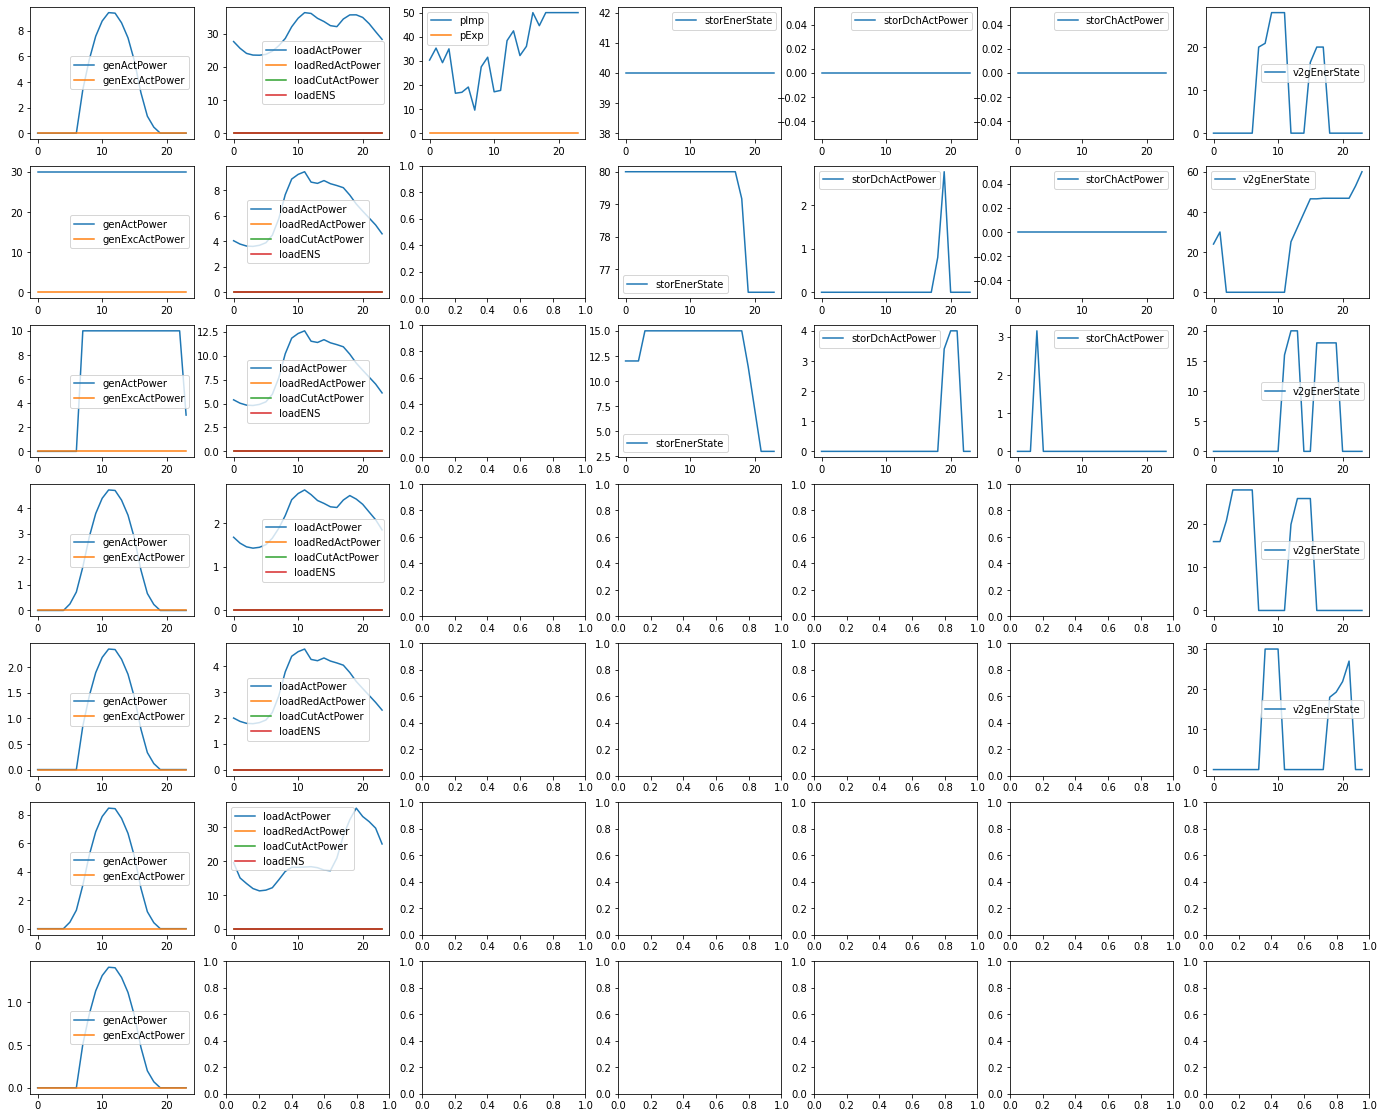

In [34]:
# Plot results

fig, axs = plt.subplots(nrows=7, ncols=7, figsize=(24, 20))

for i in np.arange(7):
    # Generators
    axs[i, 0].plot(result_genActPower.values[i])
    axs[i, 0].plot(result_genExcActPower.values[i])
    axs[i, 0].legend(['genActPower', 'genExcActPower'])
    
for i in np.arange(6):
    # Loads
    axs[i, 1].plot(loadLimit[:, :, 0][i, :])
    axs[i, 1].plot(result_loadRedActPower.values[i])
    axs[i, 1].plot(result_loadCutActPower.values[i])
    axs[i, 1].plot(result_loadENS.values[i])
    axs[i, 1].legend(['loadActPower', 'loadRedActPower', 'loadCutActPower', 'loadENS'])


axs[0, 2].plot(result_pimp.values)
axs[0, 2].plot(result_pexp.values)
axs[0, 2].legend(['pImp', 'pExp'])


for i in range(3):
    axs[i, 3].plot(result_storEnerState.values[i])
    axs[i, 3].legend(['storEnerState'])
    
for i in range(3):
    axs[i, 4].plot(result_storDchActPower.values[i])
    axs[i, 4].legend(['storDchActPower'])
    
for i in range(3):
    axs[i, 5].plot(result_storChActPower.values[i])
    axs[i, 5].legend(['storChActPower'])

for i in range(5):
    axs[i, 6].plot(result_v2gEnerState.values[i])
    axs[i, 6].legend(['v2gEnerState'])


plt.show()

In [35]:
# Total import costs

print('Total import cost: {}'.format(sum(result_pimp.values.ravel() * buyPrice)))

Total import cost: 71.1080568292099


In [51]:
# Pymoo import

import pymoo
from pymoo.core.problem import Problem
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.optimize import minimize
from pymoo.termination import get_termination

In [ ]:
# Class to speed up code execution

class HeuristicData(object):
    def __init__(self):
        return
    
    
    def objectiveFunction(self):
        return
    
    
    def doIteration(self):
        return
    
    
    def newIteration(self):
        return
    

class EnergyCommunity(HeuristicData):
    
    def __init__(self, parameters, variables):
        # Set initial values
        self.__initial_variables__ = variables
        self.__var_idx__ = [variables[v].ravel().shape[0] for v in variables.keys()]
        self.__var_names__ = list(variables.keys())
        
        # Value assignments
        self.parameterAssign(parameters)
        self.variableAssign(variables)
        
        self.encoded = None
        self.decoded = None
        
        
        self.objFn = 0
        
        self.checkV2G()
        self.checkCS()
        return
    
    
    def parameterAssign(self, parameters):
        self.genLimit = parameters['genLimit']
        self.genInfo = parameters['genInfo']
        self.pImpMax = parameters['pImpMax']
        self.pExpMax = parameters['pExpMax']
        self.loadLimit = parameters['loadLimit']
        self.loadActPower = parameters['loadActPower']
        self.storLimit = parameters['storLimit']
        self.storInfo = parameters['storInfo']
        self.v2gLimit = parameters['v2gLimit']
        self.v2gInfo = parameters['v2gInfo']
        self.csLimit = parameters['csLimit']
        self.csInfo = parameters['csInfo']
        self.EV_CS_Info = parameters['EV_CS_Info']
        self.buyPrice = parameters['buyPrice']
        self.sellPrice = parameters['sellPrice']
        self.t = parameters['t']
        self.gen = parameters['gen']
        self.load = parameters['load']
        self.stor = parameters['stor']
        self.v2g = parameters['v2g']
        self.cs = parameters['cs']
        #self.storPieceSegments = parameters['storPieceSegments']
        self.storCapCost = parameters['storCapCost']
        #self.storCyclesMult = parameters['storCyclesMult']
        self.v2gCapCost = parameters['v2gCapCost']
        #self.v2gCyclesMult = parameters['v2gCyclesMult']
        
        return
    
    
    def variableAssign(self, variables):
        self.genActPower = variables['genActPower']
        self.genExcActPower = variables['genExcActPower']
        self.pImp = variables['pImp']
        self.pExp = variables['pExp']
        self.loadRedActPower = variables['loadRedActPower']
        self.loadENS = variables['loadENS']
        self.storDchActPower = variables['storDchActPower']
        self.storChActPower = variables['storChActPower']
        self.EminRelaxStor = variables['EminRelaxStor']
        #self.v2gDchActPower = variables['v2gDchActPower']
        #self.v2gChActPower = variables['v2gChActPower']
        self.genXo = variables['genXo']
        self.loadXo = variables['loadXo']
        self.storDchXo = variables['storDchXo']
        self.storChXo = variables['storChXo']
        self.v2gDchXo = variables['v2gDchXo']
        self.v2gChXo = variables['v2gChXo']
        #self.storSegSoC = self.variables['storSegSoC']
        #self.v2gSegSoC = self.variables['v2gSegSoC']
        #self.storSegXo = self.variables['storSegXo']
        #self.v2gSegXo = self.variables['v2gSegXo']
        
        self.loadCutActPower = np.zeros((len(self.load),
                                         len(self.t)))
        
        self.storEnerState = np.zeros((len(self.stor),
                                       len(self.t)))
        
        #self.v2gEnerState = np.zeros((len(self.v2g),
        #                              len(self.t)))
        
        #self.EminRelaxEv = np.zeros((len(self.v2g),
        #                             len(self.t)))
        
        return
    
    
    def objectiveFunction(self):
        i: cython.int
        t: cython.int
        g: cython.int
        l: cython.int
        s: cython.int
        v: cython.int
            
        t_range: cython.int[self.t.shape[0]] = range(self.t.shape[0])
        gen_range: cython.int[self.gen.shape[0]] = range(self.gen.shape[0])
        load_range: cython.int[self.load.shape[0]] = range(self.load.shape[0])
        stor_range: cython.int[self.stor.shape[0]] = range(self.stor.shape[0])
        v2g_range: cython.int[self.v2g.shape[0]] = range(self.v2g.shape[0])
            
        balance_gens: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
        balance_loads: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
        balance_stor: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
        balance_v2g: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
            
        for t in t_range:
            balance_gens[t] = np.sum([self.genActPower[g, t] - self.genExcActPower[g, t]
                                      for g in gen_range])
            
            balance_loads[t] = np.sum([self.loadActPower[l, t] - self.loadRedActPower[l, t] - self.loadCutActPower[l, t] - self.loadENS[l, t] 
                                       for l in load_range])
            
            balance_stor[t] = np.sum([self.storChActPower[s, t] - self.storDchActPower[s, t]
                                      for s in stor_range])
            
            balance_v2g[t] = np.sum([self.v2gChActPower[v, t] - self.v2gDchActPower[v, t]
                                     for v in v2g_range])
            
        balance_rest: cython.float[self.t.shape[0]] = balance_gens - balance_loads - balance_stor - balance_v2g
            
        # Balance and import/export penalties
        mask = balance_rest > 0
        self.pImp[mask] *= 0
        self.pExp[mask] = balance_rest[mask]
        
        mask = balance_rest < 0
        self.pExp[mask] *= 0
        self.pImp[mask] = abs(balance_rest)[mask]
        
        
        # Attribute penalties for import/export
        balance_penalty: cython.float = 0
        for t in t_range:
            if (self.pImp[t] > self.pImpMax[t]):
                balance_penalty += 100000
                
            if (self.pExp[t] > self.pExpMax[t]):
                balance_penalty += 100000
                
            
        temp_gens: cython.float = sum([self.genActPower[g, t] * self.genLimit[g, t, 2] + self.genExcActPower[g, t] * self.genLimit[g, t, 4]
                                       for t in t_range for g in gen_range])
            
        temp_loads: cython.float = sum([self.loadRedActPower[l, t] * self.loadLimit[l, t, 6] + self.loadCutActPower[l, t] * self.loadLimit[l, t, 7] + self.loadENS[l, t] * self.loadLimit[l, t, 9] 
                                        for t in t_range for l in load_range])
            
        #temp_stor: cython.float = sum([self.storDchActPower[s, t] * self.storLimit[s, t, 3] - self.storChActPower[s, t] * self.storLimit[s, t, 2] + self.EminRelaxStor[s, t] * 200 
        #                               for t in t_range for s in stor_range])
            
        #temp_v2g: cython.float = sum([self.v2gDchActPower[v, t] * self.v2gLimit[v, t, 6] - self.v2gChActPower[v, t] * self.v2gLimit[v, t, 5] + self.EminRelaxEv[v, t] * 200
        #                              for t in t_range for v in v2g_range])
            
        temp_rest: cython.float = sum([self.pImp[t] * self.buyPrice[t] - self.pExp[t] * self.sellPrice[t] 
                                       for t in t_range])   
        
        temp_storDeg = sum([self.storCapCost[s] * (self.storEnerState[s, t]/self.storInfo[s, 5] - 0.63)**2 + self.storDchActPower[s, t] * self.storLimit[s, t, 3] + self.storChActPower[s, t] * self.storLimit[s, t, 2] + (6.5e-3)/self.storInfo[s, 5] * self.storChActPower[s, t]**2
                            for t in t_range for s in stor_range])
        
        temp_v2gDeg = sum([self.v2gCapCost[v] * (self.v2gEnerState[v, t]/self.v2gInfo[v, 4] - 0.63)**2 + self.v2gDchActPower[v, t] * self.v2gLimit[v, t, 6] + self.v2gChActPower[v, t] * self.v2gLimit[v, t, 5] + (6.5e-3)/self.v2gInfo[v, 4] * self.v2gChActPower[v, t]**2
                           for t in t_range for v in v2g_range])
            
        #temp_storDeg: cython.float = sum([self._auxStorDegCost(s, t) for t in t_range for s in stor_range])
            
        #temp_v2gDeg: cython.float = sum([self._auxV2GDegCost(v, t) for t in t_range for v in v2g_range])
        
        #self.objFn = (temp_gens + temp_loads + temp_stor + temp_v2g + temp_rest)*1.0 + balance_penalty + temp_storDeg# + temp_v2gDeg
        self.objFn = temp_gens + temp_loads + temp_rest + balance_penalty + temp_storDeg + temp_v2gDeg

        return
    
    
    def doIteration(self):
        self.checkImpExp()
        self.checkGens()
        self.checkLoads()
        self.checkStor()
        #self.new_checkV2G()
        #self.checkCS()
        
        self.objectiveFunction()
        
        self.encoded = self.encode()
        return
    
    
    def newIteration(self, encoded_vals):
        self.variableAssign(self.decode(encoded_vals))
        self.doIteration()
        return

    
    def checkImpExp(self):
        # Imports
        mask = self.pImp >= self.pImpMax
        self.pImp[mask] = self.pImpMax[mask]
        
        mask = self.pImp < 0
        self.pImp[mask] *= 0
        
        # Exports
        mask = self.pExp > self.pExpMax
        self.pExp[mask] = self.pExpMax[mask]
        
        mask = self.pExp < 0
        self.pExp[mask] *= 0
        
        return
    
    
    def checkGens(self):
        self.genXo = (self.genXo > 0.5).astype(int)
        
        # Maximum generation
        mask = self.genActPower > self.genLimit[:, :, 0]
        self.genActPower[mask] = self.genLimit[:, :, 0][mask]
        
        mask = self.genActPower < 0
        self.genActPower[mask] *= 0
    
        
        # Generator types - type 1
        mask = self.genInfo[:, 1] == np.ones((self.genInfo[:, 4].shape))
        self.genActPower[mask] = (self.genLimit[:, :, 0] * self.genXo)[mask]
        
        # Generator types - type 2
        mask = self.genInfo[:, 1] == 2*np.ones((self.genInfo[:, 4].shape))
        self.genActPower[mask] = self.genLimit[:, :, 0][mask]
    
        return
    
    
    def checkLoads(self):
        
        # Bound the values to either 0 or 1
        self.loadXo = (self.loadXo > 0.5).astype(int)
        
        # Build a matrix of ones
        temp_vals = np.ones((self.loadRedActPower.shape[0],
                             self.loadRedActPower.shape[1]))
        
        # RedAct value checks
        mask = self.loadRedActPower > temp_vals * self.loadLimit[:, :, 2]
        self.loadRedActPower[mask] = (temp_vals * self.loadLimit[:, :, 2])[mask]
        
        mask = self.loadRedActPower < 0
        self.loadRedActPower[mask] *= 0
        
        # loadCut value checks
        self.loadCutActPower = self.loadLimit[:, :, 3] * self.loadXo
        #self.loadCutActPower *= self.loadXo
        
        # loadENS
        temp_vals = self.loadActPower - self.loadRedActPower - self.loadCutActPower
        mask = self.loadENS > temp_vals
        self.loadENS[mask] = temp_vals[mask]
        return
    
    
    def checkStor(self):
        
        # Binary variables bound
        self.storChXo = (self.storChXo > 0.5).astype(int)
        self.storDchXo = (self.storDchXo > 0.5).astype(int)
        
        mask = None
        # Discharge inequality
        mask = self.storDchActPower > self.storLimit[:, :, 1]
        self.storDchActPower[mask] = self.storLimit[:, :, 1][mask]
        
        mask = self.storDchActPower <= 0
        self.storDchActPower[mask] *= 0
        
        # Charge inequality
        mask = self.storChActPower > self.storLimit[:, :, 0]
        self.storChActPower[mask] = self.storLimit[:, :, 0][mask]
        
        mask = self.storChActPower <= 0
        self.storChActPower[mask] *= 0
        
        # Initial stor SoC
        self.storEnerState[:, 0] = self.storInfo[:, 5] * (self.storInfo[:, 9]/100) + self.storChActPower[:, 0] * (self.storInfo[:, 7]/100) - self.storDchActPower[:, 0]/(self.storInfo[:, 8]/100)
        
        t: cython.int
        t_range: cython.int[len(self.t) - 1] = range(1, len(self.t))
        # Fix the timestep dependencies
        for t in t_range:
            # Check if charging
            mask = self.storChXo[:, t] > np.zeros(self.storChXo[:, t].shape)
            charged = self.storChActPower[:, t] * (self.storInfo[:, 7]/100)
            # Prevent charging beyong limit
            secondary_mask = (self.storEnerState[:, t-1] + charged) > self.storInfo[:, 5]
            self.storChActPower[:, t][secondary_mask] = ((self.storInfo[:, 5] - self.storEnerState[:, t-1]) / (self.storInfo[:, 7]/100))[secondary_mask]
            
            # Check if discharging
            mask = self.storDchXo[:, t] > np.zeros(self.storDchXo[:, t].shape)
            discharged = self.storDchActPower[:, t] / (self.storInfo[:, 8]/100)
            secondary_mask = (self.storEnerState[:, t-1] - discharged) < 0
            self.storDchActPower[:, t][secondary_mask] = (self.storEnerState[:, t-1] * (self.storInfo[:, 8]/100))[secondary_mask]
            
            self.storChActPower[:, t] *= self.storChXo[:, t]
            self.storDchActPower[:, t] *= self.storDchXo[:, t]
            self.storEnerState[:, t] = self.storEnerState[:, t-1] + (self.storChActPower[:, t] * (self.storInfo[:, 7]/100)) - (self.storDchActPower[:, t]/(self.storInfo[:, 8]/100))
            
            mask = self.storEnerState[:, t] < self.storInfo[:, 6] * (self.storInfo[:, 5] / 100) - self.EminRelaxStor[:, t]
            self.storEnerState[:, t][mask] = (self.storInfo[:, 6] * (self.storInfo[:, 5] / 100) - self.EminRelaxStor[:, t])[mask]
        return
    
    
    def checkV2G_old(self):
        
        # Binary variables bounding
        self.v2gChXo = (self.v2gDchXo < 0.33).astype(int)
        self.v2gDchXo = (self.v2gDchXo > 0.66).astype(int)
        
        mask = None
        t: cython.int
        t_range: cython.int[len(self.t) - 1] = range(1, len(self.t))
        for t in t_range:
            mask = self.v2gEnerState[:, t-1] == self.v2gInfo[:, 4]
            self.v2gChXo[:, t][mask] *= 0
            self.v2gChActPower[:, t][mask] *= 0
            
            mask = self.v2gEnerState[:, t-1] == 0
            self.v2gDchXo[:, t][mask] *= 0
            self.v2gDchActPower[:, t][mask] *= 0
            
        # Discharge rate
        temp_vals = self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0] * self.v2gDchXo
        mask = self.v2gDchActPower > temp_vals
        self.v2gDchActPower[mask] = temp_vals[mask]
        
        
        
        # Charge rate
        temp_vals = self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0] * self.v2gChXo
        mask = self.v2gChActPower > temp_vals
        self.v2gChActPower[mask] = temp_vals[mask]
        
        # Energy Balance Initial Eq
        mask = self.v2gLimit[:, 0, 0] == 0
        temp_vals = self.v2gLimit[:, 0, 1] + (self.v2gChActPower[:, 0] * self.v2gInfo[:, 7]) - (self.v2gDchActPower[:, 0] / self.v2gInfo[:, 8])
        self.v2gEnerState[:, 0][mask] = temp_vals[mask]
        
        # Energy Balance 1
        mask = self.v2gLimit[:, :-1, 0] == 1
        secondary_mask = self.v2gLimit[:, 1:, 0] == 1
        
        temp_vals = [self.v2gEnerState[:, t-1] + self.v2gLimit[:, t, 1] + (self.v2gChActPower[:, t] * self.v2gInfo[:, 7]) - (self.v2gDchActPower[:, t] / self.v2gInfo[:, 8])
                     for t in range(1, len(self.t))]
        temp_vals = np.array(temp_vals).transpose()
        self.v2gEnerState[:, 1:][mask & secondary_mask] = temp_vals[mask & secondary_mask]
        
        # Energy Balance 2
        mask = self.v2gLimit[:, :-1, 0] == 0
        temp_vals = [self.v2gLimit[:, t, 1] + (self.v2gChActPower[:, t] * self.v2gInfo[:, 8]) + (self.v2gDchActPower[:, t] / self.v2gInfo[:, 8])
                     for t in range(1, len(self.t))]
        temp_vals = np.array(temp_vals).transpose()
        self.v2gEnerState[:, 1:][mask & secondary_mask] = temp_vals[mask & secondary_mask]
        return
    
    
    def new_checkV2G(self):
        self.v2gDchXo = (self.v2gDchXo > 0.5).astype(int)
        self.v2gChXo = (self.v2gChXo > 0.5).astype(int)
        
        mask = self.v2gDchXo + self.v2gChXo == 2*np.ones(self.v2gDchXo.shape)
        self.v2gDchXo[mask] *= 0
        
        # Discharge rate
        mask = self.v2gDchActPower > self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0] * self.v2gDchXo
        self.v2gDchActPower[mask] = (self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0] * self.v2gDchXo)[mask]
        
        # Charge rate
        mask = self.v2gChActPower > self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0] * self.v2gChXo
        self.v2gChActPower[mask] = (self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0] * self.v2gChXo)[mask]
        
        # Energy Limits
        mask = self.v2gEnerState > (np.ones(self.v2gEnerState.shape).transpose() * self.v2gInfo[:, 4]).transpose()
        self.v2gEnerState[mask] = (np.ones(self.v2gEnerState.shape).transpose() * self.v2gInfo[:, 4]).transpose()[mask]
        
        # bat balance zero
        mask = self.v2gLimit[:, :, 0] == np.zeros(self.v2gLimit[:, :, 0].shape)
        self.v2gEnerState[mask] *= 0
        
        # bat balance initial eq
        mask = self.v2gLimit[:, 0, 0] == np.ones(self.v2gLimit[:, 0, 0].shape)
        self.v2gLimit[:, 0, 0][mask] = (self.v2gLimit[:, 0, 2] + self.v2gChActPower[:, 0] * self.v2gInfo[:, 7] - (self.v2gDchActPower[:, 0] / self.v2gInfo[:, 8]))[mask]
        
        # batery update
        t: cython.int
        t_range: cython.int[len(self.t) - 1] = range(1, len(self.t))
        for t in t_range:
            mask = (self.v2gLimit[:, t-1, 0] + self.v2gLimit[:, t, 0]) == 2*np.ones(self.v2gLimit[:, t, 0].shape)
            self.v2gEnerState[:, t][mask] = (self.v2gEnerState[:, t-1] + self.v2gLimit[:, t, 1] + self.v2gChActPower[:, t] * self.v2gInfo[:, 7] - (self.v2gChActPower[:, t] / self.v2gInfo[:, 8]))[mask]
            
            mask = self.v2gLimit[:, t-1, 0] == np.zeros(self.v2gLimit[:, t-1, 0].shape)
            secondary_mask = self.v2gLimit[:, t, 0] == np.ones(self.v2gLimit[:, t, 0].shape)
            self.v2gEnerState[:, t][mask & secondary_mask] = (self.v2gLimit[:, t, 1] + self.v2gChActPower[:, t] * self.v2gInfo[:, 7] + (self.v2gDchActPower[:, t] / self.v2gInfo[:, 8]))[mask & secondary_mask]
        
        
        # Energy Limits -> again after changing the SOC
        mask = self.v2gEnerState > (np.ones(self.v2gEnerState.shape).transpose() * self.v2gInfo[:, 4]).transpose()
        self.v2gEnerState[mask] = (np.ones(self.v2gEnerState.shape).transpose() * self.v2gInfo[:, 4]).transpose()[mask]
        return
    
    
    def checkV2G(self):
        # Binary variables bounding
        #self.v2gChXo = (self.v2gDchXo < 0.33).astype(int)
        #self.v2gDchXo = (self.v2gDchXo > 0.66).astype(int)
        
        self.v2gDchActPower = np.zeros((len(self.v2g),
                                        len(self.t)))
        
        self.v2gChActPower = np.zeros((len(self.v2g),
                                       len(self.t)))
        
        self.v2gEnerState = np.zeros((len(self.v2g),
                                      len(self.t)))
        
        self.EminRelaxEv = np.zeros((len(self.v2g),
                                     len(self.t)))
        
        # Bound binary variables
        self.v2gChXo = (self.v2gChXo > 0.5).astype(int)
        self.v2gDchXo = (self.v2gDchXo > 0.5).astype(int)
        #self.v2gChXo = 1 - self.v2gDchXo

        mask = None

        v: cython.int
        c: cython.int

        # Discharge rate
        #temp_val = par['v2gLimit'][:, :, 4] * par['v2gLimit'][:, :, 0]
        #mask = pop['v2gDchActPower'] > temp_val
        #pop['v2gDchActPower'][mask] = temp_val[mask]


        # Charge rate
        #temp_val = par['v2gLimit'][:, :, 3] * par['v2gLimit'][:, :, 0]
        #mask = pop['v2gChActPower'] > temp_val
        #pop['v2gChActPower'][mask] = temp_val[mask]

        self.v2gDchActPower = self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0]
        self.v2gChActPower = self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0]

        # V2G constraints
        v_range: cython.int[len(self.v2g)] = range(len(self.v2g))
        c_range: cython.int[len(self.cs)] = range(len(self.cs))
        for v in v_range:
            # Check connection to charging stations
            isConnected = False
            connectedTo = 0

            # Check the charging stations
            for c in c_range:
                isConnected = True
                if self.EV_CS_Info[v, c, 0] > 0:
                    self.v2gChActPower[v, 0] = min(self.v2gChActPower[v, 0], self.csInfo[c, 4])
                    self.v2gDchActPower[v, 0] = min(self.v2gDchActPower[v, 0], self.csInfo[c, 5])

                    connectedTo = c
                else:
                    self.v2gDchXo[v, 0] = 0
                    self.v2gChXo[v, 0] = 0

            if self.v2gChXo[v, 0] + self.v2gDchXo[v, 0] > 1:
                self.v2gDchXo[v, 0] = 1 - self.v2gChXo[v, 0]

            mask = self.v2gLimit[v, :, 2] > 0
            temp_val = self.v2gLimit[v, :, 2][mask]

            if isConnected & (len(temp_val) > 0):
                if self.v2gEnerState[v, 0] < temp_val[0]:
                    next_index = next((idx for idx, val in np.ndenumerate(self.v2gLimit[v, :, 2]) 
                                       if val==temp_val[0]))[0]
                    min_tsteps = np.ceil((temp_val[0] - self.v2gEnerState[v, 0]) / self.csInfo[connectedTo, 4]) - 1

                    if min_tsteps >= next_index:
                        self.v2gChXo[v, 0] = 1
                        self.v2gDchXo[v, 0] = 0

            self.v2gChActPower[v, 0] *= self.v2gChXo[v,  0]
            self.v2gDchActPower[v, 0] *= self.v2gDchXo[v, 0]

            if self.v2gLimit[v, 0, 0] == 0:
                self.v2gEnerState[v, 0] = 0
            elif self.v2gLimit[v, 0, 0] == 1:
                self.v2gEnerState[v, 0] = self.v2gLimit[v, 0, 1] + self.v2gChActPower[v, 0] * self.v2gInfo[v, 7] - self.v2gDchActPower[v, 0] / self.v2gInfo[v, 8]

            #print('v2gEnerState: {}'.format(pop['v2gEnerState'][v, 0]))

            # Timestep
            for t in range(1, len(self.t)):

                isConnected = False
                connectedTo = 0

                # Check the charging stations
                for c in c_range:
                    if self.EV_CS_Info[v, c, t] > 0:
                        isConnected = True
                        self.v2gChActPower[v, t] = min(self.v2gChActPower[v, t], self.csInfo[c, 4])
                        self.v2gDchActPower[v, t] = min(self.v2gDchActPower[v, t], self.csInfo[c, 5])

                        connectedTo = c
                    else:
                        self.v2gDchXo[v, t] = 0
                        self.v2gChXo[v, t] = 0


                # Disable charge and discharge in the same period
                if self.v2gChXo[v, t] + self.v2gDchXo[v, t] > 1:
                    self.v2gDchXo[v, t] = 1 - self.v2gChXo[v, t]

                # Incentivise charge to meet minimum limits
                mask = self.v2gLimit[v, t:, 2] > 0
                temp_val = self.v2gLimit[v, t:, 2][mask]

                # Check if there are any requirements for EVs
                if isConnected & (len(temp_val) > 0):
                    if self.v2gEnerState[v, t-1] < temp_val[0]:
                        next_index = next((idx for idx, val in np.ndenumerate(self.v2gLimit[v, t:, 2]) 
                                           if val==temp_val[0]))[0]
                        min_tsteps = np.ceil((temp_val[0] - self.v2gEnerState[v, t-1])  /  self.csInfo[connectedTo, 4]) - 1
                        if min_tsteps <= next_index:
                            self.v2gChXo[v, t] = 1
                            self.v2gDchXo[v, t] = 0



                            if (self.v2gEnerState[v, t-1] + (self.v2gChActPower[v, t] * float(self.v2gInfo[v, 7]))) >= self.v2gInfo[v, 4]:
                                self.v2gChActPower[v, t] = (self.v2gInfo[v, 4] - self.v2gEnerState[v, t-1]) / float(self.v2gInfo[v, 7])

                # Prevent charging when battery is full
                if self.v2gEnerState[v, t-1] == self.v2gInfo[v, 4]:
                    #print('HERE')
                    self.v2gChXo[v, t] = 0

                # Prevent discharge when battery is empty
                elif self.v2gEnerState[v, t-1] == 0:
                    self.v2gDchXo[v, t] = 0

                self.v2gChActPower[v, t] *= self.v2gChXo[v, t]
                self.v2gDchActPower[v, t] *= self.v2gDchXo[v, t]

                # Update battery capacity
                if (self.v2gLimit[v, t-1, 0] == 1) & (self.v2gLimit[v, t, 0] == 1):
                    self.v2gEnerState[v, t] = self.v2gEnerState[v, t-1] + self.v2gLimit[v, t, 1] + (self.v2gChActPower[v, t] * float(self.v2gInfo[v, 7])) - (self.v2gDchActPower[v, t] / float(self.v2gInfo[v, 8]))
                elif (self.v2gLimit[v, t-1, 0] == 0) & (self.v2gLimit[v, t, 0] == 1):
                    self.v2gEnerState[v, t] = self.v2gLimit[v, t, 1] + (self.v2gChActPower[v, t] * float(self.v2gInfo[v, 7])) + (self.v2gDchActPower[v, t] / float(self.v2gInfo[v, 8]))

        return
    
    
    def checkCS(self):
        
        self.csActPower = np.zeros((len(self.cs),
                                    len(self.t)))
        
        self.csActPowerNet = np.zeros((len(self.cs),
                                       len(self.t)))
        
        #self.v2gChXo = (self.v2gDchXo < 0.33).astype(int)
        #self.v2gDchXo = (self.v2gDchXo > 0.66).astype(int)
        
        
        c: cython.int
        t: cython.int
        v: cython.int
            
        t_range: cython.int[len(self.t)] = range(len(self.t))
        c_range: cython.int[len(self.cs)] = range(len(self.cs))
        v_range: cython.int[len(self.v2g)] = range(len(self.v2g))
        
        # Timesteps
        for t in t_range:

            # Charging station constraints
            for c in c_range:

                temp_val = 0
                temp_val2 = 0
                for v in v_range:
                    if self.EV_CS_Info[v, c, t] > 0:
                        temp_val += (self.v2gChActPower[v, t]  - self.v2gDchActPower[v, t])
                        temp_val2 += (self.v2gChActPower[v, t] / (self.csInfo[c, 6] / 100) - (self.v2gDchActPower[v, t] * self.csInfo[c, 7] / 100))


                if temp_val > self.csInfo[c, 4]:
                    temp_val = self.csInfo[c, 4]
                if temp_val < -self.csInfo[c, 5]:
                    temp_val = -self.csInfo[c, 5]

                self.csActPower[c, t] = temp_val
                self.csActPowerNet[c, t] = temp_val2
        return
    
    
    def encode(self):
        var_dictionary = {'genActPower': self.genActPower,
                          'genExcActPower': self.genExcActPower,
                          'pImp': self.pImp,
                          'pExp': self.pExp,
                          'loadRedActPower': self.loadRedActPower,
                          'loadENS': self.loadENS,
                          'storDchActPower': self.storDchActPower,
                          'storChActPower': self.storChActPower,
                          'EminRelaxStor': self.EminRelaxStor,
                          #'v2gDchActPower': self.v2gDchActPower,
                          #'v2gChActPower': self.v2gChActPower,
                          'genXo': self.genXo,
                          'loadXo': self.loadXo,
                          'storDchXo': self.storDchXo,
                          'storChXo': self.storChXo,
                          'v2gDchXo': self.v2gDchXo,
                          'v2gChXo': self.v2gChXo
                         }
        
        result_concat = np.concatenate([var_dictionary[v].ravel() for v in var_dictionary.keys()])
        return result_concat
    
    
    def decode(self, new_variables):
        result_decoded = {}
        current_index = 0
        
        for idx in range(len(self.__var_names__)):
            result_index = current_index + self.__var_idx__[idx]
            result_decoded[self.__var_names__[idx]] = np.reshape(new_variables[current_index:result_index],
                                                                 self.__initial_variables__[self.__var_names__[idx]].shape)
            
            current_index = result_index
        
        
        return result_decoded
    

In [19]:
# Turn and recover vector for encoding

def encode(var_dictionary):
    result_concat = np.concatenate([var_dictionary[v].ravel() for v in var_dictionary.keys()])
    return result_concat


def decode(var_vector, var_dictionary):
    result_decoded = {}
    var_idx = [var_dictionary[v].ravel().shape[0] for v in var_dictionary.keys()]

    current_index = 0
    dictionary_names = list(var_dictionary.keys())
    
    for idx in np.arange(len(dictionary_names)):
        result_index = current_index + var_idx[idx]
        result_decoded[dictionary_names[idx]] = np.reshape(var_vector[current_index:result_index], 
                                                           var_dictionary[dictionary_names[idx]].shape)
        
        current_index = result_index
        
    return result_decoded

In [16]:
# Positive variables

genActPower = np.ones(shape=(len(_gen), len(_t)))
genExcActPower = np.ones(shape=(len(_gen), len(_t)))
pImp = np.ones(shape=(len(_t)))
pExp = np.ones(shape=(len(_t)))

# Load variables
loadRedActPower = np.ones(shape=(len(_Load), len(_t)))
loadCutActPower = np.ones(shape=(len(_Load), len(_t)))
loadENS = np.ones(shape=(len(_Load), len(_t)))

# Storage variables
storDchActPower = np.ones(shape=(len(_stor), len(_t)))
storChActPower = np.ones(shape=(len(_stor), len(_t)))
storEminRelaxStor = np.ones(shape=(len(_stor), len(_t)))
storEnerState = np.ones(shape=(len(_stor), len(_t)))

# V2G variables
v2gDchActPower = np.ones(shape=(len(_v2g), len(_t)))
v2gChActPower = np.ones(shape=(len(_v2g), len(_t)))
v2gEnerState = np.ones(shape=(len(_v2g), len(_t)))
v2gEminRelaxEv = np.ones(shape=(len(_v2g), len(_t)))

# Charging Stations
csActPower = np.ones(shape=(len(_cs), len(_t)))
csActPowerNet = np.ones(shape=(len(_cs), len(_t)))

# Storage deg
storSegSoC = np.ones(shape=(len(_stor), len(_t), 3))
v2gSegSoC = np.ones(shape=(len(_v2g), len(_t), 3))

In [17]:
# Binary variables

genXo = np.zeros(shape=(len(_gen), len(_t)))
loadXo = np.zeros(shape=(len(_Load), len(_t)))

storChXo = np.zeros(shape=(len(_stor), len(_t)))
storDchXo = np.zeros(shape=(len(_stor), len(_t)))

v2gChXo = np.zeros(shape=(len(_v2g), len(_t)))
v2gDchXo = np.zeros(shape=(len(_v2g), len(_t)))

# Battery deg binary variables
storSegXo = np.zeros(shape=(len(_stor), len(_t), 3))
v2gSegXo = np.zeros(shape=(len(_v2g), len(_t), 3))

In [20]:
# Define dictionaries

dict_var = {'genActPower': genActPower,
            'genExcActPower': genExcActPower,
            'pImp': pImp,
            'pExp': pExp,
            'loadRedActPower': loadRedActPower,
            'loadENS': loadENS,
            'storDchActPower': storDchActPower,
            'storChActPower': storChActPower,
            'EminRelaxStor': storEminRelaxStor,
            #'v2gDchActPower': v2gDchActPower,
            #'v2gChActPower': v2gChActPower,
            'genXo': genXo,
            'loadXo': loadXo,
            'storDchXo': storDchXo,
            'storChXo': storChXo,
            'v2gDchXo': v2gDchXo,
            'v2gChXo': v2gChXo}#,
            #'storSegSoC': storSegSoC,
            #'v2gSegSoC': v2gSegSoC,
            #'storSegXo': storSegXo,
            #'v2gSegXo': v2gSegXo}
encoded_vars = encode(dict_var)
encoded_vars = encoded_vars.astype(float)
decoded_vars = decode(encoded_vars, dict_var)

dict_par = {'genLimit': genLimit,
            'genInfo': genInfo,
            'pImpMax': pMaxImp,
            'pExpMax': pMaxExp,
            'loadLimit': loadLimit,
            'loadActPower': loadLimit[:, :, 0],
            'storLimit': storLimit,
            'storInfo': storInfo[:, :12],
            'v2gLimit': v2gLimit,
            'v2gInfo': v2gInfo,
            'csLimit': csLimit,
            'csInfo': csInfo,
            'EV_CS_Info': EV_CS_Info,
            'buyPrice': buyPrice,
            'sellPrice': sellPrice,
            't': _t,
            'gen': _gen,
            'load': _Load,
            'stor': _stor,
            'v2g': _v2g,
            'cs': _cs,
            #'storPieceSegments': np.array([1, 2, 3]),
            'storCapCost': storInfo[:, 5] * 0.00105,
            #'storCyclesMult': np.array([1000, 1200, 700]),
            'v2gCapCost': v2gInfo[:, 4] * 0.00105}
            #'v2gCyclesMult': np.array([1000, 1000, 1000, 1000, 1000])}
encoded_pars = encode(dict_par)
encoded_pars = encoded_pars.astype(float)
decoded_pars = decode(encoded_pars, dict_par)

In [21]:
# Encoded and decoded dictionaries

encoded_dict = encode(dict_var)

decoded_dict = decode(encoded_dict, dict_var)

In [22]:
# Define min and max values allowed

minVals = {'genActPower': np.array(np.zeros((1, genActPower.ravel().shape[0]))),
           'genExcActPower': np.array(np.zeros((1, genExcActPower.ravel().shape[0]))),
           'pImp': np.array(np.zeros((1, pImp.ravel().shape[0]))),
           'pExp': np.array(np.zeros((1, pExp.ravel().shape[0]))),
           'loadRedActPower': np.array(np.zeros((1, loadRedActPower.ravel().shape[0]))),
           'loadENS': np.array(np.zeros((1, loadENS.ravel().shape[0]))),
           'storDchActPower': np.array(np.zeros((1, storDchActPower.ravel().shape[0]))),
           'storChActPower': np.array(np.zeros((1, storChActPower.ravel().shape[0]))),
           'EminRelaxStor': np.array(np.zeros((1, storEminRelaxStor.ravel().shape[0]))),
           #'v2gDchActPower': np.array(np.zeros((1, v2gDchActPower.ravel().shape[0]))),
           #'v2gChActPower': np.array(np.zeros((1, v2gChActPower.ravel().shape[0]))),
           'genXo': np.array(np.zeros((1, genXo.ravel().shape[0]))),
           'loadXo': np.array(np.zeros((1, loadXo.ravel().shape[0]))),
           'storDchXo': np.array(np.zeros((1, storDchXo.ravel().shape[0]))),
           'storChXo': np.array(np.zeros((1, storChXo.ravel().shape[0]))),
           'v2gDchXo': np.array(np.zeros((1, v2gDchXo.ravel().shape[0]))),
           'v2gChXo': np.array(np.zeros((1, v2gChXo.ravel().shape[0])))}#,
           #'storSegSoC': np.array(np.zeros((1, storSegSoC.ravel().shape[0]))),
           #'v2gSegSoC': np.array(np.zeros((1, v2gSegSoC.ravel().shape[0]))),
           #'storSegXo': np.array(np.zeros((1, storSegXo.ravel().shape[0]))),
           #'v2gSegXo': np.array(np.zeros((1, v2gSegXo.ravel().shape[0])))}
encoded_minvals = encode(minVals)
encoded_minvals = encoded_minvals.astype(float)

maxVals = {'genActPower': 30*np.array(np.ones((1, genActPower.ravel().shape[0]))),
           'genExcActPower': 30*np.array(np.ones((1, genExcActPower.ravel().shape[0]))),
           'pImp': pMaxImp.ravel(),
           'pExp': pMaxExp.ravel(),
           'loadRedActPower': loadLimit[:, :, 2].ravel(),
           'loadENS': 200*np.array(np.ones((1, loadENS.ravel().shape[0]))),
           'storDchActPower': storLimit[:, :, 1].ravel(),
           'storChActPower': storLimit[:, :, 0].ravel(),
           'EminRelaxStor': 100*np.array(np.ones((1, storEminRelaxStor.ravel().shape[0]))),
           #'v2gDchActPower': 200*np.array(np.ones((1, v2gDchActPower.ravel().shape[0]))),
           #'v2gChActPower': 200*np.array(np.ones((1, v2gChActPower.ravel().shape[0]))),
           'genXo': np.array(np.ones((1, genXo.ravel().shape[0]))),
           'loadXo': np.array(np.ones((1, loadXo.ravel().shape[0]))),
           'storDchXo': np.array(np.ones((1, storDchXo.ravel().shape[0]))),
           'storChXo': np.array(np.ones((1, storChXo.ravel().shape[0]))),
           'v2gDchXo': np.array(np.ones((1, v2gDchXo.ravel().shape[0]))),
           'v2gChXo': np.array(np.ones((1, v2gChXo.ravel().shape[0])))}#,
           #'storSegSoC': 100*np.array(np.ones((1, storSegSoC.ravel().shape[0]))),
           #'v2gSegSoC': 100*np.array(np.ones((1, v2gSegSoC.ravel().shape[0]))),
           #'storSegXo': np.array(np.ones((1, storSegXo.ravel().shape[0]))),
           #'v2gSegXo': np.array(np.ones((1, v2gSegXo.ravel().shape[0])))}
encoded_maxvals = encode(maxVals)
encoded_maxvals = encoded_maxvals.astype(float)

In [23]:
# Define initial solution

sol = {'genActPower': genLimit[:, :, 0].ravel(),
       'genExcActPower': np.array(np.zeros((1, genExcActPower.ravel().shape[0]))),
       'pImp': pMaxImp.ravel(),
       'pExp': np.array(np.zeros((1, pExp.ravel().shape[0]))),
       'loadRedActPower': np.array(np.zeros((1, loadRedActPower.ravel().shape[0]))),
       'loadENS': np.array(np.zeros((1, loadENS.ravel().shape[0]))),
       'storDchActPower': np.array(np.zeros((1, storDchActPower.ravel().shape[0]))),
       'storChActPower': np.array(np.zeros((1, storChActPower.ravel().shape[0]))),
       'EminRelaxStor': np.array(np.zeros((1, storEminRelaxStor.ravel().shape[0]))),
       #'v2gDchActPower': np.array(np.zeros((1, v2gDchActPower.ravel().shape[0]))),
       #'v2gChActPower': np.array(np.zeros((1, v2gChActPower.ravel().shape[0]))),
       'genXo': np.array(np.zeros((1, genXo.ravel().shape[0]))),
       'loadXo': np.array(np.zeros((1, loadXo.ravel().shape[0]))),
       'storDchXo': np.array(np.ones((1, storDchXo.ravel().shape[0]))),
       'storChXo': np.array(np.zeros((1, storChXo.ravel().shape[0]))),
       'v2gDchXo': np.array(np.zeros((1, v2gDchXo.ravel().shape[0]))),
       'v2gChXo': np.array(np.zeros((1, v2gChXo.ravel().shape[0])))}#,
       #'storSegSoC': np.array(np.zeros((1, storSegSoC.ravel().shape[0]))),
       #'v2gSegSoC': np.array(np.zeros((1, v2gSegSoC.ravel().shape[0]))),
       #'storSegXo': np.array(np.zeros((1, storSegXo.ravel().shape[0]))),
       #'v2gSegXo': np.array(np.zeros((1, v2gSegXo.ravel().shape[0])))}

encoded_sol = encode(sol)
encoded_sol = encoded_sol.astype(float)

In [24]:
# Properly shaped initial Solution

sol_shaped = {'genActPower': genLimit[:, :, 0],
              'genExcActPower': np.zeros(genExcActPower.shape),
              'pImp': pMaxImp,
              'pExp': np.zeros(pExp.shape),
              'loadRedActPower': np.zeros(loadRedActPower.shape),
              'loadENS': np.zeros(loadENS.shape),
              'storDchActPower': np.zeros(storDchActPower.shape),
              'storChActPower': np.zeros(storChActPower.shape),
              'EminRelaxStor': np.zeros(storEminRelaxStor.shape),
              #'v2gDchActPower': np.zeros(v2gDchActPower.shape),
              #'v2gChActPower': np.zeros(v2gChActPower.shape),
              'genXo': np.zeros(genXo.shape),
              'loadXo': np.zeros(loadXo.shape),
              'storDchXo': np.ones(storDchXo.shape),
              'storChXo': np.zeros(storChXo.shape),
              'v2gDchXo': np.zeros(v2gDchXo.shape),
              'v2gChXo': np.zeros(v2gChXo.shape)}

encoded_shaped = encode(sol_shaped)
decoded_shaped = decode(encoded_shaped, dict_var)

In [48]:
# Define a custom problem

class ProblemEC(Problem):
    
    def __init__(self, parameters, variables, xl, xu, n_var):
        super().__init__(n_var=n_var, n_obj=1, n_ieq_constr=0, xl=xl, xu=xu, vtype=float)
        
        # Set initial values
        self.__initial_variables__ = variables
        self.__var_idx__ = [variables[v].ravel().shape[0] for v in variables.keys()]
        self.__var_names__ = list(variables.keys())
        
        # Value assignments
        self.parameterAssign(parameters)
        self.variableAssign(variables)
        
        self.encoded = None
        self.decoded = None
        
        
        self.objFn = 0
        
        self.checkV2G()
        self.checkCS()
        
    
    def parameterAssign(self, parameters):
        self.genLimit = parameters['genLimit']
        self.genInfo = parameters['genInfo']
        self.pImpMax = parameters['pImpMax']
        self.pExpMax = parameters['pExpMax']
        self.loadLimit = parameters['loadLimit']
        self.loadActPower = parameters['loadActPower']
        self.storLimit = parameters['storLimit']
        self.storInfo = parameters['storInfo']
        self.v2gLimit = parameters['v2gLimit']
        self.v2gInfo = parameters['v2gInfo']
        self.csLimit = parameters['csLimit']
        self.csInfo = parameters['csInfo']
        self.EV_CS_Info = parameters['EV_CS_Info']
        self.buyPrice = parameters['buyPrice']
        self.sellPrice = parameters['sellPrice']
        self.t = parameters['t']
        self.gen = parameters['gen']
        self.load = parameters['load']
        self.stor = parameters['stor']
        self.v2g = parameters['v2g']
        self.cs = parameters['cs']
        #self.storPieceSegments = parameters['storPieceSegments']
        self.storCapCost = parameters['storCapCost']
        #self.storCyclesMult = parameters['storCyclesMult']
        self.v2gCapCost = parameters['v2gCapCost']
        #self.v2gCyclesMult = parameters['v2gCyclesMult']
        
        return
    
    
    def variableAssign(self, variables):
        self.genActPower = variables['genActPower']
        self.genExcActPower = variables['genExcActPower']
        self.pImp = variables['pImp']
        self.pExp = variables['pExp']
        self.loadRedActPower = variables['loadRedActPower']
        self.loadENS = variables['loadENS']
        self.storDchActPower = variables['storDchActPower']
        self.storChActPower = variables['storChActPower']
        self.EminRelaxStor = variables['EminRelaxStor']
        #self.v2gDchActPower = variables['v2gDchActPower']
        #self.v2gChActPower = variables['v2gChActPower']
        self.genXo = variables['genXo']
        self.loadXo = variables['loadXo']
        self.storDchXo = variables['storDchXo']
        self.storChXo = variables['storChXo']
        self.v2gDchXo = variables['v2gDchXo']
        self.v2gChXo = variables['v2gChXo']
        #self.storSegSoC = self.variables['storSegSoC']
        #self.v2gSegSoC = self.variables['v2gSegSoC']
        #self.storSegXo = self.variables['storSegXo']
        #self.v2gSegXo = self.variables['v2gSegXo']
        
        self.loadCutActPower = np.zeros((len(self.load),
                                         len(self.t)))
        
        self.storEnerState = np.zeros((len(self.stor),
                                       len(self.t)))
        
        #self.v2gEnerState = np.zeros((len(self.v2g),
        #                              len(self.t)))
        
        #self.EminRelaxEv = np.zeros((len(self.v2g),
        #                             len(self.t)))
        
        return
    
    
    def objectiveFunction(self):
        i: cython.int
        t: cython.int
        g: cython.int
        l: cython.int
        s: cython.int
        v: cython.int
            
        t_range: cython.int[self.t.shape[0]] = range(self.t.shape[0])
        gen_range: cython.int[self.gen.shape[0]] = range(self.gen.shape[0])
        load_range: cython.int[self.load.shape[0]] = range(self.load.shape[0])
        stor_range: cython.int[self.stor.shape[0]] = range(self.stor.shape[0])
        v2g_range: cython.int[self.v2g.shape[0]] = range(self.v2g.shape[0])
            
        balance_gens: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
        balance_loads: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
        balance_stor: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
        balance_v2g: cython.float[self.t.shape[0]] = np.zeros(self.t.shape[0])
            
        for t in t_range:
            balance_gens[t] = np.sum([self.genActPower[g, t] - self.genExcActPower[g, t]
                                      for g in gen_range])
            
            balance_loads[t] = np.sum([self.loadActPower[l, t] - self.loadRedActPower[l, t] - self.loadCutActPower[l, t] - self.loadENS[l, t] 
                                       for l in load_range])
            
            balance_stor[t] = np.sum([self.storChActPower[s, t] - self.storDchActPower[s, t]
                                      for s in stor_range])
            
            balance_v2g[t] = np.sum([self.v2gChActPower[v, t] - self.v2gDchActPower[v, t]
                                     for v in v2g_range])
            
        balance_rest: cython.float[self.t.shape[0]] = balance_gens - balance_loads - balance_stor - balance_v2g
            
        # Balance and import/export penalties
        mask = balance_rest > 0
        self.pImp[mask] *= 0
        self.pExp[mask] = balance_rest[mask]
        
        mask = balance_rest < 0
        self.pExp[mask] *= 0
        self.pImp[mask] = abs(balance_rest)[mask]
        
        
        # Attribute penalties for import/export
        balance_penalty: cython.float = 0
        for t in t_range:
            if (self.pImp[t] > self.pImpMax[t]):
                balance_penalty += 100000
                
            if (self.pExp[t] > self.pExpMax[t]):
                balance_penalty += 100000
                
            
        temp_gens: cython.float = sum([self.genActPower[g, t] * self.genLimit[g, t, 2] + self.genExcActPower[g, t] * self.genLimit[g, t, 4]
                                       for t in t_range for g in gen_range])
            
        temp_loads: cython.float = sum([self.loadRedActPower[l, t] * self.loadLimit[l, t, 6] + self.loadCutActPower[l, t] * self.loadLimit[l, t, 7] + self.loadENS[l, t] * self.loadLimit[l, t, 9] 
                                        for t in t_range for l in load_range])
            
        #temp_stor: cython.float = sum([self.storDchActPower[s, t] * self.storLimit[s, t, 3] - self.storChActPower[s, t] * self.storLimit[s, t, 2] + self.EminRelaxStor[s, t] * 200 
        #                               for t in t_range for s in stor_range])
            
        #temp_v2g: cython.float = sum([self.v2gDchActPower[v, t] * self.v2gLimit[v, t, 6] - self.v2gChActPower[v, t] * self.v2gLimit[v, t, 5] + self.EminRelaxEv[v, t] * 200
        #                              for t in t_range for v in v2g_range])
            
        temp_rest: cython.float = sum([self.pImp[t] * self.buyPrice[t] - self.pExp[t] * self.sellPrice[t] 
                                       for t in t_range])   
        
        temp_storDeg = sum([self.storCapCost[s] * (self.storEnerState[s, t]/self.storInfo[s, 5] - 0.63)**2 + self.storDchActPower[s, t] * self.storLimit[s, t, 3] + self.storChActPower[s, t] * self.storLimit[s, t, 2] + (6.5e-3)/self.storInfo[s, 5] * self.storChActPower[s, t]**2
                            for t in t_range for s in stor_range])
        
        temp_v2gDeg = sum([self.v2gCapCost[v] * (self.v2gEnerState[v, t]/self.v2gInfo[v, 4] - 0.63)**2 + self.v2gDchActPower[v, t] * self.v2gLimit[v, t, 6] + self.v2gChActPower[v, t] * self.v2gLimit[v, t, 5] + (6.5e-3)/self.v2gInfo[v, 4] * self.v2gChActPower[v, t]**2
                           for t in t_range for v in v2g_range])
            
        #temp_storDeg: cython.float = sum([self._auxStorDegCost(s, t) for t in t_range for s in stor_range])
            
        #temp_v2gDeg: cython.float = sum([self._auxV2GDegCost(v, t) for t in t_range for v in v2g_range])
        
        #self.objFn = (temp_gens + temp_loads + temp_stor + temp_v2g + temp_rest)*1.0 + balance_penalty + temp_storDeg# + temp_v2gDeg
        self.objFn = temp_gens + temp_loads + temp_rest + balance_penalty + temp_storDeg + temp_v2gDeg

        return
    
    
    def doIteration(self):
        self.checkImpExp()
        self.checkGens()
        self.checkLoads()
        self.checkStor()
        #self.new_checkV2G()
        #self.checkCS()
        
        self.objectiveFunction()
        
        self.encoded = self.encode()
        return
    
    
    def _evaluate(self, x, out, *args, **kwargs):
        obj = []
        #print(x)
        for temp in range(x.shape[0]):
            self.variableAssign(self.decode(x[temp]))
            self.doIteration()
            obj.append(self.objFn)
        out['F'] = obj

    
    def checkImpExp(self):
        # Imports
        mask = self.pImp >= self.pImpMax
        self.pImp[mask] = self.pImpMax[mask]
        
        mask = self.pImp < 0
        self.pImp[mask] *= 0
        
        # Exports
        mask = self.pExp > self.pExpMax
        self.pExp[mask] = self.pExpMax[mask]
        
        mask = self.pExp < 0
        self.pExp[mask] *= 0
        
        return
    
    
    def checkGens(self):
        self.genXo = (self.genXo > 0.5).astype(int)
        
        # Maximum generation
        mask = self.genActPower > self.genLimit[:, :, 0]
        self.genActPower[mask] = self.genLimit[:, :, 0][mask]
        
        mask = self.genActPower < 0
        self.genActPower[mask] *= 0
    
        
        # Generator types - type 1
        mask = self.genInfo[:, 1] == np.ones((self.genInfo[:, 4].shape))
        self.genActPower[mask] = (self.genLimit[:, :, 0] * self.genXo)[mask]
        
        # Generator types - type 2
        mask = self.genInfo[:, 1] == 2*np.ones((self.genInfo[:, 4].shape))
        self.genActPower[mask] = self.genLimit[:, :, 0][mask]
    
        return
    
    
    def checkLoads(self):
        
        # Bound the values to either 0 or 1
        self.loadXo = (self.loadXo > 0.5).astype(int)
        
        # Build a matrix of ones
        temp_vals = np.ones((self.loadRedActPower.shape[0],
                             self.loadRedActPower.shape[1]))
        
        # RedAct value checks
        mask = self.loadRedActPower > temp_vals * self.loadLimit[:, :, 2]
        self.loadRedActPower[mask] = (temp_vals * self.loadLimit[:, :, 2])[mask]
        
        mask = self.loadRedActPower < 0
        self.loadRedActPower[mask] *= 0
        
        # loadCut value checks
        self.loadCutActPower = self.loadLimit[:, :, 3] * self.loadXo
        #self.loadCutActPower *= self.loadXo
        
        # loadENS
        temp_vals = self.loadActPower - self.loadRedActPower - self.loadCutActPower
        mask = self.loadENS > temp_vals
        self.loadENS[mask] = temp_vals[mask]
        return
    
    
    def checkStor(self):
        
        # Binary variables bound
        self.storChXo = (self.storChXo > 0.5).astype(int)
        self.storDchXo = (self.storDchXo > 0.5).astype(int)
        
        mask = None
        # Discharge inequality
        mask = self.storDchActPower > self.storLimit[:, :, 1]
        self.storDchActPower[mask] = self.storLimit[:, :, 1][mask]
        
        mask = self.storDchActPower <= 0
        self.storDchActPower[mask] *= 0
        
        # Charge inequality
        mask = self.storChActPower > self.storLimit[:, :, 0]
        self.storChActPower[mask] = self.storLimit[:, :, 0][mask]
        
        mask = self.storChActPower <= 0
        self.storChActPower[mask] *= 0
        
        # Initial stor SoC
        self.storEnerState[:, 0] = self.storInfo[:, 5] * (self.storInfo[:, 9]/100) + self.storChActPower[:, 0] * (self.storInfo[:, 7]/100) - self.storDchActPower[:, 0]/(self.storInfo[:, 8]/100)
        
        t: cython.int
        t_range: cython.int[len(self.t) - 1] = range(1, len(self.t))
        # Fix the timestep dependencies
        for t in t_range:
            # Check if charging
            mask = self.storChXo[:, t] > np.zeros(self.storChXo[:, t].shape)
            charged = self.storChActPower[:, t] * (self.storInfo[:, 7]/100)
            # Prevent charging beyong limit
            secondary_mask = (self.storEnerState[:, t-1] + charged) > self.storInfo[:, 5]
            self.storChActPower[:, t][secondary_mask] = ((self.storInfo[:, 5] - self.storEnerState[:, t-1]) / (self.storInfo[:, 7]/100))[secondary_mask]
            
            # Check if discharging
            mask = self.storDchXo[:, t] > np.zeros(self.storDchXo[:, t].shape)
            discharged = self.storDchActPower[:, t] / (self.storInfo[:, 8]/100)
            secondary_mask = (self.storEnerState[:, t-1] - discharged) < 0
            self.storDchActPower[:, t][secondary_mask] = (self.storEnerState[:, t-1] * (self.storInfo[:, 8]/100))[secondary_mask]
            
            self.storChActPower[:, t] *= self.storChXo[:, t]
            self.storDchActPower[:, t] *= self.storDchXo[:, t]
            self.storEnerState[:, t] = self.storEnerState[:, t-1] + (self.storChActPower[:, t] * (self.storInfo[:, 7]/100)) - (self.storDchActPower[:, t]/(self.storInfo[:, 8]/100))
            
            mask = self.storEnerState[:, t] < self.storInfo[:, 6] * (self.storInfo[:, 5] / 100) - self.EminRelaxStor[:, t]
            self.storEnerState[:, t][mask] = (self.storInfo[:, 6] * (self.storInfo[:, 5] / 100) - self.EminRelaxStor[:, t])[mask]
        return
    
    
    def checkV2G_old(self):
        
        # Binary variables bounding
        self.v2gChXo = (self.v2gDchXo < 0.33).astype(int)
        self.v2gDchXo = (self.v2gDchXo > 0.66).astype(int)
        
        mask = None
        t: cython.int
        t_range: cython.int[len(self.t) - 1] = range(1, len(self.t))
        for t in t_range:
            mask = self.v2gEnerState[:, t-1] == self.v2gInfo[:, 4]
            self.v2gChXo[:, t][mask] *= 0
            self.v2gChActPower[:, t][mask] *= 0
            
            mask = self.v2gEnerState[:, t-1] == 0
            self.v2gDchXo[:, t][mask] *= 0
            self.v2gDchActPower[:, t][mask] *= 0
            
        # Discharge rate
        temp_vals = self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0] * self.v2gDchXo
        mask = self.v2gDchActPower > temp_vals
        self.v2gDchActPower[mask] = temp_vals[mask]
        
        
        
        # Charge rate
        temp_vals = self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0] * self.v2gChXo
        mask = self.v2gChActPower > temp_vals
        self.v2gChActPower[mask] = temp_vals[mask]
        
        # Energy Balance Initial Eq
        mask = self.v2gLimit[:, 0, 0] == 0
        temp_vals = self.v2gLimit[:, 0, 1] + (self.v2gChActPower[:, 0] * self.v2gInfo[:, 7]) - (self.v2gDchActPower[:, 0] / self.v2gInfo[:, 8])
        self.v2gEnerState[:, 0][mask] = temp_vals[mask]
        
        # Energy Balance 1
        mask = self.v2gLimit[:, :-1, 0] == 1
        secondary_mask = self.v2gLimit[:, 1:, 0] == 1
        
        temp_vals = [self.v2gEnerState[:, t-1] + self.v2gLimit[:, t, 1] + (self.v2gChActPower[:, t] * self.v2gInfo[:, 7]) - (self.v2gDchActPower[:, t] / self.v2gInfo[:, 8])
                     for t in range(1, len(self.t))]
        temp_vals = np.array(temp_vals).transpose()
        self.v2gEnerState[:, 1:][mask & secondary_mask] = temp_vals[mask & secondary_mask]
        
        # Energy Balance 2
        mask = self.v2gLimit[:, :-1, 0] == 0
        temp_vals = [self.v2gLimit[:, t, 1] + (self.v2gChActPower[:, t] * self.v2gInfo[:, 8]) + (self.v2gDchActPower[:, t] / self.v2gInfo[:, 8])
                     for t in range(1, len(self.t))]
        temp_vals = np.array(temp_vals).transpose()
        self.v2gEnerState[:, 1:][mask & secondary_mask] = temp_vals[mask & secondary_mask]
        return
    
    
    def new_checkV2G(self):
        self.v2gDchXo = (self.v2gDchXo > 0.5).astype(int)
        self.v2gChXo = (self.v2gChXo > 0.5).astype(int)
        
        mask = self.v2gDchXo + self.v2gChXo == 2*np.ones(self.v2gDchXo.shape)
        self.v2gDchXo[mask] *= 0
        
        # Discharge rate
        mask = self.v2gDchActPower > self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0] * self.v2gDchXo
        self.v2gDchActPower[mask] = (self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0] * self.v2gDchXo)[mask]
        
        # Charge rate
        mask = self.v2gChActPower > self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0] * self.v2gChXo
        self.v2gChActPower[mask] = (self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0] * self.v2gChXo)[mask]
        
        # Energy Limits
        mask = self.v2gEnerState > (np.ones(self.v2gEnerState.shape).transpose() * self.v2gInfo[:, 4]).transpose()
        self.v2gEnerState[mask] = (np.ones(self.v2gEnerState.shape).transpose() * self.v2gInfo[:, 4]).transpose()[mask]
        
        # bat balance zero
        mask = self.v2gLimit[:, :, 0] == np.zeros(self.v2gLimit[:, :, 0].shape)
        self.v2gEnerState[mask] *= 0
        
        # bat balance initial eq
        mask = self.v2gLimit[:, 0, 0] == np.ones(self.v2gLimit[:, 0, 0].shape)
        self.v2gLimit[:, 0, 0][mask] = (self.v2gLimit[:, 0, 2] + self.v2gChActPower[:, 0] * self.v2gInfo[:, 7] - (self.v2gDchActPower[:, 0] / self.v2gInfo[:, 8]))[mask]
        
        # batery update
        t: cython.int
        t_range: cython.int[len(self.t) - 1] = range(1, len(self.t))
        for t in t_range:
            mask = (self.v2gLimit[:, t-1, 0] + self.v2gLimit[:, t, 0]) == 2*np.ones(self.v2gLimit[:, t, 0].shape)
            self.v2gEnerState[:, t][mask] = (self.v2gEnerState[:, t-1] + self.v2gLimit[:, t, 1] + self.v2gChActPower[:, t] * self.v2gInfo[:, 7] - (self.v2gChActPower[:, t] / self.v2gInfo[:, 8]))[mask]
            
            mask = self.v2gLimit[:, t-1, 0] == np.zeros(self.v2gLimit[:, t-1, 0].shape)
            secondary_mask = self.v2gLimit[:, t, 0] == np.ones(self.v2gLimit[:, t, 0].shape)
            self.v2gEnerState[:, t][mask & secondary_mask] = (self.v2gLimit[:, t, 1] + self.v2gChActPower[:, t] * self.v2gInfo[:, 7] + (self.v2gDchActPower[:, t] / self.v2gInfo[:, 8]))[mask & secondary_mask]
        
        
        # Energy Limits -> again after changing the SOC
        mask = self.v2gEnerState > (np.ones(self.v2gEnerState.shape).transpose() * self.v2gInfo[:, 4]).transpose()
        self.v2gEnerState[mask] = (np.ones(self.v2gEnerState.shape).transpose() * self.v2gInfo[:, 4]).transpose()[mask]
        return
    
    
    def checkV2G(self):
        # Binary variables bounding
        #self.v2gChXo = (self.v2gDchXo < 0.33).astype(int)
        #self.v2gDchXo = (self.v2gDchXo > 0.66).astype(int)
        
        self.v2gDchActPower = np.zeros((len(self.v2g),
                                        len(self.t)))
        
        self.v2gChActPower = np.zeros((len(self.v2g),
                                       len(self.t)))
        
        self.v2gEnerState = np.zeros((len(self.v2g),
                                      len(self.t)))
        
        self.EminRelaxEv = np.zeros((len(self.v2g),
                                     len(self.t)))
        
        # Bound binary variables
        self.v2gChXo = (self.v2gChXo > 0.5).astype(int)
        self.v2gDchXo = (self.v2gDchXo > 0.5).astype(int)
        #self.v2gChXo = 1 - self.v2gDchXo

        mask = None

        v: cython.int
        c: cython.int

        # Discharge rate
        #temp_val = par['v2gLimit'][:, :, 4] * par['v2gLimit'][:, :, 0]
        #mask = pop['v2gDchActPower'] > temp_val
        #pop['v2gDchActPower'][mask] = temp_val[mask]


        # Charge rate
        #temp_val = par['v2gLimit'][:, :, 3] * par['v2gLimit'][:, :, 0]
        #mask = pop['v2gChActPower'] > temp_val
        #pop['v2gChActPower'][mask] = temp_val[mask]

        self.v2gDchActPower = self.v2gLimit[:, :, 4] * self.v2gLimit[:, :, 0]
        self.v2gChActPower = self.v2gLimit[:, :, 3] * self.v2gLimit[:, :, 0]

        # V2G constraints
        v_range: cython.int[len(self.v2g)] = range(len(self.v2g))
        c_range: cython.int[len(self.cs)] = range(len(self.cs))
        for v in v_range:
            # Check connection to charging stations
            isConnected = False
            connectedTo = 0

            # Check the charging stations
            for c in c_range:
                isConnected = True
                if self.EV_CS_Info[v, c, 0] > 0:
                    self.v2gChActPower[v, 0] = min(self.v2gChActPower[v, 0], self.csInfo[c, 4])
                    self.v2gDchActPower[v, 0] = min(self.v2gDchActPower[v, 0], self.csInfo[c, 5])

                    connectedTo = c
                else:
                    self.v2gDchXo[v, 0] = 0
                    self.v2gChXo[v, 0] = 0

            if self.v2gChXo[v, 0] + self.v2gDchXo[v, 0] > 1:
                self.v2gDchXo[v, 0] = 1 - self.v2gChXo[v, 0]

            mask = self.v2gLimit[v, :, 2] > 0
            temp_val = self.v2gLimit[v, :, 2][mask]

            if isConnected & (len(temp_val) > 0):
                if self.v2gEnerState[v, 0] < temp_val[0]:
                    next_index = next((idx for idx, val in np.ndenumerate(self.v2gLimit[v, :, 2]) 
                                       if val==temp_val[0]))[0]
                    min_tsteps = np.ceil((temp_val[0] - self.v2gEnerState[v, 0]) / self.csInfo[connectedTo, 4]) - 1

                    if min_tsteps >= next_index:
                        self.v2gChXo[v, 0] = 1
                        self.v2gDchXo[v, 0] = 0

            self.v2gChActPower[v, 0] *= self.v2gChXo[v,  0]
            self.v2gDchActPower[v, 0] *= self.v2gDchXo[v, 0]

            if self.v2gLimit[v, 0, 0] == 0:
                self.v2gEnerState[v, 0] = 0
            elif self.v2gLimit[v, 0, 0] == 1:
                self.v2gEnerState[v, 0] = self.v2gLimit[v, 0, 1] + self.v2gChActPower[v, 0] * self.v2gInfo[v, 7] - self.v2gDchActPower[v, 0] / self.v2gInfo[v, 8]

            #print('v2gEnerState: {}'.format(pop['v2gEnerState'][v, 0]))

            # Timestep
            for t in range(1, len(self.t)):

                isConnected = False
                connectedTo = 0

                # Check the charging stations
                for c in c_range:
                    if self.EV_CS_Info[v, c, t] > 0:
                        isConnected = True
                        self.v2gChActPower[v, t] = min(self.v2gChActPower[v, t], self.csInfo[c, 4])
                        self.v2gDchActPower[v, t] = min(self.v2gDchActPower[v, t], self.csInfo[c, 5])

                        connectedTo = c
                    else:
                        self.v2gDchXo[v, t] = 0
                        self.v2gChXo[v, t] = 0


                # Disable charge and discharge in the same period
                if self.v2gChXo[v, t] + self.v2gDchXo[v, t] > 1:
                    self.v2gDchXo[v, t] = 1 - self.v2gChXo[v, t]

                # Incentivise charge to meet minimum limits
                mask = self.v2gLimit[v, t:, 2] > 0
                temp_val = self.v2gLimit[v, t:, 2][mask]

                # Check if there are any requirements for EVs
                if isConnected & (len(temp_val) > 0):
                    if self.v2gEnerState[v, t-1] < temp_val[0]:
                        next_index = next((idx for idx, val in np.ndenumerate(self.v2gLimit[v, t:, 2]) 
                                           if val==temp_val[0]))[0]
                        min_tsteps = np.ceil((temp_val[0] - self.v2gEnerState[v, t-1])  /  self.csInfo[connectedTo, 4]) - 1
                        if min_tsteps <= next_index:
                            self.v2gChXo[v, t] = 1
                            self.v2gDchXo[v, t] = 0



                            if (self.v2gEnerState[v, t-1] + (self.v2gChActPower[v, t] * float(self.v2gInfo[v, 7]))) >= self.v2gInfo[v, 4]:
                                self.v2gChActPower[v, t] = (self.v2gInfo[v, 4] - self.v2gEnerState[v, t-1]) / float(self.v2gInfo[v, 7])

                # Prevent charging when battery is full
                if self.v2gEnerState[v, t-1] == self.v2gInfo[v, 4]:
                    #print('HERE')
                    self.v2gChXo[v, t] = 0

                # Prevent discharge when battery is empty
                elif self.v2gEnerState[v, t-1] == 0:
                    self.v2gDchXo[v, t] = 0

                self.v2gChActPower[v, t] *= self.v2gChXo[v, t]
                self.v2gDchActPower[v, t] *= self.v2gDchXo[v, t]

                # Update battery capacity
                if (self.v2gLimit[v, t-1, 0] == 1) & (self.v2gLimit[v, t, 0] == 1):
                    self.v2gEnerState[v, t] = self.v2gEnerState[v, t-1] + self.v2gLimit[v, t, 1] + (self.v2gChActPower[v, t] * float(self.v2gInfo[v, 7])) - (self.v2gDchActPower[v, t] / float(self.v2gInfo[v, 8]))
                elif (self.v2gLimit[v, t-1, 0] == 0) & (self.v2gLimit[v, t, 0] == 1):
                    self.v2gEnerState[v, t] = self.v2gLimit[v, t, 1] + (self.v2gChActPower[v, t] * float(self.v2gInfo[v, 7])) + (self.v2gDchActPower[v, t] / float(self.v2gInfo[v, 8]))

        return
    
    
    def checkCS(self):
        
        self.csActPower = np.zeros((len(self.cs),
                                    len(self.t)))
        
        self.csActPowerNet = np.zeros((len(self.cs),
                                       len(self.t)))
        
        #self.v2gChXo = (self.v2gDchXo < 0.33).astype(int)
        #self.v2gDchXo = (self.v2gDchXo > 0.66).astype(int)
        
        
        c: cython.int
        t: cython.int
        v: cython.int
            
        t_range: cython.int[len(self.t)] = range(len(self.t))
        c_range: cython.int[len(self.cs)] = range(len(self.cs))
        v_range: cython.int[len(self.v2g)] = range(len(self.v2g))
        
        # Timesteps
        for t in t_range:

            # Charging station constraints
            for c in c_range:

                temp_val = 0
                temp_val2 = 0
                for v in v_range:
                    if self.EV_CS_Info[v, c, t] > 0:
                        temp_val += (self.v2gChActPower[v, t]  - self.v2gDchActPower[v, t])
                        temp_val2 += (self.v2gChActPower[v, t] / (self.csInfo[c, 6] / 100) - (self.v2gDchActPower[v, t] * self.csInfo[c, 7] / 100))


                if temp_val > self.csInfo[c, 4]:
                    temp_val = self.csInfo[c, 4]
                if temp_val < -self.csInfo[c, 5]:
                    temp_val = -self.csInfo[c, 5]

                self.csActPower[c, t] = temp_val
                self.csActPowerNet[c, t] = temp_val2
        return
    
    
    def encode(self):
        var_dictionary = {'genActPower': self.genActPower,
                          'genExcActPower': self.genExcActPower,
                          'pImp': self.pImp,
                          'pExp': self.pExp,
                          'loadRedActPower': self.loadRedActPower,
                          'loadENS': self.loadENS,
                          'storDchActPower': self.storDchActPower,
                          'storChActPower': self.storChActPower,
                          'EminRelaxStor': self.EminRelaxStor,
                          #'v2gDchActPower': self.v2gDchActPower,
                          #'v2gChActPower': self.v2gChActPower,
                          'genXo': self.genXo,
                          'loadXo': self.loadXo,
                          'storDchXo': self.storDchXo,
                          'storChXo': self.storChXo,
                          'v2gDchXo': self.v2gDchXo,
                          'v2gChXo': self.v2gChXo
                         }
        
        result_concat = np.concatenate([var_dictionary[v].ravel() for v in var_dictionary.keys()])
        return result_concat
    
    
    def decode(self, new_variables):
        #print(new_variables.shape)
        result_decoded = {}
        current_index = 0
        
        for idx in range(len(self.__var_names__)):
            result_index = current_index + self.__var_idx__[idx]
            result_decoded[self.__var_names__[idx]] = np.reshape(new_variables[current_index:result_index],
                                                                 self.__initial_variables__[self.__var_names__[idx]].shape)
            
            current_index = result_index
        
        
        return result_decoded

In [59]:
# Instantiate the problem

customProblem = ProblemEC(parameters=decoded_pars,
                          variables=decoded_shaped,
                          xl=encoded_minvals,
                          xu=encoded_maxvals,
                          n_var=1584)

algorithm = PSO(pop_size=10)

termination = get_termination('n_gen', 2e4)

res = minimize(customProblem,
               algorithm,
               termination=termination,
               seed=1,
               save_history=True,
               verbose=True)

n_gen  |  n_eval  |    f     |   S    |   w    |    c1    |    c2    |     f_avg     |     f_min    
     1 |       10 |        - |      - |  0.900 |  2.00000 |  2.00000 |  2.118301E+06 |  1.817431E+06
     2 |       20 | -1.1E-01 |      3 |  0.331 |  2.00000 |  2.01680 |  2.088471E+06 |  1.817431E+06
     3 |       30 | -2.3E-01 |      3 |  0.270 |  1.99177 |  2.02828 |  2.058266E+06 |  1.817431E+06
     4 |       40 | -2.3E-01 |      3 |  0.266 |  1.98209 |  2.03713 |  1.967834E+06 |  1.817431E+06
     5 |       50 | -1.2E-01 |      3 |  0.331 |  1.97320 |  2.05331 |  1.897650E+06 |  1.817431E+06
     6 |       60 | -1.9E-01 |      3 |  0.288 |  1.96101 |  2.06584 |  1.877536E+06 |  1.617546E+06
     7 |       70 | -1.3E-01 |      3 |  0.320 |  1.94861 |  2.07111 |  1.777547E+06 |  1.517629E+06
     8 |       80 | -1.1E-01 |      3 |  0.333 |  1.94045 |  2.08762 |  1.737538E+06 |  1.517629E+06
     9 |       90 | -9.2E-02 |      3 |  0.344 |  1.92855 |  2.10090 |  1.727528E+06 |  1.5

    80 |      800 | -1.5E-01 |      3 |  0.311 |  1.59314 |  2.43310 |  1.114082E+06 |  1.114056E+06
    81 |      810 | -1.3E-01 |      3 |  0.322 |  1.58956 |  2.43241 |  1.114046E+06 |  1.114028E+06
    82 |      820 | -1.1E-01 |      3 |  0.333 |  1.58999 |  2.43624 |  1.114033E+06 |  1.114009E+06
    83 |      830 | -1.4E-01 |      3 |  0.317 |  1.58638 |  2.43532 |  1.114009E+06 |  1.113972E+06
    84 |      840 |  0.10754 |      3 |  0.469 |  1.58540 |  2.43705 |  1.113990E+06 |  1.113907E+06
    85 |      850 | -1.6E-01 |      3 |  0.307 |  1.58507 |  2.43967 |  1.113915E+06 |  1.113844E+06
    86 |      860 | -1.8E-01 |      3 |  0.296 |  1.58170 |  2.43861 |  1.113881E+06 |  1.113812E+06
    87 |      870 | -7.8E-02 |      3 |  0.353 |  1.57920 |  2.43799 |  1.113842E+06 |  1.113726E+06
    88 |      880 | -2.6E-01 |      3 |  0.254 |  1.58257 |  2.44438 |  1.113797E+06 |  1.113710E+06
    89 |      890 | -1.7E-01 |      3 |  0.302 |  1.57745 |  2.44123 |  1.113769E+06 |  1.1

   162 |     1620 | -1.8E-01 |      3 |  0.293 |  1.58903 |  2.43685 |  8.918599E+05 |  8.117727E+05
   163 |     1630 | -9.3E-02 |      3 |  0.344 |  1.58622 |  2.43687 |  8.518160E+05 |  8.117257E+05
   164 |     1640 | -1.6E-01 |      3 |  0.305 |  1.58355 |  2.43657 |  8.417773E+05 |  8.117211E+05
   165 |     1650 | -1.7E-01 |      3 |  0.300 |  1.58226 |  2.43757 |  8.217385E+05 |  8.116676E+05
   166 |     1660 | -1.8E-01 |      3 |  0.294 |  1.57990 |  2.43711 |  8.216902E+05 |  8.115830E+05
   167 |     1670 | -1.1E-01 |      3 |  0.335 |  1.58082 |  2.44038 |  8.116035E+05 |  8.115349E+05
   168 |     1680 |  0.13457 |      3 |  0.486 |  1.57974 |  2.44163 |  8.115947E+05 |  8.115349E+05
   169 |     1690 | -1.4E-01 |      3 |  0.317 |  1.58140 |  2.44631 |  8.115925E+05 |  8.115349E+05
   170 |     1700 | -1.3E-01 |      3 |  0.324 |  1.57750 |  2.44469 |  8.115884E+05 |  8.115349E+05
   171 |     1710 | -1.8E-01 |      3 |  0.297 |  1.57605 |  2.44537 |  8.115666E+05 |  8.1

   246 |     2460 | -1.6E-01 |      3 |  0.305 |  1.56637 |  2.45688 |  7.090870E+05 |  7.090569E+05
   247 |     2470 | -2.2E-01 |      3 |  0.275 |  1.56450 |  2.45656 |  7.090450E+05 |  7.090166E+05
   248 |     2480 | -2.3E-01 |      3 |  0.269 |  1.56255 |  2.45590 |  7.090087E+05 |  7.089887E+05
   249 |     2490 | -2.3E-01 |      3 |  0.267 |  1.56124 |  2.45575 |  7.089772E+05 |  7.089334E+05
   250 |     2500 | -2.2E-01 |      3 |  0.273 |  1.56212 |  2.45800 |  7.089220E+05 |  7.089004E+05
   251 |     2510 | -2.2E-01 |      3 |  0.275 |  1.56077 |  2.45788 |  7.088862E+05 |  7.088651E+05
   252 |     2520 | -1.5E-01 |      3 |  0.309 |  1.56264 |  2.46135 |  7.088592E+05 |  7.088474E+05
   253 |     2530 | -1.6E-01 |      3 |  0.306 |  1.55996 |  2.45993 |  7.088359E+05 |  7.088211E+05
   254 |     2540 | -1.5E-01 |      3 |  0.314 |  1.56335 |  2.46102 |  7.088146E+05 |  7.088014E+05
   255 |     2550 | -1.4E-01 |      3 |  0.315 |  1.56059 |  2.45957 |  7.088030E+05 |  7.0

   328 |     3280 | -2.7E-01 |      3 |  0.249 |  1.56101 |  2.45674 |  7.080909E+05 |  7.080859E+05
   329 |     3290 | -2.2E-01 |      3 |  0.274 |  1.56132 |  2.45836 |  7.080840E+05 |  7.080779E+05
   330 |     3300 | -1.6E-01 |      3 |  0.306 |  1.56135 |  2.45978 |  7.080805E+05 |  7.080778E+05
   331 |     3310 | -1.6E-01 |      3 |  0.303 |  1.55932 |  2.45889 |  7.080791E+05 |  7.080776E+05
   332 |     3320 | -1.7E-01 |      3 |  0.301 |  1.56087 |  2.46189 |  7.080782E+05 |  7.080772E+05
   333 |     3330 | -1.9E-01 |      3 |  0.291 |  1.55802 |  2.46013 |  7.080772E+05 |  7.080765E+05
   334 |     3340 | -1.4E-01 |      3 |  0.314 |  1.55762 |  2.46080 |  7.080764E+05 |  7.080754E+05
   335 |     3350 | -1.6E-01 |      3 |  0.303 |  1.56234 |  2.46163 |  7.080752E+05 |  7.080742E+05
   336 |     3360 | -1.3E-01 |      3 |  0.321 |  1.55945 |  2.45995 |  7.080737E+05 |  7.080726E+05
   337 |     3370 | -2.7E-01 |      3 |  0.248 |  1.55921 |  2.46095 |  7.080722E+05 |  7.0

   411 |     4110 |  0.33247 |      2 |  0.613 |  1.71341 |  2.28695 |  7.076698E+05 |  7.076698E+05
   412 |     4120 | -1.3E-01 |      3 |  0.323 |  1.72003 |  2.30347 |  7.076698E+05 |  7.076698E+05
   413 |     4130 | -1.2E-01 |      3 |  0.327 |  1.71550 |  2.30900 |  7.076698E+05 |  7.076698E+05
   414 |     4140 | -1.1E-01 |      3 |  0.335 |  1.70933 |  2.31090 |  7.076698E+05 |  7.076697E+05
   415 |     4150 | -1.2E-01 |      3 |  0.329 |  1.70737 |  2.31947 |  7.076697E+05 |  7.076697E+05
   416 |     4160 | -8.4E-02 |      3 |  0.349 |  1.70251 |  2.32516 |  7.076696E+05 |  7.076696E+05
   417 |     4170 | -1.2E-01 |      3 |  0.326 |  1.69781 |  2.33124 |  7.076696E+05 |  7.076695E+05
   418 |     4180 | -1.0E-01 |      3 |  0.340 |  1.69214 |  2.33548 |  7.076695E+05 |  7.076693E+05
   419 |     4190 | -8.9E-02 |      3 |  0.346 |  1.68446 |  2.33428 |  7.076693E+05 |  7.076689E+05
   420 |     4200 | -1.4E-01 |      3 |  0.317 |  1.68293 |  2.34083 |  7.076687E+05 |  7.0

   493 |     4930 | -4.3E-02 |      3 |  0.373 |  1.55847 |  2.45918 |  7.075205E+05 |  7.075204E+05
   494 |     4940 | -4.8E-02 |      3 |  0.370 |  1.55742 |  2.45911 |  7.075203E+05 |  7.075202E+05
   495 |     4950 | -2.4E-02 |      3 |  0.385 |  1.56175 |  2.46199 |  7.075201E+05 |  7.075200E+05
   496 |     4960 | -1.0E-01 |      3 |  0.338 |  1.56173 |  2.46200 |  7.075199E+05 |  7.075198E+05
   497 |     4970 | -1.6E-02 |      3 |  0.390 |  1.56499 |  2.46003 |  7.075185E+05 |  7.075071E+05
   498 |     4980 | -8.4E-02 |      3 |  0.349 |  1.56766 |  2.45842 |  7.075110E+05 |  7.075019E+05
   499 |     4990 | -4.7E-02 |      3 |  0.371 |  1.56365 |  2.45581 |  7.075031E+05 |  7.074993E+05
   500 |     5000 | -6.0E-02 |      3 |  0.363 |  1.56248 |  2.45593 |  7.075000E+05 |  7.074984E+05
   501 |     5010 | -6.4E-02 |      3 |  0.361 |  1.56236 |  2.45715 |  7.074992E+05 |  7.074984E+05
   502 |     5020 | -7.8E-02 |      3 |  0.353 |  1.56146 |  2.45753 |  7.074988E+05 |  7.0

   577 |     5770 | -1.1E-01 |      3 |  0.331 |  1.63013 |  2.39154 |  7.074923E+05 |  7.074922E+05
   578 |     5780 |  0.11757 |      3 |  0.475 |  1.62670 |  2.39222 |  7.074922E+05 |  7.074922E+05
   579 |     5790 | -3.5E-02 |      3 |  0.378 |  1.62531 |  2.39521 |  7.074922E+05 |  7.074922E+05
   580 |     5800 | -2.6E-02 |      3 |  0.384 |  1.62362 |  2.39805 |  7.074922E+05 |  7.074921E+05
   581 |     5810 | -9.9E-03 |      3 |  0.394 |  1.62372 |  2.40383 |  7.074921E+05 |  7.074921E+05
   582 |     5820 | -1.7E-01 |      3 |  0.302 |  1.61789 |  2.40191 |  7.074921E+05 |  7.074919E+05
   583 |     5830 | -1.5E-01 |      3 |  0.312 |  1.61499 |  2.40232 |  7.074919E+05 |  7.074916E+05
   584 |     5840 |  0.19553 |      3 |  0.526 |  1.61427 |  2.40529 |  7.074916E+05 |  7.074915E+05
   585 |     5850 | -9.2E-02 |      3 |  0.344 |  1.61137 |  2.40549 |  7.074916E+05 |  7.074915E+05
   586 |     5860 | -4.5E-02 |      3 |  0.372 |  1.61193 |  2.41006 |  7.074915E+05 |  7.0

   660 |     6600 |  0.03653 |      3 |  0.423 |  1.66817 |  2.35909 |  6.072151E+05 |  6.072129E+05
   661 |     6610 | -8.7E-02 |      3 |  0.347 |  1.66317 |  2.36136 |  6.072136E+05 |  6.072121E+05
   662 |     6620 | -2.7E-02 |      3 |  0.383 |  1.66071 |  2.36689 |  6.072128E+05 |  6.072120E+05
   663 |     6630 | -3.0E-02 |      3 |  0.381 |  1.65504 |  2.36752 |  6.072121E+05 |  6.072119E+05
   664 |     6640 | -4.3E-02 |      3 |  0.374 |  1.65211 |  2.37083 |  6.072119E+05 |  6.072115E+05
   665 |     6650 |  0.00485 |      3 |  0.403 |  1.64712 |  2.37048 |  6.072114E+05 |  6.072113E+05
   666 |     6660 |  0.22276 |      3 |  0.543 |  1.64453 |  2.37222 |  6.072112E+05 |  6.072109E+05
   667 |     6670 |  0.04672 |      3 |  0.429 |  1.64409 |  2.37723 |  6.072108E+05 |  6.072105E+05
   668 |     6680 |  0.04583 |      3 |  0.429 |  1.64372 |  2.38378 |  6.072104E+05 |  6.072102E+05
   669 |     6690 |  0.24680 |      2 |  0.559 |  1.66693 |  2.33973 |  6.072101E+05 |  6.0

   744 |     7440 | -1.0E-01 |      3 |  0.337 |  1.56722 |  2.45615 |  6.071964E+05 |  6.071964E+05
   745 |     7450 |  0.02832 |      3 |  0.418 |  1.56502 |  2.45549 |  6.071964E+05 |  6.071964E+05
   746 |     7460 | -9.1E-02 |      3 |  0.345 |  1.56609 |  2.45839 |  6.071964E+05 |  6.071963E+05
   747 |     7470 | -1.3E-01 |      3 |  0.323 |  1.56477 |  2.45877 |  6.071963E+05 |  6.071963E+05
   748 |     7480 | -8.7E-02 |      3 |  0.347 |  1.56661 |  2.45905 |  6.071963E+05 |  6.071963E+05
   749 |     7490 | -9.4E-02 |      3 |  0.343 |  1.56971 |  2.45718 |  6.071963E+05 |  6.071963E+05
   750 |     7500 | -4.3E-02 |      3 |  0.374 |  1.56695 |  2.45622 |  6.071963E+05 |  6.071962E+05
   751 |     7510 | -1.4E-01 |      3 |  0.315 |  1.56629 |  2.45735 |  6.071962E+05 |  6.071962E+05
   752 |     7520 | -4.0E-02 |      3 |  0.375 |  1.56806 |  2.45817 |  6.071962E+05 |  6.071961E+05
   753 |     7530 | -1.2E-02 |      3 |  0.393 |  1.56471 |  2.45637 |  6.071961E+05 |  6.0

   826 |     8260 |  0.01599 |      3 |  0.410 |  1.56379 |  2.46075 |  6.069356E+05 |  6.069355E+05
   827 |     8270 | -1.5E-01 |      3 |  0.314 |  1.56115 |  2.45947 |  6.069356E+05 |  6.069355E+05
   828 |     8280 | -1.1E-01 |      3 |  0.333 |  1.56236 |  2.46162 |  6.069356E+05 |  6.069355E+05
   829 |     8290 | -6.3E-02 |      3 |  0.361 |  1.55893 |  2.45931 |  6.069355E+05 |  6.069355E+05
   830 |     8300 | -5.6E-03 |      3 |  0.397 |  1.56008 |  2.46183 |  6.069355E+05 |  6.069355E+05
   831 |     8310 | -1.1E-01 |      3 |  0.334 |  1.55873 |  2.46171 |  6.069355E+05 |  6.069355E+05
   832 |     8320 | -7.9E-02 |      3 |  0.352 |  1.56515 |  2.45994 |  6.069355E+05 |  6.069354E+05
   833 |     8330 | -8.7E-02 |      3 |  0.347 |  1.56765 |  2.45842 |  6.069354E+05 |  6.069354E+05
   834 |     8340 | -2.4E-02 |      3 |  0.385 |  1.56840 |  2.45797 |  6.069354E+05 |  6.069354E+05
   835 |     8350 | -1.1E-02 |      3 |  0.393 |  1.57026 |  2.45685 |  6.069344E+05 |  6.0

   910 |     9100 | -8.9E-02 |      3 |  0.346 |  1.59885 |  2.42618 |  5.066626E+05 |  5.066626E+05
   911 |     9110 | -9.7E-02 |      3 |  0.341 |  1.59446 |  2.42451 |  5.066626E+05 |  5.066626E+05
   912 |     9120 | -8.4E-02 |      3 |  0.349 |  1.59482 |  2.42815 |  5.066626E+05 |  5.066626E+05
   913 |     9130 | -5.0E-02 |      3 |  0.369 |  1.59251 |  2.42879 |  5.066626E+05 |  5.066625E+05
   914 |     9140 | -7.3E-02 |      3 |  0.356 |  1.59183 |  2.43124 |  5.066625E+05 |  5.066625E+05
   915 |     9150 | -1.1E-01 |      3 |  0.333 |  1.59173 |  2.43467 |  5.066625E+05 |  5.066625E+05
   916 |     9160 | -1.2E-01 |      3 |  0.330 |  1.59080 |  2.43741 |  5.066625E+05 |  5.066624E+05
   917 |     9170 |  0.02433 |      3 |  0.415 |  1.58903 |  2.43920 |  5.066624E+05 |  5.066624E+05
   918 |     9180 | -6.6E-02 |      3 |  0.359 |  1.58564 |  2.43876 |  5.066624E+05 |  5.066623E+05
   919 |     9190 | -9.0E-02 |      3 |  0.345 |  1.58513 |  2.44139 |  5.066623E+05 |  5.0

   994 |     9940 |  0.12986 |      3 |  0.483 |  1.57434 |  2.45414 |  5.066505E+05 |  5.066496E+05
   995 |     9950 |  0.21871 |      3 |  0.541 |  1.57092 |  2.45277 |  5.066489E+05 |  5.066455E+05
   996 |     9960 | -1.1E-01 |      3 |  0.332 |  1.56933 |  2.45305 |  5.066453E+05 |  5.066422E+05
   997 |     9970 | -5.9E-02 |      3 |  0.364 |  1.57134 |  2.45619 |  5.066391E+05 |  5.066340E+05
   998 |     9980 | -7.0E-02 |      3 |  0.357 |  1.56953 |  2.45651 |  5.066310E+05 |  5.066231E+05
   999 |     9990 | -2.9E-05 |      3 |  0.400 |  1.56595 |  2.45450 |  5.066174E+05 |  5.066074E+05
  1000 |    10000 | -2.1E-01 |      3 |  0.279 |  1.56398 |  2.45385 |  5.066051E+05 |  5.065906E+05
  1001 |    10010 | -2.0E-01 |      3 |  0.286 |  1.56684 |  2.45865 |  5.065888E+05 |  5.065794E+05
  1002 |    10020 | -1.1E-01 |      3 |  0.332 |  1.56562 |  2.45926 |  5.065774E+05 |  5.065640E+05
  1003 |    10030 | -1.0E-01 |      3 |  0.339 |  1.56690 |  2.45887 |  5.065627E+05 |  5.0

  1077 |    10770 | -9.1E-02 |      3 |  0.345 |  1.58892 |  2.43765 |  5.064194E+05 |  5.064194E+05
  1078 |    10780 | -5.1E-02 |      3 |  0.368 |  1.58519 |  2.43655 |  5.064193E+05 |  5.064186E+05
  1079 |    10790 | -7.7E-02 |      3 |  0.353 |  1.58519 |  2.43950 |  5.064188E+05 |  5.064181E+05
  1080 |    10800 | -8.9E-02 |      3 |  0.346 |  1.58348 |  2.44057 |  5.064184E+05 |  5.064181E+05
  1081 |    10810 | -5.2E-02 |      3 |  0.368 |  1.57990 |  2.43908 |  5.064182E+05 |  5.064181E+05
  1082 |    10820 | -4.2E-02 |      3 |  0.374 |  1.57958 |  2.44100 |  5.064182E+05 |  5.064181E+05
  1083 |    10830 | -7.4E-02 |      3 |  0.355 |  1.57857 |  2.44220 |  5.064181E+05 |  5.064181E+05
  1084 |    10840 | -5.4E-02 |      3 |  0.367 |  1.57710 |  2.44278 |  5.064181E+05 |  5.064180E+05
  1085 |    10850 | -9.6E-02 |      3 |  0.342 |  1.57867 |  2.44702 |  5.064181E+05 |  5.064180E+05
  1086 |    10860 | -1.1E-01 |      3 |  0.335 |  1.57873 |  2.45001 |  5.064181E+05 |  5.0

  1161 |    11610 |  0.13182 |      3 |  0.484 |  1.67602 |  2.34885 |  5.064092E+05 |  5.064091E+05
  1162 |    11620 | -8.0E-02 |      3 |  0.351 |  1.66984 |  2.34839 |  5.064091E+05 |  5.064090E+05
  1163 |    11630 | -5.2E-02 |      3 |  0.368 |  1.66894 |  2.35484 |  5.064090E+05 |  5.064089E+05
  1164 |    11640 | -2.1E-02 |      3 |  0.387 |  1.66347 |  2.35486 |  5.064089E+05 |  5.064089E+05
  1165 |    11650 |  0.05826 |      3 |  0.437 |  1.66188 |  2.35960 |  5.064089E+05 |  5.064089E+05
  1166 |    11660 | -8.9E-02 |      3 |  0.346 |  1.66077 |  2.36636 |  5.064089E+05 |  5.064089E+05
  1167 |    11670 | -9.2E-02 |      3 |  0.344 |  1.65434 |  2.36543 |  5.064089E+05 |  5.064089E+05
  1168 |    11680 | -1.2E-01 |      3 |  0.330 |  1.65301 |  2.37057 |  5.064089E+05 |  5.064089E+05
  1169 |    11690 | -4.0E-02 |      3 |  0.375 |  1.64970 |  2.37344 |  5.064088E+05 |  5.064087E+05
  1170 |    11700 | -9.5E-02 |      3 |  0.343 |  1.64790 |  2.37856 |  5.064088E+05 |  5.0

  1243 |    12430 |  0.03841 |      3 |  0.424 |  1.59951 |  2.42028 |  5.063879E+05 |  5.063877E+05
  1244 |    12440 | -2.1E-01 |      3 |  0.277 |  1.59819 |  2.42203 |  5.063877E+05 |  5.063875E+05
  1245 |    12450 | -2.1E-01 |      3 |  0.279 |  1.59723 |  2.42427 |  5.063874E+05 |  5.063872E+05
  1246 |    12460 | -1.2E-01 |      3 |  0.328 |  1.59546 |  2.42554 |  5.063872E+05 |  5.063869E+05
  1247 |    12470 | -6.7E-02 |      3 |  0.359 |  1.59326 |  2.42607 |  5.063867E+05 |  5.063856E+05
  1248 |    12480 |  0.03296 |      3 |  0.421 |  1.59289 |  2.42870 |  5.063856E+05 |  5.063840E+05
  1249 |    12490 | -6.8E-02 |      3 |  0.358 |  1.59131 |  2.43002 |  5.063838E+05 |  5.063823E+05
  1250 |    12500 | -1.4E-01 |      3 |  0.319 |  1.58970 |  2.43115 |  5.063831E+05 |  5.063817E+05
  1251 |    12510 | -7.3E-02 |      3 |  0.356 |  1.59098 |  2.43599 |  5.063819E+05 |  5.063811E+05
  1252 |    12520 | -1.3E-01 |      3 |  0.321 |  1.58802 |  2.43606 |  5.063811E+05 |  5.0

  1326 |    13260 | -5.5E-02 |      3 |  0.366 |  1.62329 |  2.39862 |  5.057523E+05 |  5.057515E+05
  1327 |    13270 | -5.4E-02 |      3 |  0.367 |  1.62247 |  2.40301 |  5.057518E+05 |  5.057514E+05
  1328 |    13280 | -4.6E-02 |      3 |  0.371 |  1.61812 |  2.40278 |  5.057514E+05 |  5.057513E+05
  1329 |    13290 | -5.4E-02 |      3 |  0.367 |  1.61763 |  2.40709 |  5.057513E+05 |  5.057511E+05
  1330 |    13300 | -5.8E-02 |      3 |  0.365 |  1.61381 |  2.40719 |  5.057511E+05 |  5.057509E+05
  1331 |    13310 | -6.1E-02 |      3 |  0.363 |  1.61286 |  2.41054 |  5.057509E+05 |  5.057505E+05
  1332 |    13320 |  0.57434 |      1 |  0.748 |  1.68749 |  2.31820 |  5.057503E+05 |  5.057501E+05
  1333 |    13330 |  0.15655 |      3 |  0.500 |  1.69136 |  2.32960 |  5.057497E+05 |  5.057493E+05
  1334 |    13340 | -1.2E-01 |      3 |  0.327 |  1.68919 |  2.33650 |  5.057488E+05 |  5.057481E+05
  1335 |    13350 | -1.1E-01 |      3 |  0.332 |  1.68286 |  2.33694 |  5.057478E+05 |  5.0

  1409 |    14090 | -3.8E-02 |      3 |  0.376 |  1.59906 |  2.42967 |  5.057026E+05 |  5.057026E+05
  1410 |    14100 | -4.4E-02 |      3 |  0.373 |  1.59393 |  2.42759 |  5.057026E+05 |  5.057026E+05
  1411 |    14110 | -2.4E-02 |      3 |  0.385 |  1.59179 |  2.42818 |  5.057026E+05 |  5.057025E+05
  1412 |    14120 | -2.0E-02 |      3 |  0.388 |  1.59353 |  2.43366 |  5.057025E+05 |  5.057025E+05
  1413 |    14130 | -3.5E-02 |      3 |  0.378 |  1.58994 |  2.43309 |  5.057025E+05 |  5.057025E+05
  1414 |    14140 | -2.0E-02 |      3 |  0.388 |  1.59073 |  2.43757 |  5.057025E+05 |  5.057025E+05
  1415 |    14150 | -4.2E-02 |      3 |  0.374 |  1.58624 |  2.43580 |  5.057025E+05 |  5.057025E+05
  1416 |    14160 |  0.00121 |      3 |  0.401 |  1.58659 |  2.43930 |  5.057025E+05 |  5.057024E+05
  1417 |    14170 | -4.7E-02 |      3 |  0.371 |  1.58570 |  2.44168 |  5.057024E+05 |  5.057024E+05
  1418 |    14180 | -1.3E-01 |      3 |  0.319 |  1.58394 |  2.44301 |  5.057024E+05 |  5.0

  1492 |    14920 |  0.12604 |      3 |  0.481 |  1.56758 |  2.45092 |  5.055768E+05 |  5.055697E+05
  1493 |    14930 |  0.08932 |      3 |  0.457 |  1.56899 |  2.45425 |  5.055726E+05 |  5.055697E+05
  1494 |    14940 | -1.3E-02 |      3 |  0.392 |  1.56631 |  2.45308 |  5.055710E+05 |  5.055695E+05
  1495 |    14950 | -6.3E-02 |      3 |  0.361 |  1.56681 |  2.45531 |  5.055706E+05 |  5.055694E+05
  1496 |    14960 |  0.09286 |      3 |  0.459 |  1.57059 |  2.45665 |  5.055700E+05 |  5.055694E+05
  1497 |    14970 |  0.02838 |      3 |  0.418 |  1.56818 |  2.45618 |  5.055695E+05 |  5.055691E+05
  1498 |    14980 |  0.06133 |      3 |  0.439 |  1.56572 |  2.45532 |  5.055692E+05 |  5.055689E+05
  1499 |    14990 | -6.3E-02 |      3 |  0.362 |  1.56560 |  2.45689 |  5.055688E+05 |  5.055685E+05
  1500 |    15000 | -9.3E-02 |      3 |  0.344 |  1.56679 |  2.45894 |  5.055684E+05 |  5.055682E+05
  1501 |    15010 | -1.1E-01 |      3 |  0.335 |  1.56367 |  2.45732 |  5.055681E+05 |  5.0

  1575 |    15750 | -1.0E-02 |      3 |  0.394 |  1.59322 |  2.42587 |  5.055536E+05 |  5.055518E+05
  1576 |    15760 | -4.4E-02 |      3 |  0.373 |  1.59138 |  2.42648 |  5.055505E+05 |  5.055495E+05
  1577 |    15770 | -9.4E-02 |      3 |  0.343 |  1.59145 |  2.42939 |  5.055483E+05 |  5.055469E+05
  1578 |    15780 |  0.04028 |      3 |  0.425 |  1.59038 |  2.43119 |  5.055459E+05 |  5.055429E+05
  1579 |    15790 | -1.7E-01 |      3 |  0.299 |  1.58911 |  2.43276 |  5.055404E+05 |  5.055376E+05
  1580 |    15800 | -4.8E-02 |      3 |  0.370 |  1.58703 |  2.43324 |  5.055374E+05 |  5.055347E+05
  1581 |    15810 | -8.2E-02 |      3 |  0.350 |  1.58756 |  2.43682 |  5.055324E+05 |  5.055255E+05
  1582 |    15820 | -6.5E-02 |      3 |  0.360 |  1.58548 |  2.43752 |  5.055220E+05 |  5.055115E+05
  1583 |    15830 |  0.19816 |      3 |  0.527 |  1.58472 |  2.43965 |  5.055048E+05 |  5.054983E+05
  1584 |    15840 | -3.2E-02 |      3 |  0.380 |  1.58476 |  2.44292 |  5.054903E+05 |  5.0

  1657 |    16570 |  0.06615 |      3 |  0.442 |  1.56838 |  2.45798 |  5.054026E+05 |  5.054026E+05
  1658 |    16580 |  0.14944 |      3 |  0.496 |  1.56543 |  2.45669 |  5.054026E+05 |  5.054025E+05
  1659 |    16590 |  0.05259 |      3 |  0.433 |  1.56891 |  2.45766 |  5.054025E+05 |  5.054025E+05
  1660 |    16600 |  0.03618 |      3 |  0.423 |  1.56759 |  2.45835 |  5.054025E+05 |  5.054024E+05
  1661 |    16610 | -8.3E-02 |      3 |  0.350 |  1.56597 |  2.45856 |  5.054025E+05 |  5.054024E+05
  1662 |    16620 |  0.03174 |      3 |  0.420 |  1.56529 |  2.45969 |  5.054024E+05 |  5.054024E+05
  1663 |    16630 | -1.3E-01 |      3 |  0.325 |  1.56877 |  2.45774 |  5.054024E+05 |  5.054024E+05
  1664 |    16640 |  0.30010 |      2 |  0.593 |  1.60265 |  2.40369 |  5.054018E+05 |  5.053969E+05
  1665 |    16650 |  0.63966 |      1 |  0.779 |  1.65650 |  2.34504 |  5.053960E+05 |  5.053896E+05
  1666 |    16660 | -1.7E-02 |      3 |  0.389 |  1.66019 |  2.35247 |  5.053854E+05 |  5.0

  1740 |    17400 | -7.4E-02 |      3 |  0.355 |  1.70019 |  2.32567 |  5.052582E+05 |  5.052580E+05
  1741 |    17410 | -1.6E-01 |      3 |  0.304 |  1.69552 |  2.33057 |  5.052580E+05 |  5.052578E+05
  1742 |    17420 |  0.03972 |      3 |  0.425 |  1.69128 |  2.33610 |  5.052577E+05 |  5.052575E+05
  1743 |    17430 | -1.5E-02 |      3 |  0.390 |  1.68495 |  2.33752 |  5.052575E+05 |  5.052574E+05
  1744 |    17440 | -1.2E-01 |      3 |  0.327 |  1.68101 |  2.34100 |  5.052572E+05 |  5.052571E+05
  1745 |    17450 |  0.02139 |      3 |  0.413 |  1.67895 |  2.34776 |  5.052569E+05 |  5.052567E+05
  1746 |    17460 | -2.9E-02 |      3 |  0.382 |  1.67521 |  2.35312 |  5.052566E+05 |  5.052562E+05
  1747 |    17470 | -9.8E-02 |      3 |  0.341 |  1.66808 |  2.35227 |  5.052560E+05 |  5.052553E+05
  1748 |    17480 | -5.4E-02 |      3 |  0.367 |  1.66745 |  2.36000 |  5.052551E+05 |  5.052539E+05
  1749 |    17490 | -1.1E-01 |      3 |  0.336 |  1.66414 |  2.36547 |  5.052535E+05 |  5.0

  1823 |    18230 | -1.0E-01 |      3 |  0.338 |  1.63792 |  2.38288 |  5.051153E+05 |  5.051153E+05
  1824 |    18240 | -8.0E-02 |      3 |  0.351 |  1.63427 |  2.38339 |  5.051153E+05 |  5.051153E+05
  1825 |    18250 | -8.5E-02 |      3 |  0.348 |  1.63189 |  2.38486 |  5.051153E+05 |  5.051153E+05
  1826 |    18260 | -1.5E-01 |      3 |  0.311 |  1.63339 |  2.39222 |  5.051152E+05 |  5.051142E+05
  1827 |    18270 | -2.2E-01 |      3 |  0.276 |  1.62980 |  2.39389 |  5.051145E+05 |  5.051137E+05
  1828 |    18280 | -1.1E-01 |      3 |  0.335 |  1.62589 |  2.39433 |  5.051141E+05 |  5.051137E+05
  1829 |    18290 | -9.0E-02 |      3 |  0.345 |  1.62351 |  2.39606 |  5.051139E+05 |  5.051137E+05
  1830 |    18300 | -7.8E-02 |      3 |  0.353 |  1.62158 |  2.39819 |  5.051138E+05 |  5.051137E+05
  1831 |    18310 | -5.9E-02 |      3 |  0.364 |  1.62054 |  2.40162 |  5.051137E+05 |  5.051137E+05
  1832 |    18320 | -3.0E-02 |      3 |  0.381 |  1.61984 |  2.40605 |  5.051137E+05 |  5.0

  1907 |    19070 | -5.2E-02 |      3 |  0.368 |  1.56035 |  2.45611 |  5.050995E+05 |  5.050995E+05
  1908 |    19080 | -9.4E-02 |      3 |  0.343 |  1.56259 |  2.45988 |  5.050995E+05 |  5.050995E+05
  1909 |    19090 | -1.3E-01 |      3 |  0.322 |  1.56289 |  2.46130 |  5.050995E+05 |  5.050995E+05
  1910 |    19100 | -6.4E-02 |      3 |  0.361 |  1.55997 |  2.45963 |  5.050995E+05 |  5.050995E+05
  1911 |    19110 | -6.0E-02 |      3 |  0.363 |  1.56025 |  2.46126 |  5.050995E+05 |  5.050995E+05
  1912 |    19120 | -7.0E-02 |      3 |  0.357 |  1.56112 |  2.46238 |  5.050995E+05 |  5.050995E+05
  1913 |    19130 | -8.7E-02 |      3 |  0.347 |  1.56726 |  2.45866 |  5.050995E+05 |  5.050994E+05
  1914 |    19140 | -1.2E-01 |      3 |  0.330 |  1.56404 |  2.45696 |  5.050994E+05 |  5.050994E+05
  1915 |    19150 | -8.4E-02 |      3 |  0.349 |  1.56206 |  2.45625 |  5.050994E+05 |  5.050994E+05
  1916 |    19160 | -7.5E-02 |      3 |  0.354 |  1.56263 |  2.45825 |  5.050994E+05 |  5.0

  1991 |    19910 | -1.1E-01 |      3 |  0.335 |  1.56168 |  2.46204 |  5.050608E+05 |  5.050608E+05
  1992 |    19920 | -1.2E-01 |      3 |  0.330 |  1.55846 |  2.45993 |  5.050608E+05 |  5.050608E+05
  1993 |    19930 | -8.9E-02 |      3 |  0.346 |  1.56312 |  2.46116 |  5.050608E+05 |  5.050607E+05
  1994 |    19940 | -1.2E-01 |      3 |  0.330 |  1.56604 |  2.45940 |  5.050607E+05 |  5.050607E+05
  1995 |    19950 | -9.8E-02 |      3 |  0.341 |  1.56262 |  2.45736 |  5.050607E+05 |  5.050607E+05
  1996 |    19960 | -1.4E-01 |      3 |  0.315 |  1.56143 |  2.45745 |  5.050607E+05 |  5.050607E+05
  1997 |    19970 | -8.9E-02 |      3 |  0.346 |  1.56230 |  2.45980 |  5.050607E+05 |  5.050607E+05
  1998 |    19980 | -1.2E-01 |      3 |  0.326 |  1.56188 |  2.46088 |  5.050607E+05 |  5.050607E+05
  1999 |    19990 | -1.3E-01 |      3 |  0.324 |  1.55917 |  2.45932 |  5.050607E+05 |  5.050607E+05
  2000 |    20000 |  0.12380 |      3 |  0.479 |  1.56186 |  2.46192 |  5.050607E+05 |  5.0

  2075 |    20750 | -1.2E-01 |      3 |  0.328 |  1.56340 |  2.46099 |  5.050146E+05 |  5.050145E+05
  2076 |    20760 | -1.1E-01 |      3 |  0.334 |  1.55966 |  2.45840 |  5.050146E+05 |  5.050145E+05
  2077 |    20770 | -7.3E-02 |      3 |  0.356 |  1.55835 |  2.45810 |  5.050145E+05 |  5.050144E+05
  2078 |    20780 | -6.7E-02 |      3 |  0.359 |  1.56332 |  2.46104 |  5.050144E+05 |  5.050144E+05
  2079 |    20790 | -1.4E-01 |      3 |  0.318 |  1.56063 |  2.45967 |  5.050144E+05 |  5.050144E+05
  2080 |    20800 | -1.1E-01 |      3 |  0.334 |  1.55843 |  2.45851 |  5.050144E+05 |  5.050143E+05
  2081 |    20810 | -1.5E-01 |      3 |  0.310 |  1.56201 |  2.46184 |  5.050143E+05 |  5.050143E+05
  2082 |    20820 |  0.07232 |      3 |  0.446 |  1.56719 |  2.45870 |  5.050142E+05 |  5.050142E+05
  2083 |    20830 |  0.16971 |      3 |  0.509 |  1.56946 |  2.45733 |  5.050141E+05 |  5.050139E+05
  2084 |    20840 | -1.4E-01 |      3 |  0.314 |  1.56663 |  2.45626 |  5.050138E+05 |  5.0

  2159 |    21590 | -1.4E-01 |      3 |  0.318 |  1.57945 |  2.44238 |  4.049598E+05 |  4.049584E+05
  2160 |    21600 | -1.9E-02 |      3 |  0.388 |  1.57719 |  2.44212 |  4.049585E+05 |  4.049580E+05
  2161 |    21610 | -2.8E-02 |      3 |  0.383 |  1.57641 |  2.44336 |  4.049583E+05 |  4.049580E+05
  2162 |    21620 | -1.3E-01 |      3 |  0.320 |  1.57757 |  2.44701 |  4.049581E+05 |  4.049579E+05
  2163 |    21630 | -1.0E-01 |      3 |  0.337 |  1.57680 |  2.44879 |  4.049580E+05 |  4.049579E+05
  2164 |    21640 | -9.6E-02 |      3 |  0.342 |  1.57604 |  2.45061 |  4.049580E+05 |  4.049579E+05
  2165 |    21650 | -1.9E-01 |      3 |  0.292 |  1.57203 |  2.44846 |  4.049580E+05 |  4.049579E+05
  2166 |    21660 | -1.3E-02 |      3 |  0.392 |  1.56948 |  2.44740 |  4.049579E+05 |  4.049579E+05
  2167 |    21670 | -9.1E-02 |      3 |  0.345 |  1.57038 |  2.45008 |  4.049579E+05 |  4.049579E+05
  2168 |    21680 | -9.4E-02 |      3 |  0.343 |  1.56922 |  2.45060 |  4.049579E+05 |  4.0

  2241 |    22410 | -8.7E-02 |      3 |  0.347 |  1.58666 |  2.44073 |  4.048737E+05 |  4.048736E+05
  2242 |    22420 | -8.2E-02 |      3 |  0.350 |  1.58383 |  2.44075 |  4.048736E+05 |  4.048736E+05
  2243 |    22430 | -7.7E-02 |      3 |  0.353 |  1.58130 |  2.44068 |  4.048736E+05 |  4.048736E+05
  2244 |    22440 | -5.0E-02 |      3 |  0.369 |  1.57850 |  2.43985 |  4.048736E+05 |  4.048736E+05
  2245 |    22450 | -6.7E-02 |      3 |  0.359 |  1.57928 |  2.44301 |  4.048736E+05 |  4.048736E+05
  2246 |    22460 | -6.2E-02 |      3 |  0.362 |  1.57613 |  2.44168 |  4.048736E+05 |  4.048736E+05
  2247 |    22470 | -7.9E-02 |      3 |  0.352 |  1.57563 |  2.44307 |  4.048736E+05 |  4.048736E+05
  2248 |    22480 | -8.0E-02 |      3 |  0.351 |  1.57759 |  2.44758 |  4.048736E+05 |  4.048736E+05
  2249 |    22490 | -3.7E-02 |      3 |  0.377 |  1.57569 |  2.44800 |  4.048736E+05 |  4.048736E+05
  2250 |    22500 | -9.2E-02 |      3 |  0.344 |  1.57212 |  2.44612 |  4.048736E+05 |  4.0

  2325 |    23250 | -6.7E-02 |      3 |  0.359 |  1.56659 |  2.45460 |  3.048646E+05 |  3.048646E+05
  2326 |    23260 | -8.4E-02 |      3 |  0.349 |  1.56422 |  2.45356 |  3.048646E+05 |  3.048646E+05
  2327 |    23270 | -5.4E-02 |      3 |  0.367 |  1.56285 |  2.45336 |  3.048645E+05 |  3.048645E+05
  2328 |    23280 | -1.5E-01 |      3 |  0.313 |  1.56510 |  2.45725 |  3.048645E+05 |  3.048643E+05
  2329 |    23290 | -7.4E-02 |      3 |  0.355 |  1.56543 |  2.45940 |  3.048643E+05 |  3.048642E+05
  2330 |    23300 | -1.4E-02 |      3 |  0.392 |  1.56242 |  2.45778 |  3.048642E+05 |  3.048641E+05
  2331 |    23310 | -6.9E-02 |      3 |  0.358 |  1.56221 |  2.45900 |  3.048642E+05 |  3.048641E+05
  2332 |    23320 | -9.8E-02 |      3 |  0.340 |  1.55968 |  2.45758 |  3.048641E+05 |  3.048641E+05
  2333 |    23330 | -5.1E-02 |      3 |  0.369 |  1.55973 |  2.45881 |  3.048641E+05 |  3.048641E+05
  2334 |    23340 | -1.8E-01 |      3 |  0.295 |  1.56045 |  2.46088 |  3.048641E+05 |  3.0

  2410 |    24100 | -5.2E-02 |      3 |  0.368 |  1.67884 |  2.34611 |  3.048584E+05 |  3.048583E+05
  2411 |    24110 | -7.8E-02 |      3 |  0.353 |  1.67316 |  2.34684 |  3.048583E+05 |  3.048583E+05
  2412 |    24120 | -5.7E-02 |      3 |  0.365 |  1.67033 |  2.35057 |  3.048583E+05 |  3.048583E+05
  2413 |    24130 | -4.4E-02 |      3 |  0.373 |  1.66923 |  2.35781 |  3.048583E+05 |  3.048583E+05
  2414 |    24140 | -6.5E-02 |      3 |  0.360 |  1.66237 |  2.35658 |  3.048583E+05 |  3.048583E+05
  2415 |    24150 | -1.7E-01 |      3 |  0.301 |  1.65996 |  2.35998 |  3.048583E+05 |  3.048582E+05
  2416 |    24160 | -3.5E-02 |      3 |  0.378 |  1.65666 |  2.36197 |  3.048582E+05 |  3.048582E+05
  2417 |    24170 |  0.52014 |      1 |  0.720 |  1.72908 |  2.27548 |  3.048582E+05 |  3.048582E+05
  2418 |    24180 |  0.00358 |      3 |  0.402 |  1.73251 |  2.28821 |  3.048582E+05 |  3.048582E+05
  2419 |    24190 | -1.1E-01 |      3 |  0.334 |  1.72706 |  2.29042 |  3.048582E+05 |  3.0

  2492 |    24920 |  0.24087 |      2 |  0.555 |  1.70051 |  2.30619 |  2.147360E+05 |  2.047228E+05
  2493 |    24930 |  0.14307 |      3 |  0.492 |  1.70360 |  2.31740 |  2.147341E+05 |  2.047228E+05
  2494 |    24940 |  0.07072 |      3 |  0.445 |  1.70166 |  2.32593 |  2.147320E+05 |  2.047228E+05
  2495 |    24950 | -1.9E-03 |      3 |  0.399 |  1.69496 |  2.32745 |  2.147309E+05 |  2.047228E+05
  2496 |    24960 |  0.03080 |      3 |  0.419 |  1.69282 |  2.33551 |  2.047410E+05 |  2.047228E+05
  2497 |    24970 | -5.6E-02 |      3 |  0.366 |  1.68796 |  2.34064 |  2.047355E+05 |  2.047204E+05
  2498 |    24980 |  0.27827 |      2 |  0.579 |  1.71887 |  2.28811 |  2.047352E+05 |  2.047199E+05
  2499 |    24990 |  0.56395 |      1 |  0.743 |  1.81360 |  2.18813 |  2.047352E+05 |  2.047199E+05
  2500 |    25000 |  0.27696 |      2 |  0.578 |  1.85309 |  2.14734 |  2.047352E+05 |  2.047199E+05
  2501 |    25010 |  0.21841 |      3 |  0.541 |  1.85613 |  2.16608 |  2.047331E+05 |  2.0

  2575 |    25750 | -1.1E-01 |      3 |  0.335 |  1.60458 |  2.41591 |  2.047003E+05 |  2.047003E+05
  2576 |    25760 | -6.8E-02 |      3 |  0.358 |  1.60324 |  2.41803 |  2.047003E+05 |  2.047003E+05
  2577 |    25770 | -8.0E-02 |      3 |  0.351 |  1.60207 |  2.42046 |  2.047003E+05 |  2.047003E+05
  2578 |    25780 | -9.9E-02 |      3 |  0.340 |  1.59867 |  2.41992 |  2.047003E+05 |  2.047003E+05
  2579 |    25790 | -7.0E-02 |      3 |  0.357 |  1.59804 |  2.42238 |  2.047003E+05 |  2.047003E+05
  2580 |    25800 | -1.1E-01 |      3 |  0.333 |  1.59646 |  2.42380 |  2.047003E+05 |  2.047003E+05
  2581 |    25810 | -1.0E-01 |      3 |  0.339 |  1.59805 |  2.42944 |  2.047003E+05 |  2.047003E+05
  2582 |    25820 | -1.3E-01 |      3 |  0.320 |  1.59223 |  2.42618 |  2.047003E+05 |  2.047002E+05
  2583 |    25830 | -1.2E-01 |      3 |  0.330 |  1.59044 |  2.42673 |  2.047003E+05 |  2.047002E+05
  2584 |    25840 | -9.1E-02 |      3 |  0.345 |  1.59080 |  2.42987 |  2.047002E+05 |  2.0

  2659 |    26590 | -1.4E-02 |      3 |  0.391 |  1.56415 |  2.45697 |  2.046869E+05 |  2.046869E+05
  2660 |    26600 | -4.7E-02 |      3 |  0.371 |  1.56269 |  2.45687 |  2.046869E+05 |  2.046869E+05
  2661 |    26610 | -2.7E-02 |      3 |  0.383 |  1.56345 |  2.45921 |  2.046869E+05 |  2.046869E+05
  2662 |    26620 | -4.8E-03 |      3 |  0.397 |  1.56342 |  2.46085 |  2.046869E+05 |  2.046869E+05
  2663 |    26630 | -3.9E-02 |      3 |  0.376 |  1.56220 |  2.46117 |  2.046869E+05 |  2.046869E+05
  2664 |    26640 | -6.0E-02 |      3 |  0.363 |  1.56528 |  2.45986 |  2.046869E+05 |  2.046869E+05
  2665 |    26650 | -5.6E-02 |      3 |  0.365 |  1.56741 |  2.45856 |  2.046869E+05 |  2.046869E+05
  2666 |    26660 |  0.03427 |      3 |  0.422 |  1.56611 |  2.45914 |  2.046869E+05 |  2.046869E+05
  2667 |    26670 | -7.5E-02 |      3 |  0.354 |  1.56543 |  2.45976 |  2.046869E+05 |  2.046869E+05
  2668 |    26680 | -1.0E-01 |      3 |  0.337 |  1.56419 |  2.46024 |  2.046869E+05 |  2.0

  2743 |    27430 |  0.06108 |      3 |  0.439 |  1.60615 |  2.41366 |  2.044818E+05 |  2.044731E+05
  2744 |    27440 |  0.32826 |      2 |  0.610 |  1.64564 |  2.35914 |  2.044663E+05 |  2.044576E+05
  2745 |    27450 |  0.07326 |      3 |  0.446 |  1.65098 |  2.37021 |  2.044612E+05 |  2.044556E+05
  2746 |    27460 | -7.3E-02 |      3 |  0.355 |  1.65074 |  2.37752 |  2.044568E+05 |  2.044539E+05
  2747 |    27470 | -9.3E-02 |      3 |  0.344 |  1.64741 |  2.38173 |  2.044553E+05 |  2.044535E+05
  2748 |    27480 | -5.2E-02 |      3 |  0.368 |  1.64301 |  2.38412 |  2.044543E+05 |  2.044535E+05
  2749 |    27490 | -1.6E-01 |      3 |  0.307 |  1.63981 |  2.38758 |  2.044538E+05 |  2.044535E+05
  2750 |    27500 | -7.6E-02 |      3 |  0.354 |  1.63388 |  2.38636 |  2.044536E+05 |  2.044535E+05
  2751 |    27510 | -6.6E-02 |      3 |  0.359 |  1.63054 |  2.38698 |  2.044536E+05 |  2.044535E+05
  2752 |    27520 | -1.2E-01 |      3 |  0.326 |  1.63123 |  2.39316 |  2.044535E+05 |  2.0

  2826 |    28260 | -1.4E-01 |      3 |  0.319 |  1.56622 |  2.45928 |  2.044487E+05 |  2.044487E+05
  2827 |    28270 | -9.1E-02 |      3 |  0.345 |  1.57010 |  2.45694 |  2.044487E+05 |  2.044487E+05
  2828 |    28280 |  0.12901 |      3 |  0.482 |  1.56577 |  2.45415 |  2.044487E+05 |  2.044486E+05
  2829 |    28290 | -8.6E-02 |      3 |  0.348 |  1.56574 |  2.45575 |  2.044485E+05 |  2.044484E+05
  2830 |    28300 |  0.16052 |      3 |  0.503 |  1.56483 |  2.45641 |  2.044483E+05 |  2.044480E+05
  2831 |    28310 | -1.0E-01 |      3 |  0.340 |  1.56447 |  2.45765 |  2.044480E+05 |  2.044477E+05
  2832 |    28320 |  0.29191 |      2 |  0.587 |  1.58461 |  2.42066 |  2.044477E+05 |  2.044475E+05
  2833 |    28330 |  0.26924 |      2 |  0.573 |  1.62955 |  2.37172 |  2.044474E+05 |  2.044473E+05
  2834 |    28340 | -2.2E-02 |      3 |  0.386 |  1.63691 |  2.38411 |  2.044472E+05 |  2.044471E+05
  2835 |    28350 | -7.3E-02 |      3 |  0.355 |  1.63359 |  2.38517 |  2.044470E+05 |  2.0

  2909 |    29090 |  0.23387 |      2 |  0.550 |  1.77265 |  2.23418 |  2.043342E+05 |  2.043272E+05
  2910 |    29100 |  0.03592 |      3 |  0.423 |  1.77332 |  2.24430 |  2.043328E+05 |  2.043272E+05
  2911 |    29110 | -1.8E-02 |      3 |  0.389 |  1.77003 |  2.25333 |  2.043320E+05 |  2.043263E+05
  2912 |    29120 |  0.05478 |      3 |  0.435 |  1.76356 |  2.25793 |  2.043320E+05 |  2.043263E+05
  2913 |    29130 | -9.3E-03 |      3 |  0.394 |  1.76004 |  2.26912 |  2.043308E+05 |  2.043263E+05
  2914 |    29140 |  0.35316 |      2 |  0.625 |  1.79578 |  2.21141 |  2.043294E+05 |  2.043260E+05
  2915 |    29150 | -1.7E-01 |      3 |  0.297 |  1.79621 |  2.22313 |  2.043289E+05 |  2.043247E+05
  2916 |    29160 | -1.4E-01 |      3 |  0.316 |  1.79030 |  2.22728 |  2.043284E+05 |  2.043246E+05
  2917 |    29170 |  0.03222 |      3 |  0.420 |  1.78685 |  2.23756 |  2.043280E+05 |  2.043246E+05
  2918 |    29180 | -3.8E-02 |      3 |  0.376 |  1.77990 |  2.24338 |  2.043268E+05 |  2.0

  2992 |    29920 |  0.04456 |      3 |  0.428 |  1.58883 |  2.43251 |  2.042896E+05 |  2.042876E+05
  2993 |    29930 | -8.4E-02 |      3 |  0.349 |  1.58847 |  2.43516 |  2.042881E+05 |  2.042876E+05
  2994 |    29940 | -5.3E-02 |      3 |  0.367 |  1.58677 |  2.43632 |  2.042877E+05 |  2.042875E+05
  2995 |    29950 |  0.22037 |      3 |  0.542 |  1.58619 |  2.43878 |  2.042876E+05 |  2.042874E+05
  2996 |    29960 |  0.58093 |      1 |  0.751 |  1.66105 |  2.34499 |  2.042875E+05 |  2.042874E+05
  2997 |    29970 |  0.60822 |      1 |  0.764 |  1.74118 |  2.26030 |  2.042874E+05 |  2.042874E+05
  2998 |    29980 | -2.5E-02 |      3 |  0.385 |  1.74637 |  2.27633 |  2.042874E+05 |  2.042874E+05
  2999 |    29990 | -1.7E-02 |      3 |  0.389 |  1.74175 |  2.28350 |  2.042874E+05 |  2.042874E+05
  3000 |    30000 |  0.09161 |      3 |  0.458 |  1.73619 |  2.28974 |  2.042874E+05 |  2.042873E+05
  3001 |    30010 | -8.9E-02 |      3 |  0.346 |  1.72998 |  2.29424 |  2.042873E+05 |  2.0

  3076 |    30760 | -3.2E-02 |      3 |  0.380 |  1.57011 |  2.45694 |  2.042185E+05 |  2.042181E+05
  3077 |    30770 | -2.5E-02 |      3 |  0.384 |  1.56534 |  2.45362 |  2.042185E+05 |  2.042181E+05
  3078 |    30780 | -5.6E-03 |      3 |  0.397 |  1.57000 |  2.45700 |  2.042185E+05 |  2.042181E+05
  3079 |    30790 | -5.9E-02 |      3 |  0.364 |  1.56827 |  2.45731 |  2.042185E+05 |  2.042181E+05
  3080 |    30800 | -5.5E-02 |      3 |  0.366 |  1.56436 |  2.45482 |  2.042185E+05 |  2.042181E+05
  3081 |    30810 | -8.9E-02 |      3 |  0.346 |  1.56489 |  2.45696 |  2.042185E+05 |  2.042181E+05
  3082 |    30820 | -1.0E-01 |      3 |  0.337 |  1.56648 |  2.45913 |  2.042185E+05 |  2.042181E+05
  3083 |    30830 |  0.29425 |      2 |  0.589 |  1.59187 |  2.41424 |  2.042185E+05 |  2.042181E+05
  3084 |    30840 | -1.0E-01 |      3 |  0.339 |  1.59700 |  2.42225 |  2.042185E+05 |  2.042181E+05
  3085 |    30850 | -9.6E-03 |      3 |  0.394 |  1.59564 |  2.42371 |  2.042185E+05 |  2.0

  3160 |    31600 |  0.39511 |      2 |  0.651 |  1.58672 |  2.41838 |  2.042165E+05 |  2.042163E+05
  3161 |    31610 |  0.08327 |      3 |  0.453 |  1.59219 |  2.42644 |  2.042164E+05 |  2.042163E+05
  3162 |    31620 | -1.8E-01 |      3 |  0.297 |  1.59315 |  2.43069 |  2.042164E+05 |  2.042163E+05
  3163 |    31630 | -2.1E-01 |      3 |  0.279 |  1.59333 |  2.43469 |  2.042164E+05 |  2.042163E+05
  3164 |    31640 | -1.6E-01 |      3 |  0.304 |  1.58881 |  2.43300 |  2.042164E+05 |  2.042163E+05
  3165 |    31650 | -1.4E-01 |      3 |  0.318 |  1.58540 |  2.43171 |  2.042163E+05 |  2.042163E+05
  3166 |    31660 | -1.7E-01 |      3 |  0.300 |  1.58694 |  2.43611 |  2.042163E+05 |  2.042161E+05
  3167 |    31670 | -1.6E-01 |      3 |  0.303 |  1.58436 |  2.43596 |  2.042163E+05 |  2.042161E+05
  3168 |    31680 | -1.4E-01 |      3 |  0.315 |  1.58621 |  2.44110 |  2.042162E+05 |  2.042161E+05
  3169 |    31690 | -1.3E-01 |      3 |  0.323 |  1.58120 |  2.43830 |  2.042162E+05 |  2.0

  3242 |    32420 | -1.8E-01 |      3 |  0.297 |  1.56566 |  2.45403 |  2.042091E+05 |  2.042091E+05
  3243 |    32430 | -2.5E-01 |      3 |  0.260 |  1.56842 |  2.45796 |  2.042091E+05 |  2.042091E+05
  3244 |    32440 | -1.2E-01 |      3 |  0.326 |  1.56704 |  2.45853 |  2.042091E+05 |  2.042090E+05
  3245 |    32450 | -9.6E-02 |      3 |  0.342 |  1.56608 |  2.45937 |  2.042091E+05 |  2.042090E+05
  3246 |    32460 | -1.4E-01 |      3 |  0.317 |  1.56369 |  2.45855 |  2.042090E+05 |  2.042090E+05
  3247 |    32470 | -1.5E-01 |      3 |  0.311 |  1.56242 |  2.45872 |  2.042090E+05 |  2.042089E+05
  3248 |    32480 | -2.7E-02 |      3 |  0.383 |  1.56668 |  2.45901 |  2.042090E+05 |  2.042089E+05
  3249 |    32490 | -1.4E-01 |      3 |  0.316 |  1.56760 |  2.45845 |  2.042090E+05 |  2.042089E+05
  3250 |    32500 | -1.2E-01 |      3 |  0.327 |  1.56596 |  2.45864 |  2.042090E+05 |  2.042089E+05
  3251 |    32510 | -1.4E-02 |      3 |  0.391 |  1.56655 |  2.45909 |  2.042090E+05 |  2.0

  3325 |    33250 | -8.2E-03 |      3 |  0.395 |  1.55917 |  2.45967 |  2.041383E+05 |  2.041383E+05
  3326 |    33260 | -9.6E-02 |      3 |  0.342 |  1.55830 |  2.45990 |  2.041383E+05 |  2.041383E+05
  3327 |    33270 | -1.1E-01 |      3 |  0.334 |  1.56522 |  2.45989 |  2.041383E+05 |  2.041383E+05
  3328 |    33280 | -1.0E-01 |      3 |  0.337 |  1.56371 |  2.46004 |  2.041383E+05 |  2.041383E+05
  3329 |    33290 | -5.8E-02 |      3 |  0.365 |  1.55999 |  2.45745 |  2.041383E+05 |  2.041383E+05
  3330 |    33300 | -3.4E-02 |      3 |  0.379 |  1.56385 |  2.46072 |  2.041383E+05 |  2.041382E+05
  3331 |    33310 | -2.9E-02 |      3 |  0.382 |  1.55993 |  2.45794 |  2.041382E+05 |  2.041382E+05
  3332 |    33320 | -3.0E-02 |      3 |  0.381 |  1.56155 |  2.46105 |  2.041382E+05 |  2.041382E+05
  3333 |    33330 | -2.6E-02 |      3 |  0.384 |  1.55984 |  2.46061 |  2.041382E+05 |  2.041377E+05
  3334 |    33340 | -2.5E-02 |      3 |  0.385 |  1.55833 |  2.46022 |  2.041380E+05 |  2.0

  3409 |    34090 | -1.4E-01 |      3 |  0.319 |  1.56238 |  2.45534 |  2.041292E+05 |  2.041291E+05
  3410 |    34100 | -1.1E-01 |      3 |  0.334 |  1.56200 |  2.45623 |  2.041291E+05 |  2.041291E+05
  3411 |    34110 | -9.3E-02 |      3 |  0.343 |  1.56175 |  2.45726 |  2.041291E+05 |  2.041291E+05
  3412 |    34120 | -1.2E-01 |      3 |  0.327 |  1.56357 |  2.46077 |  2.041291E+05 |  2.041291E+05
  3413 |    34130 | -7.3E-02 |      3 |  0.355 |  1.56055 |  2.45900 |  2.041291E+05 |  2.041291E+05
  3414 |    34140 | -1.8E-01 |      3 |  0.296 |  1.56093 |  2.46078 |  2.041291E+05 |  2.041291E+05
  3415 |    34150 | -2.9E-01 |      3 |  0.238 |  1.55981 |  2.46096 |  2.041291E+05 |  2.041291E+05
  3416 |    34160 | -4.9E-02 |      3 |  0.370 |  1.56155 |  2.46211 |  2.041291E+05 |  2.041291E+05
  3417 |    34170 | -1.9E-01 |      3 |  0.292 |  1.55796 |  2.45957 |  2.041291E+05 |  2.041291E+05
  3418 |    34180 | -1.2E-01 |      3 |  0.331 |  1.56304 |  2.46121 |  2.041291E+05 |  2.0

  3493 |    34930 | -5.1E-02 |      3 |  0.368 |  1.55728 |  2.45998 |  2.041178E+05 |  2.041178E+05
  3494 |    34940 | -4.5E-02 |      3 |  0.372 |  1.55739 |  2.46118 |  2.041178E+05 |  2.041178E+05
  3495 |    34950 |  0.20615 |      3 |  0.533 |  1.55969 |  2.46324 |  2.041178E+05 |  2.041178E+05
  3496 |    34960 | -1.1E-01 |      3 |  0.334 |  1.56522 |  2.45989 |  2.041178E+05 |  2.041178E+05
  3497 |    34970 | -8.8E-02 |      3 |  0.346 |  1.56924 |  2.45746 |  2.041178E+05 |  2.041178E+05
  3498 |    34980 | -8.6E-02 |      3 |  0.348 |  1.56688 |  2.45694 |  2.041178E+05 |  2.041178E+05
  3499 |    34990 | -9.5E-02 |      3 |  0.342 |  1.56587 |  2.45770 |  2.041178E+05 |  2.041178E+05
  3500 |    35000 | -7.6E-02 |      3 |  0.353 |  1.56672 |  2.45898 |  2.041178E+05 |  2.041178E+05
  3501 |    35010 | -9.8E-02 |      3 |  0.341 |  1.56344 |  2.45716 |  2.041178E+05 |  2.041178E+05
  3502 |    35020 | -1.4E-01 |      3 |  0.315 |  1.56876 |  2.45775 |  2.041178E+05 |  2.0

  3578 |    35780 |  0.15273 |      3 |  0.498 |  1.62363 |  2.39797 |  2.041172E+05 |  2.041172E+05
  3579 |    35790 | -2.1E-01 |      3 |  0.278 |  1.62174 |  2.40066 |  2.041172E+05 |  2.041172E+05
  3580 |    35800 | -1.7E-01 |      3 |  0.301 |  1.61838 |  2.40117 |  2.041172E+05 |  2.041172E+05
  3581 |    35810 | -1.5E-01 |      3 |  0.311 |  1.61854 |  2.40618 |  2.041172E+05 |  2.041172E+05
  3582 |    35820 | -1.5E-01 |      3 |  0.311 |  1.61467 |  2.40627 |  2.041172E+05 |  2.041172E+05
  3583 |    35830 | -8.6E-02 |      3 |  0.348 |  1.61397 |  2.41003 |  2.041172E+05 |  2.041172E+05
  3584 |    35840 | -8.4E-02 |      3 |  0.349 |  1.61114 |  2.41123 |  2.041172E+05 |  2.041172E+05
  3585 |    35850 |  0.03689 |      3 |  0.423 |  1.60748 |  2.41076 |  2.041172E+05 |  2.041172E+05
  3586 |    35860 |  0.07884 |      3 |  0.450 |  1.60926 |  2.41712 |  2.041172E+05 |  2.041172E+05
  3587 |    35870 |  0.04734 |      3 |  0.430 |  1.60395 |  2.41495 |  2.041172E+05 |  2.0

  3660 |    36600 | -5.9E-02 |      3 |  0.364 |  1.68792 |  2.33991 |  2.039803E+05 |  2.039801E+05
  3661 |    36610 | -1.6E-02 |      3 |  0.390 |  1.68154 |  2.34121 |  2.039801E+05 |  2.039799E+05
  3662 |    36620 | -1.1E-01 |      3 |  0.333 |  1.67608 |  2.34152 |  2.039798E+05 |  2.039797E+05
  3663 |    36630 | -6.0E-02 |      3 |  0.363 |  1.67383 |  2.34549 |  2.039797E+05 |  2.039796E+05
  3664 |    36640 | -9.5E-02 |      3 |  0.343 |  1.67030 |  2.34758 |  2.039797E+05 |  2.039796E+05
  3665 |    36650 | -8.2E-02 |      3 |  0.350 |  1.66843 |  2.35207 |  2.039796E+05 |  2.039796E+05
  3666 |    36660 | -7.4E-02 |      3 |  0.355 |  1.66424 |  2.35312 |  2.039796E+05 |  2.039796E+05
  3667 |    36670 | -6.9E-02 |      3 |  0.358 |  1.66273 |  2.35767 |  2.039796E+05 |  2.039796E+05
  3668 |    36680 | -5.0E-02 |      3 |  0.369 |  1.65959 |  2.36031 |  2.039796E+05 |  2.039796E+05
  3669 |    36690 | -4.6E-02 |      3 |  0.372 |  1.65820 |  2.36576 |  2.039796E+05 |  2.0

  3743 |    37430 | -4.0E-02 |      3 |  0.375 |  1.56719 |  2.45171 |  2.038692E+05 |  2.038691E+05
  3744 |    37440 | -1.8E-02 |      3 |  0.389 |  1.56802 |  2.45434 |  2.038692E+05 |  2.038691E+05
  3745 |    37450 | -1.6E-01 |      3 |  0.307 |  1.56699 |  2.45503 |  2.038691E+05 |  2.038691E+05
  3746 |    37460 | -6.6E-02 |      3 |  0.360 |  1.56669 |  2.45653 |  2.038691E+05 |  2.038691E+05
  3747 |    37470 | -8.7E-02 |      3 |  0.347 |  1.56988 |  2.45708 |  2.038691E+05 |  2.038691E+05
  3748 |    37480 | -5.2E-02 |      3 |  0.368 |  1.56808 |  2.45728 |  2.038691E+05 |  2.038691E+05
  3749 |    37490 | -2.7E-02 |      3 |  0.383 |  1.56640 |  2.45741 |  2.038691E+05 |  2.038691E+05
  3750 |    37500 | -5.8E-02 |      3 |  0.365 |  1.56407 |  2.45657 |  2.038691E+05 |  2.038691E+05
  3751 |    37510 | -6.8E-02 |      3 |  0.358 |  1.56785 |  2.45830 |  2.038691E+05 |  2.038691E+05
  3752 |    37520 | -1.4E-01 |      3 |  0.314 |  1.56923 |  2.45747 |  2.038691E+05 |  2.0

  3825 |    38250 |  0.04997 |      3 |  0.432 |  1.56236 |  2.45500 |  2.038516E+05 |  2.038515E+05
  3826 |    38260 | -9.3E-02 |      3 |  0.343 |  1.56201 |  2.45589 |  2.038515E+05 |  2.038514E+05
  3827 |    38270 | -5.1E-02 |      3 |  0.369 |  1.56422 |  2.45980 |  2.038514E+05 |  2.038514E+05
  3828 |    38280 | -1.4E-01 |      3 |  0.314 |  1.56224 |  2.45928 |  2.038514E+05 |  2.038514E+05
  3829 |    38290 | -1.0E-01 |      3 |  0.337 |  1.56043 |  2.45870 |  2.038514E+05 |  2.038514E+05
  3830 |    38300 |  0.00202 |      3 |  0.401 |  1.56553 |  2.45970 |  2.038514E+05 |  2.038514E+05
  3831 |    38310 | -1.2E-01 |      3 |  0.327 |  1.56850 |  2.45791 |  2.038514E+05 |  2.038514E+05
  3832 |    38320 | -3.9E-02 |      3 |  0.376 |  1.56617 |  2.45736 |  2.038514E+05 |  2.038514E+05
  3833 |    38330 | -4.2E-02 |      3 |  0.374 |  1.56831 |  2.45803 |  2.038514E+05 |  2.038514E+05
  3834 |    38340 | -1.1E-01 |      3 |  0.335 |  1.56458 |  2.45581 |  2.038514E+05 |  2.0

  3908 |    39080 | -1.0E-01 |      3 |  0.339 |  1.56745 |  2.45840 |  2.038312E+05 |  2.038312E+05
  3909 |    39090 | -1.0E-01 |      3 |  0.337 |  1.56883 |  2.45771 |  2.038312E+05 |  2.038312E+05
  3910 |    39100 | -1.2E-01 |      3 |  0.327 |  1.57202 |  2.45578 |  2.038312E+05 |  2.038312E+05
  3911 |    39110 | -4.8E-02 |      3 |  0.370 |  1.56690 |  2.45218 |  2.038312E+05 |  2.038312E+05
  3912 |    39120 | -1.3E-01 |      3 |  0.324 |  1.56546 |  2.45211 |  2.038311E+05 |  2.038311E+05
  3913 |    39130 | -2.3E-01 |      3 |  0.266 |  1.56455 |  2.45249 |  2.038311E+05 |  2.038310E+05
  3914 |    39140 | -2.2E-01 |      3 |  0.276 |  1.56385 |  2.45304 |  2.038310E+05 |  2.038309E+05
  3915 |    39150 | -3.9E-03 |      3 |  0.398 |  1.56628 |  2.45726 |  2.038308E+05 |  2.038307E+05
  3916 |    39160 | -1.2E-01 |      3 |  0.328 |  1.56952 |  2.45729 |  2.038307E+05 |  2.038306E+05
  3917 |    39170 | -7.0E-02 |      3 |  0.357 |  1.56821 |  2.45806 |  2.038307E+05 |  2.0

  3990 |    39900 | -6.6E-02 |      3 |  0.360 |  1.57713 |  2.44810 |  2.038283E+05 |  2.038283E+05
  3991 |    39910 |  0.00128 |      3 |  0.401 |  1.57570 |  2.44909 |  2.038283E+05 |  2.038283E+05
  3992 |    39920 |  0.01407 |      3 |  0.409 |  1.57394 |  2.44953 |  2.038283E+05 |  2.038283E+05
  3993 |    39930 | -3.8E-03 |      3 |  0.398 |  1.57276 |  2.45046 |  2.038283E+05 |  2.038282E+05
  3994 |    39940 | -6.6E-02 |      3 |  0.359 |  1.57188 |  2.45168 |  2.038282E+05 |  2.038280E+05
  3995 |    39950 | -1.7E-01 |      3 |  0.302 |  1.56810 |  2.44936 |  2.038280E+05 |  2.038277E+05
  3996 |    39960 | -1.3E-02 |      3 |  0.392 |  1.56785 |  2.45064 |  2.038277E+05 |  2.038274E+05
  3997 |    39970 | -9.8E-02 |      3 |  0.341 |  1.56867 |  2.45326 |  2.038274E+05 |  2.038272E+05
  3998 |    39980 | -3.7E-02 |      3 |  0.377 |  1.56715 |  2.45338 |  2.038271E+05 |  2.038269E+05
  3999 |    39990 | -5.0E-02 |      3 |  0.369 |  1.56596 |  2.45372 |  2.038270E+05 |  2.0

  4074 |    40740 |  0.08864 |      3 |  0.456 |  1.56553 |  2.45836 |  2.038245E+05 |  2.038244E+05
  4075 |    40750 |  0.07661 |      3 |  0.449 |  1.56807 |  2.45817 |  2.038245E+05 |  2.038244E+05
  4076 |    40760 | -7.2E-02 |      3 |  0.356 |  1.56337 |  2.45478 |  2.038245E+05 |  2.038244E+05
  4077 |    40770 | -3.6E-02 |      3 |  0.377 |  1.56427 |  2.45724 |  2.038245E+05 |  2.038244E+05
  4078 |    40780 | -4.9E-02 |      3 |  0.370 |  1.56931 |  2.45742 |  2.038245E+05 |  2.038244E+05
  4079 |    40790 | -8.2E-02 |      3 |  0.350 |  1.56791 |  2.45805 |  2.038245E+05 |  2.038244E+05
  4080 |    40800 | -1.1E-01 |      3 |  0.333 |  1.57116 |  2.45630 |  2.038244E+05 |  2.038244E+05
  4081 |    40810 | -7.9E-02 |      3 |  0.352 |  1.57064 |  2.45662 |  2.038244E+05 |  2.038244E+05
  4082 |    40820 | -1.6E-01 |      3 |  0.308 |  1.56628 |  2.45383 |  2.038244E+05 |  2.038244E+05
  4083 |    40830 | -1.1E-01 |      3 |  0.331 |  1.56762 |  2.45710 |  2.038244E+05 |  2.0

  4157 |    41570 | -8.3E-02 |      3 |  0.349 |  1.55887 |  2.45909 |  2.038115E+05 |  2.038115E+05
  4158 |    41580 | -2.0E-01 |      3 |  0.286 |  1.56498 |  2.46004 |  2.038115E+05 |  2.038115E+05
  4159 |    41590 | -1.7E-01 |      3 |  0.303 |  1.56297 |  2.45957 |  2.038115E+05 |  2.038115E+05
  4160 |    41600 | -1.3E-01 |      3 |  0.320 |  1.56132 |  2.45929 |  2.038115E+05 |  2.038115E+05
  4161 |    41610 | -1.4E-01 |      3 |  0.318 |  1.56216 |  2.46170 |  2.038115E+05 |  2.038115E+05
  4162 |    41620 | -1.1E-02 |      3 |  0.393 |  1.56573 |  2.45958 |  2.038115E+05 |  2.038115E+05
  4163 |    41630 | -1.1E-01 |      3 |  0.336 |  1.56875 |  2.45776 |  2.038115E+05 |  2.038115E+05
  4164 |    41640 | -5.2E-02 |      3 |  0.368 |  1.56486 |  2.45537 |  2.038115E+05 |  2.038115E+05
  4165 |    41650 |  0.18290 |      3 |  0.518 |  1.56828 |  2.45804 |  2.038115E+05 |  2.038115E+05
  4166 |    41660 | -1.4E-01 |      3 |  0.317 |  1.56606 |  2.45760 |  2.038115E+05 |  2.0

  4240 |    42400 | -2.1E-02 |      3 |  0.387 |  1.62553 |  2.39323 |  2.037884E+05 |  2.037884E+05
  4241 |    42410 | -9.1E-02 |      3 |  0.345 |  1.62552 |  2.39826 |  2.037883E+05 |  2.037883E+05
  4242 |    42420 | -1.1E-01 |      3 |  0.331 |  1.62240 |  2.39970 |  2.037883E+05 |  2.037882E+05
  4243 |    42430 |  0.01090 |      3 |  0.407 |  1.62011 |  2.40181 |  2.037882E+05 |  2.037881E+05
  4244 |    42440 | -1.4E-01 |      3 |  0.314 |  1.61821 |  2.40434 |  2.037881E+05 |  2.037881E+05
  4245 |    42450 |  0.00244 |      3 |  0.402 |  1.61851 |  2.41021 |  2.037881E+05 |  2.037880E+05
  4246 |    42460 | -9.2E-02 |      3 |  0.344 |  1.61539 |  2.41227 |  2.037880E+05 |  2.037879E+05
  4247 |    42470 | -5.0E-02 |      3 |  0.369 |  1.61212 |  2.41366 |  2.037879E+05 |  2.037878E+05
  4248 |    42480 |  0.02292 |      3 |  0.414 |  1.60904 |  2.41474 |  2.037877E+05 |  2.037877E+05
  4249 |    42490 | -5.4E-02 |      3 |  0.367 |  1.60680 |  2.41645 |  2.037877E+05 |  2.0

  4323 |    43230 | -4.2E-02 |      3 |  0.374 |  1.56394 |  2.45903 |  2.037815E+05 |  2.037815E+05
  4324 |    43240 | -5.2E-02 |      3 |  0.368 |  1.56417 |  2.46053 |  2.037815E+05 |  2.037815E+05
  4325 |    43250 | -7.1E-02 |      3 |  0.356 |  1.56508 |  2.45997 |  2.037815E+05 |  2.037815E+05
  4326 |    43260 | -9.5E-02 |      3 |  0.342 |  1.56939 |  2.45737 |  2.037815E+05 |  2.037815E+05
  4327 |    43270 | -2.7E-02 |      3 |  0.383 |  1.56731 |  2.45719 |  2.037815E+05 |  2.037815E+05
  4328 |    43280 | -3.3E-02 |      3 |  0.379 |  1.57076 |  2.45655 |  2.037815E+05 |  2.037815E+05
  4329 |    43290 |  0.00545 |      3 |  0.403 |  1.56591 |  2.45318 |  2.037815E+05 |  2.037815E+05
  4330 |    43300 |  0.13151 |      3 |  0.484 |  1.56830 |  2.45762 |  2.037815E+05 |  2.037815E+05
  4331 |    43310 |  0.15708 |      3 |  0.501 |  1.56621 |  2.45731 |  2.037815E+05 |  2.037815E+05
  4332 |    43320 | -2.6E-01 |      3 |  0.252 |  1.56614 |  2.45913 |  2.037815E+05 |  2.0

  4407 |    44070 |  0.04248 |      3 |  0.427 |  1.56421 |  2.45586 |  2.037727E+05 |  2.037727E+05
  4408 |    44080 | -1.5E-01 |      3 |  0.310 |  1.56869 |  2.45779 |  2.037727E+05 |  2.037727E+05
  4409 |    44090 | -7.8E-02 |      3 |  0.352 |  1.56691 |  2.45791 |  2.037727E+05 |  2.037727E+05
  4410 |    44100 | -9.5E-02 |      3 |  0.342 |  1.56900 |  2.45761 |  2.037727E+05 |  2.037727E+05
  4411 |    44110 | -7.4E-02 |      3 |  0.355 |  1.56679 |  2.45725 |  2.037727E+05 |  2.037727E+05
  4412 |    44120 | -6.4E-02 |      3 |  0.361 |  1.57042 |  2.45675 |  2.037727E+05 |  2.037727E+05
  4413 |    44130 | -5.6E-02 |      3 |  0.366 |  1.56747 |  2.45563 |  2.037727E+05 |  2.037727E+05
  4414 |    44140 | -5.5E-02 |      3 |  0.366 |  1.56598 |  2.45579 |  2.037727E+05 |  2.037727E+05
  4415 |    44150 | -5.3E-02 |      3 |  0.367 |  1.56571 |  2.45725 |  2.037727E+05 |  2.037727E+05
  4416 |    44160 | -4.8E-02 |      3 |  0.370 |  1.56301 |  2.45589 |  2.037727E+05 |  2.0

  4490 |    44900 | -1.0E-01 |      3 |  0.339 |  1.58996 |  2.43154 |  2.037703E+05 |  2.037702E+05
  4491 |    44910 |  0.00672 |      3 |  0.404 |  1.58714 |  2.43103 |  2.037703E+05 |  2.037702E+05
  4492 |    44920 | -8.3E-02 |      3 |  0.350 |  1.58554 |  2.43156 |  2.037702E+05 |  2.037701E+05
  4493 |    44930 | -9.5E-02 |      3 |  0.342 |  1.58659 |  2.43533 |  2.037702E+05 |  2.037700E+05
  4494 |    44940 | -9.6E-02 |      3 |  0.342 |  1.58806 |  2.44032 |  2.037701E+05 |  2.037699E+05
  4495 |    44950 | -1.0E-01 |      3 |  0.338 |  1.58382 |  2.43873 |  2.037700E+05 |  2.037698E+05
  4496 |    44960 | -7.1E-02 |      3 |  0.357 |  1.58031 |  2.43717 |  2.037699E+05 |  2.037698E+05
  4497 |    44970 | -6.2E-02 |      3 |  0.362 |  1.57877 |  2.43740 |  2.037699E+05 |  2.037697E+05
  4498 |    44980 | -1.1E-01 |      3 |  0.333 |  1.58106 |  2.44228 |  2.037698E+05 |  2.037696E+05
  4499 |    44990 | -9.0E-02 |      3 |  0.345 |  1.58057 |  2.44450 |  2.037697E+05 |  2.0

  4573 |    45730 | -2.0E-01 |      3 |  0.281 |  1.56352 |  2.45632 |  2.037674E+05 |  2.037674E+05
  4574 |    45740 | -1.7E-01 |      3 |  0.300 |  1.56778 |  2.45834 |  2.037674E+05 |  2.037674E+05
  4575 |    45750 | -1.6E-01 |      3 |  0.305 |  1.56525 |  2.45750 |  2.037674E+05 |  2.037674E+05
  4576 |    45760 | -1.3E-01 |      3 |  0.322 |  1.56311 |  2.45676 |  2.037674E+05 |  2.037674E+05
  4577 |    45770 | -1.3E-01 |      3 |  0.320 |  1.56223 |  2.45722 |  2.037674E+05 |  2.037674E+05
  4578 |    45780 | -1.1E-01 |      3 |  0.333 |  1.56436 |  2.46041 |  2.037674E+05 |  2.037673E+05
  4579 |    45790 | -1.3E-01 |      3 |  0.322 |  1.56099 |  2.45832 |  2.037674E+05 |  2.037673E+05
  4580 |    45800 | -1.1E-01 |      3 |  0.331 |  1.56016 |  2.45870 |  2.037674E+05 |  2.037673E+05
  4581 |    45810 | -1.1E-01 |      3 |  0.336 |  1.56609 |  2.45937 |  2.037674E+05 |  2.037673E+05
  4582 |    45820 | -1.0E-01 |      3 |  0.338 |  1.56319 |  2.45795 |  2.037673E+05 |  2.0

  4656 |    46560 | -1.8E-01 |      3 |  0.295 |  1.56760 |  2.45845 |  2.037658E+05 |  2.037658E+05
  4657 |    46570 | -1.4E-01 |      3 |  0.317 |  1.56320 |  2.45538 |  2.037658E+05 |  2.037658E+05
  4658 |    46580 | -1.4E-01 |      3 |  0.319 |  1.56454 |  2.45838 |  2.037658E+05 |  2.037658E+05
  4659 |    46590 | -1.0E-01 |      3 |  0.337 |  1.56316 |  2.45850 |  2.037658E+05 |  2.037658E+05
  4660 |    46600 | -1.1E-01 |      3 |  0.332 |  1.56700 |  2.45882 |  2.037658E+05 |  2.037658E+05
  4661 |    46610 | -1.0E-01 |      3 |  0.339 |  1.56976 |  2.45715 |  2.037658E+05 |  2.037658E+05
  4662 |    46620 | -1.4E-01 |      3 |  0.316 |  1.56844 |  2.45791 |  2.037658E+05 |  2.037658E+05
  4663 |    46630 | -1.1E-01 |      3 |  0.332 |  1.56838 |  2.45798 |  2.037658E+05 |  2.037658E+05
  4664 |    46640 | -8.4E-02 |      3 |  0.349 |  1.56466 |  2.45577 |  2.037658E+05 |  2.037658E+05
  4665 |    46650 |  0.01135 |      3 |  0.407 |  1.56572 |  2.45863 |  2.037658E+05 |  2.0

  4740 |    47400 | -1.6E-01 |      3 |  0.305 |  1.55963 |  2.45857 |  2.036665E+05 |  2.036665E+05
  4741 |    47410 |  0.03819 |      3 |  0.424 |  1.56402 |  2.46062 |  2.036665E+05 |  2.036665E+05
  4742 |    47420 | -9.0E-02 |      3 |  0.345 |  1.56465 |  2.46024 |  2.036665E+05 |  2.036665E+05
  4743 |    47430 | -5.4E-02 |      3 |  0.367 |  1.56270 |  2.45982 |  2.036665E+05 |  2.036665E+05
  4744 |    47440 | -1.6E-01 |      3 |  0.307 |  1.56085 |  2.45928 |  2.036665E+05 |  2.036665E+05
  4745 |    47450 | -1.8E-01 |      3 |  0.295 |  1.56052 |  2.46028 |  2.036665E+05 |  2.036665E+05
  4746 |    47460 | -5.2E-02 |      3 |  0.368 |  1.56069 |  2.46188 |  2.036665E+05 |  2.036665E+05
  4747 |    47470 | -7.4E-02 |      3 |  0.355 |  1.55924 |  2.46171 |  2.036665E+05 |  2.036665E+05
  4748 |    47480 |  0.12821 |      3 |  0.482 |  1.55846 |  2.46214 |  2.036665E+05 |  2.036665E+05
  4749 |    47490 | -1.9E-01 |      3 |  0.290 |  1.55866 |  2.46366 |  2.036665E+05 |  2.0

  4824 |    48240 | -1.1E-01 |      3 |  0.333 |  1.56340 |  2.46099 |  2.034804E+05 |  2.034724E+05
  4825 |    48250 | -9.3E-02 |      3 |  0.343 |  1.55941 |  2.45811 |  2.034784E+05 |  2.034721E+05
  4826 |    48260 | -1.2E-01 |      3 |  0.328 |  1.56096 |  2.46108 |  2.034755E+05 |  2.034719E+05
  4827 |    48270 | -1.2E-01 |      3 |  0.331 |  1.56468 |  2.46022 |  2.034741E+05 |  2.034719E+05
  4828 |    48280 | -1.5E-01 |      3 |  0.312 |  1.56197 |  2.45892 |  2.034732E+05 |  2.034719E+05
  4829 |    48290 | -1.4E-01 |      3 |  0.319 |  1.56240 |  2.46091 |  2.034725E+05 |  2.034718E+05
  4830 |    48300 | -1.5E-01 |      3 |  0.312 |  1.56403 |  2.46061 |  2.034719E+05 |  2.034718E+05
  4831 |    48310 | -1.3E-01 |      3 |  0.320 |  1.56129 |  2.45922 |  2.034719E+05 |  2.034718E+05
  4832 |    48320 | -2.1E-01 |      3 |  0.278 |  1.56583 |  2.45952 |  2.034718E+05 |  2.034718E+05
  4833 |    48330 | -1.6E-01 |      3 |  0.307 |  1.56279 |  2.45793 |  2.034718E+05 |  2.0

  4908 |    49080 | -1.3E-01 |      3 |  0.324 |  1.56839 |  2.45797 |  2.034698E+05 |  2.034698E+05
  4909 |    49090 | -9.3E-02 |      3 |  0.344 |  1.56707 |  2.45861 |  2.034698E+05 |  2.034698E+05
  4910 |    49100 | -1.2E-01 |      3 |  0.331 |  1.56377 |  2.45679 |  2.034698E+05 |  2.034698E+05
  4911 |    49110 | -1.7E-01 |      3 |  0.302 |  1.56182 |  2.45607 |  2.034698E+05 |  2.034698E+05
  4912 |    49120 | -1.4E-01 |      3 |  0.316 |  1.56399 |  2.45993 |  2.034698E+05 |  2.034697E+05
  4913 |    49130 | -1.4E-01 |      3 |  0.319 |  1.56090 |  2.45808 |  2.034698E+05 |  2.034697E+05
  4914 |    49140 | -9.1E-02 |      3 |  0.345 |  1.56158 |  2.46019 |  2.034697E+05 |  2.034697E+05
  4915 |    49150 | -7.0E-02 |      3 |  0.357 |  1.56020 |  2.46010 |  2.034697E+05 |  2.034697E+05
  4916 |    49160 | -1.4E-01 |      3 |  0.316 |  1.56049 |  2.46180 |  2.034697E+05 |  2.034697E+05
  4917 |    49170 | -1.6E-01 |      3 |  0.305 |  1.55791 |  2.46031 |  2.034697E+05 |  2.0

  4990 |    49900 | -2.2E-01 |      3 |  0.273 |  1.62821 |  2.39600 |  2.034663E+05 |  2.034660E+05
  4991 |    49910 | -1.8E-01 |      3 |  0.294 |  1.62399 |  2.39599 |  2.034662E+05 |  2.034659E+05
  4992 |    49920 | -1.5E-01 |      3 |  0.313 |  1.62168 |  2.39767 |  2.034661E+05 |  2.034659E+05
  4993 |    49930 | -1.0E-01 |      3 |  0.340 |  1.62006 |  2.40011 |  2.034660E+05 |  2.034657E+05
  4994 |    49940 | -1.0E-01 |      3 |  0.339 |  1.61759 |  2.40137 |  2.034659E+05 |  2.034654E+05
  4995 |    49950 | -6.3E-02 |      3 |  0.361 |  1.61535 |  2.40258 |  2.034656E+05 |  2.034653E+05
  4996 |    49960 | -1.0E-01 |      3 |  0.338 |  1.61752 |  2.41006 |  2.034653E+05 |  2.034648E+05
  4997 |    49970 | -1.2E-01 |      3 |  0.330 |  1.61465 |  2.41218 |  2.034650E+05 |  2.034646E+05
  4998 |    49980 | -1.3E-01 |      3 |  0.324 |  1.61044 |  2.41197 |  2.034647E+05 |  2.034641E+05
  4999 |    49990 | -1.1E-01 |      3 |  0.333 |  1.60954 |  2.41546 |  2.034644E+05 |  2.0

  5073 |    50730 | -2.1E-01 |      3 |  0.279 |  1.56063 |  2.45954 |  2.034528E+05 |  2.034423E+05
  5074 |    50740 | -2.6E-01 |      3 |  0.253 |  1.56704 |  2.45879 |  2.034483E+05 |  2.034153E+05
  5075 |    50750 | -2.1E-01 |      3 |  0.280 |  1.56744 |  2.45855 |  2.034412E+05 |  2.034153E+05
  5076 |    50760 | -1.1E-01 |      3 |  0.332 |  1.56365 |  2.45620 |  2.034368E+05 |  2.034153E+05
  5077 |    50770 | -6.3E-02 |      3 |  0.361 |  1.56490 |  2.45918 |  2.034240E+05 |  2.034117E+05
  5078 |    50780 | -5.1E-02 |      3 |  0.368 |  1.56186 |  2.45745 |  2.034201E+05 |  2.034112E+05
  5079 |    50790 | -5.5E-02 |      3 |  0.366 |  1.56352 |  2.46079 |  2.034187E+05 |  2.034112E+05
  5080 |    50800 | -4.7E-02 |      3 |  0.371 |  1.56634 |  2.45921 |  2.034166E+05 |  2.034101E+05
  5081 |    50810 | -5.2E-02 |      3 |  0.368 |  1.56863 |  2.45783 |  2.034161E+05 |  2.034098E+05
  5082 |    50820 | -6.5E-02 |      3 |  0.360 |  1.56462 |  2.45529 |  2.034149E+05 |  2.0

  5156 |    51560 | -1.0E-01 |      3 |  0.339 |  1.56095 |  2.45682 |  2.034011E+05 |  2.034010E+05
  5157 |    51570 | -1.2E-01 |      3 |  0.326 |  1.56035 |  2.45737 |  2.034011E+05 |  2.034010E+05
  5158 |    51580 | -1.3E-01 |      3 |  0.324 |  1.56222 |  2.46078 |  2.034011E+05 |  2.034010E+05
  5159 |    51590 | -1.2E-01 |      3 |  0.326 |  1.56048 |  2.46037 |  2.034011E+05 |  2.034010E+05
  5160 |    51600 | -1.2E-01 |      3 |  0.329 |  1.55847 |  2.45944 |  2.034009E+05 |  2.033993E+05
  5161 |    51610 | -1.3E-01 |      3 |  0.322 |  1.56395 |  2.46066 |  2.034005E+05 |  2.033993E+05
  5162 |    51620 | -1.6E-01 |      3 |  0.303 |  1.56505 |  2.45999 |  2.033997E+05 |  2.033993E+05
  5163 |    51630 | -1.6E-01 |      3 |  0.304 |  1.56271 |  2.45915 |  2.033997E+05 |  2.033993E+05
  5164 |    51640 | -1.4E-01 |      3 |  0.314 |  1.56378 |  2.46076 |  2.033997E+05 |  2.033993E+05
  5165 |    51650 | -1.8E-01 |      3 |  0.296 |  1.56790 |  2.45827 |  2.033996E+05 |  2.0

  5238 |    52380 | -2.0E-01 |      3 |  0.283 |  1.55941 |  2.46183 |  2.033793E+05 |  2.033791E+05
  5239 |    52390 |  0.16225 |      3 |  0.504 |  1.56021 |  2.46293 |  2.033793E+05 |  2.033789E+05
  5240 |    52400 | -2.4E-01 |      3 |  0.261 |  1.55976 |  2.46320 |  2.033792E+05 |  2.033789E+05
  5241 |    52410 | -2.0E-01 |      3 |  0.282 |  1.55654 |  2.46097 |  2.033789E+05 |  2.033786E+05
  5242 |    52420 | -1.5E-01 |      3 |  0.312 |  1.55547 |  2.46080 |  2.033787E+05 |  2.033784E+05
  5243 |    52430 | -1.6E-01 |      3 |  0.306 |  1.56110 |  2.46239 |  2.033785E+05 |  2.033783E+05
  5244 |    52440 | -1.2E-01 |      3 |  0.326 |  1.56526 |  2.45987 |  2.033784E+05 |  2.033780E+05
  5245 |    52450 | -1.6E-01 |      3 |  0.306 |  1.56384 |  2.46013 |  2.033779E+05 |  2.033771E+05
  5246 |    52460 | -1.7E-01 |      3 |  0.302 |  1.56880 |  2.45773 |  2.033771E+05 |  2.033764E+05
  5247 |    52470 | -1.5E-01 |      3 |  0.310 |  1.56556 |  2.45612 |  2.033767E+05 |  2.0

  5320 |    53200 | -7.9E-02 |      3 |  0.352 |  1.56608 |  2.45515 |  2.033716E+05 |  2.033716E+05
  5321 |    53210 | -1.7E-01 |      3 |  0.301 |  1.56428 |  2.45475 |  2.033716E+05 |  2.033716E+05
  5322 |    53220 | -1.5E-01 |      3 |  0.311 |  1.56539 |  2.45756 |  2.033716E+05 |  2.033716E+05
  5323 |    53230 | -1.3E-01 |      3 |  0.325 |  1.56386 |  2.45756 |  2.033716E+05 |  2.033716E+05
  5324 |    53240 | -2.1E-01 |      3 |  0.276 |  1.56455 |  2.46001 |  2.033716E+05 |  2.033716E+05
  5325 |    53250 | -2.3E-01 |      3 |  0.270 |  1.56243 |  2.45936 |  2.033716E+05 |  2.033716E+05
  5326 |    53260 | -1.7E-01 |      3 |  0.300 |  1.56400 |  2.46063 |  2.033716E+05 |  2.033716E+05
  5327 |    53270 | -4.4E-02 |      3 |  0.373 |  1.56682 |  2.45892 |  2.033716E+05 |  2.033716E+05
  5328 |    53280 | -2.4E-01 |      3 |  0.262 |  1.56631 |  2.45923 |  2.033716E+05 |  2.033716E+05
  5329 |    53290 | -2.3E-01 |      3 |  0.269 |  1.56897 |  2.45762 |  2.033716E+05 |  2.0

  5402 |    54020 | -1.2E-01 |      3 |  0.329 |  1.56451 |  2.46032 |  2.032842E+05 |  2.032805E+05
  5403 |    54030 | -8.0E-02 |      3 |  0.351 |  1.56158 |  2.45874 |  2.032840E+05 |  2.032804E+05
  5404 |    54040 | -9.1E-02 |      3 |  0.345 |  1.56256 |  2.46132 |  2.032830E+05 |  2.032803E+05
  5405 |    54050 | -7.7E-02 |      3 |  0.353 |  1.56573 |  2.45958 |  2.032828E+05 |  2.032802E+05
  5406 |    54060 | -5.8E-02 |      3 |  0.364 |  1.57018 |  2.45690 |  2.032823E+05 |  2.032802E+05
  5407 |    54070 | -7.1E-02 |      3 |  0.356 |  1.56858 |  2.45737 |  2.032816E+05 |  2.032802E+05
  5408 |    54080 | -7.8E-02 |      3 |  0.353 |  1.57062 |  2.45663 |  2.032814E+05 |  2.032802E+05
  5409 |    54090 | -1.2E-01 |      3 |  0.328 |  1.57147 |  2.45611 |  2.032806E+05 |  2.032802E+05
  5410 |    54100 | -2.4E-01 |      3 |  0.263 |  1.57188 |  2.45587 |  2.032803E+05 |  2.032802E+05
  5411 |    54110 | -2.2E-01 |      3 |  0.274 |  1.57005 |  2.45621 |  2.032802E+05 |  2.0

  5486 |    54860 | -2.6E-01 |      3 |  0.252 |  1.57855 |  2.44928 |  2.032661E+05 |  2.032661E+05
  5487 |    54870 | -8.5E-02 |      3 |  0.348 |  1.57709 |  2.45056 |  2.032661E+05 |  2.032661E+05
  5488 |    54880 | -1.9E-01 |      3 |  0.288 |  1.57239 |  2.44771 |  2.032661E+05 |  2.032661E+05
  5489 |    54890 | -1.4E-01 |      3 |  0.318 |  1.57280 |  2.45023 |  2.032661E+05 |  2.032661E+05
  5490 |    54900 | -2.0E-01 |      3 |  0.283 |  1.56997 |  2.44905 |  2.032661E+05 |  2.032661E+05
  5491 |    54910 | -1.6E-01 |      3 |  0.305 |  1.57045 |  2.45143 |  2.032661E+05 |  2.032661E+05
  5492 |    54920 | -1.3E-01 |      3 |  0.320 |  1.56790 |  2.45040 |  2.032661E+05 |  2.032661E+05
  5493 |    54930 | -1.1E-01 |      3 |  0.335 |  1.56645 |  2.45029 |  2.032661E+05 |  2.032661E+05
  5494 |    54940 | -5.8E-02 |      3 |  0.364 |  1.56593 |  2.45112 |  2.032661E+05 |  2.032661E+05
  5495 |    54950 | -2.1E-02 |      3 |  0.387 |  1.56730 |  2.45419 |  2.032661E+05 |  2.0

  5569 |    55690 | -5.7E-02 |      3 |  0.365 |  1.64162 |  2.37661 |  2.032564E+05 |  2.032543E+05
  5570 |    55700 | -4.7E-02 |      3 |  0.371 |  1.64054 |  2.38081 |  2.032563E+05 |  2.032543E+05
  5571 |    55710 | -4.7E-02 |      3 |  0.371 |  1.63689 |  2.38160 |  2.032563E+05 |  2.032542E+05
  5572 |    55720 | -6.3E-02 |      3 |  0.361 |  1.63765 |  2.38864 |  2.032558E+05 |  2.032542E+05
  5573 |    55730 | -8.8E-02 |      3 |  0.347 |  1.63263 |  2.38846 |  2.032549E+05 |  2.032542E+05
  5574 |    55740 | -1.2E-01 |      3 |  0.328 |  1.63001 |  2.39042 |  2.032545E+05 |  2.032542E+05
  5575 |    55750 | -1.1E-01 |      3 |  0.333 |  1.62984 |  2.39595 |  2.032545E+05 |  2.032541E+05
  5576 |    55760 | -1.6E-01 |      3 |  0.307 |  1.62668 |  2.39810 |  2.032542E+05 |  2.032541E+05
  5577 |    55770 | -1.7E-01 |      3 |  0.302 |  1.62402 |  2.40057 |  2.032542E+05 |  2.032541E+05
  5578 |    55780 | -2.1E-01 |      3 |  0.281 |  1.62258 |  2.40469 |  2.032542E+05 |  2.0

  5652 |    56520 | -1.5E-01 |      3 |  0.312 |  1.56714 |  2.45873 |  2.032438E+05 |  2.032438E+05
  5653 |    56530 | -1.1E-01 |      3 |  0.335 |  1.57055 |  2.45667 |  2.032438E+05 |  2.032438E+05
  5654 |    56540 | -1.2E-01 |      3 |  0.328 |  1.56679 |  2.45459 |  2.032438E+05 |  2.032438E+05
  5655 |    56550 | -6.6E-02 |      3 |  0.360 |  1.56568 |  2.45506 |  2.032438E+05 |  2.032438E+05
  5656 |    56560 | -5.4E-02 |      3 |  0.367 |  1.56758 |  2.45846 |  2.032438E+05 |  2.032438E+05
  5657 |    56570 | -1.0E-01 |      3 |  0.339 |  1.56495 |  2.45747 |  2.032438E+05 |  2.032438E+05
  5658 |    56580 | -9.4E-02 |      3 |  0.343 |  1.56229 |  2.45610 |  2.032438E+05 |  2.032438E+05
  5659 |    56590 | -5.9E-02 |      3 |  0.364 |  1.56069 |  2.45559 |  2.032438E+05 |  2.032438E+05
  5660 |    56600 | -1.2E-01 |      3 |  0.327 |  1.56193 |  2.45819 |  2.032438E+05 |  2.032438E+05
  5661 |    56610 | -7.8E-03 |      3 |  0.395 |  1.56096 |  2.45851 |  2.032438E+05 |  2.0

  5734 |    57340 | -1.1E-01 |      3 |  0.334 |  1.58369 |  2.44126 |  2.032434E+05 |  2.032434E+05
  5735 |    57350 | -7.8E-02 |      3 |  0.352 |  1.58286 |  2.44340 |  2.032434E+05 |  2.032434E+05
  5736 |    57360 | -8.4E-02 |      3 |  0.349 |  1.57814 |  2.44068 |  2.032434E+05 |  2.032434E+05
  5737 |    57370 | -7.4E-02 |      3 |  0.355 |  1.58057 |  2.44596 |  2.032434E+05 |  2.032434E+05
  5738 |    57380 | -6.1E-02 |      3 |  0.363 |  1.57988 |  2.44822 |  2.032434E+05 |  2.032434E+05
  5739 |    57390 |  0.01625 |      3 |  0.410 |  1.57712 |  2.44798 |  2.032434E+05 |  2.032434E+05
  5740 |    57400 | -7.6E-02 |      3 |  0.353 |  1.57599 |  2.44932 |  2.032434E+05 |  2.032434E+05
  5741 |    57410 | -7.9E-02 |      3 |  0.352 |  1.57143 |  2.44639 |  2.032434E+05 |  2.032434E+05
  5742 |    57420 | -8.8E-02 |      3 |  0.347 |  1.57428 |  2.45165 |  2.032434E+05 |  2.032434E+05
  5743 |    57430 | -9.8E-02 |      3 |  0.341 |  1.56964 |  2.44859 |  2.032434E+05 |  2.0

  5819 |    58190 | -7.1E-02 |      3 |  0.357 |  1.56534 |  2.45682 |  2.032378E+05 |  2.032378E+05
  5820 |    58200 | -7.1E-02 |      3 |  0.356 |  1.56649 |  2.45912 |  2.032378E+05 |  2.032378E+05
  5821 |    58210 | -1.3E-01 |      3 |  0.320 |  1.56813 |  2.45813 |  2.032378E+05 |  2.032378E+05
  5822 |    58220 | -1.3E-01 |      3 |  0.322 |  1.56958 |  2.45725 |  2.032378E+05 |  2.032377E+05
  5823 |    58230 | -1.2E-01 |      3 |  0.325 |  1.56492 |  2.45402 |  2.032378E+05 |  2.032377E+05
  5824 |    58240 | -9.2E-02 |      3 |  0.344 |  1.56452 |  2.45507 |  2.032378E+05 |  2.032377E+05
  5825 |    58250 | -9.5E-02 |      3 |  0.342 |  1.56750 |  2.45851 |  2.032378E+05 |  2.032377E+05
  5826 |    58260 | -1.1E-01 |      3 |  0.332 |  1.56603 |  2.45890 |  2.032378E+05 |  2.032377E+05
  5827 |    58270 | -2.0E-01 |      3 |  0.284 |  1.56587 |  2.45950 |  2.032378E+05 |  2.032377E+05
  5828 |    58280 | -1.8E-01 |      3 |  0.295 |  1.56420 |  2.45951 |  2.032377E+05 |  2.0

  5902 |    59020 | -5.2E-02 |      3 |  0.368 |  1.56992 |  2.45705 |  2.031426E+05 |  2.031426E+05
  5903 |    59030 | -1.1E-01 |      3 |  0.332 |  1.57013 |  2.45692 |  2.031426E+05 |  2.031426E+05
  5904 |    59040 | -9.7E-02 |      3 |  0.341 |  1.56631 |  2.45473 |  2.031426E+05 |  2.031425E+05
  5905 |    59050 |  0.22181 |      3 |  0.543 |  1.56764 |  2.45806 |  2.031426E+05 |  2.031425E+05
  5906 |    59060 |  0.09967 |      3 |  0.463 |  1.56454 |  2.45650 |  2.031426E+05 |  2.031425E+05
  5907 |    59070 | -5.6E-02 |      3 |  0.366 |  1.56219 |  2.45538 |  2.031425E+05 |  2.031425E+05
  5908 |    59080 | -1.5E-01 |      3 |  0.310 |  1.56230 |  2.45681 |  2.031425E+05 |  2.031425E+05
  5909 |    59090 | -5.9E-02 |      3 |  0.364 |  1.56235 |  2.45828 |  2.031425E+05 |  2.031424E+05
  5910 |    59100 |  0.10257 |      3 |  0.465 |  1.56113 |  2.45834 |  2.031425E+05 |  2.031424E+05
  5911 |    59110 | -2.1E-01 |      3 |  0.280 |  1.56021 |  2.45864 |  2.031425E+05 |  2.0

  5984 |    59840 | -7.6E-02 |      3 |  0.354 |  1.58034 |  2.44269 |  2.031249E+05 |  2.031208E+05
  5985 |    59850 | -7.3E-02 |      3 |  0.355 |  1.58122 |  2.44657 |  2.031249E+05 |  2.031208E+05
  5986 |    59860 | -9.3E-02 |      3 |  0.343 |  1.57618 |  2.44354 |  2.031235E+05 |  2.031208E+05
  5987 |    59870 | -1.0E-01 |      3 |  0.339 |  1.57801 |  2.44801 |  2.031213E+05 |  2.031208E+05
  5988 |    59880 | -1.4E-01 |      3 |  0.319 |  1.57774 |  2.45057 |  2.031213E+05 |  2.031208E+05
  5989 |    59890 | -9.4E-02 |      3 |  0.343 |  1.57493 |  2.45015 |  2.031209E+05 |  2.031208E+05
  5990 |    59900 | -9.7E-03 |      3 |  0.394 |  1.57554 |  2.45350 |  2.031209E+05 |  2.031208E+05
  5991 |    59910 | -1.7E-01 |      3 |  0.299 |  1.57134 |  2.45130 |  2.031209E+05 |  2.031207E+05
  5992 |    59920 | -1.3E-01 |      3 |  0.324 |  1.56975 |  2.45153 |  2.031208E+05 |  2.031207E+05
  5993 |    59930 | -1.8E-01 |      3 |  0.295 |  1.56877 |  2.45229 |  2.031208E+05 |  2.0

  6067 |    60670 | -2.2E-01 |      3 |  0.276 |  1.60665 |  2.41275 |  2.031207E+05 |  2.031207E+05
  6068 |    60680 | -1.8E-01 |      3 |  0.297 |  1.60421 |  2.41324 |  2.031207E+05 |  2.031207E+05
  6069 |    60690 | -1.7E-01 |      3 |  0.300 |  1.60657 |  2.42006 |  2.031207E+05 |  2.031207E+05
  6070 |    60700 | -1.0E-01 |      3 |  0.337 |  1.60265 |  2.41974 |  2.031207E+05 |  2.031207E+05
  6071 |    60710 | -1.6E-01 |      3 |  0.303 |  1.60185 |  2.42283 |  2.031207E+05 |  2.031207E+05
  6072 |    60720 | -1.1E-01 |      3 |  0.334 |  1.59833 |  2.42247 |  2.031207E+05 |  2.031207E+05
  6073 |    60730 | -1.0E-01 |      3 |  0.339 |  1.59976 |  2.42812 |  2.031207E+05 |  2.031207E+05
  6074 |    60740 | -1.4E-01 |      3 |  0.319 |  1.59475 |  2.42612 |  2.031207E+05 |  2.031206E+05
  6075 |    60750 | -1.2E-01 |      3 |  0.327 |  1.59411 |  2.42869 |  2.031206E+05 |  2.031206E+05
  6076 |    60760 | -1.0E-01 |      3 |  0.337 |  1.59252 |  2.43022 |  2.031206E+05 |  2.0

  6150 |    61500 | -3.0E-01 |      3 |  0.235 |  1.56125 |  2.46121 |  2.031189E+05 |  2.031189E+05
  6151 |    61510 | -2.9E-01 |      3 |  0.237 |  1.56419 |  2.46051 |  2.031189E+05 |  2.031189E+05
  6152 |    61520 | -1.6E-01 |      3 |  0.304 |  1.56008 |  2.45755 |  2.031189E+05 |  2.031189E+05
  6153 |    61530 | -1.1E-01 |      3 |  0.333 |  1.56087 |  2.45967 |  2.031189E+05 |  2.031188E+05
  6154 |    61540 | -1.3E-01 |      3 |  0.322 |  1.56388 |  2.46070 |  2.031188E+05 |  2.031187E+05
  6155 |    61550 | -1.6E-01 |      3 |  0.308 |  1.56118 |  2.45935 |  2.031187E+05 |  2.031182E+05
  6156 |    61560 | -1.3E-01 |      3 |  0.320 |  1.56315 |  2.46114 |  2.031179E+05 |  2.031173E+05
  6157 |    61570 | -1.5E-01 |      3 |  0.312 |  1.56086 |  2.46021 |  2.031167E+05 |  2.031160E+05
  6158 |    61580 | -1.6E-01 |      3 |  0.308 |  1.56013 |  2.46079 |  2.031159E+05 |  2.031152E+05
  6159 |    61590 |  0.05069 |      3 |  0.432 |  1.56114 |  2.46236 |  2.031157E+05 |  2.0

  6233 |    62330 | -1.5E-01 |      3 |  0.313 |  1.57956 |  2.44687 |  2.031061E+05 |  2.031061E+05
  6234 |    62340 | -1.6E-01 |      3 |  0.307 |  1.57606 |  2.44553 |  2.031061E+05 |  2.031061E+05
  6235 |    62350 | -1.5E-01 |      3 |  0.313 |  1.57553 |  2.44723 |  2.031061E+05 |  2.031061E+05
  6236 |    62360 | -1.5E-01 |      3 |  0.310 |  1.57507 |  2.44909 |  2.031061E+05 |  2.031061E+05
  6237 |    62370 | -1.4E-01 |      3 |  0.315 |  1.57114 |  2.44678 |  2.031061E+05 |  2.031061E+05
  6238 |    62380 | -1.7E-03 |      3 |  0.399 |  1.57154 |  2.44903 |  2.031061E+05 |  2.031061E+05
  6239 |    62390 | -1.4E-01 |      3 |  0.316 |  1.57105 |  2.45044 |  2.031061E+05 |  2.031061E+05
  6240 |    62400 | -1.2E-01 |      3 |  0.330 |  1.57089 |  2.45230 |  2.031061E+05 |  2.031061E+05
  6241 |    62410 | -1.3E-01 |      3 |  0.324 |  1.57139 |  2.45507 |  2.031061E+05 |  2.031061E+05
  6242 |    62420 | -1.5E-01 |      3 |  0.310 |  1.56753 |  2.45285 |  2.031061E+05 |  2.0

  6318 |    63180 | -7.0E-02 |      3 |  0.357 |  1.56146 |  2.46217 |  2.030783E+05 |  2.030783E+05
  6319 |    63190 | -6.4E-02 |      3 |  0.361 |  1.55917 |  2.46111 |  2.030783E+05 |  2.030783E+05
  6320 |    63200 | -1.5E-02 |      3 |  0.391 |  1.56107 |  2.46240 |  2.030783E+05 |  2.030783E+05
  6321 |    63210 | -8.0E-02 |      3 |  0.351 |  1.56704 |  2.45879 |  2.030783E+05 |  2.030783E+05
  6322 |    63220 | -5.3E-02 |      3 |  0.368 |  1.56266 |  2.45571 |  2.030783E+05 |  2.030783E+05
  6323 |    63230 | -1.6E-01 |      3 |  0.307 |  1.56250 |  2.45689 |  2.030783E+05 |  2.030783E+05
  6324 |    63240 | -1.6E-01 |      3 |  0.305 |  1.56334 |  2.45931 |  2.030783E+05 |  2.030783E+05
  6325 |    63250 | -8.5E-02 |      3 |  0.349 |  1.56174 |  2.45910 |  2.030783E+05 |  2.030783E+05
  6326 |    63260 | -9.0E-02 |      3 |  0.345 |  1.55922 |  2.45765 |  2.030783E+05 |  2.030783E+05
  6327 |    63270 | -1.0E-01 |      3 |  0.337 |  1.55899 |  2.45852 |  2.030783E+05 |  2.0

  6402 |    64020 | -1.2E-01 |      3 |  0.326 |  1.56547 |  2.45974 |  2.030769E+05 |  2.030769E+05
  6403 |    64030 | -1.3E-01 |      3 |  0.320 |  1.56636 |  2.45920 |  2.030769E+05 |  2.030769E+05
  6404 |    64040 | -1.2E-01 |      3 |  0.328 |  1.56265 |  2.45687 |  2.030769E+05 |  2.030769E+05
  6405 |    64050 | -1.5E-01 |      3 |  0.310 |  1.56339 |  2.45917 |  2.030769E+05 |  2.030769E+05
  6406 |    64060 | -1.8E-01 |      3 |  0.293 |  1.56009 |  2.45699 |  2.030769E+05 |  2.030769E+05
  6407 |    64070 | -1.5E-01 |      3 |  0.311 |  1.56327 |  2.46107 |  2.030769E+05 |  2.030769E+05
  6408 |    64080 | -3.5E-02 |      3 |  0.379 |  1.56128 |  2.46050 |  2.030769E+05 |  2.030769E+05
  6409 |    64090 | -1.0E-01 |      3 |  0.338 |  1.56668 |  2.45901 |  2.030769E+05 |  2.030769E+05
  6410 |    64100 | -1.2E-01 |      3 |  0.329 |  1.56283 |  2.45652 |  2.030769E+05 |  2.030769E+05
  6411 |    64110 | -1.1E-01 |      3 |  0.333 |  1.56738 |  2.45858 |  2.030769E+05 |  2.0

  6486 |    64860 | -8.8E-02 |      3 |  0.347 |  1.56201 |  2.45626 |  2.030704E+05 |  2.030697E+05
  6487 |    64870 | -8.0E-02 |      3 |  0.351 |  1.56283 |  2.45855 |  2.030704E+05 |  2.030697E+05
  6488 |    64880 | -1.1E-01 |      3 |  0.336 |  1.56334 |  2.46071 |  2.030704E+05 |  2.030696E+05
  6489 |    64890 | -8.4E-02 |      3 |  0.349 |  1.56848 |  2.45792 |  2.030697E+05 |  2.030696E+05
  6490 |    64900 |  0.02021 |      3 |  0.413 |  1.56496 |  2.45597 |  2.030696E+05 |  2.030696E+05
  6491 |    64910 |  0.09165 |      3 |  0.458 |  1.56888 |  2.45768 |  2.030696E+05 |  2.030696E+05
  6492 |    64920 | -9.9E-02 |      3 |  0.340 |  1.56830 |  2.45803 |  2.030696E+05 |  2.030696E+05
  6493 |    64930 | -1.2E-01 |      3 |  0.327 |  1.57089 |  2.45646 |  2.030696E+05 |  2.030696E+05
  6494 |    64940 | -9.9E-02 |      3 |  0.340 |  1.57187 |  2.45587 |  2.030696E+05 |  2.030696E+05
  6495 |    64950 | -2.5E-01 |      3 |  0.257 |  1.57104 |  2.45638 |  1.930695E+05 |  1.0

  6570 |    65700 | -3.9E-01 |      3 |  0.193 |  1.56132 |  2.46040 |  1.029838E+05 |  1.029838E+05
  6571 |    65710 | -2.3E-01 |      3 |  0.267 |  1.56534 |  2.45982 |  1.029838E+05 |  1.029838E+05
  6572 |    65720 | -1.5E-01 |      3 |  0.312 |  1.56619 |  2.45930 |  1.029838E+05 |  1.029838E+05
  6573 |    65730 | -1.7E-01 |      3 |  0.302 |  1.56527 |  2.45986 |  1.029838E+05 |  1.029838E+05
  6574 |    65740 | -1.3E-01 |      3 |  0.323 |  1.56267 |  2.45874 |  1.029838E+05 |  1.029838E+05
  6575 |    65750 | -2.0E-01 |      3 |  0.285 |  1.56681 |  2.45893 |  1.029838E+05 |  1.029838E+05
  6576 |    65760 |  0.00556 |      3 |  0.403 |  1.56626 |  2.45926 |  1.029838E+05 |  1.029838E+05
  6577 |    65770 |  0.00556 |      3 |  0.403 |  1.56196 |  2.45622 |  1.029838E+05 |  1.029838E+05
  6578 |    65780 |  0.00556 |      3 |  0.403 |  1.56179 |  2.45734 |  1.029838E+05 |  1.029838E+05
  6579 |    65790 |  0.00556 |      3 |  0.403 |  1.56049 |  2.45721 |  1.029838E+05 |  1.0

  6654 |    66540 | -1.1E-01 |      3 |  0.333 |  1.56661 |  2.45905 |  1.029803E+05 |  1.029793E+05
  6655 |    66550 | -1.1E-01 |      3 |  0.333 |  1.56327 |  2.45716 |  1.029803E+05 |  1.029793E+05
  6656 |    66560 | -1.1E-01 |      3 |  0.333 |  1.56418 |  2.45976 |  1.029803E+05 |  1.029793E+05
  6657 |    66570 | -9.5E-02 |      3 |  0.343 |  1.56765 |  2.45842 |  1.029801E+05 |  1.029793E+05
  6658 |    66580 | -1.2E-01 |      3 |  0.326 |  1.57026 |  2.45685 |  1.029800E+05 |  1.029793E+05
  6659 |    66590 | -1.5E-01 |      3 |  0.310 |  1.56682 |  2.45513 |  1.029798E+05 |  1.029771E+05
  6660 |    66600 | -3.9E-02 |      3 |  0.376 |  1.56565 |  2.45556 |  1.029796E+05 |  1.029768E+05
  6661 |    66610 | -2.7E-01 |      3 |  0.247 |  1.56315 |  2.45433 |  1.029788E+05 |  1.029768E+05
  6662 |    66620 | -2.4E-01 |      3 |  0.264 |  1.56547 |  2.45840 |  1.029788E+05 |  1.029767E+05
  6663 |    66630 | -1.9E-01 |      3 |  0.291 |  1.56405 |  2.45859 |  1.029786E+05 |  1.0

  6738 |    67380 | -7.8E-02 |      3 |  0.353 |  1.56163 |  2.45806 |  1.028882E+05 |  1.028783E+05
  6739 |    67390 | -8.4E-02 |      3 |  0.349 |  1.56113 |  2.45887 |  1.028772E+05 |  1.028613E+05
  6740 |    67400 | -8.0E-02 |      3 |  0.352 |  1.56660 |  2.45905 |  1.028667E+05 |  1.028542E+05
  6741 |    67410 | -1.1E-01 |      3 |  0.333 |  1.56524 |  2.45948 |  1.028638E+05 |  1.028542E+05
  6742 |    67420 | -1.3E-01 |      3 |  0.323 |  1.56111 |  2.45655 |  1.028569E+05 |  1.028522E+05
  6743 |    67430 | -1.8E-01 |      3 |  0.296 |  1.56324 |  2.46029 |  1.028557E+05 |  1.028516E+05
  6744 |    67440 | -9.1E-02 |      3 |  0.345 |  1.56576 |  2.45957 |  1.028540E+05 |  1.028516E+05
  6745 |    67450 | -3.5E-02 |      3 |  0.379 |  1.56160 |  2.45664 |  1.028536E+05 |  1.028516E+05
  6746 |    67460 | -1.1E-01 |      3 |  0.336 |  1.56094 |  2.45719 |  1.028534E+05 |  1.028516E+05
  6747 |    67470 | -1.1E-01 |      3 |  0.336 |  1.56547 |  2.45974 |  1.028534E+05 |  1.0

  6822 |    68220 | -4.8E-01 |      3 |  0.161 |  1.56316 |  2.45959 |  1.027993E+05 |  1.027948E+05
  6823 |    68230 | -5.6E-01 |      3 |  0.135 |  1.56430 |  2.46045 |  1.027987E+05 |  1.027948E+05
  6824 |    68240 | -4.0E-01 |      3 |  0.189 |  1.56247 |  2.46014 |  1.027987E+05 |  1.027948E+05
  6825 |    68250 | -2.6E-01 |      3 |  0.254 |  1.56286 |  2.46132 |  1.027977E+05 |  1.027948E+05
  6826 |    68260 | -1.6E-01 |      3 |  0.305 |  1.56773 |  2.45837 |  1.027969E+05 |  1.027948E+05
  6827 |    68270 | -1.6E-01 |      3 |  0.304 |  1.56703 |  2.45880 |  1.027963E+05 |  1.027948E+05
  6828 |    68280 | -1.6E-01 |      3 |  0.305 |  1.56431 |  2.45766 |  1.027963E+05 |  1.027948E+05
  6829 |    68290 | -1.6E-01 |      3 |  0.308 |  1.56275 |  2.45751 |  1.027954E+05 |  1.027948E+05
  6830 |    68300 | -1.8E-01 |      3 |  0.295 |  1.56666 |  2.45902 |  1.027953E+05 |  1.027948E+05
  6831 |    68310 | -1.6E-01 |      3 |  0.306 |  1.56542 |  2.45960 |  1.027953E+05 |  1.0

  6906 |    69060 | -1.7E-01 |      3 |  0.299 |  1.56708 |  2.45877 |  1.027899E+05 |  1.027899E+05
  6907 |    69070 | -1.7E-01 |      3 |  0.303 |  1.56429 |  2.45755 |  1.027899E+05 |  1.027899E+05
  6908 |    69080 | -5.2E-02 |      3 |  0.368 |  1.56529 |  2.45985 |  1.027899E+05 |  1.027899E+05
  6909 |    69090 |  0.03433 |      3 |  0.422 |  1.56795 |  2.45824 |  1.027899E+05 |  1.027899E+05
  6910 |    69100 | -2.0E-01 |      3 |  0.286 |  1.56989 |  2.45707 |  1.027898E+05 |  1.027894E+05
  6911 |    69110 | -2.1E-01 |      3 |  0.278 |  1.56531 |  2.45396 |  1.027897E+05 |  1.027894E+05
  6912 |    69120 | -2.5E-02 |      3 |  0.384 |  1.56924 |  2.45746 |  1.027897E+05 |  1.027894E+05
  6913 |    69130 | -4.0E-02 |      3 |  0.376 |  1.56892 |  2.45766 |  1.027896E+05 |  1.027894E+05
  6914 |    69140 | -7.7E-02 |      3 |  0.353 |  1.56441 |  2.45456 |  1.027896E+05 |  1.027894E+05
  6915 |    69150 | -1.5E-01 |      3 |  0.310 |  1.56650 |  2.45853 |  1.027895E+05 |  1.0

  6990 |    69900 | -1.2E-01 |      3 |  0.327 |  1.62932 |  2.38760 |  1.027892E+05 |  1.027892E+05
  6991 |    69910 | -9.4E-02 |      3 |  0.343 |  1.62978 |  2.39317 |  1.027892E+05 |  1.027892E+05
  6992 |    69920 | -7.9E-02 |      3 |  0.352 |  1.62634 |  2.39414 |  1.027892E+05 |  1.027892E+05
  6993 |    69930 | -4.0E-02 |      3 |  0.375 |  1.62526 |  2.39799 |  1.027892E+05 |  1.027892E+05
  6994 |    69940 |  0.06250 |      3 |  0.440 |  1.62349 |  2.40137 |  1.027892E+05 |  1.027892E+05
  6995 |    69950 | -1.6E-02 |      3 |  0.390 |  1.62055 |  2.40322 |  1.027892E+05 |  1.027892E+05
  6996 |    69960 | -1.4E-01 |      3 |  0.316 |  1.61720 |  2.40399 |  1.027892E+05 |  1.027892E+05
  6997 |    69970 | -1.6E-01 |      3 |  0.303 |  1.61493 |  2.40562 |  1.027892E+05 |  1.027892E+05
  6998 |    69980 | -1.9E-01 |      3 |  0.291 |  1.61254 |  2.40681 |  1.027892E+05 |  1.027892E+05
  6999 |    69990 | -2.6E-01 |      3 |  0.253 |  1.61236 |  2.41088 |  1.027892E+05 |  1.0

  7074 |    70740 | -1.3E-01 |      3 |  0.320 |  1.56049 |  2.45914 |  1.027824E+05 |  1.027824E+05
  7075 |    70750 | -1.3E-01 |      3 |  0.321 |  1.56702 |  2.45880 |  1.027824E+05 |  1.027824E+05
  7076 |    70760 | -1.4E-01 |      3 |  0.315 |  1.56335 |  2.45654 |  1.027824E+05 |  1.027824E+05
  7077 |    70770 | -1.7E-01 |      3 |  0.300 |  1.56180 |  2.45623 |  1.027824E+05 |  1.027824E+05
  7078 |    70780 | -1.7E-01 |      3 |  0.298 |  1.56256 |  2.45843 |  1.027824E+05 |  1.027824E+05
  7079 |    70790 | -1.6E-01 |      3 |  0.304 |  1.56194 |  2.45923 |  1.027824E+05 |  1.027824E+05
  7080 |    70800 | -1.7E-01 |      3 |  0.301 |  1.55936 |  2.45773 |  1.027823E+05 |  1.027819E+05
  7081 |    70810 | -9.6E-02 |      3 |  0.342 |  1.56574 |  2.45958 |  1.027821E+05 |  1.027819E+05
  7082 |    70820 | -8.7E-02 |      3 |  0.347 |  1.56437 |  2.45994 |  1.027820E+05 |  1.027819E+05
  7083 |    70830 | -1.4E-01 |      3 |  0.319 |  1.56742 |  2.45856 |  1.027820E+05 |  1.0

  7158 |    71580 | -1.9E-01 |      3 |  0.290 |  1.59374 |  2.42681 |  1.027513E+05 |  1.027513E+05
  7159 |    71590 | -1.2E-01 |      3 |  0.325 |  1.59463 |  2.43136 |  1.027513E+05 |  1.027513E+05
  7160 |    71600 | -9.4E-02 |      3 |  0.343 |  1.59072 |  2.43027 |  1.027513E+05 |  1.027513E+05
  7161 |    71610 | -9.0E-02 |      3 |  0.345 |  1.58783 |  2.42964 |  1.027513E+05 |  1.027513E+05
  7162 |    71620 | -8.7E-02 |      3 |  0.347 |  1.59059 |  2.43587 |  1.027513E+05 |  1.027513E+05
  7163 |    71630 | -8.5E-02 |      3 |  0.348 |  1.58542 |  2.43296 |  1.027513E+05 |  1.027513E+05
  7164 |    71640 | -1.2E-01 |      3 |  0.329 |  1.58656 |  2.43700 |  1.027513E+05 |  1.027513E+05
  7165 |    71650 | -1.4E-01 |      3 |  0.314 |  1.58732 |  2.44125 |  1.027513E+05 |  1.027513E+05
  7166 |    71660 | -1.3E-01 |      3 |  0.323 |  1.58167 |  2.43783 |  1.027513E+05 |  1.027513E+05
  7167 |    71670 | -1.3E-01 |      3 |  0.324 |  1.57942 |  2.43744 |  1.027513E+05 |  1.0

  7242 |    72420 | -1.7E-01 |      3 |  0.298 |  1.56300 |  2.45751 |  1.027513E+05 |  1.027513E+05
  7243 |    72430 | -1.9E-01 |      3 |  0.289 |  1.56613 |  2.45934 |  1.027513E+05 |  1.027512E+05
  7244 |    72440 | -1.6E-01 |      3 |  0.307 |  1.56425 |  2.45912 |  1.027512E+05 |  1.027512E+05
  7245 |    72450 | -2.3E-01 |      3 |  0.266 |  1.56298 |  2.45939 |  1.027512E+05 |  1.027512E+05
  7246 |    72460 | -2.0E-01 |      3 |  0.284 |  1.56008 |  2.45764 |  1.027512E+05 |  1.027512E+05
  7247 |    72470 | -1.0E-01 |      3 |  0.338 |  1.55994 |  2.45869 |  1.027512E+05 |  1.027512E+05
  7248 |    72480 | -1.0E-01 |      3 |  0.339 |  1.56073 |  2.46086 |  1.027512E+05 |  1.027512E+05
  7249 |    72490 | -1.5E-01 |      3 |  0.310 |  1.56233 |  2.46164 |  1.027512E+05 |  1.027512E+05
  7250 |    72500 | -1.5E-01 |      3 |  0.309 |  1.56123 |  2.46202 |  1.027512E+05 |  1.027512E+05
  7251 |    72510 | -1.5E-01 |      3 |  0.313 |  1.55977 |  2.46191 |  1.027512E+05 |  1.0

  7326 |    73260 | -1.2E-01 |      3 |  0.330 |  1.56369 |  2.45775 |  1.027483E+05 |  1.027483E+05
  7327 |    73270 | -1.3E-01 |      3 |  0.320 |  1.56172 |  2.45706 |  1.027483E+05 |  1.027483E+05
  7328 |    73280 | -1.3E-01 |      3 |  0.321 |  1.56025 |  2.45670 |  1.027483E+05 |  1.027483E+05
  7329 |    73290 | -1.2E-01 |      3 |  0.325 |  1.56643 |  2.45916 |  1.027483E+05 |  1.027483E+05
  7330 |    73300 | -1.7E-01 |      3 |  0.303 |  1.56493 |  2.45942 |  1.027483E+05 |  1.027483E+05
  7331 |    73310 | -8.3E-02 |      3 |  0.350 |  1.56124 |  2.45695 |  1.027483E+05 |  1.027483E+05
  7332 |    73320 | -1.3E-01 |      3 |  0.321 |  1.56296 |  2.46026 |  1.027483E+05 |  1.027483E+05
  7333 |    73330 | -4.3E-02 |      3 |  0.374 |  1.56204 |  2.46085 |  1.027483E+05 |  1.027483E+05
  7334 |    73340 | -1.7E-01 |      3 |  0.299 |  1.55928 |  2.45924 |  1.027483E+05 |  1.027483E+05
  7335 |    73350 | -1.8E-01 |      3 |  0.293 |  1.55917 |  2.46034 |  1.027483E+05 |  1.0

  7410 |    74100 | -2.0E-02 |      3 |  0.387 |  1.56639 |  2.45919 |  1.027365E+05 |  1.027364E+05
  7411 |    74110 | -5.7E-02 |      3 |  0.365 |  1.56760 |  2.45845 |  1.027364E+05 |  1.027362E+05
  7412 |    74120 | -3.4E-02 |      3 |  0.379 |  1.56877 |  2.45774 |  1.027362E+05 |  1.027360E+05
  7413 |    74130 | -1.1E-01 |      3 |  0.335 |  1.56820 |  2.45809 |  1.027359E+05 |  1.027355E+05
  7414 |    74140 | -3.0E-02 |      3 |  0.381 |  1.56957 |  2.45726 |  1.027354E+05 |  1.027347E+05
  7415 |    74150 |  0.11393 |      3 |  0.473 |  1.56466 |  2.45373 |  1.027349E+05 |  1.027339E+05
  7416 |    74160 | -1.0E-01 |      3 |  0.338 |  1.56330 |  2.45360 |  1.027339E+05 |  1.027330E+05
  7417 |    74170 | -1.6E-01 |      3 |  0.305 |  1.56560 |  2.45763 |  1.027328E+05 |  1.027316E+05
  7418 |    74180 | -1.1E-01 |      3 |  0.333 |  1.56447 |  2.45813 |  1.027313E+05 |  1.027299E+05
  7419 |    74190 | -1.6E-01 |      3 |  0.305 |  1.56744 |  2.45855 |  1.027295E+05 |  1.0

  7494 |    74940 | -2.4E-02 |      3 |  0.385 |  1.55958 |  2.46059 |  1.027214E+05 |  1.027214E+05
  7495 |    74950 |  0.04733 |      3 |  0.430 |  1.56352 |  2.46092 |  1.027214E+05 |  1.027214E+05
  7496 |    74960 |  0.06065 |      3 |  0.438 |  1.56218 |  2.46113 |  1.027213E+05 |  1.027213E+05
  7497 |    74970 | -5.0E-02 |      3 |  0.369 |  1.56040 |  2.46069 |  1.027213E+05 |  1.027213E+05
  7498 |    74980 | -3.8E-02 |      3 |  0.377 |  1.56018 |  2.46185 |  1.027213E+05 |  1.027213E+05
  7499 |    74990 | -2.1E-02 |      3 |  0.387 |  1.55957 |  2.46258 |  1.027213E+05 |  1.027213E+05
  7500 |    75000 | -3.3E-02 |      3 |  0.380 |  1.56240 |  2.46160 |  1.027213E+05 |  1.027213E+05
  7501 |    75010 | -2.5E-02 |      3 |  0.384 |  1.56084 |  2.46146 |  1.027213E+05 |  1.027213E+05
  7502 |    75020 | -2.2E-02 |      3 |  0.386 |  1.55937 |  2.46125 |  1.027213E+05 |  1.027213E+05
  7503 |    75030 | -2.1E-02 |      3 |  0.387 |  1.56522 |  2.45989 |  1.027213E+05 |  1.0

  7576 |    75760 | -1.8E-01 |      3 |  0.295 |  1.66419 |  2.36601 |  1.027211E+05 |  1.027211E+05
  7577 |    75770 | -2.7E-02 |      3 |  0.383 |  1.65910 |  2.36893 |  1.027211E+05 |  1.027211E+05
  7578 |    75780 | -3.2E-02 |      3 |  0.380 |  1.65444 |  2.37142 |  1.027211E+05 |  1.027211E+05
  7579 |    75790 |  0.00131 |      3 |  0.401 |  1.65090 |  2.37477 |  1.027211E+05 |  1.027211E+05
  7580 |    75800 | -5.9E-02 |      3 |  0.364 |  1.64768 |  2.37834 |  1.027211E+05 |  1.027211E+05
  7581 |    75810 | -2.7E-02 |      3 |  0.383 |  1.64498 |  2.38267 |  1.027211E+05 |  1.027211E+05
  7582 |    75820 | -2.3E-02 |      3 |  0.386 |  1.64098 |  2.38509 |  1.027211E+05 |  1.027210E+05
  7583 |    75830 | -2.5E-03 |      3 |  0.398 |  1.63801 |  2.38845 |  1.027210E+05 |  1.027210E+05
  7584 |    75840 | -4.7E-02 |      3 |  0.371 |  1.63504 |  2.39168 |  1.027210E+05 |  1.027210E+05
  7585 |    75850 |  0.28670 |      2 |  0.584 |  1.65960 |  2.34686 |  1.027210E+05 |  1.0

  7660 |    76600 | -5.1E-02 |      3 |  0.368 |  1.58346 |  2.43881 |  1.027197E+05 |  1.027197E+05
  7661 |    76610 | -7.6E-02 |      3 |  0.354 |  1.58227 |  2.44018 |  1.027197E+05 |  1.027197E+05
  7662 |    76620 | -8.4E-02 |      3 |  0.349 |  1.58334 |  2.44440 |  1.027197E+05 |  1.027197E+05
  7663 |    76630 | -1.4E-01 |      3 |  0.316 |  1.57834 |  2.44150 |  1.027197E+05 |  1.027197E+05
  7664 |    76640 | -2.8E-02 |      3 |  0.383 |  1.57755 |  2.44283 |  1.027197E+05 |  1.027197E+05
  7665 |    76650 | -1.6E-01 |      3 |  0.304 |  1.57737 |  2.44493 |  1.027197E+05 |  1.027197E+05
  7666 |    76660 | -1.4E-01 |      3 |  0.318 |  1.57770 |  2.44786 |  1.027197E+05 |  1.027197E+05
  7667 |    76670 | -1.0E-01 |      3 |  0.337 |  1.57397 |  2.44605 |  1.027197E+05 |  1.027197E+05
  7668 |    76680 | -1.6E-01 |      3 |  0.305 |  1.57539 |  2.44991 |  1.027197E+05 |  1.027197E+05
  7669 |    76690 | -8.3E-02 |      3 |  0.349 |  1.57359 |  2.45032 |  1.027197E+05 |  1.0

  7744 |    77440 | -1.2E-01 |      3 |  0.326 |  1.56365 |  2.45926 |  1.027195E+05 |  1.027194E+05
  7745 |    77450 | -1.7E-01 |      3 |  0.303 |  1.56200 |  2.45902 |  1.027195E+05 |  1.027194E+05
  7746 |    77460 | -1.7E-01 |      3 |  0.299 |  1.56407 |  2.46058 |  1.027195E+05 |  1.027193E+05
  7747 |    77470 | -1.6E-01 |      3 |  0.303 |  1.56878 |  2.45774 |  1.027193E+05 |  1.027192E+05
  7748 |    77480 | -8.9E-02 |      3 |  0.346 |  1.56714 |  2.45803 |  1.027193E+05 |  1.027191E+05
  7749 |    77490 | -2.3E-01 |      3 |  0.271 |  1.56691 |  2.45887 |  1.027192E+05 |  1.027191E+05
  7750 |    77500 | -1.4E-01 |      3 |  0.315 |  1.56344 |  2.45684 |  1.027191E+05 |  1.027190E+05
  7751 |    77510 | -8.1E-02 |      3 |  0.351 |  1.56374 |  2.45873 |  1.027191E+05 |  1.027190E+05
  7752 |    77520 | -5.7E-02 |      3 |  0.365 |  1.56168 |  2.45800 |  1.027190E+05 |  1.027189E+05
  7753 |    77530 | -4.7E-02 |      3 |  0.371 |  1.56563 |  2.45965 |  1.027189E+05 |  1.0

  7827 |    78270 | -1.2E-01 |      3 |  0.330 |  1.56609 |  2.45937 |  1.027180E+05 |  1.027180E+05
  7828 |    78280 | -6.9E-02 |      3 |  0.358 |  1.56624 |  2.45928 |  1.027180E+05 |  1.027180E+05
  7829 |    78290 | -7.2E-02 |      3 |  0.356 |  1.56399 |  2.45864 |  1.027180E+05 |  1.027180E+05
  7830 |    78300 | -8.6E-02 |      3 |  0.348 |  1.56153 |  2.45745 |  1.027180E+05 |  1.027180E+05
  7831 |    78310 | -8.3E-02 |      3 |  0.349 |  1.56370 |  2.46081 |  1.027174E+05 |  1.027118E+05
  7832 |    78320 |  0.01830 |      3 |  0.411 |  1.55968 |  2.45792 |  1.027167E+05 |  1.027106E+05
  7833 |    78330 | -7.7E-02 |      3 |  0.353 |  1.56600 |  2.45942 |  1.027155E+05 |  1.027106E+05
  7834 |    78340 | -5.4E-02 |      3 |  0.367 |  1.56536 |  2.45981 |  1.027141E+05 |  1.027069E+05
  7835 |    78350 | -4.8E-02 |      3 |  0.371 |  1.56365 |  2.45972 |  1.027129E+05 |  1.027069E+05
  7836 |    78360 | -5.9E-02 |      3 |  0.364 |  1.56399 |  2.46064 |  1.027107E+05 |  1.0

  7912 |    79120 | -4.8E-02 |      3 |  0.370 |  1.56246 |  2.46156 |  1.027020E+05 |  1.027020E+05
  7913 |    79130 | -5.8E-02 |      3 |  0.364 |  1.56497 |  2.46004 |  1.027020E+05 |  1.027020E+05
  7914 |    79140 | -4.7E-02 |      3 |  0.371 |  1.56450 |  2.46033 |  1.027020E+05 |  1.027020E+05
  7915 |    79150 | -1.1E-01 |      3 |  0.334 |  1.56221 |  2.45950 |  1.027020E+05 |  1.027020E+05
  7916 |    79160 | -9.0E-02 |      3 |  0.346 |  1.56006 |  2.45855 |  1.027020E+05 |  1.027020E+05
  7917 |    79170 | -8.2E-02 |      3 |  0.350 |  1.56336 |  2.46102 |  1.027020E+05 |  1.027020E+05
  7918 |    79180 | -7.0E-02 |      3 |  0.357 |  1.55992 |  2.45876 |  1.027020E+05 |  1.027020E+05
  7919 |    79190 | -8.2E-02 |      3 |  0.350 |  1.56011 |  2.46024 |  1.027020E+05 |  1.027020E+05
  7920 |    79200 | -9.8E-02 |      3 |  0.340 |  1.56266 |  2.46144 |  1.027020E+05 |  1.027020E+05
  7921 |    79210 | -2.1E-02 |      3 |  0.387 |  1.55922 |  2.45915 |  1.027020E+05 |  1.0

  7996 |    79960 | -9.2E-02 |      3 |  0.344 |  1.59157 |  2.42746 |  1.027020E+05 |  1.027020E+05
  7997 |    79970 | -7.6E-02 |      3 |  0.354 |  1.59291 |  2.43224 |  1.027020E+05 |  1.027020E+05
  7998 |    79980 | -1.2E-02 |      3 |  0.393 |  1.58984 |  2.43205 |  1.027020E+05 |  1.027020E+05
  7999 |    79990 | -1.3E-01 |      3 |  0.321 |  1.59018 |  2.43577 |  1.027020E+05 |  1.027020E+05
  8000 |    80000 | -1.2E-01 |      3 |  0.329 |  1.58964 |  2.43887 |  1.027020E+05 |  1.027020E+05
  8001 |    80010 | -9.1E-02 |      3 |  0.345 |  1.58726 |  2.43981 |  1.027020E+05 |  1.027020E+05
  8002 |    80020 | -1.2E-01 |      3 |  0.328 |  1.58658 |  2.44264 |  1.027020E+05 |  1.027020E+05
  8003 |    80030 | -1.0E-01 |      3 |  0.337 |  1.58102 |  2.43936 |  1.027020E+05 |  1.027020E+05
  8004 |    80040 | -1.2E-01 |      3 |  0.330 |  1.57979 |  2.44033 |  1.027020E+05 |  1.027020E+05
  8005 |    80050 |  0.22131 |      3 |  0.542 |  1.58036 |  2.44350 |  1.027020E+05 |  1.0

  8080 |    80800 |  0.02559 |      3 |  0.416 |  1.62049 |  2.40335 |  1.027010E+05 |  1.027010E+05
  8081 |    80810 | -4.9E-02 |      3 |  0.370 |  1.61645 |  2.40310 |  1.027010E+05 |  1.027010E+05
  8082 |    80820 | -1.2E-01 |      3 |  0.326 |  1.61659 |  2.40795 |  1.027010E+05 |  1.027010E+05
  8083 |    80830 | -1.1E-01 |      3 |  0.335 |  1.61625 |  2.41315 |  1.027010E+05 |  1.027010E+05
  8084 |    80840 | -9.9E-02 |      3 |  0.340 |  1.61269 |  2.41452 |  1.027010E+05 |  1.027010E+05
  8085 |    80850 | -1.6E-01 |      3 |  0.308 |  1.60968 |  2.41601 |  1.027010E+05 |  1.027010E+05
  8086 |    80860 | -8.2E-02 |      3 |  0.350 |  1.60865 |  2.41987 |  1.027010E+05 |  1.027010E+05
  8087 |    80870 | -1.5E-01 |      3 |  0.314 |  1.60426 |  2.41935 |  1.027010E+05 |  1.027010E+05
  8088 |    80880 | -6.7E-02 |      3 |  0.359 |  1.60376 |  2.42320 |  1.027010E+05 |  1.027010E+05
  8089 |    80890 | -1.2E-01 |      3 |  0.330 |  1.59857 |  2.42100 |  1.027010E+05 |  1.0

  8164 |    81640 | -1.9E-01 |      3 |  0.287 |  1.56618 |  2.45931 |  1.026776E+05 |  1.026776E+05
  8165 |    81650 | -1.6E-01 |      3 |  0.303 |  1.56337 |  2.45800 |  1.026776E+05 |  1.026776E+05
  8166 |    81660 | -1.3E-01 |      3 |  0.322 |  1.56391 |  2.46023 |  1.026776E+05 |  1.026776E+05
  8167 |    81670 | -1.2E-01 |      3 |  0.329 |  1.56718 |  2.45871 |  1.026776E+05 |  1.026776E+05
  8168 |    81680 | -1.5E-01 |      3 |  0.313 |  1.56553 |  2.45885 |  1.026776E+05 |  1.026776E+05
  8169 |    81690 | -1.0E-01 |      3 |  0.339 |  1.56690 |  2.45888 |  1.026776E+05 |  1.026776E+05
  8170 |    81700 | -9.6E-02 |      3 |  0.342 |  1.56482 |  2.45849 |  1.026776E+05 |  1.026776E+05
  8171 |    81710 | -7.4E-02 |      3 |  0.355 |  1.56327 |  2.45846 |  1.026776E+05 |  1.026776E+05
  8172 |    81720 | -1.9E-02 |      3 |  0.388 |  1.56803 |  2.45819 |  1.026776E+05 |  1.026776E+05
  8173 |    81730 | -1.1E-01 |      3 |  0.335 |  1.56880 |  2.45773 |  1.026776E+05 |  1.0

  8248 |    82480 |  0.43979 |      2 |  0.677 |  1.60224 |  2.40366 |  1.026771E+05 |  1.026771E+05
  8249 |    82490 |  0.06751 |      3 |  0.443 |  1.60819 |  2.41336 |  1.026771E+05 |  1.026771E+05
  8250 |    82500 | -6.8E-03 |      3 |  0.396 |  1.60867 |  2.41853 |  1.026771E+05 |  1.026771E+05
  8251 |    82510 | -1.1E-02 |      3 |  0.393 |  1.60400 |  2.41737 |  1.026771E+05 |  1.026771E+05
  8252 |    82520 |  0.01628 |      3 |  0.410 |  1.60089 |  2.41714 |  1.026771E+05 |  1.026771E+05
  8253 |    82530 |  0.02115 |      3 |  0.413 |  1.60220 |  2.42234 |  1.026771E+05 |  1.026771E+05
  8254 |    82540 | -1.2E-01 |      3 |  0.329 |  1.59906 |  2.42251 |  1.026771E+05 |  1.026771E+05
  8255 |    82550 | -1.2E-01 |      3 |  0.329 |  1.59702 |  2.42352 |  1.026771E+05 |  1.026771E+05
  8256 |    82560 | -1.1E-01 |      3 |  0.333 |  1.59842 |  2.42900 |  1.026771E+05 |  1.026771E+05
  8257 |    82570 | -7.8E-02 |      3 |  0.352 |  1.59719 |  2.43199 |  1.026771E+05 |  1.0

  8332 |    83320 | -6.9E-02 |      3 |  0.358 |  1.56040 |  2.45706 |  1.026708E+05 |  1.026692E+05
  8333 |    83330 | -6.9E-02 |      3 |  0.358 |  1.56598 |  2.45943 |  1.026708E+05 |  1.026692E+05
  8334 |    83340 | -7.8E-02 |      3 |  0.352 |  1.56222 |  2.45700 |  1.026708E+05 |  1.026692E+05
  8335 |    83350 | -6.8E-02 |      3 |  0.358 |  1.56481 |  2.46014 |  1.026708E+05 |  1.026692E+05
  8336 |    83360 | -4.0E-02 |      3 |  0.375 |  1.56069 |  2.45720 |  1.026708E+05 |  1.026692E+05
  8337 |    83370 | -6.3E-03 |      3 |  0.396 |  1.56241 |  2.46045 |  1.026708E+05 |  1.026692E+05
  8338 |    83380 | -5.7E-02 |      3 |  0.365 |  1.56043 |  2.45977 |  1.026708E+05 |  1.026692E+05
  8339 |    83390 | -9.6E-02 |      3 |  0.342 |  1.55982 |  2.46043 |  1.026708E+05 |  1.026692E+05
  8340 |    83400 | -8.2E-02 |      3 |  0.350 |  1.56094 |  2.46248 |  1.026708E+05 |  1.026692E+05
  8341 |    83410 | -8.6E-02 |      3 |  0.348 |  1.56545 |  2.45975 |  1.026708E+05 |  1.0

  8416 |    84160 | -1.1E-01 |      3 |  0.331 |  1.56236 |  2.45837 |  1.026680E+05 |  1.026679E+05
  8417 |    84170 | -6.6E-02 |      3 |  0.360 |  1.56197 |  2.45941 |  1.026680E+05 |  1.026678E+05
  8418 |    84180 | -8.0E-02 |      3 |  0.351 |  1.56511 |  2.45996 |  1.026679E+05 |  1.026677E+05
  8419 |    84190 | -6.5E-02 |      3 |  0.360 |  1.56303 |  2.45942 |  1.026678E+05 |  1.026676E+05
  8420 |    84200 | -1.7E-01 |      3 |  0.297 |  1.56147 |  2.45924 |  1.026676E+05 |  1.026674E+05
  8421 |    84210 | -1.7E-01 |      3 |  0.300 |  1.56133 |  2.46052 |  1.026674E+05 |  1.026673E+05
  8422 |    84220 | -2.3E-01 |      3 |  0.269 |  1.56447 |  2.46035 |  1.026672E+05 |  1.026671E+05
  8423 |    84230 | -1.7E-01 |      3 |  0.297 |  1.56525 |  2.45987 |  1.026671E+05 |  1.026670E+05
  8424 |    84240 | -3.3E-02 |      3 |  0.380 |  1.56458 |  2.46028 |  1.026670E+05 |  1.026669E+05
  8425 |    84250 | -1.5E-01 |      3 |  0.309 |  1.56052 |  2.45739 |  1.026670E+05 |  1.0

  8500 |    85000 | -6.6E-02 |      3 |  0.360 |  1.56418 |  2.45848 |  1.026489E+05 |  1.026489E+05
  8501 |    85010 | -6.1E-02 |      3 |  0.363 |  1.56215 |  2.45781 |  1.026489E+05 |  1.026489E+05
  8502 |    85020 | -5.5E-02 |      3 |  0.366 |  1.56083 |  2.45772 |  1.026489E+05 |  1.026489E+05
  8503 |    85030 | -6.6E-02 |      3 |  0.360 |  1.56048 |  2.45860 |  1.026489E+05 |  1.026489E+05
  8504 |    85040 | -5.4E-02 |      3 |  0.367 |  1.56137 |  2.46094 |  1.026489E+05 |  1.026489E+05
  8505 |    85050 | -5.9E-02 |      3 |  0.364 |  1.56079 |  2.46180 |  1.026489E+05 |  1.026489E+05
  8506 |    85060 | -8.2E-02 |      3 |  0.350 |  1.56188 |  2.46191 |  1.026489E+05 |  1.026489E+05
  8507 |    85070 | -1.2E-01 |      3 |  0.329 |  1.55895 |  2.46016 |  1.026489E+05 |  1.026489E+05
  8508 |    85080 | -5.2E-02 |      3 |  0.368 |  1.56049 |  2.46275 |  1.026489E+05 |  1.026489E+05
  8509 |    85090 | -4.4E-02 |      3 |  0.373 |  1.56580 |  2.45954 |  1.026489E+05 |  1.0

  8583 |    85830 | -1.7E-01 |      3 |  0.297 |  1.56493 |  2.45613 |  1.026489E+05 |  1.026489E+05
  8584 |    85840 | -8.2E-02 |      3 |  0.350 |  1.56677 |  2.45895 |  1.026489E+05 |  1.026489E+05
  8585 |    85850 |  0.00301 |      3 |  0.402 |  1.56406 |  2.45780 |  1.026489E+05 |  1.026489E+05
  8586 |    85860 | -9.4E-02 |      3 |  0.343 |  1.56807 |  2.45817 |  1.026489E+05 |  1.026489E+05
  8587 |    85870 | -3.8E-02 |      3 |  0.376 |  1.56565 |  2.45747 |  1.026489E+05 |  1.026489E+05
  8588 |    85880 | -1.1E-01 |      3 |  0.336 |  1.56627 |  2.45926 |  1.026489E+05 |  1.026489E+05
  8589 |    85890 | -7.3E-02 |      3 |  0.355 |  1.56471 |  2.45944 |  1.026489E+05 |  1.026489E+05
  8590 |    85900 | -5.2E-02 |      3 |  0.368 |  1.56441 |  2.46038 |  1.026489E+05 |  1.026489E+05
  8591 |    85910 | -6.9E-02 |      3 |  0.358 |  1.56464 |  2.46024 |  1.026489E+05 |  1.026489E+05
  8592 |    85920 | -5.8E-02 |      3 |  0.364 |  1.56898 |  2.45762 |  1.026489E+05 |  1.0

  8667 |    86670 | -5.1E-02 |      3 |  0.369 |  1.56298 |  2.45832 |  1.026489E+05 |  1.026489E+05
  8668 |    86680 | -5.2E-02 |      3 |  0.368 |  1.56631 |  2.45923 |  1.026489E+05 |  1.026489E+05
  8669 |    86690 | -6.3E-02 |      3 |  0.361 |  1.56818 |  2.45810 |  1.026489E+05 |  1.026489E+05
  8670 |    86700 | -3.5E-02 |      3 |  0.379 |  1.56627 |  2.45803 |  1.026489E+05 |  1.026489E+05
  8671 |    86710 | -8.1E-02 |      3 |  0.351 |  1.56566 |  2.45925 |  1.026489E+05 |  1.026489E+05
  8672 |    86720 | -7.0E-02 |      3 |  0.357 |  1.56162 |  2.45643 |  1.026489E+05 |  1.026489E+05
  8673 |    86730 | -1.0E-01 |      3 |  0.337 |  1.56627 |  2.45926 |  1.026489E+05 |  1.026489E+05
  8674 |    86740 | -4.4E-02 |      3 |  0.373 |  1.56618 |  2.45931 |  1.026489E+05 |  1.026489E+05
  8675 |    86750 | -1.3E-01 |      3 |  0.321 |  1.56833 |  2.45801 |  1.026489E+05 |  1.026489E+05
  8676 |    86760 | -1.0E-01 |      3 |  0.339 |  1.56477 |  2.45598 |  1.026489E+05 |  1.0

  8751 |    87510 | -3.8E-02 |      3 |  0.376 |  1.60839 |  2.41637 |  1.026487E+05 |  1.026487E+05
  8752 |    87520 | -3.2E-02 |      3 |  0.380 |  1.60399 |  2.41514 |  1.026487E+05 |  1.026487E+05
  8753 |    87530 | -3.3E-02 |      3 |  0.380 |  1.60383 |  2.41865 |  1.026487E+05 |  1.026487E+05
  8754 |    87540 | -2.9E-02 |      3 |  0.382 |  1.60059 |  2.41841 |  1.026487E+05 |  1.026487E+05
  8755 |    87550 | -3.8E-02 |      3 |  0.377 |  1.60165 |  2.42342 |  1.026487E+05 |  1.026487E+05
  8756 |    87560 | -1.1E-01 |      3 |  0.332 |  1.59788 |  2.42277 |  1.026487E+05 |  1.026487E+05
  8757 |    87570 | -6.1E-02 |      3 |  0.362 |  1.59563 |  2.42329 |  1.026487E+05 |  1.026487E+05
  8758 |    87580 | -1.0E-01 |      3 |  0.338 |  1.59626 |  2.42735 |  1.026487E+05 |  1.026487E+05
  8759 |    87590 | -1.2E-01 |      3 |  0.326 |  1.59373 |  2.42786 |  1.026487E+05 |  1.026487E+05
  8760 |    87600 | -7.2E-02 |      3 |  0.356 |  1.59312 |  2.43052 |  1.026487E+05 |  1.0

  8835 |    88350 | -3.3E-02 |      3 |  0.380 |  1.56308 |  2.45702 |  1.026477E+05 |  1.026476E+05
  8836 |    88360 |  0.37348 |      2 |  0.638 |  1.60101 |  2.40380 |  1.026476E+05 |  1.026476E+05
  8837 |    88370 |  0.05822 |      3 |  0.437 |  1.60431 |  2.40942 |  1.026476E+05 |  1.026476E+05
  8838 |    88380 |  0.24224 |      2 |  0.556 |  1.62820 |  2.37510 |  1.026476E+05 |  1.026476E+05
  8839 |    88390 | -1.4E-01 |      3 |  0.318 |  1.63516 |  2.38734 |  1.026476E+05 |  1.026476E+05
  8840 |    88400 | -1.4E-02 |      3 |  0.391 |  1.63298 |  2.39056 |  1.026476E+05 |  1.026476E+05
  8841 |    88410 | -1.5E-01 |      3 |  0.309 |  1.62898 |  2.39099 |  1.026476E+05 |  1.026476E+05
  8842 |    88420 | -8.4E-02 |      3 |  0.349 |  1.62622 |  2.39223 |  1.026476E+05 |  1.026476E+05
  8843 |    88430 |  0.04607 |      3 |  0.429 |  1.62561 |  2.39628 |  1.026476E+05 |  1.026476E+05
  8844 |    88440 | -8.6E-02 |      3 |  0.348 |  1.62247 |  2.39724 |  1.026476E+05 |  1.0

  8919 |    89190 | -8.9E-02 |      3 |  0.346 |  1.56721 |  2.45869 |  1.026476E+05 |  1.026476E+05
  8920 |    89200 | -1.2E-01 |      3 |  0.327 |  1.56434 |  2.45740 |  1.026476E+05 |  1.026476E+05
  8921 |    89210 | -1.1E-01 |      3 |  0.336 |  1.56464 |  2.45942 |  1.026476E+05 |  1.026476E+05
  8922 |    89220 | -8.5E-02 |      3 |  0.349 |  1.56079 |  2.45674 |  1.026476E+05 |  1.026476E+05
  8923 |    89230 | -1.3E-01 |      3 |  0.324 |  1.56093 |  2.45813 |  1.026476E+05 |  1.026476E+05
  8924 |    89240 | -8.3E-02 |      3 |  0.349 |  1.56420 |  2.46051 |  1.026476E+05 |  1.026476E+05
  8925 |    89250 | -7.6E-02 |      3 |  0.354 |  1.56040 |  2.45790 |  1.026476E+05 |  1.026476E+05
  8926 |    89260 | -8.8E-02 |      3 |  0.346 |  1.56398 |  2.46064 |  1.026476E+05 |  1.026476E+05
  8927 |    89270 | -1.1E-01 |      3 |  0.334 |  1.56740 |  2.45857 |  1.026476E+05 |  1.026476E+05
  8928 |    89280 | -9.2E-02 |      3 |  0.344 |  1.56395 |  2.45660 |  1.026476E+05 |  1.0

  9003 |    90030 |  0.00938 |      3 |  0.406 |  1.56705 |  2.45879 |  1.026259E+05 |  1.026259E+05
  9004 |    90040 |  0.14272 |      3 |  0.491 |  1.56393 |  2.45719 |  1.026259E+05 |  1.026259E+05
  9005 |    90050 |  0.04146 |      3 |  0.426 |  1.56297 |  2.45766 |  1.026259E+05 |  1.026259E+05
  9006 |    90060 | -9.5E-02 |      3 |  0.343 |  1.56358 |  2.45991 |  1.026259E+05 |  1.026259E+05
  9007 |    90070 | -1.2E-01 |      3 |  0.327 |  1.56352 |  2.46092 |  1.026259E+05 |  1.026259E+05
  9008 |    90080 | -1.6E-01 |      3 |  0.308 |  1.56223 |  2.46119 |  1.026259E+05 |  1.026259E+05
  9009 |    90090 | -4.6E-02 |      3 |  0.371 |  1.56318 |  2.46113 |  1.026259E+05 |  1.026259E+05
  9010 |    90100 | -7.9E-02 |      3 |  0.352 |  1.56159 |  2.46102 |  1.026259E+05 |  1.026259E+05
  9011 |    90110 | -6.5E-02 |      3 |  0.360 |  1.55848 |  2.45898 |  1.026259E+05 |  1.026259E+05
  9012 |    90120 | -2.1E-02 |      3 |  0.387 |  1.56575 |  2.45957 |  1.026259E+05 |  1.0

  9087 |    90870 | -9.3E-02 |      3 |  0.344 |  1.63573 |  2.38397 |  1.026225E+05 |  1.026225E+05
  9088 |    90880 | -6.8E-02 |      3 |  0.358 |  1.63532 |  2.38932 |  1.026225E+05 |  1.026225E+05
  9089 |    90890 |  0.05848 |      3 |  0.437 |  1.63111 |  2.38985 |  1.026225E+05 |  1.026225E+05
  9090 |    90900 | -3.7E-02 |      3 |  0.377 |  1.63003 |  2.39414 |  1.026225E+05 |  1.026225E+05
  9091 |    90910 |  0.01809 |      3 |  0.411 |  1.62828 |  2.39813 |  1.026225E+05 |  1.026224E+05
  9092 |    90920 | -1.1E-01 |      3 |  0.336 |  1.62580 |  2.40140 |  1.026224E+05 |  1.026224E+05
  9093 |    90930 | -4.0E-02 |      3 |  0.375 |  1.61982 |  2.39926 |  1.026224E+05 |  1.026224E+05
  9094 |    90940 | -7.4E-02 |      3 |  0.355 |  1.62123 |  2.40617 |  1.026224E+05 |  1.026224E+05
  9095 |    90950 | -5.2E-02 |      3 |  0.368 |  1.61780 |  2.40769 |  1.026224E+05 |  1.026224E+05
  9096 |    90960 | -7.8E-02 |      3 |  0.352 |  1.61383 |  2.40776 |  1.026224E+05 |  1.0

  9169 |    91690 |  0.09286 |      3 |  0.459 |  1.84779 |  2.17272 |  1.026166E+05 |  1.026166E+05
  9170 |    91700 |  0.09935 |      3 |  0.463 |  1.84223 |  2.18690 |  1.026166E+05 |  1.026166E+05
  9171 |    91710 |  0.08046 |      3 |  0.451 |  1.83113 |  2.18901 |  1.026166E+05 |  1.026166E+05
  9172 |    91720 | -8.9E-02 |      3 |  0.346 |  1.82555 |  2.19965 |  1.026166E+05 |  1.026166E+05
  9173 |    91730 |  0.03055 |      3 |  0.419 |  1.81858 |  2.21169 |  1.026166E+05 |  1.026166E+05
  9174 |    91740 | -4.3E-02 |      3 |  0.374 |  1.80857 |  2.21756 |  1.026166E+05 |  1.026166E+05
  9175 |    91750 | -7.8E-02 |      3 |  0.353 |  1.80020 |  2.22275 |  1.026166E+05 |  1.026166E+05
  9176 |    91760 | -5.1E-02 |      3 |  0.369 |  1.79464 |  2.23343 |  1.026166E+05 |  1.026166E+05
  9177 |    91770 | -5.0E-02 |      3 |  0.369 |  1.78515 |  2.23552 |  1.026166E+05 |  1.026166E+05
  9178 |    91780 | -4.9E-02 |      3 |  0.370 |  1.77989 |  2.24260 |  1.026166E+05 |  1.0

  9252 |    92520 |  0.09924 |      3 |  0.463 |  1.57876 |  2.44422 |  1.026165E+05 |  1.026164E+05
  9253 |    92530 |  0.06075 |      3 |  0.438 |  1.57546 |  2.44274 |  1.026164E+05 |  1.026163E+05
  9254 |    92540 | -4.7E-02 |      3 |  0.371 |  1.57439 |  2.44342 |  1.026163E+05 |  1.026162E+05
  9255 |    92550 |  0.00528 |      3 |  0.403 |  1.57370 |  2.44449 |  1.026162E+05 |  1.026160E+05
  9256 |    92560 |  0.01180 |      3 |  0.407 |  1.57418 |  2.44699 |  1.026160E+05 |  1.026158E+05
  9257 |    92570 | -2.3E-02 |      3 |  0.386 |  1.57135 |  2.44573 |  1.026159E+05 |  1.026157E+05
  9258 |    92580 | -2.3E-02 |      3 |  0.386 |  1.57470 |  2.45154 |  1.026158E+05 |  1.026156E+05
  9259 |    92590 | -3.3E-02 |      3 |  0.380 |  1.57024 |  2.44875 |  1.026156E+05 |  1.026155E+05
  9260 |    92600 | -2.3E-02 |      3 |  0.386 |  1.56847 |  2.44842 |  1.026155E+05 |  1.026155E+05
  9261 |    92610 | -7.6E-02 |      3 |  0.353 |  1.57196 |  2.45420 |  1.026155E+05 |  1.0

  9336 |    93360 | -8.4E-02 |      3 |  0.349 |  1.57236 |  2.44474 |  1.026150E+05 |  1.026150E+05
  9337 |    93370 | -1.0E-01 |      3 |  0.340 |  1.57202 |  2.44608 |  1.026150E+05 |  1.026150E+05
  9338 |    93380 | -2.0E-01 |      3 |  0.284 |  1.57147 |  2.44723 |  1.026150E+05 |  1.026150E+05
  9339 |    93390 | -9.4E-02 |      3 |  0.343 |  1.56985 |  2.44709 |  1.026150E+05 |  1.026150E+05
  9340 |    93400 | -4.9E-02 |      3 |  0.370 |  1.57009 |  2.44901 |  1.026150E+05 |  1.026150E+05
  9341 |    93410 | -6.5E-02 |      3 |  0.360 |  1.56832 |  2.44868 |  1.026150E+05 |  1.026150E+05
  9342 |    93420 | -1.2E-01 |      3 |  0.328 |  1.56992 |  2.45216 |  1.026150E+05 |  1.026150E+05
  9343 |    93430 | -7.6E-02 |      3 |  0.354 |  1.57018 |  2.45450 |  1.026150E+05 |  1.026150E+05
  9344 |    93440 | -5.3E-02 |      3 |  0.367 |  1.56882 |  2.45509 |  1.026150E+05 |  1.026150E+05
  9345 |    93450 | -4.4E-02 |      3 |  0.373 |  1.56688 |  2.45485 |  1.026150E+05 |  1.0

  9420 |    94200 | -5.1E-02 |      3 |  0.368 |  1.60137 |  2.41972 |  1.026150E+05 |  1.026150E+05
  9421 |    94210 | -4.9E-02 |      3 |  0.370 |  1.59998 |  2.42169 |  1.026150E+05 |  1.026150E+05
  9422 |    94220 | -4.7E-02 |      3 |  0.371 |  1.60125 |  2.42739 |  1.026150E+05 |  1.026150E+05
  9423 |    94230 | -6.0E-02 |      3 |  0.363 |  1.59614 |  2.42543 |  1.026150E+05 |  1.026150E+05
  9424 |    94240 | -5.6E-02 |      3 |  0.366 |  1.59757 |  2.43103 |  1.026150E+05 |  1.026150E+05
  9425 |    94250 | -3.2E-02 |      3 |  0.380 |  1.59424 |  2.43128 |  1.026150E+05 |  1.026150E+05
  9426 |    94260 | -6.3E-02 |      3 |  0.362 |  1.59056 |  2.43041 |  1.026150E+05 |  1.026150E+05
  9427 |    94270 | -5.5E-02 |      3 |  0.366 |  1.59066 |  2.43373 |  1.026150E+05 |  1.026150E+05
  9428 |    94280 | -4.0E-02 |      3 |  0.375 |  1.59001 |  2.43651 |  1.026150E+05 |  1.026150E+05
  9429 |    94290 | -3.8E-02 |      3 |  0.377 |  1.58769 |  2.43731 |  1.026150E+05 |  1.0

  9503 |    95030 | -7.4E-02 |      3 |  0.355 |  1.56361 |  2.45812 |  1.026149E+05 |  1.026149E+05
  9504 |    95040 | -1.1E-01 |      3 |  0.333 |  1.56200 |  2.45786 |  1.026149E+05 |  1.026149E+05
  9505 |    95050 | -9.0E-02 |      3 |  0.345 |  1.56005 |  2.45702 |  1.026149E+05 |  1.026149E+05
  9506 |    95060 | -5.0E-02 |      3 |  0.369 |  1.55946 |  2.45752 |  1.026149E+05 |  1.026149E+05
  9507 |    95070 | -8.3E-02 |      3 |  0.350 |  1.56533 |  2.45983 |  1.026149E+05 |  1.026149E+05
  9508 |    95080 | -4.8E-02 |      3 |  0.370 |  1.56831 |  2.45802 |  1.026149E+05 |  1.026149E+05
  9509 |    95090 | -3.9E-02 |      3 |  0.376 |  1.56348 |  2.45450 |  1.026149E+05 |  1.026149E+05
  9510 |    95100 | -2.0E-02 |      3 |  0.388 |  1.56665 |  2.45903 |  1.026149E+05 |  1.026149E+05
  9511 |    95110 | -3.1E-02 |      3 |  0.381 |  1.56381 |  2.45772 |  1.026149E+05 |  1.026149E+05
  9512 |    95120 | -3.3E-02 |      3 |  0.380 |  1.56229 |  2.45757 |  1.026149E+05 |  1.0

  9585 |    95850 | -5.5E-02 |      3 |  0.366 |  1.56571 |  2.45863 |  1.026147E+05 |  1.026147E+05
  9586 |    95860 | -2.9E-02 |      3 |  0.382 |  1.56617 |  2.45932 |  1.026147E+05 |  1.026147E+05
  9587 |    95870 | -1.1E-01 |      3 |  0.332 |  1.56283 |  2.45738 |  1.026147E+05 |  1.026147E+05
  9588 |    95880 | -9.0E-02 |      3 |  0.345 |  1.56264 |  2.45865 |  1.026147E+05 |  1.026147E+05
  9589 |    95890 | -1.0E-01 |      3 |  0.339 |  1.56388 |  2.46070 |  1.026147E+05 |  1.026147E+05
  9590 |    95900 | -6.8E-02 |      3 |  0.358 |  1.56144 |  2.45966 |  1.026147E+05 |  1.026147E+05
  9591 |    95910 | -3.2E-02 |      3 |  0.380 |  1.56712 |  2.45874 |  1.026147E+05 |  1.026147E+05
  9592 |    95920 |  0.33081 |      2 |  0.612 |  1.59986 |  2.40632 |  1.026147E+05 |  1.026147E+05
  9593 |    95930 |  0.39053 |      2 |  0.648 |  1.63864 |  2.36286 |  1.026147E+05 |  1.026147E+05
  9594 |    95940 | -1.3E-01 |      3 |  0.324 |  1.64663 |  2.37698 |  1.026147E+05 |  1.0

  9669 |    96690 | -8.9E-02 |      3 |  0.346 |  1.57054 |  2.45668 |  1.026147E+05 |  1.026147E+05
  9670 |    96700 | -3.4E-02 |      3 |  0.379 |  1.56747 |  2.45541 |  1.026147E+05 |  1.026147E+05
  9671 |    96710 |  0.28760 |      2 |  0.585 |  1.60590 |  2.39958 |  1.026147E+05 |  1.026147E+05
  9672 |    96720 | -2.3E-01 |      3 |  0.269 |  1.61082 |  2.40791 |  1.026147E+05 |  1.026147E+05
  9673 |    96730 | -1.6E-01 |      3 |  0.308 |  1.60837 |  2.40842 |  1.026147E+05 |  1.026147E+05
  9674 |    96740 | -1.3E-01 |      3 |  0.322 |  1.60723 |  2.41034 |  1.026147E+05 |  1.026147E+05
  9675 |    96750 | -1.2E-01 |      3 |  0.325 |  1.60587 |  2.41203 |  1.026147E+05 |  1.026147E+05
  9676 |    96760 | -9.7E-02 |      3 |  0.341 |  1.60575 |  2.41549 |  1.026147E+05 |  1.026147E+05
  9677 |    96770 |  0.01232 |      3 |  0.408 |  1.60249 |  2.41510 |  1.026147E+05 |  1.026147E+05
  9678 |    96780 |  0.07643 |      3 |  0.448 |  1.60416 |  2.42085 |  1.026147E+05 |  1.0

  9752 |    97520 | -8.4E-02 |      3 |  0.349 |  1.56501 |  2.45577 |  1.026147E+05 |  1.026147E+05
  9753 |    97530 | -8.8E-02 |      3 |  0.346 |  1.56276 |  2.45477 |  1.026147E+05 |  1.026147E+05
  9754 |    97540 | -9.8E-02 |      3 |  0.341 |  1.56147 |  2.45458 |  1.026147E+05 |  1.026147E+05
  9755 |    97550 | -9.1E-02 |      3 |  0.345 |  1.56473 |  2.45959 |  1.026147E+05 |  1.026147E+05
  9756 |    97560 | -9.8E-02 |      3 |  0.341 |  1.56165 |  2.45782 |  1.026147E+05 |  1.026147E+05
  9757 |    97570 | -1.2E-01 |      3 |  0.326 |  1.56584 |  2.45951 |  1.026147E+05 |  1.026147E+05
  9758 |    97580 | -7.3E-02 |      3 |  0.355 |  1.56352 |  2.45875 |  1.026147E+05 |  1.026147E+05
  9759 |    97590 | -5.1E-02 |      3 |  0.369 |  1.56324 |  2.46009 |  1.026147E+05 |  1.026147E+05
  9760 |    97600 | -1.2E-02 |      3 |  0.392 |  1.56607 |  2.45938 |  1.026147E+05 |  1.026147E+05
  9761 |    97610 | -5.4E-02 |      3 |  0.367 |  1.56448 |  2.45949 |  1.026147E+05 |  1.0

  9836 |    98360 | -9.3E-02 |      3 |  0.343 |  1.56813 |  2.45813 |  1.026147E+05 |  1.026147E+05
  9837 |    98370 | -9.4E-02 |      3 |  0.343 |  1.56941 |  2.45736 |  1.026147E+05 |  1.026147E+05
  9838 |    98380 | -7.7E-02 |      3 |  0.353 |  1.56674 |  2.45648 |  1.026147E+05 |  1.026147E+05
  9839 |    98390 | -6.5E-02 |      3 |  0.360 |  1.56459 |  2.45583 |  1.026147E+05 |  1.026147E+05
  9840 |    98400 | -5.4E-02 |      3 |  0.367 |  1.56524 |  2.45821 |  1.026147E+05 |  1.026147E+05
  9841 |    98410 | -5.3E-02 |      3 |  0.367 |  1.56244 |  2.45674 |  1.026147E+05 |  1.026147E+05
  9842 |    98420 | -5.8E-02 |      3 |  0.365 |  1.56493 |  2.46007 |  1.026147E+05 |  1.026147E+05
  9843 |    98430 | -5.4E-02 |      3 |  0.367 |  1.56462 |  2.46026 |  1.026147E+05 |  1.026147E+05
  9844 |    98440 | -2.6E-03 |      3 |  0.398 |  1.56507 |  2.45998 |  1.026147E+05 |  1.026147E+05
  9845 |    98450 | -5.1E-02 |      3 |  0.368 |  1.56197 |  2.45826 |  1.026147E+05 |  1.0

  9920 |    99200 |  0.00789 |      3 |  0.405 |  1.56636 |  2.45432 |  1.026147E+05 |  1.026147E+05
  9921 |    99210 | -4.4E-02 |      3 |  0.373 |  1.56647 |  2.45616 |  1.026147E+05 |  1.026147E+05
  9922 |    99220 | -9.3E-02 |      3 |  0.343 |  1.57039 |  2.45677 |  1.026147E+05 |  1.026147E+05
  9923 |    99230 | -1.1E-01 |      3 |  0.331 |  1.56729 |  2.45546 |  1.026147E+05 |  1.026147E+05
  9924 |    99240 | -7.3E-02 |      3 |  0.355 |  1.56482 |  2.45444 |  1.026147E+05 |  1.026147E+05
  9925 |    99250 | -7.7E-02 |      3 |  0.353 |  1.56963 |  2.45723 |  1.026147E+05 |  1.026147E+05
  9926 |    99260 | -1.2E-01 |      3 |  0.328 |  1.56720 |  2.45665 |  1.026147E+05 |  1.026147E+05
  9927 |    99270 | -1.4E-01 |      3 |  0.316 |  1.56488 |  2.45587 |  1.026147E+05 |  1.026147E+05
  9928 |    99280 | -9.6E-02 |      3 |  0.342 |  1.56460 |  2.45718 |  1.026147E+05 |  1.026147E+05
  9929 |    99290 | -7.8E-02 |      3 |  0.353 |  1.56578 |  2.45955 |  1.026147E+05 |  1.0

 10003 |   100030 | -5.4E-02 |      3 |  0.367 |  1.67308 |  2.34574 |  1.026147E+05 |  1.026147E+05
 10004 |   100040 | -4.7E-02 |      3 |  0.371 |  1.67062 |  2.34966 |  1.026147E+05 |  1.026147E+05
 10005 |   100050 | -5.9E-02 |      3 |  0.364 |  1.66696 |  2.35175 |  1.026147E+05 |  1.026147E+05
 10006 |   100060 | -3.3E-02 |      3 |  0.380 |  1.66512 |  2.35642 |  1.026147E+05 |  1.026147E+05
 10007 |   100070 | -4.9E-02 |      3 |  0.370 |  1.66083 |  2.35751 |  1.026147E+05 |  1.026147E+05
 10008 |   100080 | -4.7E-02 |      3 |  0.371 |  1.66000 |  2.36349 |  1.026147E+05 |  1.026147E+05
 10009 |   100090 | -4.2E-02 |      3 |  0.374 |  1.65732 |  2.36796 |  1.026147E+05 |  1.026147E+05
 10010 |   100100 | -6.0E-02 |      3 |  0.363 |  1.65257 |  2.36917 |  1.026147E+05 |  1.026147E+05
 10011 |   100110 | -9.1E-02 |      3 |  0.345 |  1.65070 |  2.37392 |  1.026147E+05 |  1.026147E+05
 10012 |   100120 | -8.5E-02 |      3 |  0.348 |  1.64739 |  2.37696 |  1.026147E+05 |  1.0

 10087 |   100870 | -1.0E-01 |      3 |  0.337 |  1.57852 |  2.44730 |  1.026141E+05 |  1.026141E+05
 10088 |   100880 | -9.0E-02 |      3 |  0.346 |  1.57611 |  2.44720 |  1.026141E+05 |  1.026141E+05
 10089 |   100890 | -8.3E-02 |      3 |  0.349 |  1.57574 |  2.44926 |  1.026141E+05 |  1.026141E+05
 10090 |   100900 | -1.5E-02 |      3 |  0.390 |  1.57273 |  2.44818 |  1.026141E+05 |  1.026141E+05
 10091 |   100910 | -6.7E-02 |      3 |  0.359 |  1.57356 |  2.45131 |  1.026141E+05 |  1.026141E+05
 10092 |   100920 | -6.1E-02 |      3 |  0.363 |  1.57371 |  2.45396 |  1.026141E+05 |  1.026141E+05
 10093 |   100930 | -3.5E-02 |      3 |  0.378 |  1.57084 |  2.45317 |  1.026141E+05 |  1.026141E+05
 10094 |   100940 | -6.2E-02 |      3 |  0.362 |  1.56928 |  2.45351 |  1.026141E+05 |  1.026141E+05
 10095 |   100950 | -1.4E-01 |      3 |  0.315 |  1.57015 |  2.45661 |  1.026141E+05 |  1.026141E+05
 10096 |   100960 | -1.6E-01 |      3 |  0.305 |  1.56577 |  2.45373 |  1.026141E+05 |  1.0

 10171 |   101710 | -2.3E-02 |      3 |  0.386 |  1.57140 |  2.45616 |  1.026139E+05 |  1.026139E+05
 10172 |   101720 | -2.5E-02 |      3 |  0.385 |  1.57286 |  2.45528 |  1.026139E+05 |  1.026139E+05
 10173 |   101730 | -2.5E-02 |      3 |  0.385 |  1.56986 |  2.45429 |  1.026139E+05 |  1.026139E+05
 10174 |   101740 | -2.1E-02 |      3 |  0.387 |  1.56822 |  2.45450 |  1.026139E+05 |  1.026139E+05
 10175 |   101750 | -2.0E-02 |      3 |  0.387 |  1.56792 |  2.45610 |  1.026139E+05 |  1.026139E+05
 10176 |   101760 | -2.2E-02 |      3 |  0.386 |  1.56779 |  2.45799 |  1.026139E+05 |  1.026139E+05
 10177 |   101770 | -5.2E-02 |      3 |  0.368 |  1.56677 |  2.45891 |  1.026139E+05 |  1.026139E+05
 10178 |   101780 | -8.0E-02 |      3 |  0.351 |  1.57011 |  2.45694 |  1.026139E+05 |  1.026139E+05
 10179 |   101790 | -1.4E-01 |      3 |  0.319 |  1.56538 |  2.45367 |  1.026139E+05 |  1.026139E+05
 10180 |   101800 | -9.0E-02 |      3 |  0.345 |  1.56632 |  2.45634 |  1.026139E+05 |  1.0

 10255 |   102550 | -4.0E-02 |      3 |  0.375 |  1.56423 |  2.45846 |  1.025874E+05 |  1.025870E+05
 10256 |   102560 | -4.2E-02 |      3 |  0.374 |  1.56785 |  2.45830 |  1.025871E+05 |  1.025870E+05
 10257 |   102570 | -3.0E-02 |      3 |  0.382 |  1.56366 |  2.45550 |  1.025871E+05 |  1.025870E+05
 10258 |   102580 | -6.9E-03 |      3 |  0.396 |  1.56864 |  2.45783 |  1.025870E+05 |  1.025870E+05
 10259 |   102590 | -1.1E-02 |      3 |  0.393 |  1.56548 |  2.45631 |  1.025870E+05 |  1.025870E+05
 10260 |   102600 | -7.4E-02 |      3 |  0.355 |  1.56685 |  2.45890 |  1.025870E+05 |  1.025870E+05
 10261 |   102610 | -1.3E-02 |      3 |  0.392 |  1.56757 |  2.45847 |  1.025870E+05 |  1.025870E+05
 10262 |   102620 |  0.04042 |      3 |  0.425 |  1.56602 |  2.45878 |  1.025870E+05 |  1.025870E+05
 10263 |   102630 | -8.9E-02 |      3 |  0.346 |  1.56606 |  2.45939 |  1.025870E+05 |  1.025870E+05
 10264 |   102640 | -9.9E-02 |      3 |  0.340 |  1.56469 |  2.45977 |  1.025870E+05 |  1.0

 10339 |   103390 | -9.4E-02 |      3 |  0.343 |  1.56318 |  2.45707 |  1.025870E+05 |  1.025870E+05
 10340 |   103400 | -9.3E-02 |      3 |  0.344 |  1.56861 |  2.45784 |  1.025870E+05 |  1.025870E+05
 10341 |   103410 | -9.7E-02 |      3 |  0.341 |  1.56515 |  2.45595 |  1.025870E+05 |  1.025870E+05
 10342 |   103420 | -1.1E-01 |      3 |  0.336 |  1.56768 |  2.45841 |  1.025870E+05 |  1.025870E+05
 10343 |   103430 | -1.6E-01 |      3 |  0.305 |  1.56472 |  2.45705 |  1.025870E+05 |  1.025870E+05
 10344 |   103440 | -9.3E-02 |      3 |  0.344 |  1.56597 |  2.45944 |  1.025870E+05 |  1.025870E+05
 10345 |   103450 | -7.0E-02 |      3 |  0.357 |  1.56322 |  2.45818 |  1.025870E+05 |  1.025870E+05
 10346 |   103460 | -6.6E-02 |      3 |  0.360 |  1.56332 |  2.45989 |  1.025870E+05 |  1.025870E+05
 10347 |   103470 | -7.9E-02 |      3 |  0.352 |  1.56282 |  2.46099 |  1.025870E+05 |  1.025870E+05
 10348 |   103480 | -7.3E-02 |      3 |  0.355 |  1.56166 |  2.46134 |  1.025870E+05 |  1.0

 10423 |   104230 | -1.7E-01 |      3 |  0.300 |  1.56719 |  2.45870 |  1.025870E+05 |  1.025870E+05
 10424 |   104240 | -1.9E-01 |      3 |  0.290 |  1.56364 |  2.45660 |  1.025870E+05 |  1.025870E+05
 10425 |   104250 | -2.1E-01 |      3 |  0.279 |  1.56129 |  2.45538 |  1.025870E+05 |  1.025870E+05
 10426 |   104260 | -7.5E-02 |      3 |  0.354 |  1.56294 |  2.45853 |  1.025870E+05 |  1.025870E+05
 10427 |   104270 | -1.1E-01 |      3 |  0.333 |  1.56318 |  2.46037 |  1.025870E+05 |  1.025870E+05
 10428 |   104280 | -6.7E-02 |      3 |  0.359 |  1.56116 |  2.45973 |  1.025870E+05 |  1.025870E+05
 10429 |   104290 | -1.5E-01 |      3 |  0.311 |  1.56645 |  2.45915 |  1.025870E+05 |  1.025870E+05
 10430 |   104300 | -1.2E-01 |      3 |  0.329 |  1.56438 |  2.45874 |  1.025870E+05 |  1.025870E+05
 10431 |   104310 | -8.0E-02 |      3 |  0.351 |  1.56124 |  2.45682 |  1.025870E+05 |  1.025870E+05
 10432 |   104320 | -7.3E-02 |      3 |  0.355 |  1.56136 |  2.45824 |  1.025870E+05 |  1.0

 10507 |   105070 | -1.1E-01 |      3 |  0.333 |  1.56320 |  2.46111 |  1.025870E+05 |  1.025870E+05
 10508 |   105080 | -1.3E-01 |      3 |  0.325 |  1.56384 |  2.46073 |  1.025870E+05 |  1.025870E+05
 10509 |   105090 | -1.3E-01 |      3 |  0.322 |  1.56187 |  2.46022 |  1.025870E+05 |  1.025870E+05
 10510 |   105100 | -1.0E-01 |      3 |  0.339 |  1.56296 |  2.46126 |  1.025870E+05 |  1.025870E+05
 10511 |   105110 | -8.2E-02 |      3 |  0.350 |  1.56550 |  2.45972 |  1.025870E+05 |  1.025870E+05
 10512 |   105120 | -6.6E-02 |      3 |  0.360 |  1.56252 |  2.45816 |  1.025870E+05 |  1.025870E+05
 10513 |   105130 | -5.6E-02 |      3 |  0.366 |  1.56579 |  2.45955 |  1.025870E+05 |  1.025870E+05
 10514 |   105140 | -4.9E-02 |      3 |  0.370 |  1.56329 |  2.45858 |  1.025870E+05 |  1.025870E+05
 10515 |   105150 | -3.6E-02 |      3 |  0.378 |  1.56389 |  2.46070 |  1.025870E+05 |  1.025870E+05
 10516 |   105160 | -3.6E-02 |      3 |  0.378 |  1.56055 |  2.45861 |  1.025870E+05 |  1.0

 10589 |   105890 | -1.3E-01 |      3 |  0.321 |  1.56094 |  2.46248 |  2.639107E+03 |  2.639105E+03
 10590 |   105900 | -1.5E-01 |      3 |  0.313 |  1.56645 |  2.45915 |  2.639107E+03 |  2.639105E+03
 10591 |   105910 | -1.6E-01 |      3 |  0.306 |  1.56348 |  2.45767 |  2.639106E+03 |  2.639105E+03
 10592 |   105920 | -7.6E-02 |      3 |  0.354 |  1.56860 |  2.45785 |  2.639106E+03 |  2.639105E+03
 10593 |   105930 |  0.07744 |      3 |  0.449 |  1.56603 |  2.45702 |  2.639106E+03 |  2.639105E+03
 10594 |   105940 |  0.07746 |      3 |  0.449 |  1.56505 |  2.45771 |  2.639106E+03 |  2.639105E+03
 10595 |   105950 |  0.06848 |      3 |  0.443 |  1.56220 |  2.45613 |  2.639106E+03 |  2.639105E+03
 10596 |   105960 | -5.6E-02 |      3 |  0.366 |  1.56138 |  2.45653 |  2.639106E+03 |  2.639105E+03
 10597 |   105970 | -5.6E-02 |      3 |  0.366 |  1.56516 |  2.45993 |  2.639106E+03 |  2.639105E+03
 10598 |   105980 | -5.6E-02 |      3 |  0.366 |  1.56265 |  2.45889 |  2.639106E+03 |  2.6

 10671 |   106710 | -8.0E-02 |      3 |  0.351 |  1.55783 |  2.45859 |  2.639105E+03 |  2.639105E+03
 10672 |   106720 | -6.8E-02 |      3 |  0.358 |  1.55993 |  2.46205 |  2.639105E+03 |  2.639105E+03
 10673 |   106730 | -8.7E-02 |      3 |  0.347 |  1.56203 |  2.46182 |  2.639105E+03 |  2.639105E+03
 10674 |   106740 | -6.3E-02 |      3 |  0.361 |  1.56207 |  2.46180 |  2.639105E+03 |  2.639105E+03
 10675 |   106750 | -6.7E-02 |      3 |  0.359 |  1.55941 |  2.46035 |  2.639105E+03 |  2.639105E+03
 10676 |   106760 | -5.1E-02 |      3 |  0.369 |  1.55874 |  2.46087 |  2.639105E+03 |  2.639105E+03
 10677 |   106770 | -5.6E-02 |      3 |  0.365 |  1.55889 |  2.46229 |  2.639105E+03 |  2.639105E+03
 10678 |   106780 | -1.9E-02 |      3 |  0.388 |  1.56217 |  2.46174 |  2.639105E+03 |  2.639105E+03
 10679 |   106790 | -2.5E-02 |      3 |  0.385 |  1.56305 |  2.46120 |  2.639105E+03 |  2.639105E+03
 10680 |   106800 | -4.1E-02 |      3 |  0.375 |  1.56770 |  2.45839 |  2.639105E+03 |  2.6

 10755 |   107550 | -8.0E-02 |      3 |  0.351 |  1.56574 |  2.45777 |  2.639105E+03 |  2.639105E+03
 10756 |   107560 | -6.8E-02 |      3 |  0.358 |  1.56670 |  2.45900 |  2.639105E+03 |  2.639105E+03
 10757 |   107570 | -1.1E-01 |      3 |  0.336 |  1.56553 |  2.45967 |  2.639105E+03 |  2.639105E+03
 10758 |   107580 | -8.6E-02 |      3 |  0.348 |  1.56232 |  2.45785 |  2.639105E+03 |  2.639105E+03
 10759 |   107590 | -3.4E-02 |      3 |  0.379 |  1.56129 |  2.45810 |  2.639105E+03 |  2.639105E+03
 10760 |   107600 | -6.8E-02 |      3 |  0.358 |  1.56033 |  2.45836 |  2.639105E+03 |  2.639105E+03
 10761 |   107610 | -6.0E-02 |      3 |  0.363 |  1.56058 |  2.45992 |  2.639105E+03 |  2.639105E+03
 10762 |   107620 | -6.2E-02 |      3 |  0.362 |  1.56113 |  2.46195 |  2.639105E+03 |  2.639105E+03
 10763 |   107630 | -5.9E-02 |      3 |  0.364 |  1.55904 |  2.46109 |  2.639105E+03 |  2.639105E+03
 10764 |   107640 | -6.6E-02 |      3 |  0.359 |  1.56137 |  2.46223 |  2.639105E+03 |  2.6

 10839 |   108390 | -5.2E-02 |      3 |  0.368 |  1.57177 |  2.45593 |  2.639105E+03 |  2.639105E+03
 10840 |   108400 | -4.8E-02 |      3 |  0.371 |  1.56749 |  2.45333 |  2.639105E+03 |  2.639105E+03
 10841 |   108410 | -6.3E-02 |      3 |  0.362 |  1.56699 |  2.45452 |  2.639105E+03 |  2.639105E+03
 10842 |   108420 | -1.3E-01 |      3 |  0.324 |  1.56425 |  2.45308 |  2.639105E+03 |  2.639105E+03
 10843 |   108430 | -2.4E-01 |      3 |  0.262 |  1.56463 |  2.45491 |  2.639105E+03 |  2.639105E+03
 10844 |   108440 | -7.6E-02 |      3 |  0.354 |  1.56369 |  2.45535 |  2.639105E+03 |  2.639105E+03
 10845 |   108450 | -7.0E-02 |      3 |  0.357 |  1.56842 |  2.45796 |  2.639105E+03 |  2.639105E+03
 10846 |   108460 | -6.8E-02 |      3 |  0.359 |  1.56463 |  2.45567 |  2.639105E+03 |  2.639105E+03
 10847 |   108470 | -6.1E-02 |      3 |  0.363 |  1.56348 |  2.45590 |  2.639105E+03 |  2.639105E+03
 10848 |   108480 | -6.0E-02 |      3 |  0.363 |  1.56893 |  2.45765 |  2.639105E+03 |  2.6

 10923 |   109230 | -1.6E-01 |      3 |  0.304 |  1.62198 |  2.39943 |  2.639105E+03 |  2.639105E+03
 10924 |   109240 | -7.6E-02 |      3 |  0.353 |  1.62145 |  2.40405 |  2.639105E+03 |  2.639105E+03
 10925 |   109250 | -7.0E-02 |      3 |  0.357 |  1.61750 |  2.40438 |  2.639105E+03 |  2.639105E+03
 10926 |   109260 | -6.9E-02 |      3 |  0.358 |  1.61539 |  2.40642 |  2.639105E+03 |  2.639105E+03
 10927 |   109270 | -1.6E-01 |      3 |  0.308 |  1.61599 |  2.41235 |  2.639105E+03 |  2.639105E+03
 10928 |   109280 | -7.3E-02 |      3 |  0.355 |  1.61273 |  2.41395 |  2.639105E+03 |  2.639105E+03
 10929 |   109290 | -1.3E-01 |      3 |  0.324 |  1.60926 |  2.41467 |  2.639105E+03 |  2.639105E+03
 10930 |   109300 | -1.1E-01 |      3 |  0.331 |  1.60868 |  2.41881 |  2.639105E+03 |  2.639105E+03
 10931 |   109310 | -8.5E-02 |      3 |  0.348 |  1.60412 |  2.41788 |  2.639105E+03 |  2.639105E+03
 10932 |   109320 | -8.0E-02 |      3 |  0.351 |  1.60436 |  2.42248 |  2.639105E+03 |  2.6

 11006 |   110060 | -4.3E-02 |      3 |  0.373 |  1.56999 |  2.45701 |  2.639105E+03 |  2.639105E+03
 11007 |   110070 | -5.9E-02 |      3 |  0.364 |  1.56775 |  2.45669 |  2.639105E+03 |  2.639105E+03
 11008 |   110080 | -5.2E-02 |      3 |  0.368 |  1.56501 |  2.45548 |  2.639105E+03 |  2.639105E+03
 11009 |   110090 | -2.4E-02 |      3 |  0.385 |  1.56313 |  2.45489 |  2.639105E+03 |  2.639105E+03
 11010 |   110100 | -6.4E-02 |      3 |  0.361 |  1.56346 |  2.45666 |  2.639105E+03 |  2.639105E+03
 11011 |   110110 | -1.4E-01 |      3 |  0.317 |  1.56525 |  2.45988 |  2.639105E+03 |  2.639105E+03
 11012 |   110120 | -8.5E-02 |      3 |  0.348 |  1.56156 |  2.45747 |  2.639105E+03 |  2.639105E+03
 11013 |   110130 | -6.6E-02 |      3 |  0.359 |  1.56401 |  2.46062 |  2.639105E+03 |  2.639105E+03
 11014 |   110140 | -6.5E-02 |      3 |  0.360 |  1.56816 |  2.45811 |  2.639105E+03 |  2.639105E+03
 11015 |   110150 | -7.2E-02 |      3 |  0.356 |  1.56675 |  2.45862 |  2.639105E+03 |  2.6

 11089 |   110890 | -5.3E-02 |      3 |  0.367 |  1.56360 |  2.46087 |  2.639105E+03 |  2.639105E+03
 11090 |   110900 | -5.6E-02 |      3 |  0.365 |  1.55970 |  2.45811 |  2.639105E+03 |  2.639105E+03
 11091 |   110910 | -8.1E-02 |      3 |  0.351 |  1.56202 |  2.46183 |  2.639105E+03 |  2.639105E+03
 11092 |   110920 | -5.9E-02 |      3 |  0.364 |  1.55932 |  2.46035 |  2.639105E+03 |  2.639105E+03
 11093 |   110930 | -7.3E-02 |      3 |  0.356 |  1.56046 |  2.46278 |  2.639105E+03 |  2.639105E+03
 11094 |   110940 | -5.0E-02 |      3 |  0.369 |  1.56706 |  2.45878 |  2.639105E+03 |  2.639105E+03
 11095 |   110950 | -4.8E-02 |      3 |  0.370 |  1.56510 |  2.45855 |  2.639105E+03 |  2.639105E+03
 11096 |   110960 | -4.7E-02 |      3 |  0.371 |  1.56399 |  2.45908 |  2.639105E+03 |  2.639105E+03
 11097 |   110970 | -3.5E-02 |      3 |  0.379 |  1.56384 |  2.46062 |  2.639105E+03 |  2.639105E+03
 11098 |   110980 | -2.8E-02 |      3 |  0.383 |  1.56817 |  2.45811 |  2.639105E+03 |  2.6

 11173 |   111730 | -9.0E-02 |      3 |  0.346 |  1.56212 |  2.45723 |  2.638866E+03 |  2.638866E+03
 11174 |   111740 | -9.1E-02 |      3 |  0.345 |  1.56528 |  2.45986 |  2.638866E+03 |  2.638866E+03
 11175 |   111750 | -7.5E-02 |      3 |  0.354 |  1.56195 |  2.45787 |  2.638866E+03 |  2.638866E+03
 11176 |   111760 | -7.2E-02 |      3 |  0.356 |  1.55989 |  2.45691 |  2.638866E+03 |  2.638866E+03
 11177 |   111770 | -1.0E-01 |      3 |  0.339 |  1.55983 |  2.45799 |  2.638866E+03 |  2.638866E+03
 11178 |   111780 | -1.6E-01 |      3 |  0.308 |  1.56006 |  2.45947 |  2.638866E+03 |  2.638866E+03
 11179 |   111790 | -8.8E-02 |      3 |  0.347 |  1.55962 |  2.46026 |  2.638866E+03 |  2.638866E+03
 11180 |   111800 | -8.9E-02 |      3 |  0.346 |  1.56406 |  2.46059 |  2.638866E+03 |  2.638866E+03
 11181 |   111810 | -7.6E-02 |      3 |  0.354 |  1.56222 |  2.46026 |  2.638866E+03 |  2.638866E+03
 11182 |   111820 | -5.9E-02 |      3 |  0.364 |  1.56670 |  2.45900 |  2.638866E+03 |  2.6

 11255 |   112550 |  0.06751 |      3 |  0.443 |  1.56042 |  2.45991 |  2.638866E+03 |  2.638866E+03
 11256 |   112560 | -1.4E-01 |      3 |  0.317 |  1.56401 |  2.46062 |  2.638866E+03 |  2.638866E+03
 11257 |   112570 | -6.3E-02 |      3 |  0.361 |  1.56404 |  2.46060 |  2.638866E+03 |  2.638866E+03
 11258 |   112580 | -5.8E-02 |      3 |  0.364 |  1.56777 |  2.45835 |  2.638866E+03 |  2.638866E+03
 11259 |   112590 | -1.6E-01 |      3 |  0.304 |  1.56488 |  2.45707 |  2.638866E+03 |  2.638866E+03
 11260 |   112600 | -7.9E-02 |      3 |  0.352 |  1.56486 |  2.45876 |  2.638866E+03 |  2.638866E+03
 11261 |   112610 | -2.8E-02 |      3 |  0.383 |  1.56550 |  2.45972 |  2.638866E+03 |  2.638866E+03
 11262 |   112620 |  0.07269 |      3 |  0.446 |  1.56236 |  2.45798 |  2.638866E+03 |  2.638866E+03
 11263 |   112630 | -2.4E-01 |      3 |  0.262 |  1.56179 |  2.45879 |  2.638866E+03 |  2.638866E+03
 11264 |   112640 | -9.7E-02 |      3 |  0.341 |  1.56015 |  2.45835 |  2.638866E+03 |  2.6

 11337 |   113370 | -5.2E-02 |      3 |  0.368 |  1.56381 |  2.45841 |  2.638865E+03 |  2.638865E+03
 11338 |   113380 | -4.1E-02 |      3 |  0.375 |  1.56645 |  2.45915 |  2.638865E+03 |  2.638865E+03
 11339 |   113390 | -6.8E-02 |      3 |  0.359 |  1.56237 |  2.45637 |  2.638865E+03 |  2.638865E+03
 11340 |   113400 | -7.0E-02 |      3 |  0.357 |  1.56219 |  2.45754 |  2.638865E+03 |  2.638865E+03
 11341 |   113410 | -5.6E-02 |      3 |  0.366 |  1.56633 |  2.45922 |  2.638865E+03 |  2.638865E+03
 11342 |   113420 | -5.0E-02 |      3 |  0.369 |  1.56888 |  2.45768 |  2.638865E+03 |  2.638865E+03
 11343 |   113430 | -5.4E-02 |      3 |  0.367 |  1.56548 |  2.45589 |  2.638865E+03 |  2.638865E+03
 11344 |   113440 | -6.4E-02 |      3 |  0.361 |  1.56260 |  2.45421 |  2.638865E+03 |  2.638865E+03
 11345 |   113450 | -4.5E-02 |      3 |  0.372 |  1.56255 |  2.45542 |  2.638865E+03 |  2.638865E+03
 11346 |   113460 | -4.4E-02 |      3 |  0.373 |  1.56288 |  2.45716 |  2.638865E+03 |  2.6

 11420 |   114200 | -3.1E-02 |      3 |  0.381 |  1.56130 |  2.45726 |  2.638865E+03 |  2.638865E+03
 11421 |   114210 | -2.9E-02 |      3 |  0.382 |  1.55980 |  2.45684 |  2.638865E+03 |  2.638865E+03
 11422 |   114220 | -4.0E-02 |      3 |  0.375 |  1.55902 |  2.45708 |  2.638865E+03 |  2.638865E+03
 11423 |   114230 | -8.9E-02 |      3 |  0.346 |  1.55977 |  2.45902 |  2.638865E+03 |  2.638865E+03
 11424 |   114240 | -9.3E-02 |      3 |  0.344 |  1.55970 |  2.46019 |  2.638865E+03 |  2.638865E+03
 11425 |   114250 | -1.1E-01 |      3 |  0.337 |  1.56033 |  2.46223 |  2.638865E+03 |  2.638865E+03
 11426 |   114260 | -1.1E-01 |      3 |  0.336 |  1.55932 |  2.46254 |  2.638865E+03 |  2.638865E+03
 11427 |   114270 | -1.6E-01 |      3 |  0.307 |  1.55879 |  2.46332 |  2.638865E+03 |  2.638865E+03
 11428 |   114280 | -1.3E-01 |      3 |  0.324 |  1.56090 |  2.46251 |  2.638865E+03 |  2.638865E+03
 11429 |   114290 | -8.5E-02 |      3 |  0.348 |  1.55790 |  2.46060 |  2.638865E+03 |  2.6

 11504 |   115040 | -1.2E-01 |      3 |  0.327 |  1.56453 |  2.45962 |  2.638865E+03 |  2.638865E+03
 11505 |   115050 | -1.5E-01 |      3 |  0.310 |  1.56067 |  2.45692 |  2.638865E+03 |  2.638865E+03
 11506 |   115060 | -1.2E-01 |      3 |  0.329 |  1.56004 |  2.45742 |  2.638865E+03 |  2.638865E+03
 11507 |   115070 | -1.3E-01 |      3 |  0.319 |  1.55951 |  2.45800 |  2.638865E+03 |  2.638865E+03
 11508 |   115080 | -7.3E-02 |      3 |  0.355 |  1.56601 |  2.45941 |  2.638865E+03 |  2.638865E+03
 11509 |   115090 | -5.1E-02 |      3 |  0.368 |  1.56510 |  2.45996 |  2.638865E+03 |  2.638865E+03
 11510 |   115100 | -4.4E-02 |      3 |  0.373 |  1.56297 |  2.45938 |  2.638865E+03 |  2.638865E+03
 11511 |   115110 | -5.2E-02 |      3 |  0.368 |  1.56297 |  2.46100 |  2.638865E+03 |  2.638865E+03
 11512 |   115120 | -4.8E-02 |      3 |  0.370 |  1.56186 |  2.46141 |  2.638865E+03 |  2.638865E+03
 11513 |   115130 | -5.0E-02 |      3 |  0.369 |  1.55915 |  2.45988 |  2.638865E+03 |  2.6

 11587 |   115870 | -5.4E-02 |      3 |  0.367 |  1.56872 |  2.45777 |  2.638865E+03 |  2.638865E+03
 11588 |   115880 | -5.4E-02 |      3 |  0.367 |  1.56616 |  2.45697 |  2.638865E+03 |  2.638865E+03
 11589 |   115890 | -5.7E-02 |      3 |  0.365 |  1.56589 |  2.45851 |  2.638865E+03 |  2.638865E+03
 11590 |   115900 | -5.6E-02 |      3 |  0.365 |  1.56527 |  2.45971 |  2.638865E+03 |  2.638865E+03
 11591 |   115910 | -5.4E-02 |      3 |  0.367 |  1.56236 |  2.45820 |  2.638865E+03 |  2.638865E+03
 11592 |   115920 | -5.5E-02 |      3 |  0.366 |  1.56425 |  2.46048 |  2.638865E+03 |  2.638865E+03
 11593 |   115930 | -4.9E-02 |      3 |  0.370 |  1.56153 |  2.45914 |  2.638865E+03 |  2.638865E+03
 11594 |   115940 | -6.5E-02 |      3 |  0.360 |  1.55921 |  2.45790 |  2.638865E+03 |  2.638865E+03
 11595 |   115950 | -6.7E-02 |      3 |  0.359 |  1.55940 |  2.45926 |  2.638865E+03 |  2.638865E+03
 11596 |   115960 | -1.6E-03 |      3 |  0.399 |  1.56042 |  2.46167 |  2.638865E+03 |  2.6

 11671 |   116710 | -1.3E-01 |      3 |  0.325 |  1.64078 |  2.38676 |  2.638831E+03 |  2.638823E+03
 11672 |   116720 | -2.9E-02 |      3 |  0.382 |  1.63489 |  2.38570 |  2.638828E+03 |  2.638822E+03
 11673 |   116730 |  0.22059 |      3 |  0.542 |  1.63360 |  2.38982 |  2.638826E+03 |  2.638822E+03
 11674 |   116740 |  0.03255 |      3 |  0.420 |  1.63162 |  2.39350 |  2.638826E+03 |  2.638822E+03
 11675 |   116750 |  0.02472 |      3 |  0.416 |  1.62754 |  2.39415 |  2.638826E+03 |  2.638822E+03
 11676 |   116760 | -7.1E-02 |      3 |  0.356 |  1.62795 |  2.40074 |  2.638825E+03 |  2.638822E+03
 11677 |   116770 | -1.3E-01 |      3 |  0.322 |  1.62500 |  2.40380 |  2.638825E+03 |  2.638822E+03
 11678 |   116780 | -1.5E-01 |      3 |  0.310 |  1.62169 |  2.40609 |  2.638824E+03 |  2.638822E+03
 11679 |   116790 | -1.3E-01 |      3 |  0.324 |  1.61986 |  2.41015 |  2.638823E+03 |  2.638822E+03
 11680 |   116800 | -8.5E-02 |      3 |  0.348 |  1.61379 |  2.40818 |  2.638822E+03 |  2.6

 11755 |   117550 | -8.1E-02 |      3 |  0.350 |  1.56229 |  2.46167 |  2.638822E+03 |  2.638822E+03
 11756 |   117560 | -8.8E-02 |      3 |  0.347 |  1.56263 |  2.46146 |  2.638822E+03 |  2.638822E+03
 11757 |   117570 | -8.2E-02 |      3 |  0.350 |  1.56077 |  2.46099 |  2.638822E+03 |  2.638822E+03
 11758 |   117580 | -7.8E-02 |      3 |  0.352 |  1.56558 |  2.45967 |  2.638822E+03 |  2.638822E+03
 11759 |   117590 | -6.2E-02 |      3 |  0.362 |  1.56341 |  2.45907 |  2.638822E+03 |  2.638822E+03
 11760 |   117600 | -6.0E-02 |      3 |  0.363 |  1.56095 |  2.45786 |  2.638822E+03 |  2.638822E+03
 11761 |   117610 | -3.1E-02 |      3 |  0.381 |  1.56587 |  2.45950 |  2.638822E+03 |  2.638822E+03
 11762 |   117620 | -6.1E-02 |      3 |  0.362 |  1.56747 |  2.45853 |  2.638822E+03 |  2.638822E+03
 11763 |   117630 | -6.1E-02 |      3 |  0.362 |  1.57049 |  2.45671 |  2.638822E+03 |  2.638822E+03
 11764 |   117640 | -7.1E-02 |      3 |  0.357 |  1.56737 |  2.45538 |  2.638822E+03 |  2.6

 11839 |   118390 | -8.5E-02 |      3 |  0.348 |  1.56230 |  2.45838 |  2.638762E+03 |  2.638762E+03
 11840 |   118400 | -8.9E-02 |      3 |  0.346 |  1.56036 |  2.45761 |  2.638762E+03 |  2.638762E+03
 11841 |   118410 | -1.0E-01 |      3 |  0.338 |  1.55890 |  2.45716 |  2.638762E+03 |  2.638762E+03
 11842 |   118420 |  0.09277 |      3 |  0.459 |  1.56037 |  2.45992 |  2.638762E+03 |  2.638762E+03
 11843 |   118430 | -9.9E-02 |      3 |  0.340 |  1.56665 |  2.45902 |  2.638762E+03 |  2.638762E+03
 11844 |   118440 |  0.23122 |      3 |  0.549 |  1.56502 |  2.45915 |  2.638762E+03 |  2.638762E+03
 11845 |   118450 | -7.4E-02 |      3 |  0.355 |  1.56402 |  2.45982 |  2.638762E+03 |  2.638762E+03
 11846 |   118460 | -1.1E-01 |      3 |  0.333 |  1.56093 |  2.45798 |  2.638762E+03 |  2.638762E+03
 11847 |   118470 | -7.3E-02 |      3 |  0.356 |  1.56047 |  2.45877 |  2.638762E+03 |  2.638762E+03
 11848 |   118480 | -4.1E-02 |      3 |  0.375 |  1.56692 |  2.45887 |  2.638762E+03 |  2.6

 11923 |   119230 | -6.4E-02 |      3 |  0.361 |  1.56041 |  2.46131 |  2.638762E+03 |  2.638762E+03
 11924 |   119240 | -9.3E-02 |      3 |  0.343 |  1.56360 |  2.46087 |  2.638762E+03 |  2.638762E+03
 11925 |   119250 | -1.3E-01 |      3 |  0.323 |  1.56267 |  2.46143 |  2.638762E+03 |  2.638762E+03
 11926 |   119260 | -8.4E-02 |      3 |  0.349 |  1.55955 |  2.45951 |  2.638762E+03 |  2.638762E+03
 11927 |   119270 | -1.2E-01 |      3 |  0.331 |  1.56354 |  2.46091 |  2.638762E+03 |  2.638762E+03
 11928 |   119280 | -9.5E-02 |      3 |  0.342 |  1.56095 |  2.45967 |  2.638762E+03 |  2.638762E+03
 11929 |   119290 | -1.1E-01 |      3 |  0.334 |  1.56001 |  2.46000 |  2.638762E+03 |  2.638762E+03
 11930 |   119300 | -7.8E-02 |      3 |  0.352 |  1.56097 |  2.46244 |  2.638762E+03 |  2.638762E+03
 11931 |   119310 | -1.4E-01 |      3 |  0.316 |  1.55821 |  2.46081 |  2.638762E+03 |  2.638762E+03
 11932 |   119320 | -9.3E-02 |      3 |  0.343 |  1.56584 |  2.45952 |  2.638762E+03 |  2.6

 12007 |   120070 | -1.0E-01 |      3 |  0.339 |  1.57418 |  2.44247 |  2.638762E+03 |  2.638762E+03
 12008 |   120080 | -1.4E-01 |      3 |  0.316 |  1.57400 |  2.44404 |  2.638762E+03 |  2.638762E+03
 12009 |   120090 | -2.4E-01 |      3 |  0.265 |  1.57237 |  2.44395 |  2.638762E+03 |  2.638762E+03
 12010 |   120100 | -1.5E-01 |      3 |  0.308 |  1.57230 |  2.44555 |  2.638762E+03 |  2.638762E+03
 12011 |   120110 | -1.0E-01 |      3 |  0.338 |  1.57393 |  2.44936 |  2.638762E+03 |  2.638762E+03
 12012 |   120120 | -5.2E-02 |      3 |  0.368 |  1.57064 |  2.44771 |  2.638762E+03 |  2.638762E+03
 12013 |   120130 | -7.9E-02 |      3 |  0.352 |  1.57191 |  2.45103 |  2.638762E+03 |  2.638762E+03
 12014 |   120140 | -7.0E-02 |      3 |  0.357 |  1.57180 |  2.45312 |  2.638762E+03 |  2.638762E+03
 12015 |   120150 | -4.1E-02 |      3 |  0.375 |  1.56769 |  2.45050 |  2.638762E+03 |  2.638762E+03
 12016 |   120160 | -1.1E-01 |      3 |  0.333 |  1.57036 |  2.45534 |  2.638762E+03 |  2.6

 12091 |   120910 | -1.0E-01 |      3 |  0.339 |  1.56451 |  2.46032 |  2.638762E+03 |  2.638762E+03
 12092 |   120920 | -8.2E-02 |      3 |  0.350 |  1.56220 |  2.45948 |  2.638762E+03 |  2.638762E+03
 12093 |   120930 | -1.3E-01 |      3 |  0.325 |  1.56048 |  2.45901 |  2.638762E+03 |  2.638762E+03
 12094 |   120940 |  0.02436 |      3 |  0.415 |  1.55950 |  2.45921 |  2.638762E+03 |  2.638762E+03
 12095 |   120950 | -1.1E-01 |      3 |  0.333 |  1.56290 |  2.46130 |  2.638762E+03 |  2.638762E+03
 12096 |   120960 | -1.3E-01 |      3 |  0.325 |  1.56209 |  2.46179 |  2.638762E+03 |  2.638762E+03
 12097 |   120970 | -1.3E-01 |      3 |  0.321 |  1.55843 |  2.45920 |  2.638762E+03 |  2.638762E+03
 12098 |   120980 | -9.4E-02 |      3 |  0.343 |  1.56039 |  2.46260 |  2.638762E+03 |  2.638762E+03
 12099 |   120990 | -7.5E-02 |      3 |  0.354 |  1.55818 |  2.46155 |  2.638762E+03 |  2.638762E+03
 12100 |   121000 | -6.3E-02 |      3 |  0.361 |  1.55728 |  2.46174 |  2.638762E+03 |  2.6

 12175 |   121750 | -4.2E-02 |      3 |  0.374 |  1.57531 |  2.44348 |  2.638762E+03 |  2.638762E+03
 12176 |   121760 | -3.6E-02 |      3 |  0.378 |  1.57678 |  2.44737 |  2.638762E+03 |  2.638762E+03
 12177 |   121770 | -3.6E-02 |      3 |  0.378 |  1.57465 |  2.44736 |  2.638762E+03 |  2.638762E+03
 12178 |   121780 | -5.8E-02 |      3 |  0.365 |  1.57434 |  2.44929 |  2.638762E+03 |  2.638762E+03
 12179 |   121790 | -3.5E-02 |      3 |  0.378 |  1.57116 |  2.44782 |  2.638762E+03 |  2.638762E+03
 12180 |   121800 | -5.9E-02 |      3 |  0.364 |  1.57028 |  2.44860 |  2.638762E+03 |  2.638762E+03
 12181 |   121810 | -5.8E-02 |      3 |  0.365 |  1.57222 |  2.45276 |  2.638761E+03 |  2.638758E+03
 12182 |   121820 | -5.4E-02 |      3 |  0.367 |  1.56957 |  2.45193 |  2.638759E+03 |  2.638752E+03
 12183 |   121830 | -8.3E-02 |      3 |  0.350 |  1.56865 |  2.45279 |  2.638755E+03 |  2.638746E+03
 12184 |   121840 | -6.4E-02 |      3 |  0.361 |  1.56887 |  2.45495 |  2.638748E+03 |  2.6

 12259 |   122590 | -8.2E-02 |      3 |  0.350 |  1.56085 |  2.46154 |  2.638495E+03 |  2.638495E+03
 12260 |   122600 | -8.0E-02 |      3 |  0.351 |  1.56231 |  2.46165 |  2.638495E+03 |  2.638495E+03
 12261 |   122610 | -7.0E-02 |      3 |  0.357 |  1.56131 |  2.46216 |  2.638495E+03 |  2.638495E+03
 12262 |   122620 | -6.4E-02 |      3 |  0.361 |  1.56026 |  2.46252 |  2.638495E+03 |  2.638495E+03
 12263 |   122630 | -8.7E-02 |      3 |  0.347 |  1.55968 |  2.46325 |  2.638495E+03 |  2.638495E+03
 12264 |   122640 | -9.0E-02 |      3 |  0.345 |  1.56490 |  2.46008 |  2.638495E+03 |  2.638495E+03
 12265 |   122650 | -1.1E-01 |      3 |  0.335 |  1.56268 |  2.45937 |  2.638495E+03 |  2.638495E+03
 12266 |   122660 | -1.4E-01 |      3 |  0.319 |  1.56242 |  2.46065 |  2.638495E+03 |  2.638495E+03
 12267 |   122670 | -9.9E-02 |      3 |  0.340 |  1.55903 |  2.45835 |  2.638495E+03 |  2.638495E+03
 12268 |   122680 | -8.6E-02 |      3 |  0.348 |  1.56154 |  2.46212 |  2.638495E+03 |  2.6

 12343 |   123430 | -3.5E-02 |      3 |  0.379 |  1.55956 |  2.46117 |  2.637884E+03 |  2.637884E+03
 12344 |   123440 | -3.5E-02 |      3 |  0.379 |  1.55843 |  2.46121 |  2.637884E+03 |  2.637884E+03
 12345 |   123450 | -5.3E-02 |      3 |  0.367 |  1.56037 |  2.46283 |  2.637884E+03 |  2.637884E+03
 12346 |   123460 | -7.7E-02 |      3 |  0.353 |  1.56417 |  2.46053 |  2.637884E+03 |  2.637884E+03
 12347 |   123470 | -1.2E-01 |      3 |  0.329 |  1.56847 |  2.45793 |  2.637884E+03 |  2.637884E+03
 12348 |   123480 | -1.0E-01 |      3 |  0.337 |  1.56491 |  2.45591 |  2.637884E+03 |  2.637884E+03
 12349 |   123490 | -5.4E-02 |      3 |  0.367 |  1.56677 |  2.45895 |  2.637884E+03 |  2.637884E+03
 12350 |   123500 | -1.4E-01 |      3 |  0.316 |  1.56302 |  2.45659 |  2.637884E+03 |  2.637884E+03
 12351 |   123510 | -1.2E-01 |      3 |  0.325 |  1.56611 |  2.45935 |  2.637884E+03 |  2.637884E+03
 12352 |   123520 | -1.3E-01 |      3 |  0.325 |  1.56534 |  2.45982 |  2.637884E+03 |  2.6

 12427 |   124270 | -1.5E-01 |      3 |  0.310 |  1.65053 |  2.37042 |  2.637884E+03 |  2.637884E+03
 12428 |   124280 | -1.2E-01 |      3 |  0.329 |  1.65028 |  2.37759 |  2.637884E+03 |  2.637884E+03
 12429 |   124290 | -9.7E-02 |      3 |  0.341 |  1.64357 |  2.37583 |  2.637884E+03 |  2.637884E+03
 12430 |   124300 | -1.1E-01 |      3 |  0.334 |  1.64279 |  2.38104 |  2.637884E+03 |  2.637884E+03
 12431 |   124310 |  0.01290 |      3 |  0.408 |  1.63983 |  2.38388 |  2.637884E+03 |  2.637884E+03
 12432 |   124320 |  0.34210 |      2 |  0.619 |  1.67518 |  2.33057 |  2.637884E+03 |  2.637884E+03
 12433 |   124330 |  0.23592 |      2 |  0.552 |  1.70570 |  2.29570 |  2.637884E+03 |  2.637884E+03
 12434 |   124340 |  0.37503 |      2 |  0.639 |  1.74982 |  2.25052 |  2.637884E+03 |  2.637884E+03
 12435 |   124350 |  0.23547 |      2 |  0.552 |  1.79738 |  2.20271 |  2.637884E+03 |  2.637884E+03
 12436 |   124360 |  0.23547 |      2 |  0.552 |  1.83250 |  2.16752 |  2.637884E+03 |  2.6

 12510 |   125100 | -6.3E-02 |      3 |  0.362 |  1.58215 |  2.43783 |  2.637884E+03 |  2.637884E+03
 12511 |   125110 | -8.3E-02 |      3 |  0.350 |  1.57983 |  2.43742 |  2.637884E+03 |  2.637884E+03
 12512 |   125120 | -7.6E-02 |      3 |  0.354 |  1.58119 |  2.44128 |  2.637884E+03 |  2.637884E+03
 12513 |   125130 | -7.3E-02 |      3 |  0.355 |  1.58115 |  2.44400 |  2.637884E+03 |  2.637884E+03
 12514 |   125140 | -1.1E-01 |      3 |  0.336 |  1.58035 |  2.44603 |  2.637884E+03 |  2.637884E+03
 12515 |   125150 | -1.4E-01 |      3 |  0.315 |  1.57687 |  2.44475 |  2.637884E+03 |  2.637884E+03
 12516 |   125160 | -1.6E-01 |      3 |  0.308 |  1.57833 |  2.44900 |  2.637884E+03 |  2.637884E+03
 12517 |   125170 | -1.1E-01 |      3 |  0.336 |  1.57550 |  2.44850 |  2.637884E+03 |  2.637884E+03
 12518 |   125180 | -1.2E-01 |      3 |  0.330 |  1.57530 |  2.45079 |  2.637884E+03 |  2.637884E+03
 12519 |   125190 |  0.02954 |      3 |  0.419 |  1.57345 |  2.45121 |  2.637884E+03 |  2.6

 12594 |   125940 | -9.7E-02 |      3 |  0.341 |  1.67362 |  2.35148 |  2.637884E+03 |  2.637884E+03
 12595 |   125950 | -8.9E-02 |      3 |  0.346 |  1.66762 |  2.35133 |  2.637884E+03 |  2.637884E+03
 12596 |   125960 | -7.0E-02 |      3 |  0.357 |  1.66767 |  2.35975 |  2.637884E+03 |  2.637884E+03
 12597 |   125970 | -6.8E-02 |      3 |  0.358 |  1.66426 |  2.36503 |  2.637884E+03 |  2.637884E+03
 12598 |   125980 | -9.0E-02 |      3 |  0.345 |  1.65766 |  2.36483 |  2.637884E+03 |  2.637884E+03
 12599 |   125990 | -1.4E-01 |      3 |  0.319 |  1.65325 |  2.36566 |  2.637884E+03 |  2.637884E+03
 12600 |   126000 | -2.8E-01 |      3 |  0.243 |  1.65398 |  2.37408 |  2.637884E+03 |  2.637884E+03
 12601 |   126010 | -2.1E-01 |      3 |  0.279 |  1.64879 |  2.37525 |  2.637884E+03 |  2.637884E+03
 12602 |   126020 | -1.9E-01 |      3 |  0.289 |  1.64356 |  2.37468 |  2.637884E+03 |  2.637884E+03
 12603 |   126030 | -1.3E-01 |      3 |  0.320 |  1.64211 |  2.37838 |  2.637884E+03 |  2.6

 12676 |   126760 | -3.8E-02 |      3 |  0.376 |  1.56536 |  2.45470 |  2.634221E+03 |  2.634221E+03
 12677 |   126770 | -3.7E-03 |      3 |  0.398 |  1.56845 |  2.45794 |  2.634221E+03 |  2.634221E+03
 12678 |   126780 | -1.4E-01 |      3 |  0.316 |  1.56640 |  2.45770 |  2.634221E+03 |  2.634221E+03
 12679 |   126790 | -1.5E-01 |      3 |  0.313 |  1.56611 |  2.45931 |  2.634221E+03 |  2.634221E+03
 12680 |   126800 | -1.3E-01 |      3 |  0.323 |  1.56333 |  2.45803 |  2.634221E+03 |  2.634221E+03
 12681 |   126810 | -1.0E-01 |      3 |  0.337 |  1.56295 |  2.45917 |  2.634221E+03 |  2.634221E+03
 12682 |   126820 | -1.3E-01 |      3 |  0.324 |  1.56164 |  2.45925 |  2.634221E+03 |  2.634221E+03
 12683 |   126830 | -1.5E-01 |      3 |  0.309 |  1.56102 |  2.46000 |  2.634221E+03 |  2.634221E+03
 12684 |   126840 | -1.3E-01 |      3 |  0.320 |  1.55966 |  2.45986 |  2.634221E+03 |  2.634221E+03
 12685 |   126850 | -1.3E-01 |      3 |  0.324 |  1.55761 |  2.45880 |  2.634221E+03 |  2.6

 12760 |   127600 | -6.5E-02 |      3 |  0.360 |  1.56661 |  2.45905 |  2.634115E+03 |  2.634115E+03
 12761 |   127610 | -6.8E-02 |      3 |  0.358 |  1.56413 |  2.45817 |  2.634115E+03 |  2.634115E+03
 12762 |   127620 | -7.4E-02 |      3 |  0.355 |  1.56803 |  2.45820 |  2.634115E+03 |  2.634115E+03
 12763 |   127630 | -8.8E-02 |      3 |  0.347 |  1.56668 |  2.45878 |  2.634115E+03 |  2.634115E+03
 12764 |   127640 | -6.1E-02 |      3 |  0.363 |  1.56245 |  2.45582 |  2.634115E+03 |  2.634115E+03
 12765 |   127650 | -6.2E-02 |      3 |  0.362 |  1.56757 |  2.45847 |  2.634115E+03 |  2.634115E+03
 12766 |   127660 | -8.6E-02 |      3 |  0.348 |  1.56861 |  2.45784 |  2.634115E+03 |  2.634115E+03
 12767 |   127670 | -8.4E-02 |      3 |  0.349 |  1.56735 |  2.45857 |  2.634115E+03 |  2.634115E+03
 12768 |   127680 | -4.0E-02 |      3 |  0.376 |  1.56576 |  2.45880 |  2.634115E+03 |  2.634115E+03
 12769 |   127690 | -3.0E-02 |      3 |  0.381 |  1.56451 |  2.45925 |  2.634115E+03 |  2.6

 12844 |   128440 | -9.1E-02 |      3 |  0.345 |  1.56526 |  2.45986 |  2.634115E+03 |  2.634115E+03
 12845 |   128450 | -7.9E-02 |      3 |  0.352 |  1.56121 |  2.45703 |  2.634115E+03 |  2.634115E+03
 12846 |   128460 |  0.07405 |      3 |  0.447 |  1.56533 |  2.45983 |  2.634115E+03 |  2.634115E+03
 12847 |   128470 |  0.19910 |      3 |  0.528 |  1.56871 |  2.45778 |  2.634115E+03 |  2.634115E+03
 12848 |   128480 |  0.05862 |      3 |  0.437 |  1.56662 |  2.45753 |  2.634115E+03 |  2.634115E+03
 12849 |   128490 |  0.00855 |      3 |  0.405 |  1.56898 |  2.45762 |  2.634115E+03 |  2.634115E+03
 12850 |   128500 | -1.7E-01 |      3 |  0.298 |  1.56845 |  2.45794 |  2.634115E+03 |  2.634115E+03
 12851 |   128510 | -1.2E-01 |      3 |  0.325 |  1.56910 |  2.45755 |  2.634115E+03 |  2.634115E+03
 12852 |   128520 | -1.5E-01 |      3 |  0.310 |  1.56595 |  2.45607 |  2.634115E+03 |  2.634115E+03
 12853 |   128530 | -1.9E-01 |      3 |  0.290 |  1.56848 |  2.45792 |  2.634115E+03 |  2.6

 12928 |   129280 | -5.2E-02 |      3 |  0.368 |  1.61616 |  2.40458 |  2.595528E+03 |  2.595528E+03
 12929 |   129290 | -4.7E-02 |      3 |  0.371 |  1.61571 |  2.40878 |  2.595528E+03 |  2.595528E+03
 12930 |   129300 | -5.7E-02 |      3 |  0.365 |  1.61306 |  2.41046 |  2.595528E+03 |  2.595528E+03
 12931 |   129310 | -7.3E-02 |      3 |  0.355 |  1.60865 |  2.40922 |  2.595528E+03 |  2.595528E+03
 12932 |   129320 | -9.8E-02 |      3 |  0.341 |  1.60929 |  2.41394 |  2.595528E+03 |  2.595528E+03
 12933 |   129330 | -1.3E-01 |      3 |  0.324 |  1.60830 |  2.41737 |  2.595528E+03 |  2.595528E+03
 12934 |   129340 | -1.1E-01 |      3 |  0.336 |  1.60566 |  2.41880 |  2.595528E+03 |  2.595528E+03
 12935 |   129350 | -1.1E-01 |      3 |  0.332 |  1.60210 |  2.41857 |  2.595528E+03 |  2.595528E+03
 12936 |   129360 | -1.2E-01 |      3 |  0.330 |  1.60096 |  2.42086 |  2.595528E+03 |  2.595528E+03
 12937 |   129370 | -8.0E-02 |      3 |  0.351 |  1.60140 |  2.42549 |  2.595528E+03 |  2.5

 13011 |   130110 | -1.6E-01 |      3 |  0.303 |  1.56246 |  2.46124 |  2.595050E+03 |  2.595050E+03
 13012 |   130120 | -1.0E-01 |      3 |  0.338 |  1.55951 |  2.45949 |  2.595050E+03 |  2.595050E+03
 13013 |   130130 | -6.6E-02 |      3 |  0.360 |  1.56017 |  2.46150 |  2.595050E+03 |  2.595050E+03
 13014 |   130140 | -7.1E-02 |      3 |  0.356 |  1.55914 |  2.46174 |  2.595050E+03 |  2.595050E+03
 13015 |   130150 | -7.7E-02 |      3 |  0.353 |  1.56276 |  2.46138 |  2.595050E+03 |  2.595050E+03
 13016 |   130160 | -3.3E-02 |      3 |  0.379 |  1.56644 |  2.45915 |  2.595050E+03 |  2.595050E+03
 13017 |   130170 | -5.9E-02 |      3 |  0.364 |  1.56303 |  2.45717 |  2.595050E+03 |  2.595050E+03
 13018 |   130180 | -4.9E-02 |      3 |  0.370 |  1.56202 |  2.45748 |  2.595050E+03 |  2.595050E+03
 13019 |   130190 | -5.2E-02 |      3 |  0.368 |  1.56047 |  2.45709 |  2.595050E+03 |  2.595050E+03
 13020 |   130200 | -5.2E-02 |      3 |  0.368 |  1.56219 |  2.46031 |  2.595050E+03 |  2.5

 13095 |   130950 | -1.4E-01 |      3 |  0.316 |  1.56634 |  2.45581 |  2.595050E+03 |  2.595050E+03
 13096 |   130960 | -1.2E-01 |      3 |  0.328 |  1.56713 |  2.45857 |  2.595050E+03 |  2.595050E+03
 13097 |   130970 | -1.0E-01 |      3 |  0.338 |  1.56577 |  2.45904 |  2.595050E+03 |  2.595050E+03
 13098 |   130980 | -8.3E-02 |      3 |  0.350 |  1.56240 |  2.45701 |  2.595050E+03 |  2.595050E+03
 13099 |   130990 | -4.3E-02 |      3 |  0.373 |  1.56257 |  2.45863 |  2.595050E+03 |  2.595050E+03
 13100 |   131000 | -7.5E-02 |      3 |  0.354 |  1.56564 |  2.45964 |  2.595050E+03 |  2.595050E+03
 13101 |   131010 | -6.7E-02 |      3 |  0.359 |  1.56788 |  2.45828 |  2.595050E+03 |  2.595050E+03
 13102 |   131020 | -3.5E-02 |      3 |  0.379 |  1.56838 |  2.45798 |  2.595050E+03 |  2.595050E+03
 13103 |   131030 | -2.7E-02 |      3 |  0.383 |  1.56480 |  2.45594 |  2.595050E+03 |  2.595050E+03
 13104 |   131040 | -2.7E-02 |      3 |  0.383 |  1.56434 |  2.45703 |  2.595050E+03 |  2.5

 13179 |   131790 |  0.01199 |      3 |  0.408 |  1.56885 |  2.45769 |  2.549355E+03 |  2.549355E+03
 13180 |   131800 | -1.5E-01 |      3 |  0.310 |  1.56904 |  2.45758 |  2.549355E+03 |  2.549355E+03
 13181 |   131810 | -3.0E-02 |      3 |  0.382 |  1.56983 |  2.45711 |  2.549355E+03 |  2.549355E+03
 13182 |   131820 | -4.7E-02 |      3 |  0.371 |  1.56644 |  2.45540 |  2.549355E+03 |  2.549355E+03
 13183 |   131830 | -8.0E-02 |      3 |  0.351 |  1.56602 |  2.45670 |  2.549355E+03 |  2.549355E+03
 13184 |   131840 | -1.9E-01 |      3 |  0.291 |  1.56439 |  2.45661 |  2.549355E+03 |  2.549355E+03
 13185 |   131850 | -1.6E-01 |      3 |  0.303 |  1.56656 |  2.45908 |  2.549355E+03 |  2.549355E+03
 13186 |   131860 | -1.7E-01 |      3 |  0.300 |  1.56497 |  2.45924 |  2.549355E+03 |  2.549355E+03
 13187 |   131870 | -1.3E-01 |      3 |  0.320 |  1.56559 |  2.45967 |  2.549355E+03 |  2.549355E+03
 13188 |   131880 | -1.5E-01 |      3 |  0.311 |  1.56379 |  2.45950 |  2.549355E+03 |  2.5

 13263 |   132630 | -7.0E-02 |      3 |  0.357 |  1.64771 |  2.37656 |  2.549355E+03 |  2.549355E+03
 13264 |   132640 | -6.1E-02 |      3 |  0.362 |  1.64552 |  2.38121 |  2.549355E+03 |  2.549355E+03
 13265 |   132650 | -6.1E-02 |      3 |  0.363 |  1.64047 |  2.38161 |  2.549355E+03 |  2.549355E+03
 13266 |   132660 | -6.3E-02 |      3 |  0.361 |  1.63614 |  2.38150 |  2.549355E+03 |  2.549355E+03
 13267 |   132670 | -8.0E-02 |      3 |  0.351 |  1.63416 |  2.38371 |  2.549355E+03 |  2.549355E+03
 13268 |   132680 | -7.0E-02 |      3 |  0.357 |  1.63246 |  2.38633 |  2.549355E+03 |  2.549355E+03
 13269 |   132690 | -6.4E-02 |      3 |  0.361 |  1.63174 |  2.39072 |  2.549355E+03 |  2.549355E+03
 13270 |   132700 | -4.8E-02 |      3 |  0.370 |  1.62862 |  2.39219 |  2.549355E+03 |  2.549355E+03
 13271 |   132710 | -5.4E-02 |      3 |  0.367 |  1.62697 |  2.39537 |  2.549355E+03 |  2.549355E+03
 13272 |   132720 | -4.1E-02 |      3 |  0.375 |  1.62270 |  2.39475 |  2.549355E+03 |  2.5

 13347 |   133470 | -9.6E-02 |      3 |  0.342 |  1.57388 |  2.44821 |  2.548062E+03 |  2.548062E+03
 13348 |   133480 | -9.1E-02 |      3 |  0.345 |  1.57281 |  2.44917 |  2.548062E+03 |  2.548062E+03
 13349 |   133490 | -1.2E-02 |      3 |  0.393 |  1.57442 |  2.45335 |  2.548062E+03 |  2.548062E+03
 13350 |   133500 | -3.4E-02 |      3 |  0.379 |  1.57194 |  2.45308 |  2.548062E+03 |  2.548062E+03
 13351 |   133510 |  0.00431 |      3 |  0.403 |  1.56858 |  2.45138 |  2.548062E+03 |  2.548062E+03
 13352 |   133520 | -3.2E-02 |      3 |  0.380 |  1.56829 |  2.45282 |  2.548062E+03 |  2.548062E+03
 13353 |   133530 | -4.3E-02 |      3 |  0.373 |  1.56675 |  2.45284 |  2.548062E+03 |  2.548062E+03
 13354 |   133540 | -3.0E-02 |      3 |  0.381 |  1.56580 |  2.45337 |  2.548062E+03 |  2.548062E+03
 13355 |   133550 | -3.9E-02 |      3 |  0.376 |  1.56964 |  2.45722 |  2.548062E+03 |  2.548062E+03
 13356 |   133560 | -2.7E-02 |      3 |  0.383 |  1.57158 |  2.45605 |  2.548062E+03 |  2.5

 13431 |   134310 | -1.2E-01 |      3 |  0.331 |  1.56142 |  2.46219 |  2.548049E+03 |  2.548027E+03
 13432 |   134320 | -9.0E-02 |      3 |  0.345 |  1.56477 |  2.46017 |  2.548035E+03 |  2.548006E+03
 13433 |   134330 | -1.1E-01 |      3 |  0.332 |  1.56841 |  2.45796 |  2.548008E+03 |  2.547977E+03
 13434 |   134340 | -9.2E-02 |      3 |  0.344 |  1.56410 |  2.45507 |  2.547984E+03 |  2.547962E+03
 13435 |   134350 | -1.1E-01 |      3 |  0.332 |  1.56290 |  2.45516 |  2.547956E+03 |  2.547932E+03
 13436 |   134360 | -1.1E-01 |      3 |  0.333 |  1.56374 |  2.45751 |  2.547922E+03 |  2.547906E+03
 13437 |   134370 | -1.8E-01 |      3 |  0.295 |  1.56544 |  2.45976 |  2.547905E+03 |  2.547895E+03
 13438 |   134380 | -1.3E-01 |      3 |  0.322 |  1.56733 |  2.45862 |  2.547900E+03 |  2.547895E+03
 13439 |   134390 | -9.4E-02 |      3 |  0.343 |  1.56293 |  2.45553 |  2.547897E+03 |  2.547895E+03
 13440 |   134400 | -2.2E-01 |      3 |  0.275 |  1.56627 |  2.45926 |  2.547896E+03 |  2.5

 13515 |   135150 | -7.8E-02 |      3 |  0.352 |  1.56327 |  2.45952 |  2.547895E+03 |  2.547895E+03
 13516 |   135160 | -7.8E-02 |      3 |  0.353 |  1.55993 |  2.45729 |  2.547895E+03 |  2.547895E+03
 13517 |   135170 | -6.7E-02 |      3 |  0.359 |  1.55884 |  2.45721 |  2.547895E+03 |  2.547895E+03
 13518 |   135180 | -7.2E-02 |      3 |  0.356 |  1.56025 |  2.45990 |  2.547895E+03 |  2.547895E+03
 13519 |   135190 | -4.5E-02 |      3 |  0.372 |  1.56349 |  2.46094 |  2.547895E+03 |  2.547895E+03
 13520 |   135200 |  0.12354 |      3 |  0.479 |  1.56249 |  2.46153 |  2.547895E+03 |  2.547895E+03
 13521 |   135210 | -1.1E-01 |      3 |  0.334 |  1.56587 |  2.45950 |  2.547895E+03 |  2.547895E+03
 13522 |   135220 |  0.02519 |      3 |  0.416 |  1.56394 |  2.45921 |  2.547895E+03 |  2.547895E+03
 13523 |   135230 | -4.0E-02 |      3 |  0.375 |  1.56508 |  2.45997 |  2.547895E+03 |  2.547895E+03
 13524 |   135240 | -7.8E-02 |      3 |  0.352 |  1.56634 |  2.45922 |  2.547895E+03 |  2.5

 13599 |   135990 | -8.3E-02 |      3 |  0.349 |  1.58383 |  2.44332 |  2.547895E+03 |  2.547895E+03
 13600 |   136000 | -9.4E-02 |      3 |  0.343 |  1.58103 |  2.44318 |  2.547895E+03 |  2.547895E+03
 13601 |   136010 |  0.02456 |      3 |  0.415 |  1.57821 |  2.44255 |  2.547895E+03 |  2.547895E+03
 13602 |   136020 | -1.4E-02 |      3 |  0.391 |  1.58019 |  2.44746 |  2.547895E+03 |  2.547895E+03
 13603 |   136030 | -1.4E-02 |      3 |  0.391 |  1.57804 |  2.44796 |  2.547895E+03 |  2.547895E+03
 13604 |   136040 | -9.6E-02 |      3 |  0.342 |  1.57389 |  2.44569 |  2.547895E+03 |  2.547895E+03
 13605 |   136050 | -7.0E-02 |      3 |  0.358 |  1.57501 |  2.44913 |  2.547895E+03 |  2.547895E+03
 13606 |   136060 | -3.0E-02 |      3 |  0.382 |  1.57285 |  2.44899 |  2.547895E+03 |  2.547895E+03
 13607 |   136070 | -7.2E-02 |      3 |  0.356 |  1.57274 |  2.45103 |  2.547895E+03 |  2.547895E+03
 13608 |   136080 | -1.3E-01 |      3 |  0.325 |  1.57343 |  2.45422 |  2.547895E+03 |  2.5

 13683 |   136830 | -1.5E-01 |      3 |  0.312 |  1.57936 |  2.44199 |  2.547895E+03 |  2.547895E+03
 13684 |   136840 |  0.38404 |      2 |  0.644 |  1.61603 |  2.38910 |  2.547895E+03 |  2.547895E+03
 13685 |   136850 |  0.16769 |      3 |  0.508 |  1.61999 |  2.39640 |  2.547895E+03 |  2.547895E+03
 13686 |   136860 |  0.08369 |      3 |  0.453 |  1.62119 |  2.40237 |  2.547895E+03 |  2.547895E+03
 13687 |   136870 | -1.8E-01 |      3 |  0.293 |  1.61942 |  2.40554 |  2.547895E+03 |  2.547895E+03
 13688 |   136880 |  0.00918 |      3 |  0.406 |  1.61738 |  2.40848 |  2.547895E+03 |  2.547895E+03
 13689 |   136890 | -1.9E-01 |      3 |  0.288 |  1.61410 |  2.40963 |  2.547895E+03 |  2.547895E+03
 13690 |   136900 | -1.0E-01 |      3 |  0.338 |  1.60992 |  2.40881 |  2.547895E+03 |  2.547895E+03
 13691 |   136910 | -1.0E-01 |      3 |  0.339 |  1.60969 |  2.41252 |  2.547895E+03 |  2.547895E+03
 13692 |   136920 | -1.6E-01 |      3 |  0.306 |  1.60808 |  2.41488 |  2.547895E+03 |  2.5

 13767 |   137670 | -8.9E-02 |      3 |  0.346 |  1.55848 |  2.45963 |  2.547895E+03 |  2.547895E+03
 13768 |   137680 | -8.3E-02 |      3 |  0.349 |  1.55807 |  2.46031 |  2.547895E+03 |  2.547895E+03
 13769 |   137690 | -4.8E-02 |      3 |  0.370 |  1.56173 |  2.46201 |  2.547895E+03 |  2.547895E+03
 13770 |   137700 | -7.3E-02 |      3 |  0.355 |  1.55812 |  2.45945 |  2.547895E+03 |  2.547895E+03
 13771 |   137710 | -5.8E-02 |      3 |  0.364 |  1.55929 |  2.46192 |  2.547895E+03 |  2.547895E+03
 13772 |   137720 | -9.6E-03 |      3 |  0.394 |  1.56537 |  2.45980 |  2.547895E+03 |  2.547895E+03
 13773 |   137730 | -6.3E-02 |      3 |  0.361 |  1.56372 |  2.45978 |  2.547895E+03 |  2.547895E+03
 13774 |   137740 | -5.7E-02 |      3 |  0.365 |  1.56261 |  2.46022 |  2.547895E+03 |  2.547895E+03
 13775 |   137750 | -1.8E-02 |      3 |  0.389 |  1.56092 |  2.45989 |  2.547895E+03 |  2.547895E+03
 13776 |   137760 | -4.7E-02 |      3 |  0.371 |  1.56059 |  2.46092 |  2.547894E+03 |  2.5

 13850 |   138500 | -1.0E-01 |      3 |  0.338 |  1.56366 |  2.45532 |  2.547890E+03 |  2.547890E+03
 13851 |   138510 | -4.3E-02 |      3 |  0.373 |  1.56250 |  2.45542 |  2.547890E+03 |  2.547890E+03
 13852 |   138520 | -4.8E-02 |      3 |  0.370 |  1.56375 |  2.45823 |  2.547890E+03 |  2.547890E+03
 13853 |   138530 | -4.1E-02 |      3 |  0.374 |  1.56313 |  2.45915 |  2.547890E+03 |  2.547890E+03
 13854 |   138540 | -4.8E-02 |      3 |  0.371 |  1.56306 |  2.46069 |  2.547890E+03 |  2.547890E+03
 13855 |   138550 | -4.4E-02 |      3 |  0.373 |  1.56060 |  2.45954 |  2.547890E+03 |  2.547890E+03
 13856 |   138560 | -3.1E-02 |      3 |  0.381 |  1.55947 |  2.45960 |  2.547890E+03 |  2.547890E+03
 13857 |   138570 | -3.5E-02 |      3 |  0.378 |  1.55808 |  2.45926 |  2.547890E+03 |  2.547890E+03
 13858 |   138580 | -3.8E-02 |      3 |  0.376 |  1.55927 |  2.46172 |  2.547890E+03 |  2.547890E+03
 13859 |   138590 | -3.5E-02 |      3 |  0.378 |  1.56173 |  2.46200 |  2.547890E+03 |  2.5

 13933 |   139330 | -5.4E-02 |      3 |  0.367 |  1.56368 |  2.45813 |  2.547795E+03 |  2.547795E+03
 13934 |   139340 | -8.8E-02 |      3 |  0.347 |  1.56540 |  2.45978 |  2.547795E+03 |  2.547795E+03
 13935 |   139350 | -7.9E-02 |      3 |  0.352 |  1.56799 |  2.45822 |  2.547795E+03 |  2.547795E+03
 13936 |   139360 | -7.5E-02 |      3 |  0.354 |  1.56628 |  2.45836 |  2.547795E+03 |  2.547795E+03
 13937 |   139370 | -1.5E-01 |      3 |  0.314 |  1.56455 |  2.45828 |  2.547117E+03 |  2.541018E+03
 13938 |   139380 |  0.02329 |      3 |  0.415 |  1.56135 |  2.45628 |  2.541018E+03 |  2.541018E+03
 13939 |   139390 | -9.7E-02 |      3 |  0.341 |  1.56208 |  2.45841 |  2.541018E+03 |  2.541018E+03
 13940 |   139400 | -6.8E-02 |      3 |  0.358 |  1.56121 |  2.45886 |  2.541018E+03 |  2.541018E+03
 13941 |   139410 | -4.3E-02 |      3 |  0.374 |  1.56428 |  2.46046 |  2.541018E+03 |  2.541018E+03
 13942 |   139420 | -5.0E-02 |      3 |  0.369 |  1.56158 |  2.45914 |  2.541018E+03 |  2.5

 14015 |   140150 | -5.5E-02 |      3 |  0.366 |  1.56368 |  2.45659 |  2.541018E+03 |  2.541018E+03
 14016 |   140160 | -4.7E-02 |      3 |  0.371 |  1.56822 |  2.45808 |  2.541018E+03 |  2.541018E+03
 14017 |   140170 | -4.4E-02 |      3 |  0.373 |  1.56616 |  2.45783 |  2.541018E+03 |  2.541018E+03
 14018 |   140180 | -3.3E-02 |      3 |  0.380 |  1.56398 |  2.45717 |  2.541018E+03 |  2.541018E+03
 14019 |   140190 | -3.4E-02 |      3 |  0.379 |  1.56284 |  2.45744 |  2.541018E+03 |  2.541018E+03
 14020 |   140200 | -3.3E-02 |      3 |  0.380 |  1.56363 |  2.45988 |  2.541018E+03 |  2.541018E+03
 14021 |   140210 | -3.5E-02 |      3 |  0.379 |  1.56440 |  2.46039 |  2.541018E+03 |  2.541018E+03
 14022 |   140220 | -4.8E-02 |      3 |  0.371 |  1.56193 |  2.45935 |  2.541018E+03 |  2.541018E+03
 14023 |   140230 | -4.7E-02 |      3 |  0.371 |  1.56754 |  2.45849 |  2.541018E+03 |  2.541018E+03
 14024 |   140240 | -9.9E-02 |      3 |  0.340 |  1.56420 |  2.45665 |  2.541018E+03 |  2.5

 14097 |   140970 |  0.09676 |      3 |  0.462 |  1.59596 |  2.42840 |  2.541018E+03 |  2.541018E+03
 14098 |   140980 | -7.3E-02 |      3 |  0.356 |  1.59388 |  2.42960 |  2.541018E+03 |  2.541018E+03
 14099 |   140990 | -2.0E-01 |      3 |  0.282 |  1.59289 |  2.43204 |  2.541018E+03 |  2.541018E+03
 14100 |   141000 | -2.0E-01 |      3 |  0.282 |  1.58896 |  2.43068 |  2.541018E+03 |  2.541018E+03
 14101 |   141010 | -1.5E-01 |      3 |  0.312 |  1.58799 |  2.43232 |  2.541018E+03 |  2.541018E+03
 14102 |   141020 | -1.2E-01 |      3 |  0.327 |  1.58650 |  2.43330 |  2.541018E+03 |  2.541018E+03
 14103 |   141030 | -8.5E-02 |      3 |  0.348 |  1.58817 |  2.43828 |  2.541018E+03 |  2.541018E+03
 14104 |   141040 | -8.0E-02 |      3 |  0.351 |  1.58744 |  2.44104 |  2.541018E+03 |  2.541018E+03
 14105 |   141050 | -8.1E-02 |      3 |  0.351 |  1.58340 |  2.43969 |  2.541018E+03 |  2.541018E+03
 14106 |   141060 | -7.7E-02 |      3 |  0.353 |  1.58425 |  2.44376 |  2.541018E+03 |  2.5

 14179 |   141790 | -1.4E-01 |      3 |  0.315 |  1.63209 |  2.39491 |  2.541018E+03 |  2.541018E+03
 14180 |   141800 | -1.9E-01 |      3 |  0.291 |  1.62633 |  2.39342 |  2.541018E+03 |  2.541018E+03
 14181 |   141810 | -1.6E-01 |      3 |  0.306 |  1.62694 |  2.39974 |  2.541018E+03 |  2.541018E+03
 14182 |   141820 | -1.3E-01 |      3 |  0.323 |  1.62535 |  2.40436 |  2.541018E+03 |  2.541018E+03
 14183 |   141830 | -1.5E-01 |      3 |  0.312 |  1.62171 |  2.40638 |  2.541018E+03 |  2.541018E+03
 14184 |   141840 | -1.5E-01 |      3 |  0.313 |  1.61940 |  2.40978 |  2.541018E+03 |  2.541018E+03
 14185 |   141850 | -4.0E-02 |      3 |  0.375 |  1.61390 |  2.40844 |  2.541018E+03 |  2.541018E+03
 14186 |   141860 | -6.1E-02 |      3 |  0.362 |  1.61005 |  2.40782 |  2.541018E+03 |  2.541018E+03
 14187 |   141870 | -2.0E-02 |      3 |  0.388 |  1.61193 |  2.41445 |  2.541018E+03 |  2.541018E+03
 14188 |   141880 | -1.8E-01 |      3 |  0.293 |  1.61015 |  2.41752 |  2.541018E+03 |  2.5

 14262 |   142620 | -5.6E-02 |      3 |  0.366 |  1.56680 |  2.45824 |  2.540495E+03 |  2.540495E+03
 14263 |   142630 | -4.8E-02 |      3 |  0.370 |  1.56758 |  2.45846 |  2.540495E+03 |  2.540495E+03
 14264 |   142640 | -5.2E-02 |      3 |  0.368 |  1.56645 |  2.45914 |  2.540495E+03 |  2.540495E+03
 14265 |   142650 | -4.5E-02 |      3 |  0.372 |  1.56958 |  2.45726 |  2.540495E+03 |  2.540495E+03
 14266 |   142660 | -3.1E-02 |      3 |  0.381 |  1.56829 |  2.45804 |  2.540495E+03 |  2.540495E+03
 14267 |   142670 | -6.0E-02 |      3 |  0.363 |  1.56361 |  2.45470 |  2.540495E+03 |  2.540495E+03
 14268 |   142680 | -6.3E-02 |      3 |  0.362 |  1.56205 |  2.45428 |  2.540495E+03 |  2.540495E+03
 14269 |   142690 | -9.2E-02 |      3 |  0.344 |  1.56368 |  2.45741 |  2.540495E+03 |  2.540495E+03
 14270 |   142700 |  0.18237 |      3 |  0.517 |  1.56127 |  2.45619 |  2.540495E+03 |  2.540495E+03
 14271 |   142710 | -6.8E-02 |      3 |  0.359 |  1.56213 |  2.45845 |  2.540495E+03 |  2.5

 14344 |   143440 | -4.1E-02 |      3 |  0.375 |  1.56408 |  2.46008 |  2.540494E+03 |  2.540494E+03
 14345 |   143450 | -4.0E-02 |      3 |  0.376 |  1.56128 |  2.45860 |  2.540494E+03 |  2.540494E+03
 14346 |   143460 | -4.0E-02 |      3 |  0.376 |  1.56088 |  2.45954 |  2.540494E+03 |  2.540494E+03
 14347 |   143470 | -4.1E-02 |      3 |  0.374 |  1.56260 |  2.46148 |  2.540494E+03 |  2.540494E+03
 14348 |   143480 | -4.0E-02 |      3 |  0.376 |  1.56043 |  2.46065 |  2.540494E+03 |  2.540494E+03
 14349 |   143490 | -4.1E-02 |      3 |  0.375 |  1.56705 |  2.45878 |  2.540494E+03 |  2.540494E+03
 14350 |   143500 | -1.8E-02 |      3 |  0.389 |  1.56729 |  2.45864 |  2.540494E+03 |  2.540494E+03
 14351 |   143510 | -4.1E-02 |      3 |  0.375 |  1.56370 |  2.45649 |  2.540494E+03 |  2.540494E+03
 14352 |   143520 | -4.8E-02 |      3 |  0.371 |  1.56327 |  2.45752 |  2.540494E+03 |  2.540494E+03
 14353 |   143530 | -4.6E-02 |      3 |  0.371 |  1.56763 |  2.45843 |  2.540494E+03 |  2.5

 14427 |   144270 | -6.2E-02 |      3 |  0.362 |  1.59448 |  2.42853 |  2.540494E+03 |  2.540494E+03
 14428 |   144280 | -6.5E-02 |      3 |  0.360 |  1.59474 |  2.43262 |  2.540494E+03 |  2.540494E+03
 14429 |   144290 | -6.3E-02 |      3 |  0.361 |  1.59214 |  2.43348 |  2.540494E+03 |  2.540494E+03
 14430 |   144300 | -3.8E-02 |      3 |  0.376 |  1.58822 |  2.43220 |  2.540494E+03 |  2.540494E+03
 14431 |   144310 | -3.0E-02 |      3 |  0.381 |  1.58579 |  2.43198 |  2.540494E+03 |  2.540494E+03
 14432 |   144320 | -1.5E-02 |      3 |  0.391 |  1.58549 |  2.43409 |  2.540494E+03 |  2.540494E+03
 14433 |   144330 | -1.5E-02 |      3 |  0.391 |  1.58398 |  2.43483 |  2.540494E+03 |  2.540494E+03
 14434 |   144340 | -4.4E-02 |      3 |  0.373 |  1.58540 |  2.43920 |  2.540494E+03 |  2.540494E+03
 14435 |   144350 | -3.6E-02 |      3 |  0.378 |  1.58433 |  2.44110 |  2.540494E+03 |  2.540494E+03
 14436 |   144360 |  0.08872 |      3 |  0.456 |  1.58121 |  2.44040 |  2.540494E+03 |  2.5

 14511 |   145110 | -2.7E-02 |      3 |  0.383 |  1.64436 |  2.37975 |  2.540494E+03 |  2.540494E+03
 14512 |   145120 | -3.0E-02 |      3 |  0.381 |  1.63910 |  2.37891 |  2.540494E+03 |  2.540494E+03
 14513 |   145130 | -3.4E-02 |      3 |  0.379 |  1.63944 |  2.38526 |  2.540494E+03 |  2.540494E+03
 14514 |   145140 | -3.1E-02 |      3 |  0.381 |  1.63834 |  2.39121 |  2.540494E+03 |  2.540494E+03
 14515 |   145150 | -2.9E-02 |      3 |  0.382 |  1.63509 |  2.39488 |  2.540494E+03 |  2.540494E+03
 14516 |   145160 | -2.9E-02 |      3 |  0.382 |  1.63147 |  2.39779 |  2.540494E+03 |  2.540494E+03
 14517 |   145170 | -2.5E-02 |      3 |  0.384 |  1.62646 |  2.39802 |  2.540494E+03 |  2.540494E+03
 14518 |   145180 | -2.4E-02 |      3 |  0.385 |  1.62144 |  2.39674 |  2.540494E+03 |  2.540494E+03
 14519 |   145190 | -2.1E-02 |      3 |  0.387 |  1.62141 |  2.40134 |  2.540494E+03 |  2.540494E+03
 14520 |   145200 | -2.2E-02 |      3 |  0.386 |  1.61968 |  2.40440 |  2.540494E+03 |  2.5

 14594 |   145940 |  0.03295 |      3 |  0.421 |  1.66187 |  2.35437 |  2.540494E+03 |  2.540494E+03
 14595 |   145950 | -1.6E-01 |      3 |  0.303 |  1.65984 |  2.35737 |  2.540494E+03 |  2.540494E+03
 14596 |   145960 |  0.43374 |      2 |  0.673 |  1.70163 |  2.30257 |  2.540494E+03 |  2.540494E+03
 14597 |   145970 |  0.31498 |      2 |  0.602 |  1.72675 |  2.27428 |  2.540494E+03 |  2.540494E+03
 14598 |   145980 |  0.44909 |      2 |  0.682 |  1.76899 |  2.23126 |  2.540494E+03 |  2.540494E+03
 14599 |   145990 |  0.44909 |      2 |  0.682 |  1.80992 |  2.19015 |  2.540494E+03 |  2.540494E+03
 14600 |   146000 |  0.44909 |      2 |  0.682 |  1.84294 |  2.15708 |  2.540494E+03 |  2.540494E+03
 14601 |   146010 |  0.36544 |      2 |  0.633 |  1.88268 |  2.11732 |  2.540494E+03 |  2.540494E+03
 14602 |   146020 | -1.3E-01 |      3 |  0.322 |  1.88550 |  2.13872 |  2.540494E+03 |  2.540494E+03
 14603 |   146030 | -2.4E-01 |      3 |  0.262 |  1.87652 |  2.14843 |  2.540494E+03 |  2.5

 14677 |   146770 | -4.5E-02 |      3 |  0.372 |  1.59328 |  2.42845 |  2.540494E+03 |  2.540494E+03
 14678 |   146780 | -5.6E-02 |      3 |  0.366 |  1.59292 |  2.43145 |  2.540494E+03 |  2.540494E+03
 14679 |   146790 | -6.6E-02 |      3 |  0.360 |  1.59076 |  2.43237 |  2.540494E+03 |  2.540494E+03
 14680 |   146800 | -6.2E-02 |      3 |  0.362 |  1.58844 |  2.43278 |  2.540494E+03 |  2.540494E+03
 14681 |   146810 | -5.2E-02 |      3 |  0.368 |  1.58815 |  2.43548 |  2.540494E+03 |  2.540494E+03
 14682 |   146820 | -4.8E-02 |      3 |  0.370 |  1.58516 |  2.43495 |  2.540494E+03 |  2.540494E+03
 14683 |   146830 |  0.06229 |      3 |  0.439 |  1.58363 |  2.43572 |  2.540494E+03 |  2.540494E+03
 14684 |   146840 | -7.3E-02 |      3 |  0.355 |  1.58342 |  2.43802 |  2.540494E+03 |  2.540494E+03
 14685 |   146850 | -9.0E-02 |      3 |  0.346 |  1.58207 |  2.43908 |  2.540494E+03 |  2.540494E+03
 14686 |   146860 | -1.3E-01 |      3 |  0.325 |  1.58122 |  2.44068 |  2.540494E+03 |  2.5

 14761 |   147610 | -1.8E-02 |      3 |  0.389 |  1.79488 |  2.23035 |  2.540494E+03 |  2.540494E+03
 14762 |   147620 | -6.9E-02 |      3 |  0.358 |  1.78880 |  2.24129 |  2.540494E+03 |  2.540494E+03
 14763 |   147630 | -8.2E-02 |      3 |  0.350 |  1.78058 |  2.24963 |  2.540494E+03 |  2.540494E+03
 14764 |   147640 | -7.6E-02 |      3 |  0.354 |  1.77230 |  2.25678 |  2.540494E+03 |  2.540494E+03
 14765 |   147650 | -5.8E-02 |      3 |  0.365 |  1.76411 |  2.26204 |  2.540494E+03 |  2.540494E+03
 14766 |   147660 | -5.1E-02 |      3 |  0.369 |  1.75820 |  2.27053 |  2.540494E+03 |  2.540494E+03
 14767 |   147670 |  0.02046 |      3 |  0.413 |  1.74986 |  2.27354 |  2.540494E+03 |  2.540494E+03
 14768 |   147680 |  0.21493 |      3 |  0.538 |  1.74462 |  2.27990 |  2.540494E+03 |  2.540494E+03
 14769 |   147690 | -8.8E-02 |      3 |  0.346 |  1.73919 |  2.28619 |  2.540494E+03 |  2.540494E+03
 14770 |   147700 | -1.8E-01 |      3 |  0.295 |  1.73247 |  2.28918 |  2.540494E+03 |  2.5

 14845 |   148450 | -8.1E-02 |      3 |  0.351 |  1.56950 |  2.45731 |  2.540494E+03 |  2.540494E+03
 14846 |   148460 | -8.1E-02 |      3 |  0.351 |  1.56673 |  2.45632 |  2.540494E+03 |  2.540494E+03
 14847 |   148470 | -7.9E-02 |      3 |  0.352 |  1.56839 |  2.45797 |  2.540494E+03 |  2.540494E+03
 14848 |   148480 | -8.0E-02 |      3 |  0.351 |  1.56443 |  2.45548 |  2.540494E+03 |  2.540494E+03
 14849 |   148490 |  0.02199 |      3 |  0.414 |  1.56656 |  2.45908 |  2.540494E+03 |  2.540494E+03
 14850 |   148500 | -3.9E-02 |      3 |  0.376 |  1.56677 |  2.45895 |  2.540494E+03 |  2.540494E+03
 14851 |   148510 | -6.6E-02 |      3 |  0.359 |  1.56456 |  2.45840 |  2.540494E+03 |  2.540494E+03
 14852 |   148520 | -6.9E-02 |      3 |  0.358 |  1.56247 |  2.45770 |  2.540494E+03 |  2.540494E+03
 14853 |   148530 | -6.4E-02 |      3 |  0.361 |  1.56283 |  2.45960 |  2.540494E+03 |  2.540494E+03
 14854 |   148540 | -5.6E-02 |      3 |  0.366 |  1.55978 |  2.45766 |  2.540494E+03 |  2.5

 14929 |   149290 | -1.1E-01 |      3 |  0.335 |  1.55998 |  2.45703 |  2.540490E+03 |  2.540490E+03
 14930 |   149300 | -2.1E-01 |      3 |  0.280 |  1.55925 |  2.45736 |  2.540490E+03 |  2.540490E+03
 14931 |   149310 | -2.6E-01 |      3 |  0.253 |  1.56083 |  2.46030 |  2.540490E+03 |  2.540490E+03
 14932 |   149320 |  0.17560 |      3 |  0.513 |  1.55872 |  2.45929 |  2.540490E+03 |  2.540490E+03
 14933 |   149330 |  0.17560 |      3 |  0.513 |  1.56346 |  2.46096 |  2.540490E+03 |  2.540490E+03
 14934 |   149340 |  0.15485 |      3 |  0.499 |  1.56343 |  2.46097 |  2.540490E+03 |  2.540490E+03
 14935 |   149350 |  0.15485 |      3 |  0.499 |  1.56243 |  2.46156 |  2.540490E+03 |  2.540490E+03
 14936 |   149360 |  0.15485 |      3 |  0.499 |  1.56273 |  2.46140 |  2.540490E+03 |  2.540490E+03
 14937 |   149370 |  0.05301 |      3 |  0.433 |  1.56757 |  2.45847 |  2.540490E+03 |  2.540490E+03
 14938 |   149380 | -2.6E-02 |      3 |  0.384 |  1.56399 |  2.45635 |  2.540490E+03 |  2.5

 15013 |   150130 | -1.0E-01 |      3 |  0.339 |  2.16991 |  1.85863 |  2.540488E+03 |  2.540488E+03
 15014 |   150140 | -1.1E-01 |      3 |  0.336 |  2.15122 |  1.87746 |  2.540488E+03 |  2.540488E+03
 15015 |   150150 | -1.0E-01 |      3 |  0.339 |  2.13357 |  1.89082 |  2.540488E+03 |  2.540488E+03
 15016 |   150160 | -7.2E-02 |      3 |  0.356 |  2.11850 |  1.90543 |  2.540488E+03 |  2.540488E+03
 15017 |   150170 | -8.6E-02 |      3 |  0.348 |  2.10404 |  1.91966 |  2.540488E+03 |  2.540488E+03
 15018 |   150180 | -7.3E-02 |      3 |  0.355 |  2.09046 |  1.92841 |  2.540488E+03 |  2.540488E+03
 15019 |   150190 | -7.4E-02 |      3 |  0.355 |  2.07927 |  1.94262 |  2.540488E+03 |  2.540488E+03
 15020 |   150200 | -6.6E-02 |      3 |  0.360 |  2.06710 |  1.95091 |  2.540488E+03 |  2.540488E+03
 15021 |   150210 | -5.4E-02 |      3 |  0.367 |  2.05696 |  1.96277 |  2.540488E+03 |  2.540488E+03
 15022 |   150220 | -9.9E-02 |      3 |  0.340 |  2.04605 |  1.97637 |  2.540488E+03 |  2.5

 15095 |   150950 | -7.4E-02 |      3 |  0.355 |  1.65446 |  2.36926 |  2.540488E+03 |  2.540488E+03
 15096 |   150960 | -5.3E-02 |      3 |  0.368 |  1.64999 |  2.37023 |  2.540488E+03 |  2.540488E+03
 15097 |   150970 | -5.1E-02 |      3 |  0.369 |  1.64922 |  2.37618 |  2.540488E+03 |  2.540488E+03
 15098 |   150980 | -4.9E-02 |      3 |  0.370 |  1.64747 |  2.38208 |  2.540488E+03 |  2.540488E+03
 15099 |   150990 | -5.0E-02 |      3 |  0.369 |  1.64302 |  2.38453 |  2.540488E+03 |  2.540488E+03
 15100 |   151000 | -4.0E-02 |      3 |  0.375 |  1.64011 |  2.38858 |  2.540488E+03 |  2.540488E+03
 15101 |   151010 | -4.1E-02 |      3 |  0.374 |  1.63705 |  2.39248 |  2.540488E+03 |  2.540488E+03
 15102 |   151020 | -9.6E-03 |      3 |  0.394 |  1.63216 |  2.39338 |  2.540488E+03 |  2.540488E+03
 15103 |   151030 | -2.6E-02 |      3 |  0.384 |  1.63060 |  2.39819 |  2.540488E+03 |  2.540488E+03
 15104 |   151040 | -2.8E-02 |      3 |  0.383 |  1.62420 |  2.39606 |  2.540488E+03 |  2.5

 15178 |   151780 | -1.9E-01 |      3 |  0.290 |  1.56058 |  2.46019 |  2.540488E+03 |  2.540488E+03
 15179 |   151790 | -1.7E-01 |      3 |  0.301 |  1.56285 |  2.46133 |  2.540488E+03 |  2.540488E+03
 15180 |   151800 | -1.8E-01 |      3 |  0.297 |  1.56127 |  2.46120 |  2.540488E+03 |  2.540488E+03
 15181 |   151810 | -1.6E-01 |      3 |  0.306 |  1.55888 |  2.45996 |  2.540488E+03 |  2.540488E+03
 15182 |   151820 | -1.2E-01 |      3 |  0.326 |  1.56335 |  2.46102 |  2.540488E+03 |  2.540488E+03
 15183 |   151830 | -2.6E-02 |      3 |  0.384 |  1.55970 |  2.45854 |  2.540488E+03 |  2.540488E+03
 15184 |   151840 | -1.4E-01 |      3 |  0.315 |  1.56430 |  2.46045 |  2.540488E+03 |  2.540488E+03
 15185 |   151850 | -1.0E-01 |      3 |  0.337 |  1.56295 |  2.46071 |  2.540488E+03 |  2.540488E+03
 15186 |   151860 | -1.3E-01 |      3 |  0.325 |  1.56677 |  2.45896 |  2.540488E+03 |  2.540488E+03
 15187 |   151870 | -9.0E-02 |      3 |  0.346 |  1.56724 |  2.45867 |  2.540488E+03 |  2.5

 15261 |   152610 | -2.2E-01 |      3 |  0.273 |  1.69561 |  2.32428 |  2.540488E+03 |  2.540488E+03
 15262 |   152620 | -1.7E-01 |      3 |  0.297 |  1.69439 |  2.33303 |  2.540488E+03 |  2.540488E+03
 15263 |   152630 | -1.2E-01 |      3 |  0.327 |  1.69035 |  2.33960 |  2.540488E+03 |  2.540488E+03
 15264 |   152640 | -1.0E-01 |      3 |  0.338 |  1.68353 |  2.34122 |  2.540488E+03 |  2.540488E+03
 15265 |   152650 | -8.4E-02 |      3 |  0.349 |  1.67844 |  2.34335 |  2.540488E+03 |  2.540488E+03
 15266 |   152660 | -7.7E-02 |      3 |  0.353 |  1.67594 |  2.34891 |  2.540488E+03 |  2.540488E+03
 15267 |   152670 | -1.1E-01 |      3 |  0.333 |  1.67143 |  2.35168 |  2.540488E+03 |  2.540488E+03
 15268 |   152680 | -1.2E-01 |      3 |  0.327 |  1.66636 |  2.35233 |  2.540488E+03 |  2.540488E+03
 15269 |   152690 | -1.3E-01 |      3 |  0.321 |  1.66341 |  2.35485 |  2.540488E+03 |  2.540488E+03
 15270 |   152700 | -8.7E-02 |      3 |  0.347 |  1.66228 |  2.36042 |  2.540488E+03 |  2.5

 15345 |   153450 | -7.5E-02 |      3 |  0.354 |  1.56023 |  2.45665 |  2.540488E+03 |  2.540488E+03
 15346 |   153460 | -1.1E-01 |      3 |  0.332 |  1.56129 |  2.45905 |  2.540488E+03 |  2.540488E+03
 15347 |   153470 | -8.7E-02 |      3 |  0.347 |  1.55923 |  2.45809 |  2.540488E+03 |  2.540488E+03
 15348 |   153480 | -9.2E-02 |      3 |  0.344 |  1.56138 |  2.46173 |  2.540488E+03 |  2.540488E+03
 15349 |   153490 | -9.0E-02 |      3 |  0.345 |  1.56028 |  2.46203 |  2.540488E+03 |  2.540488E+03
 15350 |   153500 |  0.10194 |      3 |  0.465 |  1.55731 |  2.46007 |  2.540488E+03 |  2.540488E+03
 15351 |   153510 | -1.6E-02 |      3 |  0.390 |  1.55748 |  2.46134 |  2.540488E+03 |  2.540488E+03
 15352 |   153520 | -9.8E-02 |      3 |  0.341 |  1.55751 |  2.46250 |  2.540488E+03 |  2.540488E+03
 15353 |   153530 |  0.09863 |      3 |  0.463 |  1.55569 |  2.46164 |  2.540488E+03 |  2.540488E+03
 15354 |   153540 | -2.7E-01 |      3 |  0.246 |  1.55462 |  2.46141 |  2.540488E+03 |  2.5

 15428 |   154280 |  0.36175 |      2 |  0.631 |  1.58454 |  2.42037 |  2.540488E+03 |  2.540488E+03
 15429 |   154290 |  0.14497 |      3 |  0.493 |  1.59133 |  2.43006 |  2.540488E+03 |  2.540488E+03
 15430 |   154300 | -9.4E-04 |      3 |  0.399 |  1.59038 |  2.43208 |  2.540488E+03 |  2.540488E+03
 15431 |   154310 | -1.3E-01 |      3 |  0.324 |  1.58843 |  2.43288 |  2.540488E+03 |  2.540488E+03
 15432 |   154320 | -7.0E-02 |      3 |  0.357 |  1.58724 |  2.43441 |  2.540488E+03 |  2.540488E+03
 15433 |   154330 |  0.02706 |      3 |  0.417 |  1.58800 |  2.43848 |  2.540488E+03 |  2.540488E+03
 15434 |   154340 | -1.4E-01 |      3 |  0.319 |  1.58367 |  2.43654 |  2.540488E+03 |  2.540488E+03
 15435 |   154350 | -1.5E-01 |      3 |  0.313 |  1.58316 |  2.43855 |  2.540488E+03 |  2.540488E+03
 15436 |   154360 | -1.4E-01 |      3 |  0.319 |  1.58475 |  2.44343 |  2.540488E+03 |  2.540488E+03
 15437 |   154370 | -1.3E-01 |      3 |  0.322 |  1.57994 |  2.44089 |  2.540488E+03 |  2.5

 15512 |   155120 | -2.4E-02 |      3 |  0.385 |  1.55913 |  2.46043 |  2.529719E+03 |  2.528516E+03
 15513 |   155130 | -2.5E-02 |      3 |  0.385 |  1.55733 |  2.45963 |  2.529714E+03 |  2.528510E+03
 15514 |   155140 | -2.5E-02 |      3 |  0.384 |  1.56225 |  2.46169 |  2.529709E+03 |  2.528502E+03
 15515 |   155150 | -1.6E-02 |      3 |  0.390 |  1.55858 |  2.45910 |  2.529700E+03 |  2.528493E+03
 15516 |   155160 | -1.9E-02 |      3 |  0.388 |  1.55924 |  2.46101 |  2.529690E+03 |  2.528485E+03
 15517 |   155170 | -1.9E-02 |      3 |  0.389 |  1.55791 |  2.46079 |  2.529679E+03 |  2.528459E+03
 15518 |   155180 | -2.3E-02 |      3 |  0.386 |  1.55724 |  2.46117 |  2.529662E+03 |  2.528429E+03
 15519 |   155190 | -2.4E-02 |      3 |  0.385 |  1.55714 |  2.46217 |  2.529632E+03 |  2.528383E+03
 15520 |   155200 | -2.4E-02 |      3 |  0.385 |  1.55875 |  2.46381 |  2.529589E+03 |  2.528286E+03
 15521 |   155210 | -2.4E-02 |      3 |  0.385 |  1.55576 |  2.46179 |  2.529477E+03 |  2.5

 15594 |   155940 | -3.2E-02 |      3 |  0.380 |  1.56534 |  2.45854 |  2.497696E+03 |  2.464301E+03
 15595 |   155950 | -5.2E-02 |      3 |  0.368 |  1.56321 |  2.45788 |  2.481947E+03 |  2.463255E+03
 15596 |   155960 | -1.4E-01 |      3 |  0.316 |  1.56190 |  2.45792 |  2.470254E+03 |  2.462102E+03
 15597 |   155970 | -1.2E-01 |      3 |  0.329 |  1.56027 |  2.45745 |  2.464173E+03 |  2.462102E+03
 15598 |   155980 | -8.5E-02 |      3 |  0.348 |  1.56243 |  2.46119 |  2.463106E+03 |  2.462029E+03
 15599 |   155990 | -1.4E-01 |      3 |  0.317 |  1.56526 |  2.45987 |  2.462546E+03 |  2.462029E+03
 15600 |   156000 | -9.8E-02 |      3 |  0.340 |  1.56761 |  2.45845 |  2.462454E+03 |  2.462029E+03
 15601 |   156010 | -8.5E-02 |      3 |  0.348 |  1.56351 |  2.45572 |  2.462118E+03 |  2.462024E+03
 15602 |   156020 | -9.3E-02 |      3 |  0.344 |  1.56415 |  2.45795 |  2.462099E+03 |  2.462024E+03
 15603 |   156030 | -3.7E-03 |      3 |  0.398 |  1.56440 |  2.45993 |  2.462079E+03 |  2.4

 15677 |   156770 | -7.4E-02 |      3 |  0.355 |  1.55767 |  2.46283 |  2.462024E+03 |  2.462024E+03
 15678 |   156780 | -9.4E-02 |      3 |  0.343 |  1.55619 |  2.46237 |  2.462024E+03 |  2.462024E+03
 15679 |   156790 | -7.4E-02 |      3 |  0.355 |  1.55574 |  2.46292 |  2.462024E+03 |  2.462024E+03
 15680 |   156800 | -6.6E-02 |      3 |  0.360 |  1.55471 |  2.46282 |  2.462024E+03 |  2.462024E+03
 15681 |   156810 | -7.0E-02 |      3 |  0.357 |  1.56069 |  2.46264 |  2.462024E+03 |  2.462024E+03
 15682 |   156820 | -8.5E-02 |      3 |  0.348 |  1.56332 |  2.46104 |  2.462024E+03 |  2.462024E+03
 15683 |   156830 | -2.5E-02 |      3 |  0.385 |  1.56291 |  2.46129 |  2.462024E+03 |  2.462024E+03
 15684 |   156840 | -5.7E-02 |      3 |  0.365 |  1.55977 |  2.45937 |  2.462024E+03 |  2.462024E+03
 15685 |   156850 |  0.08692 |      3 |  0.455 |  1.56086 |  2.46190 |  2.462024E+03 |  2.462024E+03
 15686 |   156860 | -1.3E-01 |      3 |  0.322 |  1.56028 |  2.46274 |  2.462024E+03 |  2.4

 15761 |   157610 | -8.1E-02 |      3 |  0.351 |  1.56460 |  2.45445 |  2.461276E+03 |  2.461276E+03
 15762 |   157620 | -7.3E-02 |      3 |  0.355 |  1.56444 |  2.45579 |  2.461276E+03 |  2.461276E+03
 15763 |   157630 | -9.0E-02 |      3 |  0.345 |  1.56253 |  2.45512 |  2.461276E+03 |  2.461276E+03
 15764 |   157640 | -8.8E-02 |      3 |  0.347 |  1.56245 |  2.45635 |  2.461276E+03 |  2.461276E+03
 15765 |   157650 | -3.5E-02 |      3 |  0.378 |  1.56118 |  2.45626 |  2.461276E+03 |  2.461276E+03
 15766 |   157660 |  0.01517 |      3 |  0.410 |  1.56374 |  2.46050 |  2.461276E+03 |  2.461276E+03
 15767 |   157670 |  0.15656 |      3 |  0.500 |  1.56505 |  2.45999 |  2.461276E+03 |  2.461276E+03
 15768 |   157680 | -1.4E-01 |      3 |  0.318 |  1.56970 |  2.45719 |  2.461276E+03 |  2.461276E+03
 15769 |   157690 |  0.03020 |      3 |  0.419 |  1.56533 |  2.45432 |  2.461276E+03 |  2.461276E+03
 15770 |   157700 | -4.9E-02 |      3 |  0.370 |  1.56406 |  2.45441 |  2.461276E+03 |  2.4

 15845 |   158450 |  0.11011 |      3 |  0.470 |  1.55867 |  2.46025 |  2.461276E+03 |  2.461276E+03
 15846 |   158460 | -2.6E-02 |      3 |  0.384 |  1.56588 |  2.45949 |  2.461276E+03 |  2.461276E+03
 15847 |   158470 |  0.27864 |      2 |  0.579 |  1.59843 |  2.40764 |  2.461276E+03 |  2.461276E+03
 15848 |   158480 | -7.2E-02 |      3 |  0.356 |  1.60142 |  2.41297 |  2.461276E+03 |  2.461276E+03
 15849 |   158490 | -7.3E-02 |      3 |  0.355 |  1.60313 |  2.41814 |  2.461276E+03 |  2.461276E+03
 15850 |   158500 | -8.5E-02 |      3 |  0.348 |  1.60249 |  2.42130 |  2.461276E+03 |  2.461276E+03
 15851 |   158510 | -8.8E-02 |      3 |  0.347 |  1.60029 |  2.42266 |  2.461276E+03 |  2.461276E+03
 15852 |   158520 | -8.2E-02 |      3 |  0.350 |  1.59753 |  2.42299 |  2.461276E+03 |  2.461276E+03
 15853 |   158530 |  0.06733 |      3 |  0.443 |  1.59818 |  2.42745 |  2.461276E+03 |  2.461276E+03
 15854 |   158540 | -1.1E-01 |      3 |  0.333 |  1.59526 |  2.42784 |  2.461276E+03 |  2.4

 15927 |   159270 | -2.0E-01 |      3 |  0.284 |  1.56113 |  2.45942 |  2.460526E+03 |  2.460526E+03
 15928 |   159280 | -9.0E-02 |      3 |  0.345 |  1.56087 |  2.46053 |  2.460526E+03 |  2.460526E+03
 15929 |   159290 | -9.0E-02 |      3 |  0.345 |  1.56666 |  2.45902 |  2.460526E+03 |  2.460526E+03
 15930 |   159300 | -1.4E-01 |      3 |  0.317 |  1.56978 |  2.45714 |  2.460526E+03 |  2.460526E+03
 15931 |   159310 | -1.5E-01 |      3 |  0.313 |  1.57108 |  2.45635 |  2.460526E+03 |  2.460526E+03
 15932 |   159320 | -9.0E-02 |      3 |  0.346 |  1.57123 |  2.45626 |  2.460526E+03 |  2.460526E+03
 15933 |   159330 | -9.3E-02 |      3 |  0.344 |  1.56928 |  2.45641 |  2.460526E+03 |  2.460526E+03
 15934 |   159340 | -6.1E-02 |      3 |  0.363 |  1.57172 |  2.45596 |  2.460526E+03 |  2.460526E+03
 15935 |   159350 | -6.3E-02 |      3 |  0.362 |  1.56964 |  2.45600 |  2.460526E+03 |  2.460526E+03
 15936 |   159360 | -5.9E-02 |      3 |  0.364 |  1.56787 |  2.45613 |  2.460526E+03 |  2.4

 16009 |   160090 | -5.8E-02 |      3 |  0.364 |  1.56350 |  2.46093 |  2.460526E+03 |  2.460526E+03
 16010 |   160100 | -4.9E-02 |      3 |  0.370 |  1.56497 |  2.46004 |  2.460526E+03 |  2.460526E+03
 16011 |   160110 | -6.8E-02 |      3 |  0.358 |  1.56098 |  2.45726 |  2.460526E+03 |  2.460526E+03
 16012 |   160120 | -6.8E-02 |      3 |  0.358 |  1.56033 |  2.45779 |  2.460526E+03 |  2.460526E+03
 16013 |   160130 | -7.9E-02 |      3 |  0.352 |  1.56193 |  2.46090 |  2.460526E+03 |  2.460526E+03
 16014 |   160140 | -8.0E-02 |      3 |  0.351 |  1.55922 |  2.45935 |  2.460526E+03 |  2.460526E+03
 16015 |   160150 | -1.1E-01 |      3 |  0.331 |  1.55994 |  2.46139 |  2.460526E+03 |  2.460526E+03
 16016 |   160160 | -9.2E-02 |      3 |  0.344 |  1.56338 |  2.46101 |  2.460526E+03 |  2.460526E+03
 16017 |   160170 | -8.7E-02 |      3 |  0.347 |  1.55962 |  2.45839 |  2.460526E+03 |  2.460526E+03
 16018 |   160180 | -5.4E-02 |      3 |  0.367 |  1.55905 |  2.45894 |  2.460526E+03 |  2.4

 16092 |   160920 | -7.4E-02 |      3 |  0.355 |  1.56554 |  2.45970 |  2.450039E+03 |  2.445306E+03
 16093 |   160930 | -6.8E-02 |      3 |  0.358 |  1.56862 |  2.45784 |  2.449585E+03 |  2.445306E+03
 16094 |   160940 | -6.0E-02 |      3 |  0.363 |  1.56558 |  2.45645 |  2.447949E+03 |  2.445305E+03
 16095 |   160950 | -4.1E-02 |      3 |  0.374 |  1.56353 |  2.45579 |  2.447000E+03 |  2.445305E+03
 16096 |   160960 | -4.0E-02 |      3 |  0.375 |  1.56192 |  2.45538 |  2.446927E+03 |  2.445305E+03
 16097 |   160970 | -3.3E-02 |      3 |  0.380 |  1.56440 |  2.45958 |  2.446878E+03 |  2.445305E+03
 16098 |   160980 | -3.0E-02 |      3 |  0.381 |  1.56216 |  2.45874 |  2.446848E+03 |  2.445305E+03
 16099 |   160990 | -2.9E-02 |      3 |  0.382 |  1.56219 |  2.46028 |  2.446837E+03 |  2.445305E+03
 16100 |   161000 | -3.7E-02 |      3 |  0.377 |  1.56085 |  2.46030 |  2.446830E+03 |  2.445305E+03
 16101 |   161010 |  0.00456 |      3 |  0.403 |  1.56178 |  2.46198 |  2.446823E+03 |  2.4

 16175 |   161750 | -1.0E-02 |      3 |  0.394 |  1.56671 |  2.45899 |  2.445304E+03 |  2.445304E+03
 16176 |   161760 | -1.5E-01 |      3 |  0.312 |  1.56500 |  2.45902 |  2.445304E+03 |  2.445304E+03
 16177 |   161770 | -1.1E-01 |      3 |  0.335 |  1.56588 |  2.45949 |  2.445304E+03 |  2.445304E+03
 16178 |   161780 | -9.4E-02 |      3 |  0.343 |  1.56245 |  2.45745 |  2.445304E+03 |  2.445304E+03
 16179 |   161790 | -1.0E-01 |      3 |  0.337 |  1.56342 |  2.46004 |  2.445304E+03 |  2.445304E+03
 16180 |   161800 | -9.1E-02 |      3 |  0.345 |  1.56382 |  2.46074 |  2.445304E+03 |  2.445304E+03
 16181 |   161810 | -7.2E-03 |      3 |  0.396 |  1.56864 |  2.45782 |  2.445304E+03 |  2.445304E+03
 16182 |   161820 | -3.0E-02 |      3 |  0.381 |  1.56501 |  2.45574 |  2.445304E+03 |  2.445304E+03
 16183 |   161830 | -7.0E-02 |      3 |  0.357 |  1.56889 |  2.45768 |  2.445304E+03 |  2.445304E+03
 16184 |   161840 | -8.2E-02 |      3 |  0.350 |  1.56817 |  2.45811 |  2.445304E+03 |  2.4

 16258 |   162580 | -4.2E-02 |      3 |  0.374 |  1.56555 |  2.45951 |  2.445304E+03 |  2.445304E+03
 16259 |   162590 | -7.3E-02 |      3 |  0.355 |  1.56136 |  2.45654 |  2.445304E+03 |  2.445304E+03
 16260 |   162600 | -1.3E-01 |      3 |  0.322 |  1.56196 |  2.45852 |  2.445304E+03 |  2.445304E+03
 16261 |   162610 | -1.3E-01 |      3 |  0.325 |  1.56051 |  2.45830 |  2.445304E+03 |  2.445304E+03
 16262 |   162620 | -1.2E-01 |      3 |  0.326 |  1.55975 |  2.45871 |  2.445304E+03 |  2.445304E+03
 16263 |   162630 | -9.0E-02 |      3 |  0.345 |  1.56129 |  2.46173 |  2.445304E+03 |  2.445304E+03
 16264 |   162640 |  0.03041 |      3 |  0.419 |  1.55831 |  2.45985 |  2.445304E+03 |  2.445304E+03
 16265 |   162650 |  0.13479 |      3 |  0.486 |  1.55865 |  2.46139 |  2.445304E+03 |  2.445304E+03
 16266 |   162660 | -3.1E-02 |      3 |  0.381 |  1.56167 |  2.46204 |  2.445304E+03 |  2.445304E+03
 16267 |   162670 | -1.1E-01 |      3 |  0.334 |  1.55861 |  2.46012 |  2.445304E+03 |  2.4

 16340 |   163400 | -3.7E-02 |      3 |  0.377 |  1.56263 |  2.46054 |  2.445304E+03 |  2.445304E+03
 16341 |   163410 | -3.6E-02 |      3 |  0.378 |  1.55962 |  2.45869 |  2.445304E+03 |  2.445304E+03
 16342 |   163420 | -3.2E-02 |      3 |  0.380 |  1.56093 |  2.46143 |  2.445304E+03 |  2.445304E+03
 16343 |   163430 | -6.6E-02 |      3 |  0.360 |  1.55941 |  2.46117 |  2.445304E+03 |  2.445304E+03
 16344 |   163440 | -7.1E-02 |      3 |  0.356 |  1.55974 |  2.46289 |  2.445304E+03 |  2.445304E+03
 16345 |   163450 | -5.8E-02 |      3 |  0.365 |  1.56108 |  2.46240 |  2.445304E+03 |  2.445304E+03
 16346 |   163460 | -6.6E-02 |      3 |  0.360 |  1.55940 |  2.46203 |  2.445304E+03 |  2.445304E+03
 16347 |   163470 | -6.9E-02 |      3 |  0.358 |  1.56564 |  2.45964 |  2.445304E+03 |  2.445304E+03
 16348 |   163480 | -6.5E-02 |      3 |  0.360 |  1.56255 |  2.45795 |  2.445304E+03 |  2.445304E+03
 16349 |   163490 | -1.1E-01 |      3 |  0.332 |  1.56601 |  2.45941 |  2.445304E+03 |  2.4

 16422 |   164220 | -2.9E-02 |      3 |  0.382 |  1.63026 |  2.38764 |  2.432644E+03 |  2.432644E+03
 16423 |   164230 | -3.9E-02 |      3 |  0.376 |  1.62777 |  2.38880 |  2.432644E+03 |  2.432644E+03
 16424 |   164240 | -4.8E-02 |      3 |  0.371 |  1.62646 |  2.39137 |  2.432644E+03 |  2.432644E+03
 16425 |   164250 | -2.9E-02 |      3 |  0.382 |  1.62631 |  2.39602 |  2.432644E+03 |  2.432644E+03
 16426 |   164260 | -5.0E-02 |      3 |  0.370 |  1.62383 |  2.39814 |  2.432644E+03 |  2.432644E+03
 16427 |   164270 | -5.0E-02 |      3 |  0.370 |  1.62372 |  2.40368 |  2.432644E+03 |  2.432644E+03
 16428 |   164280 | -5.0E-02 |      3 |  0.370 |  1.61754 |  2.40118 |  2.432644E+03 |  2.432644E+03
 16429 |   164290 | -5.0E-02 |      3 |  0.370 |  1.61568 |  2.40291 |  2.432644E+03 |  2.432644E+03
 16430 |   164300 | -5.0E-02 |      3 |  0.370 |  1.61671 |  2.40883 |  2.432644E+03 |  2.432644E+03
 16431 |   164310 | -4.9E-02 |      3 |  0.370 |  1.61354 |  2.41002 |  2.432644E+03 |  2.4

 16505 |   165050 | -3.6E-02 |      3 |  0.378 |  1.56867 |  2.45780 |  2.432644E+03 |  2.432644E+03
 16506 |   165060 | -4.2E-02 |      3 |  0.374 |  1.56432 |  2.45487 |  2.432644E+03 |  2.432644E+03
 16507 |   165070 | -3.5E-02 |      3 |  0.379 |  1.56623 |  2.45865 |  2.432644E+03 |  2.432644E+03
 16508 |   165080 | -2.2E-02 |      3 |  0.386 |  1.56803 |  2.45819 |  2.432644E+03 |  2.432644E+03
 16509 |   165090 | -2.2E-02 |      3 |  0.386 |  1.56820 |  2.45809 |  2.432644E+03 |  2.432644E+03
 16510 |   165100 | -2.2E-02 |      3 |  0.386 |  1.56664 |  2.45844 |  2.432644E+03 |  2.432644E+03
 16511 |   165110 | -2.2E-02 |      3 |  0.386 |  1.56612 |  2.45935 |  2.432644E+03 |  2.432644E+03
 16512 |   165120 | -2.2E-02 |      3 |  0.386 |  1.56253 |  2.45712 |  2.432644E+03 |  2.432644E+03
 16513 |   165130 | -2.5E-02 |      3 |  0.384 |  1.56092 |  2.45669 |  2.432644E+03 |  2.432644E+03
 16514 |   165140 | -3.8E-02 |      3 |  0.376 |  1.56414 |  2.46054 |  2.432644E+03 |  2.4

 16589 |   165890 | -5.4E-03 |      3 |  0.397 |  1.76287 |  2.26349 |  2.432644E+03 |  2.432644E+03
 16590 |   165900 |  0.01358 |      3 |  0.409 |  1.75468 |  2.26513 |  2.432644E+03 |  2.432644E+03
 16591 |   165910 |  0.01358 |      3 |  0.409 |  1.74961 |  2.26920 |  2.432644E+03 |  2.432644E+03
 16592 |   165920 | -8.7E-03 |      3 |  0.395 |  1.74768 |  2.28098 |  2.432644E+03 |  2.432644E+03
 16593 |   165930 | -8.7E-03 |      3 |  0.395 |  1.74073 |  2.28681 |  2.432644E+03 |  2.432644E+03
 16594 |   165940 | -8.7E-03 |      3 |  0.395 |  1.73347 |  2.29019 |  2.432644E+03 |  2.432644E+03
 16595 |   165950 | -1.2E-02 |      3 |  0.393 |  1.72733 |  2.29290 |  2.432644E+03 |  2.432644E+03
 16596 |   165960 | -2.2E-02 |      3 |  0.386 |  1.72475 |  2.30172 |  2.432644E+03 |  2.432644E+03
 16597 |   165970 | -2.2E-02 |      3 |  0.386 |  1.71719 |  2.30224 |  2.432644E+03 |  2.432644E+03
 16598 |   165980 | -2.2E-02 |      3 |  0.386 |  1.71504 |  2.31058 |  2.432644E+03 |  2.4

 16672 |   166720 | -1.4E-01 |      3 |  0.317 |  1.56466 |  2.46023 |  2.428958E+03 |  2.428958E+03
 16673 |   166730 | -1.3E-01 |      3 |  0.323 |  1.56120 |  2.45804 |  2.428958E+03 |  2.428958E+03
 16674 |   166740 | -1.1E-01 |      3 |  0.332 |  1.56090 |  2.45905 |  2.428958E+03 |  2.428958E+03
 16675 |   166750 | -1.2E-01 |      3 |  0.330 |  1.56139 |  2.46099 |  2.428958E+03 |  2.428958E+03
 16676 |   166760 | -1.7E-01 |      3 |  0.300 |  1.56050 |  2.46149 |  2.428958E+03 |  2.428958E+03
 16677 |   166770 | -1.6E-01 |      3 |  0.304 |  1.56003 |  2.46241 |  2.428958E+03 |  2.428958E+03
 16678 |   166780 | -1.2E-01 |      3 |  0.328 |  1.55820 |  2.46176 |  2.428958E+03 |  2.428958E+03
 16679 |   166790 | -1.2E-01 |      3 |  0.326 |  1.55694 |  2.46155 |  2.428958E+03 |  2.428958E+03
 16680 |   166800 |  0.11614 |      3 |  0.474 |  1.55625 |  2.46187 |  2.428958E+03 |  2.428958E+03
 16681 |   166810 |  0.09165 |      3 |  0.458 |  1.55694 |  2.46371 |  2.428958E+03 |  2.4

 16755 |   167550 | -1.3E-01 |      3 |  0.321 |  1.56548 |  2.45336 |  2.428880E+03 |  2.428880E+03
 16756 |   167560 | -1.1E-01 |      3 |  0.334 |  1.56569 |  2.45516 |  2.428880E+03 |  2.428880E+03
 16757 |   167570 | -1.1E-01 |      3 |  0.334 |  1.56672 |  2.45807 |  2.428880E+03 |  2.428880E+03
 16758 |   167580 | -3.7E-02 |      3 |  0.377 |  1.56425 |  2.45715 |  2.428880E+03 |  2.428880E+03
 16759 |   167590 | -8.0E-02 |      3 |  0.351 |  1.56159 |  2.45567 |  2.428880E+03 |  2.428880E+03
 16760 |   167600 | -7.6E-02 |      3 |  0.354 |  1.56199 |  2.45740 |  2.428880E+03 |  2.428880E+03
 16761 |   167610 | -1.1E-01 |      3 |  0.333 |  1.56038 |  2.45692 |  2.428880E+03 |  2.428880E+03
 16762 |   167620 | -1.3E-01 |      3 |  0.321 |  1.56017 |  2.45789 |  2.428880E+03 |  2.428880E+03
 16763 |   167630 | -1.6E-01 |      3 |  0.305 |  1.56133 |  2.46047 |  2.428880E+03 |  2.428880E+03
 16764 |   167640 | -1.3E-01 |      3 |  0.324 |  1.56486 |  2.46011 |  2.428880E+03 |  2.4

 16837 |   168370 | -1.0E-01 |      3 |  0.338 |  1.69893 |  2.31977 |  2.428880E+03 |  2.428880E+03
 16838 |   168380 | -1.1E-01 |      3 |  0.337 |  1.69833 |  2.32957 |  2.428880E+03 |  2.428880E+03
 16839 |   168390 | -9.1E-02 |      3 |  0.345 |  1.69161 |  2.33096 |  2.428880E+03 |  2.428880E+03
 16840 |   168400 | -4.8E-02 |      3 |  0.370 |  1.68627 |  2.33202 |  2.428880E+03 |  2.428880E+03
 16841 |   168410 | -4.6E-02 |      3 |  0.372 |  1.68263 |  2.33410 |  2.428880E+03 |  2.428880E+03
 16842 |   168420 | -1.1E-01 |      3 |  0.331 |  1.68308 |  2.34360 |  2.428880E+03 |  2.428880E+03
 16843 |   168430 | -9.4E-02 |      3 |  0.343 |  1.67780 |  2.34623 |  2.428880E+03 |  2.428880E+03
 16844 |   168440 |  0.07517 |      3 |  0.448 |  1.67557 |  2.35328 |  2.428880E+03 |  2.428880E+03
 16845 |   168450 | -1.7E-02 |      3 |  0.390 |  1.66810 |  2.35204 |  2.428880E+03 |  2.428880E+03
 16846 |   168460 | -1.1E-01 |      3 |  0.331 |  1.66738 |  2.35950 |  2.428880E+03 |  2.4

 16919 |   169190 |  0.25080 |      2 |  0.561 |  1.58282 |  2.42152 |  2.428831E+03 |  2.428831E+03
 16920 |   169200 | -2.2E-01 |      3 |  0.271 |  1.58907 |  2.43031 |  2.428831E+03 |  2.428831E+03
 16921 |   169210 | -2.6E-01 |      3 |  0.253 |  1.58918 |  2.43335 |  2.428831E+03 |  2.428831E+03
 16922 |   169220 | -2.0E-01 |      3 |  0.284 |  1.58931 |  2.43683 |  2.428831E+03 |  2.428831E+03
 16923 |   169230 | -2.1E-01 |      3 |  0.277 |  1.58889 |  2.44004 |  2.428831E+03 |  2.428831E+03
 16924 |   169240 | -2.6E-01 |      3 |  0.254 |  1.58543 |  2.43957 |  2.428831E+03 |  2.428831E+03
 16925 |   169250 | -2.1E-01 |      3 |  0.276 |  1.58160 |  2.43797 |  2.428831E+03 |  2.428831E+03
 16926 |   169260 | -2.3E-01 |      3 |  0.268 |  1.57991 |  2.43829 |  2.428831E+03 |  2.428831E+03
 16927 |   169270 | -1.8E-01 |      3 |  0.296 |  1.58025 |  2.44097 |  2.428831E+03 |  2.428831E+03
 16928 |   169280 | -1.7E-01 |      3 |  0.301 |  1.58184 |  2.44558 |  2.428831E+03 |  2.4

 17003 |   170030 | -4.6E-02 |      3 |  0.372 |  1.56096 |  2.46247 |  2.428815E+03 |  2.428808E+03
 17004 |   170040 | -4.5E-02 |      3 |  0.373 |  1.56253 |  2.46152 |  2.428815E+03 |  2.428808E+03
 17005 |   170050 | -3.2E-02 |      3 |  0.380 |  1.55868 |  2.45875 |  2.428815E+03 |  2.428808E+03
 17006 |   170060 | -3.0E-02 |      3 |  0.381 |  1.56002 |  2.46143 |  2.428813E+03 |  2.428808E+03
 17007 |   170070 | -3.9E-02 |      3 |  0.376 |  1.56266 |  2.46144 |  2.428813E+03 |  2.428808E+03
 17008 |   170080 | -4.5E-02 |      3 |  0.372 |  1.56416 |  2.46053 |  2.428813E+03 |  2.428808E+03
 17009 |   170090 | -4.6E-02 |      3 |  0.372 |  1.56264 |  2.46058 |  2.428813E+03 |  2.428808E+03
 17010 |   170100 | -2.3E-02 |      3 |  0.386 |  1.56300 |  2.46123 |  2.428813E+03 |  2.428808E+03
 17011 |   170110 | -4.2E-02 |      3 |  0.374 |  1.56225 |  2.46169 |  2.428813E+03 |  2.428808E+03
 17012 |   170120 | -4.4E-02 |      3 |  0.373 |  1.55982 |  2.46054 |  2.428813E+03 |  2.4

 17085 |   170850 | -1.4E-01 |      3 |  0.318 |  1.56343 |  2.45829 |  2.428808E+03 |  2.428808E+03
 17086 |   170860 | -1.2E-01 |      3 |  0.328 |  1.56271 |  2.45906 |  2.428808E+03 |  2.428808E+03
 17087 |   170870 | -5.8E-02 |      3 |  0.364 |  1.56035 |  2.45789 |  2.428808E+03 |  2.428808E+03
 17088 |   170880 | -1.1E-01 |      3 |  0.331 |  1.55897 |  2.45755 |  2.428808E+03 |  2.428808E+03
 17089 |   170890 | -3.7E-02 |      3 |  0.377 |  1.56354 |  2.46091 |  2.428808E+03 |  2.428808E+03
 17090 |   170900 | -1.1E-01 |      3 |  0.335 |  1.56620 |  2.45930 |  2.428808E+03 |  2.428808E+03
 17091 |   170910 | -1.6E-01 |      3 |  0.307 |  1.56860 |  2.45785 |  2.428808E+03 |  2.428808E+03
 17092 |   170920 | -1.9E-01 |      3 |  0.292 |  1.56710 |  2.45829 |  2.428808E+03 |  2.428808E+03
 17093 |   170930 | -2.3E-01 |      3 |  0.269 |  1.56919 |  2.45749 |  2.428808E+03 |  2.428808E+03
 17094 |   170940 | -2.5E-01 |      3 |  0.258 |  1.57162 |  2.45603 |  2.428808E+03 |  2.4

 17167 |   171670 | -5.1E-02 |      3 |  0.369 |  1.68534 |  2.33192 |  2.428687E+03 |  2.428687E+03
 17168 |   171680 | -3.9E-02 |      3 |  0.376 |  1.68255 |  2.33518 |  2.428687E+03 |  2.428687E+03
 17169 |   171690 | -4.6E-02 |      3 |  0.372 |  1.68093 |  2.34091 |  2.428687E+03 |  2.428687E+03
 17170 |   171700 | -3.7E-02 |      3 |  0.377 |  1.67676 |  2.34333 |  2.428687E+03 |  2.428687E+03
 17171 |   171710 | -3.7E-02 |      3 |  0.377 |  1.67511 |  2.34969 |  2.428687E+03 |  2.428687E+03
 17172 |   171720 | -4.9E-02 |      3 |  0.370 |  1.67213 |  2.35537 |  2.428687E+03 |  2.428687E+03
 17173 |   171730 | -4.3E-02 |      3 |  0.374 |  1.66801 |  2.35972 |  2.428687E+03 |  2.428687E+03
 17174 |   171740 | -6.9E-02 |      3 |  0.358 |  1.66472 |  2.36539 |  2.428687E+03 |  2.428687E+03
 17175 |   171750 | -7.6E-02 |      3 |  0.354 |  1.65921 |  2.36754 |  2.428687E+03 |  2.428687E+03
 17176 |   171760 | -8.7E-02 |      3 |  0.347 |  1.65370 |  2.36805 |  2.428687E+03 |  2.4

 17250 |   172500 | -1.3E-01 |      3 |  0.320 |  1.69625 |  2.33011 |  2.428687E+03 |  2.428687E+03
 17251 |   172510 | -1.1E-01 |      3 |  0.332 |  1.69197 |  2.33578 |  2.428687E+03 |  2.428687E+03
 17252 |   172520 | -1.2E-01 |      3 |  0.326 |  1.68684 |  2.33998 |  2.428687E+03 |  2.428687E+03
 17253 |   172530 | -1.7E-01 |      3 |  0.300 |  1.68209 |  2.34404 |  2.428687E+03 |  2.428687E+03
 17254 |   172540 | -1.2E-01 |      3 |  0.326 |  1.67544 |  2.34359 |  2.428687E+03 |  2.428687E+03
 17255 |   172550 | -1.2E-01 |      3 |  0.329 |  1.67536 |  2.35246 |  2.428687E+03 |  2.428687E+03
 17256 |   172560 | -1.1E-01 |      3 |  0.335 |  1.66873 |  2.35239 |  2.428687E+03 |  2.428687E+03
 17257 |   172570 | -7.6E-02 |      3 |  0.354 |  1.66523 |  2.35501 |  2.428687E+03 |  2.428687E+03
 17258 |   172580 | -1.6E-01 |      3 |  0.305 |  1.66214 |  2.35782 |  2.428687E+03 |  2.428687E+03
 17259 |   172590 |  0.03705 |      3 |  0.423 |  1.65969 |  2.36153 |  2.428687E+03 |  2.4

 17333 |   173330 | -5.9E-02 |      3 |  0.364 |  1.56445 |  2.46036 |  2.428687E+03 |  2.428687E+03
 17334 |   173340 | -5.4E-02 |      3 |  0.367 |  1.56554 |  2.45970 |  2.428687E+03 |  2.428687E+03
 17335 |   173350 | -2.0E-02 |      3 |  0.388 |  1.56239 |  2.45794 |  2.428687E+03 |  2.428687E+03
 17336 |   173360 | -6.0E-02 |      3 |  0.363 |  1.56016 |  2.45682 |  2.428687E+03 |  2.428687E+03
 17337 |   173370 | -6.5E-02 |      3 |  0.360 |  1.56025 |  2.45810 |  2.428687E+03 |  2.428687E+03
 17338 |   173380 | -6.1E-02 |      3 |  0.363 |  1.56410 |  2.46057 |  2.428687E+03 |  2.428687E+03
 17339 |   173390 | -6.1E-02 |      3 |  0.363 |  1.56530 |  2.45984 |  2.428687E+03 |  2.428687E+03
 17340 |   173400 | -6.1E-02 |      3 |  0.363 |  1.56322 |  2.45933 |  2.428687E+03 |  2.428687E+03
 17341 |   173410 | -6.0E-02 |      3 |  0.363 |  1.56728 |  2.45865 |  2.428687E+03 |  2.428687E+03
 17342 |   173420 | -6.3E-02 |      3 |  0.361 |  1.57033 |  2.45680 |  2.428687E+03 |  2.4

 17417 |   174170 | -1.0E-01 |      3 |  0.337 |  1.57385 |  2.44567 |  2.428493E+03 |  2.428493E+03
 17418 |   174180 | -1.0E-01 |      3 |  0.339 |  1.57244 |  2.44599 |  2.428493E+03 |  2.428493E+03
 17419 |   174190 | -8.2E-02 |      3 |  0.350 |  1.57106 |  2.44617 |  2.428493E+03 |  2.428493E+03
 17420 |   174200 | -7.8E-02 |      3 |  0.352 |  1.57210 |  2.44914 |  2.428493E+03 |  2.428493E+03
 17421 |   174210 | -1.4E-01 |      3 |  0.317 |  1.57171 |  2.45075 |  2.428493E+03 |  2.428493E+03
 17422 |   174220 | -8.1E-02 |      3 |  0.350 |  1.57078 |  2.45178 |  2.428493E+03 |  2.428493E+03
 17423 |   174230 | -7.1E-02 |      3 |  0.357 |  1.56874 |  2.45143 |  2.428493E+03 |  2.428493E+03
 17424 |   174240 | -7.4E-02 |      3 |  0.355 |  1.56781 |  2.45213 |  2.428493E+03 |  2.428493E+03
 17425 |   174250 | -8.9E-02 |      3 |  0.346 |  1.56870 |  2.45494 |  2.428493E+03 |  2.428493E+03
 17426 |   174260 | -1.4E-01 |      3 |  0.316 |  1.56893 |  2.45729 |  2.428493E+03 |  2.4

 17499 |   174990 | -8.9E-02 |      3 |  0.346 |  1.57004 |  2.45698 |  2.428493E+03 |  2.428493E+03
 17500 |   175000 | -7.4E-02 |      3 |  0.355 |  1.56776 |  2.45662 |  2.428493E+03 |  2.428493E+03
 17501 |   175010 | -9.1E-02 |      3 |  0.345 |  1.56453 |  2.45482 |  2.428493E+03 |  2.428493E+03
 17502 |   175020 | -1.2E-01 |      3 |  0.328 |  1.56293 |  2.45447 |  2.428493E+03 |  2.428493E+03
 17503 |   175030 | -1.6E-01 |      3 |  0.307 |  1.56517 |  2.45844 |  2.428493E+03 |  2.428493E+03
 17504 |   175040 | -7.5E-02 |      3 |  0.354 |  1.56321 |  2.45797 |  2.428493E+03 |  2.428493E+03
 17505 |   175050 | -7.4E-02 |      3 |  0.355 |  1.56208 |  2.45822 |  2.428493E+03 |  2.428493E+03
 17506 |   175060 | -3.6E-02 |      3 |  0.378 |  1.56061 |  2.45796 |  2.428493E+03 |  2.428493E+03
 17507 |   175070 | -3.8E-02 |      3 |  0.376 |  1.55965 |  2.45813 |  2.428493E+03 |  2.428493E+03
 17508 |   175080 | -1.3E-01 |      3 |  0.324 |  1.56434 |  2.46043 |  2.428493E+03 |  2.4

 17583 |   175830 | -1.3E-01 |      3 |  0.320 |  1.57094 |  2.45644 |  2.428493E+03 |  2.428493E+03
 17584 |   175840 | -1.5E-02 |      3 |  0.391 |  1.56852 |  2.45600 |  2.428493E+03 |  2.428493E+03
 17585 |   175850 | -1.2E-01 |      3 |  0.326 |  1.56730 |  2.45665 |  2.428493E+03 |  2.428493E+03
 17586 |   175860 | -1.2E-01 |      3 |  0.328 |  1.56553 |  2.45653 |  2.428493E+03 |  2.428493E+03
 17587 |   175870 | -1.1E-01 |      3 |  0.331 |  1.56343 |  2.45581 |  2.428493E+03 |  2.428493E+03
 17588 |   175880 | -1.2E-01 |      3 |  0.330 |  1.56404 |  2.45800 |  2.428493E+03 |  2.428493E+03
 17589 |   175890 | -7.6E-02 |      3 |  0.353 |  1.56268 |  2.45807 |  2.428493E+03 |  2.428493E+03
 17590 |   175900 | -1.0E-01 |      3 |  0.337 |  1.56573 |  2.45958 |  2.428493E+03 |  2.428493E+03
 17591 |   175910 | -8.4E-02 |      3 |  0.349 |  1.56356 |  2.45900 |  2.428493E+03 |  2.428493E+03
 17592 |   175920 | -7.8E-02 |      3 |  0.352 |  1.56047 |  2.45706 |  2.428493E+03 |  2.4

 17665 |   176650 | -1.0E-01 |      3 |  0.339 |  1.56278 |  2.46085 |  2.418077E+03 |  2.418077E+03
 17666 |   176660 | -1.0E-01 |      3 |  0.339 |  1.56024 |  2.45958 |  2.418077E+03 |  2.418077E+03
 17667 |   176670 | -1.0E-01 |      3 |  0.339 |  1.56139 |  2.46221 |  2.418077E+03 |  2.418077E+03
 17668 |   176680 | -1.0E-01 |      3 |  0.339 |  1.56533 |  2.45982 |  2.418077E+03 |  2.418077E+03
 17669 |   176690 | -1.0E-01 |      3 |  0.339 |  1.56775 |  2.45836 |  2.418077E+03 |  2.418077E+03
 17670 |   176700 | -1.0E-01 |      3 |  0.339 |  1.57143 |  2.45614 |  2.418077E+03 |  2.418077E+03
 17671 |   176710 | -1.0E-01 |      3 |  0.339 |  1.57177 |  2.45593 |  2.418077E+03 |  2.418077E+03
 17672 |   176720 | -1.0E-01 |      3 |  0.339 |  1.56674 |  2.45242 |  2.418077E+03 |  2.418077E+03
 17673 |   176730 | -1.0E-01 |      3 |  0.339 |  1.56643 |  2.45369 |  2.418077E+03 |  2.418077E+03
 17674 |   176740 | -1.0E-01 |      3 |  0.339 |  1.56976 |  2.45715 |  2.418077E+03 |  2.4

 17747 |   177470 | -1.1E-01 |      3 |  0.334 |  1.57066 |  2.44811 |  2.418077E+03 |  2.418077E+03
 17748 |   177480 | -1.2E-01 |      3 |  0.328 |  1.57175 |  2.45124 |  2.418077E+03 |  2.418077E+03
 17749 |   177490 | -1.1E-01 |      3 |  0.336 |  1.57270 |  2.45461 |  2.418077E+03 |  2.418077E+03
 17750 |   177500 | -1.1E-01 |      3 |  0.332 |  1.57103 |  2.45518 |  2.418077E+03 |  2.418077E+03
 17751 |   177510 | -1.5E-01 |      3 |  0.309 |  1.56975 |  2.45604 |  2.418077E+03 |  2.418077E+03
 17752 |   177520 | -1.5E-01 |      3 |  0.314 |  1.57175 |  2.45595 |  2.418077E+03 |  2.418077E+03
 17753 |   177530 | -1.1E-01 |      3 |  0.335 |  1.57017 |  2.45660 |  2.418077E+03 |  2.418077E+03
 17754 |   177540 | -7.3E-02 |      3 |  0.355 |  1.56573 |  2.45365 |  2.418077E+03 |  2.418077E+03
 17755 |   177550 | -6.0E-02 |      3 |  0.363 |  1.57013 |  2.45692 |  2.418077E+03 |  2.418077E+03
 17756 |   177560 | -5.4E-02 |      3 |  0.367 |  1.57073 |  2.45656 |  2.418077E+03 |  2.4

 17830 |   178300 | -1.1E-01 |      3 |  0.335 |  1.55919 |  2.45814 |  2.418033E+03 |  2.418033E+03
 17831 |   178310 | -1.9E-01 |      3 |  0.291 |  1.56028 |  2.46055 |  2.418033E+03 |  2.418033E+03
 17832 |   178320 | -1.5E-01 |      3 |  0.312 |  1.55833 |  2.45969 |  2.418033E+03 |  2.418033E+03
 17833 |   178330 | -1.1E-01 |      3 |  0.331 |  1.56361 |  2.46087 |  2.418033E+03 |  2.418033E+03
 17834 |   178340 | -1.0E-01 |      3 |  0.340 |  1.56539 |  2.45979 |  2.418033E+03 |  2.418033E+03
 17835 |   178350 | -1.3E-01 |      3 |  0.322 |  1.56663 |  2.45904 |  2.418033E+03 |  2.418033E+03
 17836 |   178360 | -1.1E-01 |      3 |  0.334 |  1.56717 |  2.45871 |  2.418033E+03 |  2.418033E+03
 17837 |   178370 | -1.9E-01 |      3 |  0.292 |  1.56392 |  2.45697 |  2.418033E+03 |  2.418033E+03
 17838 |   178380 | -1.4E-01 |      3 |  0.318 |  1.56504 |  2.45988 |  2.418033E+03 |  2.418033E+03
 17839 |   178390 | -1.4E-01 |      3 |  0.315 |  1.56396 |  2.46050 |  2.418033E+03 |  2.4

 17913 |   179130 | -4.2E-02 |      3 |  0.374 |  1.56299 |  2.46124 |  2.418033E+03 |  2.418033E+03
 17914 |   179140 | -4.5E-02 |      3 |  0.372 |  1.56767 |  2.45841 |  2.418033E+03 |  2.418033E+03
 17915 |   179150 | -5.0E-02 |      3 |  0.369 |  1.56544 |  2.45791 |  2.418033E+03 |  2.418033E+03
 17916 |   179160 | -5.3E-02 |      3 |  0.367 |  1.56351 |  2.45747 |  2.418033E+03 |  2.418033E+03
 17917 |   179170 | -4.9E-02 |      3 |  0.370 |  1.56619 |  2.45930 |  2.418033E+03 |  2.418033E+03
 17918 |   179180 | -5.6E-02 |      3 |  0.365 |  1.56600 |  2.45942 |  2.418033E+03 |  2.418033E+03
 17919 |   179190 | -5.2E-02 |      3 |  0.368 |  1.56730 |  2.45863 |  2.418033E+03 |  2.418033E+03
 17920 |   179200 | -3.9E-02 |      3 |  0.376 |  1.56446 |  2.45738 |  2.418033E+03 |  2.418033E+03
 17921 |   179210 | -4.2E-02 |      3 |  0.374 |  1.56604 |  2.45940 |  2.418033E+03 |  2.418033E+03
 17922 |   179220 | -1.6E-02 |      3 |  0.390 |  1.56496 |  2.46005 |  2.418033E+03 |  2.4

 17995 |   179950 | -1.2E-01 |      3 |  0.329 |  1.56203 |  2.45685 |  2.418033E+03 |  2.418033E+03
 17996 |   179960 | -1.1E-01 |      3 |  0.333 |  1.56450 |  2.46033 |  2.418033E+03 |  2.418033E+03
 17997 |   179970 | -1.8E-01 |      3 |  0.295 |  1.56310 |  2.46054 |  2.418033E+03 |  2.418033E+03
 17998 |   179980 | -1.4E-01 |      3 |  0.319 |  1.56137 |  2.46022 |  2.418033E+03 |  2.418033E+03
 17999 |   179990 | -1.9E-01 |      3 |  0.290 |  1.56030 |  2.46047 |  2.418033E+03 |  2.418033E+03
 18000 |   180000 |  0.10266 |      3 |  0.465 |  1.55997 |  2.46148 |  2.418033E+03 |  2.418033E+03
 18001 |   180010 | -2.0E-01 |      3 |  0.285 |  1.56059 |  2.46270 |  2.418033E+03 |  2.418033E+03
 18002 |   180020 | -2.0E-01 |      3 |  0.283 |  1.55784 |  2.46107 |  2.418033E+03 |  2.418033E+03
 18003 |   180030 | -1.1E-01 |      3 |  0.331 |  1.56103 |  2.46243 |  2.418033E+03 |  2.418033E+03
 18004 |   180040 | -1.9E-01 |      3 |  0.289 |  1.55805 |  2.46055 |  2.418033E+03 |  2.4

 18078 |   180780 | -1.2E-01 |      3 |  0.327 |  1.55898 |  2.45731 |  2.418032E+03 |  2.418032E+03
 18079 |   180790 | -2.7E-01 |      3 |  0.250 |  1.56257 |  2.46150 |  2.418032E+03 |  2.418032E+03
 18080 |   180800 | -3.3E-01 |      3 |  0.219 |  1.55937 |  2.45947 |  2.418032E+03 |  2.418032E+03
 18081 |   180810 | -3.2E-01 |      3 |  0.225 |  1.55972 |  2.46112 |  2.418032E+03 |  2.418032E+03
 18082 |   180820 | -3.9E-02 |      3 |  0.376 |  1.55770 |  2.46015 |  2.418032E+03 |  2.418032E+03
 18083 |   180830 | -2.3E-01 |      3 |  0.268 |  1.56221 |  2.46172 |  2.418032E+03 |  2.418032E+03
 18084 |   180840 | -2.8E-01 |      3 |  0.242 |  1.55980 |  2.46059 |  2.418032E+03 |  2.418032E+03
 18085 |   180850 | -2.5E-01 |      3 |  0.256 |  1.55827 |  2.46016 |  2.418032E+03 |  2.418032E+03
 18086 |   180860 | -2.5E-01 |      3 |  0.257 |  1.56345 |  2.46096 |  2.418032E+03 |  2.418032E+03
 18087 |   180870 | -1.8E-01 |      3 |  0.296 |  1.56287 |  2.46131 |  2.418032E+03 |  2.4

 18160 |   181600 | -1.3E-01 |      3 |  0.321 |  1.56534 |  2.45907 |  2.418032E+03 |  2.418032E+03
 18161 |   181610 | -1.1E-01 |      3 |  0.332 |  1.56412 |  2.45953 |  2.418032E+03 |  2.418032E+03
 18162 |   181620 | -5.3E-02 |      3 |  0.368 |  1.56364 |  2.46073 |  2.418032E+03 |  2.418032E+03
 18163 |   181630 | -1.5E-01 |      3 |  0.308 |  1.56362 |  2.46086 |  2.418032E+03 |  2.418032E+03
 18164 |   181640 | -1.1E-01 |      3 |  0.336 |  1.56159 |  2.46027 |  2.418032E+03 |  2.418032E+03
 18165 |   181650 | -7.4E-04 |      3 |  0.400 |  1.56736 |  2.45860 |  2.418032E+03 |  2.418032E+03
 18166 |   181660 | -1.5E-02 |      3 |  0.391 |  1.56357 |  2.45624 |  2.418032E+03 |  2.418032E+03
 18167 |   181670 | -1.1E-01 |      3 |  0.336 |  1.56240 |  2.45636 |  2.418032E+03 |  2.418032E+03
 18168 |   181680 | -1.1E-01 |      3 |  0.335 |  1.56091 |  2.45602 |  2.418032E+03 |  2.418032E+03
 18169 |   181690 | -1.1E-01 |      3 |  0.335 |  1.56172 |  2.45817 |  2.418032E+03 |  2.4

 18243 |   182430 | -6.7E-02 |      3 |  0.359 |  1.56136 |  2.45788 |  2.403694E+03 |  2.403694E+03
 18244 |   182440 | -4.5E-02 |      3 |  0.372 |  1.56092 |  2.45873 |  2.403694E+03 |  2.403694E+03
 18245 |   182450 | -2.6E-02 |      3 |  0.384 |  1.56258 |  2.46149 |  2.403694E+03 |  2.403694E+03
 18246 |   182460 |  0.05575 |      3 |  0.435 |  1.56040 |  2.46065 |  2.403694E+03 |  2.403694E+03
 18247 |   182470 |  0.01723 |      3 |  0.411 |  1.56318 |  2.46113 |  2.403694E+03 |  2.403694E+03
 18248 |   182480 | -2.1E-03 |      3 |  0.399 |  1.56197 |  2.46146 |  2.403694E+03 |  2.403694E+03
 18249 |   182490 | -2.0E-01 |      3 |  0.284 |  1.55906 |  2.45971 |  2.403694E+03 |  2.403694E+03
 18250 |   182500 | -1.1E-01 |      3 |  0.335 |  1.55831 |  2.46007 |  2.403694E+03 |  2.403694E+03
 18251 |   182510 | -1.6E-01 |      3 |  0.308 |  1.55993 |  2.46309 |  2.403694E+03 |  2.403694E+03
 18252 |   182520 | -7.9E-02 |      3 |  0.352 |  1.56399 |  2.46064 |  2.403694E+03 |  2.4

 18325 |   183250 | -1.1E-01 |      3 |  0.334 |  1.56317 |  2.45809 |  2.403694E+03 |  2.403694E+03
 18326 |   183260 | -8.0E-02 |      3 |  0.351 |  1.56696 |  2.45884 |  2.403694E+03 |  2.403694E+03
 18327 |   183270 | -8.0E-02 |      3 |  0.351 |  1.56323 |  2.45651 |  2.403694E+03 |  2.403694E+03
 18328 |   183280 | -7.7E-02 |      3 |  0.353 |  1.56608 |  2.45937 |  2.403694E+03 |  2.403694E+03
 18329 |   183290 | -9.1E-02 |      3 |  0.345 |  1.56181 |  2.45635 |  2.403694E+03 |  2.403694E+03
 18330 |   183300 | -1.0E-01 |      3 |  0.339 |  1.56384 |  2.46005 |  2.403694E+03 |  2.403694E+03
 18331 |   183310 | -1.1E-01 |      3 |  0.331 |  1.56219 |  2.45988 |  2.403694E+03 |  2.403694E+03
 18332 |   183320 | -1.1E-01 |      3 |  0.337 |  1.56057 |  2.45956 |  2.403694E+03 |  2.403694E+03
 18333 |   183330 | -1.1E-01 |      3 |  0.335 |  1.56629 |  2.45924 |  2.403694E+03 |  2.403694E+03
 18334 |   183340 | -9.0E-02 |      3 |  0.345 |  1.56408 |  2.45865 |  2.403694E+03 |  2.4

 18407 |   184070 | -3.3E-02 |      3 |  0.379 |  1.56747 |  2.45806 |  2.403694E+03 |  2.403694E+03
 18408 |   184080 | -3.3E-02 |      3 |  0.379 |  1.56981 |  2.45712 |  2.403694E+03 |  2.403694E+03
 18409 |   184090 | -3.6E-02 |      3 |  0.378 |  1.57211 |  2.45573 |  2.403694E+03 |  2.403694E+03
 18410 |   184100 | -6.3E-02 |      3 |  0.361 |  1.57282 |  2.45530 |  2.403694E+03 |  2.403694E+03
 18411 |   184110 | -5.7E-02 |      3 |  0.365 |  1.56755 |  2.45159 |  2.403694E+03 |  2.403694E+03
 18412 |   184120 | -5.0E-02 |      3 |  0.369 |  1.56657 |  2.45210 |  2.403694E+03 |  2.403694E+03
 18413 |   184130 | -4.0E-02 |      3 |  0.376 |  1.56560 |  2.45253 |  2.403694E+03 |  2.403694E+03
 18414 |   184140 | -3.8E-02 |      3 |  0.377 |  1.56494 |  2.45325 |  2.403694E+03 |  2.403694E+03
 18415 |   184150 | -3.9E-02 |      3 |  0.376 |  1.56483 |  2.45459 |  2.403694E+03 |  2.403694E+03
 18416 |   184160 | -3.8E-02 |      3 |  0.377 |  1.56785 |  2.45830 |  2.403694E+03 |  2.4

 18490 |   184900 | -3.7E-02 |      3 |  0.377 |  1.56638 |  2.45919 |  2.403694E+03 |  2.403694E+03
 18491 |   184910 | -4.4E-02 |      3 |  0.373 |  1.56850 |  2.45791 |  2.403694E+03 |  2.403694E+03
 18492 |   184920 | -1.6E-02 |      3 |  0.390 |  1.56942 |  2.45735 |  2.403694E+03 |  2.403694E+03
 18493 |   184930 | -1.6E-02 |      3 |  0.390 |  1.57242 |  2.45554 |  2.403694E+03 |  2.403694E+03
 18494 |   184940 | -4.4E-02 |      3 |  0.373 |  1.57057 |  2.45592 |  2.403694E+03 |  2.403694E+03
 18495 |   184950 | -4.4E-02 |      3 |  0.373 |  1.56872 |  2.45607 |  2.403694E+03 |  2.403694E+03
 18496 |   184960 | -4.4E-02 |      3 |  0.373 |  1.56516 |  2.45396 |  2.403694E+03 |  2.403694E+03
 18497 |   184970 | -4.4E-02 |      3 |  0.373 |  1.56690 |  2.45758 |  2.403694E+03 |  2.403694E+03
 18498 |   184980 | -4.4E-02 |      3 |  0.373 |  1.56326 |  2.45527 |  2.403694E+03 |  2.403694E+03
 18499 |   184990 | -4.4E-02 |      3 |  0.373 |  1.56589 |  2.45948 |  2.403694E+03 |  2.4

 18572 |   185720 | -1.8E-01 |      3 |  0.293 |  1.56221 |  2.46094 |  2.403694E+03 |  2.403694E+03
 18573 |   185730 | -1.7E-01 |      3 |  0.299 |  1.55957 |  2.45950 |  2.403694E+03 |  2.403694E+03
 18574 |   185740 | -1.7E-01 |      3 |  0.299 |  1.55954 |  2.46073 |  2.403694E+03 |  2.403694E+03
 18575 |   185750 | -1.7E-01 |      3 |  0.299 |  1.56409 |  2.46057 |  2.403694E+03 |  2.403694E+03
 18576 |   185760 | -1.7E-01 |      3 |  0.299 |  1.56909 |  2.45755 |  2.403694E+03 |  2.403694E+03
 18577 |   185770 | -1.7E-01 |      3 |  0.299 |  1.56645 |  2.45669 |  2.403694E+03 |  2.403694E+03
 18578 |   185780 | -1.7E-01 |      3 |  0.299 |  1.56546 |  2.45740 |  2.403694E+03 |  2.403694E+03
 18579 |   185790 | -1.7E-01 |      3 |  0.299 |  1.56525 |  2.45895 |  2.403694E+03 |  2.403694E+03
 18580 |   185800 | -1.7E-01 |      3 |  0.299 |  1.56465 |  2.46012 |  2.403694E+03 |  2.403694E+03
 18581 |   185810 | -1.7E-01 |      3 |  0.299 |  1.56197 |  2.45885 |  2.403694E+03 |  2.4

 18654 |   186540 | -1.1E-01 |      3 |  0.336 |  1.66612 |  2.35215 |  2.403694E+03 |  2.403694E+03
 18655 |   186550 | -3.1E-02 |      3 |  0.381 |  1.66376 |  2.35559 |  2.403694E+03 |  2.403694E+03
 18656 |   186560 | -1.5E-01 |      3 |  0.309 |  1.66194 |  2.36033 |  2.403694E+03 |  2.403694E+03
 18657 |   186570 | -2.1E-01 |      3 |  0.278 |  1.66091 |  2.36754 |  2.403694E+03 |  2.403694E+03
 18658 |   186580 | -1.8E-01 |      3 |  0.295 |  1.65535 |  2.36870 |  2.403694E+03 |  2.403694E+03
 18659 |   186590 | -2.2E-01 |      3 |  0.273 |  1.65254 |  2.37278 |  2.403694E+03 |  2.403694E+03
 18660 |   186600 | -1.7E-01 |      3 |  0.300 |  1.64979 |  2.37719 |  2.403694E+03 |  2.403694E+03
 18661 |   186610 | -1.2E-01 |      3 |  0.326 |  1.64634 |  2.38070 |  2.403694E+03 |  2.403694E+03
 18662 |   186620 | -4.5E-01 |      3 |  0.170 |  1.64350 |  2.38500 |  2.403684E+03 |  2.403593E+03
 18663 |   186630 | -1.2E-01 |      3 |  0.330 |  1.63786 |  2.38482 |  2.403601E+03 |  2.4

 18736 |   187360 | -3.0E-02 |      3 |  0.382 |  1.62804 |  2.39427 |  2.402955E+03 |  2.402955E+03
 18737 |   187370 | -1.7E-01 |      3 |  0.299 |  1.62708 |  2.39889 |  2.402955E+03 |  2.402955E+03
 18738 |   187380 | -1.3E-01 |      3 |  0.323 |  1.62309 |  2.39960 |  2.402955E+03 |  2.402955E+03
 18739 |   187390 | -9.1E-02 |      3 |  0.345 |  1.62184 |  2.40350 |  2.402955E+03 |  2.402955E+03
 18740 |   187400 | -9.5E-02 |      3 |  0.343 |  1.61680 |  2.40216 |  2.402955E+03 |  2.402955E+03
 18741 |   187410 | -1.1E-01 |      3 |  0.334 |  1.61682 |  2.40672 |  2.402955E+03 |  2.402955E+03
 18742 |   187420 | -6.7E-02 |      3 |  0.359 |  1.61471 |  2.40907 |  2.402955E+03 |  2.402955E+03
 18743 |   187430 | -6.7E-02 |      3 |  0.359 |  1.61090 |  2.40883 |  2.402955E+03 |  2.402955E+03
 18744 |   187440 | -6.7E-02 |      3 |  0.359 |  1.61068 |  2.41282 |  2.402955E+03 |  2.402955E+03
 18745 |   187450 | -6.7E-02 |      3 |  0.359 |  1.60990 |  2.41670 |  2.402955E+03 |  2.4

 18818 |   188180 | -2.0E-02 |      3 |  0.388 |  1.56076 |  2.45681 |  2.402849E+03 |  2.402849E+03
 18819 |   188190 | -2.0E-02 |      3 |  0.388 |  1.56010 |  2.45728 |  2.402849E+03 |  2.402849E+03
 18820 |   188200 | -5.7E-03 |      3 |  0.396 |  1.55934 |  2.45760 |  2.402849E+03 |  2.402849E+03
 18821 |   188210 | -1.2E-02 |      3 |  0.392 |  1.55919 |  2.45856 |  2.402849E+03 |  2.402849E+03
 18822 |   188220 | -1.2E-02 |      3 |  0.392 |  1.55995 |  2.46061 |  2.402849E+03 |  2.402849E+03
 18823 |   188230 | -1.4E-02 |      3 |  0.391 |  1.56578 |  2.45955 |  2.402849E+03 |  2.402849E+03
 18824 |   188240 | -1.5E-02 |      3 |  0.391 |  1.56635 |  2.45921 |  2.402849E+03 |  2.402849E+03
 18825 |   188250 | -6.6E-03 |      3 |  0.396 |  1.56628 |  2.45925 |  2.402849E+03 |  2.402849E+03
 18826 |   188260 | -6.6E-03 |      3 |  0.396 |  1.56394 |  2.45850 |  2.402849E+03 |  2.402849E+03
 18827 |   188270 | -6.6E-03 |      3 |  0.396 |  1.56593 |  2.45946 |  2.402849E+03 |  2.4

 18900 |   189000 |  0.66997 |      1 |  0.792 |  2.50000 |  1.50000 |  2.402849E+03 |  2.402849E+03
 18901 |   189010 |  0.66997 |      1 |  0.792 |  2.50000 |  1.50000 |  2.402849E+03 |  2.402849E+03
 18902 |   189020 |  0.66997 |      1 |  0.792 |  2.50000 |  1.50000 |  2.402849E+03 |  2.402849E+03
 18903 |   189030 |  0.66997 |      1 |  0.792 |  2.50000 |  1.50000 |  2.402849E+03 |  2.402849E+03
 18904 |   189040 |  0.66997 |      1 |  0.792 |  2.50000 |  1.50000 |  2.402849E+03 |  2.402849E+03
 18905 |   189050 |  0.66997 |      1 |  0.792 |  2.50000 |  1.50000 |  2.402849E+03 |  2.402849E+03
 18906 |   189060 |  0.66997 |      1 |  0.792 |  2.50000 |  1.50000 |  2.402849E+03 |  2.402849E+03
 18907 |   189070 |  0.66997 |      1 |  0.792 |  2.50000 |  1.50000 |  2.402849E+03 |  2.402849E+03
 18908 |   189080 |  0.66997 |      1 |  0.792 |  2.50000 |  1.50000 |  2.402849E+03 |  2.402849E+03
 18909 |   189090 |  0.66997 |      1 |  0.792 |  2.50000 |  1.50000 |  2.402849E+03 |  2.4

 18983 |   189830 |  0.20705 |      3 |  0.533 |  1.58924 |  2.43007 |  2.402849E+03 |  2.402849E+03
 18984 |   189840 |  0.20705 |      3 |  0.533 |  1.59048 |  2.43460 |  2.402849E+03 |  2.402849E+03
 18985 |   189850 |  0.22819 |      3 |  0.547 |  1.58643 |  2.43299 |  2.402849E+03 |  2.402849E+03
 18986 |   189860 |  0.22819 |      3 |  0.547 |  1.58449 |  2.43320 |  2.402849E+03 |  2.402849E+03
 18987 |   189870 | -2.8E-02 |      3 |  0.383 |  1.58416 |  2.43519 |  2.402849E+03 |  2.402849E+03
 18988 |   189880 | -2.8E-02 |      3 |  0.383 |  1.58201 |  2.43502 |  2.402849E+03 |  2.402849E+03
 18989 |   189890 | -4.0E-02 |      3 |  0.375 |  1.58283 |  2.43829 |  2.402849E+03 |  2.402849E+03
 18990 |   189900 |  0.13273 |      3 |  0.485 |  1.58203 |  2.43999 |  2.402849E+03 |  2.402849E+03
 18991 |   189910 |  0.13273 |      3 |  0.485 |  1.58148 |  2.44206 |  2.402849E+03 |  2.402849E+03
 18992 |   189920 |  0.13273 |      3 |  0.485 |  1.57922 |  2.44209 |  2.402849E+03 |  2.4

 19065 |   190650 | -2.9E-02 |      3 |  0.382 |  1.55715 |  2.46160 |  2.402849E+03 |  2.402849E+03
 19066 |   190660 | -3.0E-02 |      3 |  0.382 |  1.55812 |  2.46383 |  2.402849E+03 |  2.402849E+03
 19067 |   190670 | -3.8E-02 |      3 |  0.376 |  1.55580 |  2.46250 |  2.402849E+03 |  2.402849E+03
 19068 |   190680 | -4.9E-02 |      3 |  0.370 |  1.55685 |  2.46474 |  2.402849E+03 |  2.402849E+03
 19069 |   190690 | -4.1E-02 |      3 |  0.374 |  1.55563 |  2.46458 |  2.402849E+03 |  2.402849E+03
 19070 |   190700 | -3.5E-02 |      3 |  0.378 |  1.56368 |  2.46083 |  2.402849E+03 |  2.402849E+03
 19071 |   190710 | -2.8E-02 |      3 |  0.383 |  1.56334 |  2.46103 |  2.402849E+03 |  2.402849E+03
 19072 |   190720 | -3.4E-02 |      3 |  0.379 |  1.56503 |  2.46000 |  2.402849E+03 |  2.402849E+03
 19073 |   190730 | -5.5E-02 |      3 |  0.366 |  1.56158 |  2.45786 |  2.402849E+03 |  2.402849E+03
 19074 |   190740 | -5.6E-02 |      3 |  0.366 |  1.56301 |  2.46091 |  2.402849E+03 |  2.4

 19147 |   191470 | -2.2E-02 |      3 |  0.386 |  2.06340 |  1.95739 |  2.402736E+03 |  2.402736E+03
 19148 |   191480 | -2.7E-01 |      3 |  0.246 |  2.05185 |  1.97032 |  2.402736E+03 |  2.402736E+03
 19149 |   191490 | -1.6E-01 |      3 |  0.308 |  2.03975 |  1.98530 |  2.402736E+03 |  2.402736E+03
 19150 |   191500 | -1.1E-01 |      3 |  0.333 |  2.02668 |  1.99360 |  2.402736E+03 |  2.402736E+03
 19151 |   191510 | -6.7E-02 |      3 |  0.359 |  2.01613 |  2.00922 |  2.402736E+03 |  2.402736E+03
 19152 |   191520 | -6.9E-02 |      3 |  0.358 |  2.00335 |  2.02573 |  2.402736E+03 |  2.402736E+03
 19153 |   191530 | -7.0E-02 |      3 |  0.357 |  1.98911 |  2.03779 |  2.402736E+03 |  2.402736E+03
 19154 |   191540 | -8.5E-02 |      3 |  0.348 |  1.97627 |  2.04908 |  2.402736E+03 |  2.402736E+03
 19155 |   191550 |  0.05243 |      3 |  0.433 |  1.96464 |  2.06454 |  2.402736E+03 |  2.402736E+03
 19156 |   191560 | -3.8E-02 |      3 |  0.376 |  1.95150 |  2.07796 |  2.402736E+03 |  2.4

 19229 |   192290 | -6.8E-02 |      3 |  0.358 |  1.59725 |  2.42487 |  2.402736E+03 |  2.402736E+03
 19230 |   192300 |  0.18826 |      3 |  0.521 |  1.59472 |  2.42520 |  2.402736E+03 |  2.402736E+03
 19231 |   192310 | -1.3E-01 |      3 |  0.325 |  1.59510 |  2.42903 |  2.402736E+03 |  2.402736E+03
 19232 |   192320 | -6.9E-02 |      3 |  0.358 |  1.59139 |  2.42796 |  2.402736E+03 |  2.402736E+03
 19233 |   192330 |  0.05392 |      3 |  0.434 |  1.59354 |  2.43386 |  2.402736E+03 |  2.402736E+03
 19234 |   192340 | -1.3E-02 |      3 |  0.392 |  1.58849 |  2.43140 |  2.402736E+03 |  2.402736E+03
 19235 |   192350 | -1.1E-01 |      3 |  0.336 |  1.59061 |  2.43714 |  2.402736E+03 |  2.402736E+03
 19236 |   192360 | -1.0E-01 |      3 |  0.339 |  1.58610 |  2.43526 |  2.402736E+03 |  2.402736E+03
 19237 |   192370 | -9.3E-02 |      3 |  0.343 |  1.58581 |  2.43783 |  2.402736E+03 |  2.402736E+03
 19238 |   192380 | -1.0E-01 |      3 |  0.337 |  1.58461 |  2.43949 |  2.402736E+03 |  2.4

 19312 |   193120 | -3.9E-02 |      3 |  0.376 |  1.56587 |  2.45847 |  2.402736E+03 |  2.402736E+03
 19313 |   193130 | -4.3E-02 |      3 |  0.373 |  1.56369 |  2.45781 |  2.402736E+03 |  2.402736E+03
 19314 |   193140 | -6.4E-02 |      3 |  0.361 |  1.56361 |  2.45934 |  2.402736E+03 |  2.402736E+03
 19315 |   193150 | -3.0E-02 |      3 |  0.381 |  1.56172 |  2.45882 |  2.402736E+03 |  2.402736E+03
 19316 |   193160 | -5.1E-02 |      3 |  0.369 |  1.56191 |  2.46050 |  2.402736E+03 |  2.402736E+03
 19317 |   193170 | -3.5E-02 |      3 |  0.378 |  1.56797 |  2.45823 |  2.402736E+03 |  2.402736E+03
 19318 |   193180 | -3.5E-02 |      3 |  0.378 |  1.56823 |  2.45807 |  2.402736E+03 |  2.402736E+03
 19319 |   193190 | -3.9E-02 |      3 |  0.376 |  1.56433 |  2.45565 |  2.402736E+03 |  2.402736E+03
 19320 |   193200 | -3.6E-02 |      3 |  0.377 |  1.56410 |  2.45694 |  2.402736E+03 |  2.402736E+03
 19321 |   193210 | -3.2E-02 |      3 |  0.380 |  1.56307 |  2.45734 |  2.402736E+03 |  2.4

 19395 |   193950 | -1.0E-02 |      3 |  0.394 |  1.57125 |  2.44917 |  2.402723E+03 |  2.402723E+03
 19396 |   193960 | -3.2E-02 |      3 |  0.380 |  1.57215 |  2.45225 |  2.402723E+03 |  2.402723E+03
 19397 |   193970 | -1.8E-02 |      3 |  0.389 |  1.57305 |  2.45516 |  2.402723E+03 |  2.402723E+03
 19398 |   193980 |  0.88173 |      4 |  0.868 |  1.50000 |  2.50000 |  2.402723E+03 |  2.402723E+03
 19399 |   193990 |  0.11953 |      3 |  0.476 |  1.52768 |  2.48282 |  2.402723E+03 |  2.402723E+03
 19400 |   194000 | -1.1E-02 |      3 |  0.393 |  1.54451 |  2.47249 |  2.402723E+03 |  2.402723E+03
 19401 |   194010 |  0.09899 |      3 |  0.463 |  1.55136 |  2.46831 |  2.402723E+03 |  2.402723E+03
 19402 |   194020 |  0.03225 |      3 |  0.420 |  1.55377 |  2.46684 |  2.402723E+03 |  2.402723E+03
 19403 |   194030 | -8.5E-03 |      3 |  0.395 |  1.55251 |  2.46646 |  2.402723E+03 |  2.402723E+03
 19404 |   194040 | -3.9E-02 |      3 |  0.376 |  1.55197 |  2.46676 |  2.402723E+03 |  2.4

 19478 |   194780 | -8.8E-02 |      3 |  0.347 |  1.57103 |  2.45638 |  2.402723E+03 |  2.402723E+03
 19479 |   194790 | -1.1E-01 |      3 |  0.332 |  1.57224 |  2.45565 |  2.402723E+03 |  2.402723E+03
 19480 |   194800 | -1.0E-01 |      3 |  0.340 |  1.56730 |  2.45229 |  2.402723E+03 |  2.402723E+03
 19481 |   194810 | -1.1E-01 |      3 |  0.333 |  1.56531 |  2.45160 |  2.402723E+03 |  2.402723E+03
 19482 |   194820 | -1.3E-01 |      3 |  0.325 |  1.56743 |  2.45554 |  2.402723E+03 |  2.402723E+03
 19483 |   194830 | -2.8E-01 |      3 |  0.245 |  1.56396 |  2.45336 |  2.402723E+03 |  2.402723E+03
 19484 |   194840 | -2.1E-01 |      3 |  0.281 |  1.56464 |  2.45553 |  2.402723E+03 |  2.402723E+03
 19485 |   194850 | -3.9E-02 |      3 |  0.376 |  1.56355 |  2.45583 |  2.402723E+03 |  2.402723E+03
 19486 |   194860 | -5.7E-02 |      3 |  0.365 |  1.56287 |  2.45652 |  2.402723E+03 |  2.402723E+03
 19487 |   194870 | -2.3E-01 |      3 |  0.266 |  1.56691 |  2.45887 |  2.402723E+03 |  2.4

 19560 |   195600 | -9.3E-02 |      3 |  0.344 |  1.55544 |  2.46269 |  2.402292E+03 |  2.402292E+03
 19561 |   195610 | -8.6E-02 |      3 |  0.347 |  1.55401 |  2.46208 |  2.402292E+03 |  2.402292E+03
 19562 |   195620 | -1.3E-01 |      3 |  0.323 |  1.56147 |  2.46216 |  2.402292E+03 |  2.402292E+03
 19563 |   195630 | -9.1E-02 |      3 |  0.345 |  1.56723 |  2.45867 |  2.402292E+03 |  2.402292E+03
 19564 |   195640 | -1.5E-01 |      3 |  0.314 |  1.56404 |  2.45699 |  2.402292E+03 |  2.402292E+03
 19565 |   195650 | -1.8E-01 |      3 |  0.296 |  1.56252 |  2.45682 |  2.402292E+03 |  2.402292E+03
 19566 |   195660 | -1.4E-01 |      3 |  0.318 |  1.56345 |  2.45934 |  2.402292E+03 |  2.402292E+03
 19567 |   195670 | -1.0E-01 |      3 |  0.337 |  1.56339 |  2.46095 |  2.402292E+03 |  2.402292E+03
 19568 |   195680 | -1.1E-01 |      3 |  0.332 |  1.56319 |  2.46112 |  2.402292E+03 |  2.402292E+03
 19569 |   195690 | -1.0E-01 |      3 |  0.340 |  1.56729 |  2.45864 |  2.402292E+03 |  2.4

 19642 |   196420 | -5.7E-02 |      3 |  0.365 |  1.56479 |  2.45571 |  2.402278E+03 |  2.402278E+03
 19643 |   196430 | -5.4E-02 |      3 |  0.367 |  1.56402 |  2.45643 |  2.402278E+03 |  2.402278E+03
 19644 |   196440 | -3.4E-02 |      3 |  0.379 |  1.56867 |  2.45781 |  2.402278E+03 |  2.402278E+03
 19645 |   196450 | -3.6E-02 |      3 |  0.377 |  1.56554 |  2.45632 |  2.402278E+03 |  2.402278E+03
 19646 |   196460 | -4.0E-02 |      3 |  0.376 |  1.56358 |  2.45576 |  2.402278E+03 |  2.402278E+03
 19647 |   196470 | -4.1E-02 |      3 |  0.375 |  1.56513 |  2.45906 |  2.402278E+03 |  2.402278E+03
 19648 |   196480 | -5.5E-02 |      3 |  0.366 |  1.56131 |  2.45645 |  2.402278E+03 |  2.402278E+03
 19649 |   196490 | -4.3E-02 |      3 |  0.374 |  1.56135 |  2.45777 |  2.402278E+03 |  2.402278E+03
 19650 |   196500 | -3.8E-02 |      3 |  0.376 |  1.56208 |  2.45998 |  2.402278E+03 |  2.402278E+03
 19651 |   196510 | -3.7E-02 |      3 |  0.377 |  1.55936 |  2.45837 |  2.402278E+03 |  2.4

 19725 |   197250 | -1.2E-01 |      3 |  0.329 |  1.71340 |  2.30597 |  2.402278E+03 |  2.402278E+03
 19726 |   197260 | -1.1E-01 |      3 |  0.335 |  1.71149 |  2.31449 |  2.402278E+03 |  2.402278E+03
 19727 |   197270 | -1.1E-01 |      3 |  0.335 |  1.70421 |  2.31449 |  2.402278E+03 |  2.402278E+03
 19728 |   197280 | -1.1E-01 |      3 |  0.335 |  1.70023 |  2.31710 |  2.402278E+03 |  2.402278E+03
 19729 |   197290 | -1.1E-01 |      3 |  0.334 |  1.69726 |  2.32092 |  2.402278E+03 |  2.402278E+03
 19730 |   197300 | -1.1E-01 |      3 |  0.336 |  1.69398 |  2.32437 |  2.402278E+03 |  2.402278E+03
 19731 |   197310 | -1.1E-01 |      3 |  0.336 |  1.69139 |  2.32918 |  2.402278E+03 |  2.402278E+03
 19732 |   197320 | -1.1E-01 |      3 |  0.336 |  1.68681 |  2.33076 |  2.402278E+03 |  2.402278E+03
 19733 |   197330 | -1.1E-01 |      3 |  0.336 |  1.68427 |  2.33481 |  2.402278E+03 |  2.402278E+03
 19734 |   197340 |  0.11127 |      3 |  0.471 |  1.68284 |  2.34171 |  2.402278E+03 |  2.4

 19807 |   198070 | -2.1E-01 |      3 |  0.278 |  1.60857 |  2.41451 |  2.402278E+03 |  2.402278E+03
 19808 |   198080 | -2.0E-01 |      3 |  0.286 |  1.60650 |  2.41632 |  2.402278E+03 |  2.402278E+03
 19809 |   198090 | -1.8E-01 |      3 |  0.294 |  1.60351 |  2.41662 |  2.402278E+03 |  2.402278E+03
 19810 |   198100 | -2.1E-01 |      3 |  0.279 |  1.60185 |  2.41818 |  2.402278E+03 |  2.402278E+03
 19811 |   198110 |  0.04413 |      3 |  0.428 |  1.60275 |  2.42321 |  2.402278E+03 |  2.402278E+03
 19812 |   198120 | -3.1E-02 |      3 |  0.381 |  1.60035 |  2.42467 |  2.402278E+03 |  2.402278E+03
 19813 |   198130 | -9.0E-02 |      3 |  0.345 |  1.59818 |  2.42613 |  2.402278E+03 |  2.402278E+03
 19814 |   198140 | -9.0E-02 |      3 |  0.345 |  1.59564 |  2.42686 |  2.402278E+03 |  2.402278E+03
 19815 |   198150 | -9.0E-02 |      3 |  0.345 |  1.59511 |  2.42988 |  2.402278E+03 |  2.402278E+03
 19816 |   198160 | -9.0E-02 |      3 |  0.345 |  1.59225 |  2.43008 |  2.402278E+03 |  2.4

 19890 |   198900 | -2.1E-03 |      3 |  0.399 |  1.56338 |  2.45866 |  2.402278E+03 |  2.402278E+03
 19891 |   198910 |  0.19398 |      3 |  0.525 |  1.56535 |  2.45981 |  2.402278E+03 |  2.402278E+03
 19892 |   198920 |  0.09126 |      3 |  0.458 |  1.56755 |  2.45849 |  2.402278E+03 |  2.402278E+03
 19893 |   198930 |  0.02090 |      3 |  0.413 |  1.56879 |  2.45773 |  2.402278E+03 |  2.402278E+03
 19894 |   198940 |  0.17448 |      3 |  0.512 |  1.56497 |  2.45543 |  2.402278E+03 |  2.402278E+03
 19895 |   198950 | -1.6E-01 |      3 |  0.304 |  1.56933 |  2.45741 |  2.402278E+03 |  2.402278E+03
 19896 |   198960 |  0.16527 |      3 |  0.506 |  1.56436 |  2.45379 |  2.402278E+03 |  2.402278E+03
 19897 |   198970 |  0.25966 |      2 |  0.567 |  1.60434 |  2.40001 |  2.402278E+03 |  2.402278E+03
 19898 |   198980 |  0.21780 |      3 |  0.540 |  1.61165 |  2.41151 |  2.402278E+03 |  2.402278E+03
 19899 |   198990 |  0.18420 |      3 |  0.518 |  1.61118 |  2.41587 |  2.402278E+03 |  2.4

 19973 |   199730 | -4.6E-02 |      3 |  0.372 |  1.68987 |  2.33528 |  2.402278E+03 |  2.402278E+03
 19974 |   199740 | -9.4E-02 |      3 |  0.343 |  1.68472 |  2.33794 |  2.402278E+03 |  2.402278E+03
 19975 |   199750 | -1.6E-01 |      3 |  0.304 |  1.68039 |  2.34069 |  2.402278E+03 |  2.402278E+03
 19976 |   199760 | -1.6E-01 |      3 |  0.304 |  1.67767 |  2.34562 |  2.402278E+03 |  2.402278E+03
 19977 |   199770 | -1.6E-01 |      3 |  0.304 |  1.67459 |  2.35066 |  2.402278E+03 |  2.402278E+03
 19978 |   199780 | -1.6E-01 |      3 |  0.304 |  1.67005 |  2.35344 |  2.402278E+03 |  2.402278E+03
 19979 |   199790 | -1.6E-01 |      3 |  0.304 |  1.66557 |  2.35528 |  2.402278E+03 |  2.402278E+03
 19980 |   199800 | -1.5E-01 |      3 |  0.313 |  1.66393 |  2.36110 |  2.402278E+03 |  2.402278E+03
 19981 |   199810 | -1.5E-01 |      3 |  0.313 |  1.66102 |  2.36605 |  2.402278E+03 |  2.402278E+03
 19982 |   199820 | -1.5E-01 |      3 |  0.313 |  1.65504 |  2.36594 |  2.402278E+03 |  2.4

In [ ]:
# Do 10 runs of each algorithm
# Save time, obj fun values
# Compare algorithm outputs on same graph

# Paper - battery modelling, hyde implementation and algorithm benchmark